In [1]:
#!/usr/bin/env python
# -*- encoding: utf-8

from datetime import datetime as dt, timedelta as td
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
import yaml
import time
import random
from scipy import stats
from Cluster_functions import read_file, get_indices_sparse, unnest
from scipy.sparse import load_npz

with open("Options.yaml") as f:
    Options = yaml.safe_load(f)
    
reschar = Options["str_result"] + Options["whichClusters"]
    

In [59]:
#########################
# Load storm tracks 
#########################

#Storm tracks file
st_file = Options["st_file"]
nrskip = Options["nrskip"]

str_id, str_nr, str_dt, str_lat, str_lon = read_file(st_file)
str_pres   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[5],dtype=float)
str_lapl   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[9],dtype=float)
str_radi = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[7],dtype=float)
str_delp = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[8],dtype=float)

#Correct Laplacian for latitude
Omega = 7.29*10**(-5)
radtodeg = np.pi/180
f = 2*Omega*np.sin(str_lat*radtodeg)
str_lat2 = np.array([30 if np.abs(lat) < 30.0 else lat for lat in str_lat ])
#norm_lat = np.abs(np.sin(str_lat2*radtodeg)/np.sin(60.0*radtodeg))
norm_lat = np.abs(np.sin(str_lat2*radtodeg))

str_lapl_norm = np.array(str_lapl)/norm_lat

#Convert to an array
str_dt          = np.array(str_dt)
str_month = np.array([x.month for x in str_dt])
str_year = np.array([x.year for x in str_dt])
#str_id = str_id - np.nanmin(str_id) + 1

nrstorms = len(np.unique(str_id))
#nrstorms = np.nanmax(str_id)

#########################
# Get indices of storms 
# so that ids_storms[id] gives the ids in the arrays
# str_id, str_lon,.. belonging to that specific storm
#########################
uniq_ids = np.unique(str_id)
ids_storms = get_indices_sparse(str_id)
nrstorms = len(uniq_ids)

#########################
# Load clustering data
#########################
formatter =  "{:1.1f}"
outfile = Options["outdir"] +  Options["str_result"] + formatter.format( Options["distthresh"]) + "_tim_" + formatter.format( Options["timthresh"]) + "_length_" + formatter.format( Options["lngthresh"]) + ".npz"
outfile = "Clusters_output/Global_Results_EI_1.0_tim_36.0_length_1.5_timlength_48.0_AlongTracksDirect.npz"
print(outfile)
Results = np.load(outfile,allow_pickle=True)
try:
    #Complete cluster
    sorted_clusters = Results["sorted_clusters"]

    #Length
    sorted_subclusters_length = Results["sorted_subclusters_length"]
    sorted_clusters_length =  sorted(unnest(sorted_subclusters_length))

    #No length cluster
    sorted_subclusters_nolength = Results["sorted_subclusters_nolength"]
    sorted_clusters_nolength =  sorted(unnest(sorted_subclusters_nolength))
    
    outfile_begin = Options["outdir"] +  Options["str_result"] + formatter.format(Options["distthresh"]) + "_tim_" + formatter.format(Options["timthresh"]) + "_length_" + formatter.format(Options["lngthresh"]) + "_timlength_"  + formatter.format(Options["timlngthresh"]*6.0) + "_AlongTracksDirect_" 

    #Other 
    dtTracks = load_npz(outfile_begin + "dtTracks.npz")
    drTracks = load_npz(outfile_begin + "drTracks.npz")

except ValueError:
        print("Invalid option for whichClusters")
str_connected = Results['str_connected']

#########################
# Preprocess storm tracks
#########################

#Check which year, month, hemisphere belongs storms to
start = time.time()

yrstorms = np.zeros(nrstorms)
mnstorms = np.zeros(nrstorms)
hemstorms = np.full(nrstorms,"Undefined")
minpres = np.zeros(nrstorms)
mindpdt = np.zeros(nrstorms)
maxlapl = np.zeros(nrstorms)
maxdldt = np.zeros(nrstorms)

firstdt = []
lastdt = []

for strid in range(nrstorms):    
    dt_temp = str_dt[ids_storms[uniq_ids[strid]]]
    lat_temp = str_lat[ids_storms[uniq_ids[strid]]]
    pres_temp = str_pres[ids_storms[uniq_ids[strid]]]
    lapl_temp = str_lapl[ids_storms[uniq_ids[strid]]]

    #Check which winter it belongs to
    tmpyear = dt_temp[0].year
    tmpmonth = dt_temp[0].month
    yrstorms[strid] = tmpyear
    mnstorms[strid] = tmpmonth

    #Save the first and last dt
    firstdt.append(dt_temp[0])
    lastdt.append(dt_temp[-1])

    #Check if the storm is in the NH or SH
    if(np.nanmean(lat_temp) > 0):
        hemstorms[strid] = "NH"
    elif(np.nanmean(lat_temp) < 0):
        hemstorms[strid] = "SH"
        
    #Min pres and dpdt, max lapl and dldt
    minpres[strid] = np.nanmin(pres_temp)
    delta = (dt_temp[1] - dt_temp[0]).total_seconds()/3600
    mindpdt[strid] = np.nanmin(pres_temp[1:] - pres_temp[:-1])/delta
    maxlapl[strid] = np.nanmax(lapl_temp)
    maxdldt[strid] = np.nanmax(lapl_temp[1:] - lapl_temp[:-1])/delta

end = time.time()
firstdt = np.array(firstdt)
lastdt = np.array(lastdt)
print(str(end - start) + " seconds")

#Months of storm, relative to beginning of 1979
mnstorms_rel = (yrstorms - 1979)*12.0 + mnstorms
refdt = dt(1979,1,1,0,0)
diffs = [(x - refdt).total_seconds()/3600 for x in str_dt]   



Clusters_output/Global_Results_EI_1.0_tim_36.0_length_1.5_timlength_48.0_AlongTracksDirect.npz
9.26994252204895 seconds


In [61]:
print(str_lapl_norm[0:100])
print(str_lapl_norm/str_lapl)
#print(norm_lat)
#np.sin(90*radtodeg)/np.sin(60.0*radtodeg)
str_lapl = str_lapl_norm

[2.06881881 3.36661044 5.48082324 5.7413268  4.79231028 3.55919866
 2.77016402 2.48221242 1.46658589 2.42007259 3.09052063 3.0274457
 2.25586004 1.80870646 4.72233649 4.5375285  3.98481641 3.36870567
 2.97987696 2.84838686 5.97682319 5.37404566 4.49346028 3.55002585
 2.99321554 2.55424075 2.25365502 1.97632724 1.70429646 1.21000897
 1.2955535  1.20438602 3.57545144 2.73155124 2.92132393 2.53184691
 2.67893197 2.51833695 2.53887527 2.19060755 2.14934647 1.74206914
 1.92600228 2.01377216 1.8545171  1.46190456 1.53677493 2.16726268
 2.21873175 2.08701772 1.69427973 1.56451287 1.21796527 2.96340077
 3.25811243 3.35697037 3.00616408 2.19156132 1.43952788 2.85311533
 1.88877152 1.74491925 1.55685614 1.54024001 1.44703505 1.51002598
 1.46454753 1.93738681 1.86948888 2.09212592 2.59752444 3.09855468
 3.34176367 3.43526404 3.16753776 3.19250109 3.11177431 2.63891068
 1.74967321 1.88880496 2.73170255 3.25674054 3.31965292 2.85596914
 3.11703174 3.50772555 4.26991152 4.73048598 4.84431144 4.39645

In [79]:
np.nanmean(norm_lat)

0.7718626756722495

In [5]:
np.sin(str_lat2*radtodeg)

array([ 0.62306085,  0.6401097 ,  0.66340399, ..., -0.90400795,
       -0.91010597, -0.91319017])

In [6]:
np.sin(30*radtodeg)/np.sin(60*radtodeg)

0.5773502691896257

In [7]:
Options["st_file"]

'Tracks/Selected_tracks_1979to2018_0101to1231_ei_Globe_Leonidas_with_stationary_all'

In [8]:
dtTracks = dtTracks.tocsr()
drTracks = drTracks.tocsr()

In [9]:
dtStorms = np.zeros(nrstorms)
drStorms = np.zeros(nrstorms)
for st in range(nrstorms):
    dtStorms[st] = dtTracks[st,:].max()
    drStorms[st] = drTracks[st,:].max()
    

In [10]:

######################################################
# Statistics 
######################################################
'''
#PDF with length of clusters
lengthclust = np.zeros(maxlength)
lengths     = []

#Clusters per winter 
winters = np.arange(1979,2016)
nrclst_wint = np.zeros(len(winters))
nrclst_wintNH = np.zeros(len(winters))
nrstrm_wint = np.zeros(len(winters))
nrstrmclst_wint = np.zeros(len(winters))
nrstrm_wintNH = np.zeros(len(winters))
nrstrmclst_wintNH = np.zeros(len(winters))
nrdays_wint = np.zeros(len(winters))

test = 0

for clustidx in range(len(sorted_clusters)):
    clusttemp = sorted_clusters[clustidx]

    lengths.append(len(clusttemp))
    lengthclust[len(clusttemp)-1] += 1

    #Check which winter it belongs to
    tmpyear = str_dt[str_id == clusttemp[0]][0].year
    tmpmonth = str_dt[str_id == clusttemp[0]][0].month
    if(tmpmonth < 11):
        tmpyear = tmpyear - 1

    nrstrm_wint[winters == tmpyear] += len(clusttemp)
    if(len(clusttemp) > 1):
        nrclst_wint[winters == tmpyear] += 1
        nrstrmclst_wint[winters == tmpyear] += len(clusttemp)
        if(np.nanmean(str_lat[str_id == clusttemp[0]]) > 0):
            nrclst_wintNH[winters == tmpyear] += 1
            nrstrmclst_wintNH[winters == tmpyear] += len(clusttemp)
'''            
            
######################################################
# Check which basin storms and clusters belong to
######################################################
ext_winter = np.array([(x.month <= 2) | (x.month >= 12) for x in str_dt]) #np.array([(x.month <= 3) | (x.month >= 10) for x in str_dt])
ext_swinter = np.array([(x.month >= 6) & (x.month <= 8) for x in str_dt]) #np.array([(x.month >= 4) & (x.month <= 9) for x in str_dt]) 


checkBasin = True
if(checkBasin):
    str_basin = np.full(np.nanmax(str_id),"Undefined")
    str_hemis = np.full(np.nanmax(str_id),"Undefined")
    str_first = np.full(np.nanmax(str_id),dt(9999,12,1,0))
    
    #Check for basin for each storm
    for strm in uniq_ids:
        print("Strm " + str(strm))
        #selidxs = (str_id == strm) #& (str_connected == True)
        lon_temp = str_lon[ids_storms[strm]] 
        lat_temp = str_lat[ids_storms[strm]] 
        dt_temp = str_dt[ids_storms[strm]] 
        wint_temp = ext_winter[ids_storms[strm]]
        swint_temp = ext_swinter[ids_storms[strm]]
        #conn_temp = str_connected[ids_storms[strm]]
        
        
        
        #if(np.any(conn_temp !=0)):
        #    str_first[strm -1] = np.nanmin(dt_temp[conn_temp >0])
         
        nr_EuroAsia = np.nansum((lon_temp >= 45) & (lon_temp <= 120) & (lat_temp >= 20) & (lat_temp <= 75) & (wint_temp == True) )
        nr_America = np.nansum((lon_temp >= 240) & (lon_temp <= 275) & (lat_temp >= 20) & (lat_temp <= 75) & (wint_temp == True) )
        #Changed from 20-70 to 30-75
        nr_Atlantic = np.nansum(((lon_temp >= 275) | (lon_temp <= 45)) & (lat_temp >= 30) & (lat_temp <= 75) & (wint_temp == True) )
        nr_Pacific = np.nansum((lon_temp >= 120) & (lon_temp <= 240) & (lat_temp >= 30) & (lat_temp <= 75) & (wint_temp == True) )
        nr_nhemis    = np.nansum((lat_temp <= 75) & (lat_temp >= 20) & (wint_temp == True)) 

        nr_sAtlantic = np.nansum(((lon_temp >= 305) | (lon_temp <= 25)) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True) )
        nr_sPacific = np.nansum((lon_temp >= 180) & (lon_temp <= 300) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True) )
        #Was until 115
        nr_sIndian  = np.nansum((lon_temp >= 25) & (lon_temp <= 180) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True))

        nr_shemis    = np.nansum((lat_temp >= -75) & (lat_temp <= -20) & (swint_temp == True)) 

        if( nr_EuroAsia/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "EuroAsia"
            
        if( nr_America/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "America"
            
        if( nr_Atlantic/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "Atlantic"

        if( nr_Pacific/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "Pacific"

        if( nr_sAtlantic/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sAtlantic"

        if( nr_sPacific/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sPacific"

        if( nr_sIndian/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sIndian"

        if( nr_nhemis/len(lon_temp) >= 0.5):
            str_hemis[strm -1] = "nhemis"

        if( nr_shemis/len(lon_temp) >= 0.5):
            str_hemis[strm -1] = "shemis"

checkBasinClusters = True
if(checkBasinClusters):
    #Clusters All
    sorted_clusters_Atlantic = []
    sorted_clusters_Pacific = []
    sorted_clusters_sAtlantic = []
    sorted_clusters_sPacific = []
    sorted_clusters_sIndian = []
    sorted_clusters_shemisphere = []

    lenclust = np.zeros(len(sorted_clusters))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters[clidx]
        lenclust[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_shemisphere.append(storms_temp)

    #Clusters Length
    sorted_clusters_length_Atlantic = []
    sorted_clusters_length_Pacific = []
    sorted_clusters_length_sAtlantic = []
    sorted_clusters_length_sPacific = []
    sorted_clusters_length_sIndian = []
    sorted_clusters_length_shemisphere = []            
    lenclustLength = np.zeros(len(sorted_clusters_length))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters_length[clidx]
        lenclustLength[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_length_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_length_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_length_shemisphere.append(storms_temp)

    #Clusters Stationary
    sorted_clusters_nolength_Atlantic = []
    sorted_clusters_nolength_Pacific = []
    sorted_clusters_nolength_sAtlantic = []
    sorted_clusters_nolength_sPacific = []
    sorted_clusters_nolength_sIndian = []
    sorted_clusters_nolength_shemisphere = []            
    lenclustNoLength = np.zeros(len(sorted_clusters_nolength))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters_nolength[clidx]
        lenclustNoLength[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_shemisphere.append(storms_temp)

    #np.savez("/Data/gfi/spengler/cwe022/Sorted_Clusters_Areas" + reschar + ".npz",sorted_clusters_Atlantic=sorted_clusters_Atlantic,sorted_clusters_Pacific= sorted_clusters_Pacific, sorted_clusters_sAtlantic=sorted_clusters_sAtlantic,sorted_clusters_sPacific=sorted_clusters_sPacific,sorted_clusters_sIndian=sorted_clusters_sIndian, sorted_clusters_shemisphere= sorted_clusters_shemisphere, str_basin=str_basin,str_hemis=str_hemis)
else:
    Results = np.load("/Data/gfi/spengler/cwe022/Sorted_Clusters_Areas" + reschar + ".npz",allow_pickle=True)
    sorted_clusters_Atlantic = Results["sorted_clusters_Atlantic"]
    sorted_clusters_Pacific = Results["sorted_clusters_Pacific"]
    sorted_clusters_sAtlantic = Results["sorted_clusters_sAtlantic"]
    sorted_clusters_sPacific = Results["sorted_clusters_sPacific"]
    sorted_clusters_sIndian = Results["sorted_clusters_sIndian"]
    sorted_clusters_shemisphere = Results["sorted_clusters_shemisphere"]
    


Strm 1
Strm 2
Strm 3
Strm 4
Strm 5
Strm 6
Strm 7
Strm 8
Strm 9
Strm 10
Strm 11
Strm 12
Strm 13
Strm 14
Strm 15
Strm 16
Strm 17
Strm 18
Strm 19
Strm 20
Strm 21
Strm 22
Strm 23
Strm 24
Strm 25
Strm 26
Strm 27
Strm 28
Strm 29
Strm 30
Strm 31
Strm 32
Strm 33
Strm 34
Strm 35
Strm 36
Strm 37
Strm 38
Strm 39
Strm 40
Strm 41
Strm 42
Strm 43
Strm 44
Strm 45
Strm 46
Strm 47
Strm 48
Strm 49
Strm 50
Strm 51
Strm 52
Strm 53
Strm 54
Strm 55
Strm 56
Strm 57
Strm 58
Strm 59
Strm 60
Strm 61
Strm 62
Strm 63
Strm 64
Strm 65
Strm 66
Strm 67
Strm 68
Strm 69
Strm 70
Strm 71
Strm 72
Strm 73
Strm 74
Strm 75
Strm 76
Strm 77
Strm 78
Strm 79
Strm 80
Strm 81
Strm 82
Strm 83
Strm 84
Strm 85
Strm 86
Strm 87
Strm 88
Strm 89
Strm 90
Strm 91
Strm 92
Strm 93
Strm 94
Strm 95
Strm 96
Strm 97
Strm 98
Strm 99
Strm 100
Strm 101
Strm 102
Strm 103
Strm 104
Strm 105
Strm 106
Strm 107
Strm 108
Strm 109
Strm 110
Strm 111
Strm 112
Strm 113
Strm 114
Strm 115
Strm 116
Strm 117
Strm 118
Strm 119
Strm 120
Strm 121
Strm 122
Strm 123
S

Strm 978
Strm 979
Strm 980
Strm 981
Strm 982
Strm 983
Strm 984
Strm 985
Strm 986
Strm 987
Strm 988
Strm 989
Strm 990
Strm 991
Strm 992
Strm 993
Strm 994
Strm 995
Strm 996
Strm 997
Strm 998
Strm 999
Strm 1000
Strm 1001
Strm 1002
Strm 1003
Strm 1004
Strm 1005
Strm 1006
Strm 1007
Strm 1008
Strm 1009
Strm 1010
Strm 1011
Strm 1012
Strm 1013
Strm 1014
Strm 1015
Strm 1016
Strm 1017
Strm 1018
Strm 1019
Strm 1020
Strm 1021
Strm 1022
Strm 1023
Strm 1024
Strm 1025
Strm 1026
Strm 1027
Strm 1028
Strm 1029
Strm 1030
Strm 1031
Strm 1032
Strm 1033
Strm 1034
Strm 1035
Strm 1036
Strm 1037
Strm 1038
Strm 1039
Strm 1040
Strm 1041
Strm 1042
Strm 1043
Strm 1044
Strm 1045
Strm 1046
Strm 1047
Strm 1048
Strm 1049
Strm 1050
Strm 1051
Strm 1052
Strm 1053
Strm 1054
Strm 1055
Strm 1056
Strm 1057
Strm 1058
Strm 1059
Strm 1060
Strm 1061
Strm 1062
Strm 1063
Strm 1064
Strm 1065
Strm 1066
Strm 1067
Strm 1068
Strm 1069
Strm 1070
Strm 1071
Strm 1072
Strm 1073
Strm 1074
Strm 1075
Strm 1076
Strm 1077
Strm 1078
Strm 1079
St

Strm 1955
Strm 1956
Strm 1957
Strm 1958
Strm 1959
Strm 1960
Strm 1961
Strm 1962
Strm 1963
Strm 1964
Strm 1965
Strm 1966
Strm 1967
Strm 1968
Strm 1969
Strm 1970
Strm 1971
Strm 1972
Strm 1973
Strm 1974
Strm 1975
Strm 1976
Strm 1977
Strm 1978
Strm 1979
Strm 1980
Strm 1981
Strm 1982
Strm 1983
Strm 1984
Strm 1985
Strm 1986
Strm 1987
Strm 1988
Strm 1989
Strm 1990
Strm 1991
Strm 1992
Strm 1993
Strm 1994
Strm 1995
Strm 1996
Strm 1997
Strm 1998
Strm 1999
Strm 2000
Strm 2001
Strm 2002
Strm 2003
Strm 2004
Strm 2005
Strm 2006
Strm 2007
Strm 2008
Strm 2009
Strm 2010
Strm 2011
Strm 2012
Strm 2013
Strm 2014
Strm 2015
Strm 2016
Strm 2017
Strm 2018
Strm 2019
Strm 2020
Strm 2021
Strm 2022
Strm 2023
Strm 2024
Strm 2025
Strm 2026
Strm 2027
Strm 2028
Strm 2029
Strm 2030
Strm 2031
Strm 2032
Strm 2033
Strm 2034
Strm 2035
Strm 2036
Strm 2037
Strm 2038
Strm 2039
Strm 2040
Strm 2041
Strm 2042
Strm 2043
Strm 2044
Strm 2045
Strm 2046
Strm 2047
Strm 2048
Strm 2049
Strm 2050
Strm 2051
Strm 2052
Strm 2053
Strm 2054


Strm 2939
Strm 2940
Strm 2941
Strm 2942
Strm 2943
Strm 2944
Strm 2945
Strm 2946
Strm 2947
Strm 2948
Strm 2949
Strm 2950
Strm 2951
Strm 2952
Strm 2953
Strm 2954
Strm 2955
Strm 2956
Strm 2957
Strm 2958
Strm 2959
Strm 2960
Strm 2961
Strm 2962
Strm 2963
Strm 2964
Strm 2965
Strm 2966
Strm 2967
Strm 2968
Strm 2969
Strm 2970
Strm 2971
Strm 2972
Strm 2973
Strm 2974
Strm 2975
Strm 2976
Strm 2977
Strm 2978
Strm 2979
Strm 2980
Strm 2981
Strm 2982
Strm 2983
Strm 2984
Strm 2985
Strm 2986
Strm 2987
Strm 2988
Strm 2989
Strm 2990
Strm 2991
Strm 2992
Strm 2993
Strm 2994
Strm 2995
Strm 2996
Strm 2997
Strm 2998
Strm 2999
Strm 3000
Strm 3001
Strm 3002
Strm 3003
Strm 3004
Strm 3005
Strm 3006
Strm 3007
Strm 3008
Strm 3009
Strm 3010
Strm 3011
Strm 3012
Strm 3013
Strm 3014
Strm 3015
Strm 3016
Strm 3017
Strm 3018
Strm 3019
Strm 3020
Strm 3021
Strm 3022
Strm 3023
Strm 3024
Strm 3025
Strm 3026
Strm 3027
Strm 3028
Strm 3029
Strm 3030
Strm 3031
Strm 3032
Strm 3033
Strm 3034
Strm 3035
Strm 3036
Strm 3037
Strm 3038


Strm 3922
Strm 3923
Strm 3924
Strm 3925
Strm 3926
Strm 3927
Strm 3928
Strm 3929
Strm 3930
Strm 3931
Strm 3932
Strm 3933
Strm 3934
Strm 3935
Strm 3936
Strm 3937
Strm 3938
Strm 3939
Strm 3940
Strm 3941
Strm 3942
Strm 3943
Strm 3944
Strm 3945
Strm 3946
Strm 3947
Strm 3948
Strm 3949
Strm 3950
Strm 3951
Strm 3952
Strm 3953
Strm 3954
Strm 3955
Strm 3956
Strm 3957
Strm 3958
Strm 3959
Strm 3960
Strm 3961
Strm 3962
Strm 3963
Strm 3964
Strm 3965
Strm 3966
Strm 3967
Strm 3968
Strm 3969
Strm 3970
Strm 3971
Strm 3972
Strm 3973
Strm 3974
Strm 3975
Strm 3976
Strm 3977
Strm 3978
Strm 3979
Strm 3980
Strm 3981
Strm 3982
Strm 3983
Strm 3984
Strm 3985
Strm 3986
Strm 3987
Strm 3988
Strm 3989
Strm 3990
Strm 3991
Strm 3992
Strm 3993
Strm 3994
Strm 3995
Strm 3996
Strm 3997
Strm 3998
Strm 3999
Strm 4000
Strm 4001
Strm 4002
Strm 4003
Strm 4004
Strm 4005
Strm 4006
Strm 4007
Strm 4008
Strm 4009
Strm 4010
Strm 4011
Strm 4012
Strm 4013
Strm 4014
Strm 4015
Strm 4016
Strm 4017
Strm 4018
Strm 4019
Strm 4020
Strm 4021


Strm 4907
Strm 4908
Strm 4909
Strm 4910
Strm 4911
Strm 4912
Strm 4913
Strm 4914
Strm 4915
Strm 4916
Strm 4917
Strm 4918
Strm 4919
Strm 4920
Strm 4921
Strm 4922
Strm 4923
Strm 4924
Strm 4925
Strm 4926
Strm 4927
Strm 4928
Strm 4929
Strm 4930
Strm 4931
Strm 4932
Strm 4933
Strm 4934
Strm 4935
Strm 4936
Strm 4937
Strm 4938
Strm 4939
Strm 4940
Strm 4941
Strm 4942
Strm 4943
Strm 4944
Strm 4945
Strm 4946
Strm 4947
Strm 4948
Strm 4949
Strm 4950
Strm 4951
Strm 4952
Strm 4953
Strm 4954
Strm 4955
Strm 4956
Strm 4957
Strm 4958
Strm 4959
Strm 4960
Strm 4961
Strm 4962
Strm 4963
Strm 4964
Strm 4965
Strm 4966
Strm 4967
Strm 4968
Strm 4969
Strm 4970
Strm 4971
Strm 4972
Strm 4973
Strm 4974
Strm 4975
Strm 4976
Strm 4977
Strm 4978
Strm 4979
Strm 4980
Strm 4981
Strm 4982
Strm 4983
Strm 4984
Strm 4985
Strm 4986
Strm 4987
Strm 4988
Strm 4989
Strm 4990
Strm 4991
Strm 4992
Strm 4993
Strm 4994
Strm 4995
Strm 4996
Strm 4997
Strm 4998
Strm 4999
Strm 5000
Strm 5001
Strm 5002
Strm 5003
Strm 5004
Strm 5005
Strm 5006


Strm 5893
Strm 5894
Strm 5895
Strm 5896
Strm 5897
Strm 5898
Strm 5899
Strm 5900
Strm 5901
Strm 5902
Strm 5903
Strm 5904
Strm 5905
Strm 5906
Strm 5907
Strm 5908
Strm 5909
Strm 5910
Strm 5911
Strm 5912
Strm 5913
Strm 5914
Strm 5915
Strm 5916
Strm 5917
Strm 5918
Strm 5919
Strm 5920
Strm 5921
Strm 5922
Strm 5923
Strm 5924
Strm 5925
Strm 5926
Strm 5927
Strm 5928
Strm 5929
Strm 5930
Strm 5931
Strm 5932
Strm 5933
Strm 5934
Strm 5935
Strm 5936
Strm 5937
Strm 5938
Strm 5939
Strm 5940
Strm 5941
Strm 5942
Strm 5943
Strm 5944
Strm 5945
Strm 5946
Strm 5947
Strm 5948
Strm 5949
Strm 5950
Strm 5951
Strm 5952
Strm 5953
Strm 5954
Strm 5955
Strm 5956
Strm 5957
Strm 5958
Strm 5959
Strm 5960
Strm 5961
Strm 5962
Strm 5963
Strm 5964
Strm 5965
Strm 5966
Strm 5967
Strm 5968
Strm 5969
Strm 5970
Strm 5971
Strm 5972
Strm 5973
Strm 5974
Strm 5975
Strm 5976
Strm 5977
Strm 5978
Strm 5979
Strm 5980
Strm 5981
Strm 5982
Strm 5983
Strm 5984
Strm 5985
Strm 5986
Strm 5987
Strm 5988
Strm 5989
Strm 5990
Strm 5991
Strm 5992


Strm 6879
Strm 6880
Strm 6881
Strm 6882
Strm 6883
Strm 6884
Strm 6885
Strm 6886
Strm 6887
Strm 6888
Strm 6889
Strm 6890
Strm 6891
Strm 6892
Strm 6893
Strm 6894
Strm 6895
Strm 6896
Strm 6897
Strm 6898
Strm 6899
Strm 6900
Strm 6901
Strm 6902
Strm 6903
Strm 6904
Strm 6905
Strm 6906
Strm 6907
Strm 6908
Strm 6909
Strm 6910
Strm 6911
Strm 6912
Strm 6913
Strm 6914
Strm 6915
Strm 6916
Strm 6917
Strm 6918
Strm 6919
Strm 6920
Strm 6921
Strm 6922
Strm 6923
Strm 6924
Strm 6925
Strm 6926
Strm 6927
Strm 6928
Strm 6929
Strm 6930
Strm 6931
Strm 6932
Strm 6933
Strm 6934
Strm 6935
Strm 6936
Strm 6937
Strm 6938
Strm 6939
Strm 6940
Strm 6941
Strm 6942
Strm 6943
Strm 6944
Strm 6945
Strm 6946
Strm 6947
Strm 6948
Strm 6949
Strm 6950
Strm 6951
Strm 6952
Strm 6953
Strm 6954
Strm 6955
Strm 6956
Strm 6957
Strm 6958
Strm 6959
Strm 6960
Strm 6961
Strm 6962
Strm 6963
Strm 6964
Strm 6965
Strm 6966
Strm 6967
Strm 6968
Strm 6969
Strm 6970
Strm 6971
Strm 6972
Strm 6973
Strm 6974
Strm 6975
Strm 6976
Strm 6977
Strm 6978


Strm 7864
Strm 7865
Strm 7866
Strm 7867
Strm 7868
Strm 7869
Strm 7870
Strm 7871
Strm 7872
Strm 7873
Strm 7874
Strm 7875
Strm 7876
Strm 7877
Strm 7878
Strm 7879
Strm 7880
Strm 7881
Strm 7882
Strm 7883
Strm 7884
Strm 7885
Strm 7886
Strm 7887
Strm 7888
Strm 7889
Strm 7890
Strm 7891
Strm 7892
Strm 7893
Strm 7894
Strm 7895
Strm 7896
Strm 7897
Strm 7898
Strm 7899
Strm 7900
Strm 7901
Strm 7902
Strm 7903
Strm 7904
Strm 7905
Strm 7906
Strm 7907
Strm 7908
Strm 7909
Strm 7910
Strm 7911
Strm 7912
Strm 7913
Strm 7914
Strm 7915
Strm 7916
Strm 7917
Strm 7918
Strm 7919
Strm 7920
Strm 7921
Strm 7922
Strm 7923
Strm 7924
Strm 7925
Strm 7926
Strm 7927
Strm 7928
Strm 7929
Strm 7930
Strm 7931
Strm 7932
Strm 7933
Strm 7934
Strm 7935
Strm 7936
Strm 7937
Strm 7938
Strm 7939
Strm 7940
Strm 7941
Strm 7942
Strm 7943
Strm 7944
Strm 7945
Strm 7946
Strm 7947
Strm 7948
Strm 7949
Strm 7950
Strm 7951
Strm 7952
Strm 7953
Strm 7954
Strm 7955
Strm 7956
Strm 7957
Strm 7958
Strm 7959
Strm 7960
Strm 7961
Strm 7962
Strm 7963


Strm 8848
Strm 8849
Strm 8850
Strm 8851
Strm 8852
Strm 8853
Strm 8854
Strm 8855
Strm 8856
Strm 8857
Strm 8858
Strm 8859
Strm 8860
Strm 8861
Strm 8862
Strm 8863
Strm 8864
Strm 8865
Strm 8866
Strm 8867
Strm 8868
Strm 8869
Strm 8870
Strm 8871
Strm 8872
Strm 8873
Strm 8874
Strm 8875
Strm 8876
Strm 8877
Strm 8878
Strm 8879
Strm 8880
Strm 8881
Strm 8882
Strm 8883
Strm 8884
Strm 8885
Strm 8886
Strm 8887
Strm 8888
Strm 8889
Strm 8890
Strm 8891
Strm 8892
Strm 8893
Strm 8894
Strm 8895
Strm 8896
Strm 8897
Strm 8898
Strm 8899
Strm 8900
Strm 8901
Strm 8902
Strm 8903
Strm 8904
Strm 8905
Strm 8906
Strm 8907
Strm 8908
Strm 8909
Strm 8910
Strm 8911
Strm 8912
Strm 8913
Strm 8914
Strm 8915
Strm 8916
Strm 8917
Strm 8918
Strm 8919
Strm 8920
Strm 8921
Strm 8922
Strm 8923
Strm 8924
Strm 8925
Strm 8926
Strm 8927
Strm 8928
Strm 8929
Strm 8930
Strm 8931
Strm 8932
Strm 8933
Strm 8934
Strm 8935
Strm 8936
Strm 8937
Strm 8938
Strm 8939
Strm 8940
Strm 8941
Strm 8942
Strm 8943
Strm 8944
Strm 8945
Strm 8946
Strm 8947


Strm 9832
Strm 9833
Strm 9834
Strm 9835
Strm 9836
Strm 9837
Strm 9838
Strm 9839
Strm 9840
Strm 9841
Strm 9842
Strm 9843
Strm 9844
Strm 9845
Strm 9846
Strm 9847
Strm 9848
Strm 9849
Strm 9850
Strm 9851
Strm 9852
Strm 9853
Strm 9854
Strm 9855
Strm 9856
Strm 9857
Strm 9858
Strm 9859
Strm 9860
Strm 9861
Strm 9862
Strm 9863
Strm 9864
Strm 9865
Strm 9866
Strm 9867
Strm 9868
Strm 9869
Strm 9870
Strm 9871
Strm 9872
Strm 9873
Strm 9874
Strm 9875
Strm 9876
Strm 9877
Strm 9878
Strm 9879
Strm 9880
Strm 9881
Strm 9882
Strm 9883
Strm 9884
Strm 9885
Strm 9886
Strm 9887
Strm 9888
Strm 9889
Strm 9890
Strm 9891
Strm 9892
Strm 9893
Strm 9894
Strm 9895
Strm 9896
Strm 9897
Strm 9898
Strm 9899
Strm 9900
Strm 9901
Strm 9902
Strm 9903
Strm 9904
Strm 9905
Strm 9906
Strm 9907
Strm 9908
Strm 9909
Strm 9910
Strm 9911
Strm 9912
Strm 9913
Strm 9914
Strm 9915
Strm 9916
Strm 9917
Strm 9918
Strm 9919
Strm 9920
Strm 9921
Strm 9922
Strm 9923
Strm 9924
Strm 9925
Strm 9926
Strm 9927
Strm 9928
Strm 9929
Strm 9930
Strm 9931


Strm 10814
Strm 10815
Strm 10816
Strm 10817
Strm 10818
Strm 10819
Strm 10820
Strm 10821
Strm 10822
Strm 10823
Strm 10824
Strm 10825
Strm 10826
Strm 10827
Strm 10828
Strm 10829
Strm 10830
Strm 10831
Strm 10832
Strm 10833
Strm 10834
Strm 10835
Strm 10836
Strm 10837
Strm 10838
Strm 10839
Strm 10840
Strm 10841
Strm 10842
Strm 10843
Strm 10844
Strm 10845
Strm 10846
Strm 10847
Strm 10848
Strm 10849
Strm 10850
Strm 10851
Strm 10852
Strm 10853
Strm 10854
Strm 10855
Strm 10856
Strm 10857
Strm 10858
Strm 10859
Strm 10860
Strm 10861
Strm 10862
Strm 10863
Strm 10864
Strm 10865
Strm 10866
Strm 10867
Strm 10868
Strm 10869
Strm 10870
Strm 10871
Strm 10872
Strm 10873
Strm 10874
Strm 10875
Strm 10876
Strm 10877
Strm 10878
Strm 10879
Strm 10880
Strm 10881
Strm 10882
Strm 10883
Strm 10884
Strm 10885
Strm 10886
Strm 10887
Strm 10888
Strm 10889
Strm 10890
Strm 10891
Strm 10892
Strm 10893
Strm 10894
Strm 10895
Strm 10896
Strm 10897
Strm 10898
Strm 10899
Strm 10900
Strm 10901
Strm 10902
Strm 10903
Strm 10904

Strm 11798
Strm 11799
Strm 11800
Strm 11801
Strm 11802
Strm 11803
Strm 11804
Strm 11805
Strm 11806
Strm 11807
Strm 11808
Strm 11809
Strm 11810
Strm 11811
Strm 11812
Strm 11813
Strm 11814
Strm 11815
Strm 11816
Strm 11817
Strm 11818
Strm 11819
Strm 11820
Strm 11821
Strm 11822
Strm 11823
Strm 11824
Strm 11825
Strm 11826
Strm 11827
Strm 11828
Strm 11829
Strm 11830
Strm 11831
Strm 11832
Strm 11833
Strm 11834
Strm 11835
Strm 11836
Strm 11837
Strm 11838
Strm 11839
Strm 11840
Strm 11841
Strm 11842
Strm 11843
Strm 11844
Strm 11845
Strm 11846
Strm 11847
Strm 11848
Strm 11849
Strm 11850
Strm 11851
Strm 11852
Strm 11853
Strm 11854
Strm 11855
Strm 11856
Strm 11857
Strm 11858
Strm 11859
Strm 11860
Strm 11861
Strm 11862
Strm 11863
Strm 11864
Strm 11865
Strm 11866
Strm 11867
Strm 11868
Strm 11869
Strm 11870
Strm 11871
Strm 11872
Strm 11873
Strm 11874
Strm 11875
Strm 11876
Strm 11877
Strm 11878
Strm 11879
Strm 11880
Strm 11881
Strm 11882
Strm 11883
Strm 11884
Strm 11885
Strm 11886
Strm 11887
Strm 11888

Strm 12782
Strm 12783
Strm 12784
Strm 12785
Strm 12786
Strm 12787
Strm 12788
Strm 12789
Strm 12790
Strm 12791
Strm 12792
Strm 12793
Strm 12794
Strm 12795
Strm 12796
Strm 12797
Strm 12798
Strm 12799
Strm 12800
Strm 12801
Strm 12802
Strm 12803
Strm 12804
Strm 12805
Strm 12806
Strm 12807
Strm 12808
Strm 12809
Strm 12810
Strm 12811
Strm 12812
Strm 12813
Strm 12814
Strm 12815
Strm 12816
Strm 12817
Strm 12818
Strm 12819
Strm 12820
Strm 12821
Strm 12822
Strm 12823
Strm 12824
Strm 12825
Strm 12826
Strm 12827
Strm 12828
Strm 12829
Strm 12830
Strm 12831
Strm 12832
Strm 12833
Strm 12834
Strm 12835
Strm 12836
Strm 12837
Strm 12838
Strm 12839
Strm 12840
Strm 12841
Strm 12842
Strm 12843
Strm 12844
Strm 12845
Strm 12846
Strm 12847
Strm 12848
Strm 12849
Strm 12850
Strm 12851
Strm 12852
Strm 12853
Strm 12854
Strm 12855
Strm 12856
Strm 12857
Strm 12858
Strm 12859
Strm 12860
Strm 12861
Strm 12862
Strm 12863
Strm 12864
Strm 12865
Strm 12866
Strm 12867
Strm 12868
Strm 12869
Strm 12870
Strm 12871
Strm 12872

Strm 13760
Strm 13761
Strm 13762
Strm 13763
Strm 13764
Strm 13765
Strm 13766
Strm 13767
Strm 13768
Strm 13769
Strm 13770
Strm 13771
Strm 13772
Strm 13773
Strm 13774
Strm 13775
Strm 13776
Strm 13777
Strm 13778
Strm 13779
Strm 13780
Strm 13781
Strm 13782
Strm 13783
Strm 13784
Strm 13785
Strm 13786
Strm 13787
Strm 13788
Strm 13789
Strm 13790
Strm 13791
Strm 13792
Strm 13793
Strm 13794
Strm 13795
Strm 13796
Strm 13797
Strm 13798
Strm 13799
Strm 13800
Strm 13801
Strm 13802
Strm 13803
Strm 13804
Strm 13805
Strm 13806
Strm 13807
Strm 13808
Strm 13809
Strm 13810
Strm 13811
Strm 13812
Strm 13813
Strm 13814
Strm 13815
Strm 13816
Strm 13817
Strm 13818
Strm 13819
Strm 13820
Strm 13821
Strm 13822
Strm 13823
Strm 13824
Strm 13825
Strm 13826
Strm 13827
Strm 13828
Strm 13829
Strm 13830
Strm 13831
Strm 13832
Strm 13833
Strm 13834
Strm 13835
Strm 13836
Strm 13837
Strm 13838
Strm 13839
Strm 13840
Strm 13841
Strm 13842
Strm 13843
Strm 13844
Strm 13845
Strm 13846
Strm 13847
Strm 13848
Strm 13849
Strm 13850

Strm 14745
Strm 14746
Strm 14747
Strm 14748
Strm 14749
Strm 14750
Strm 14751
Strm 14752
Strm 14753
Strm 14754
Strm 14755
Strm 14756
Strm 14757
Strm 14758
Strm 14759
Strm 14760
Strm 14761
Strm 14762
Strm 14763
Strm 14764
Strm 14765
Strm 14766
Strm 14767
Strm 14768
Strm 14769
Strm 14770
Strm 14771
Strm 14772
Strm 14773
Strm 14774
Strm 14775
Strm 14776
Strm 14777
Strm 14778
Strm 14779
Strm 14780
Strm 14781
Strm 14782
Strm 14783
Strm 14784
Strm 14785
Strm 14786
Strm 14787
Strm 14788
Strm 14789
Strm 14790
Strm 14791
Strm 14792
Strm 14793
Strm 14794
Strm 14795
Strm 14796
Strm 14797
Strm 14798
Strm 14799
Strm 14800
Strm 14801
Strm 14802
Strm 14803
Strm 14804
Strm 14805
Strm 14806
Strm 14807
Strm 14808
Strm 14809
Strm 14810
Strm 14811
Strm 14812
Strm 14813
Strm 14814
Strm 14815
Strm 14816
Strm 14817
Strm 14818
Strm 14819
Strm 14820
Strm 14821
Strm 14822
Strm 14823
Strm 14824
Strm 14825
Strm 14826
Strm 14827
Strm 14828
Strm 14829
Strm 14830
Strm 14831
Strm 14832
Strm 14833
Strm 14834
Strm 14835

Strm 15725
Strm 15726
Strm 15727
Strm 15728
Strm 15729
Strm 15730
Strm 15731
Strm 15732
Strm 15733
Strm 15734
Strm 15735
Strm 15736
Strm 15737
Strm 15738
Strm 15739
Strm 15740
Strm 15741
Strm 15742
Strm 15743
Strm 15744
Strm 15745
Strm 15746
Strm 15747
Strm 15748
Strm 15749
Strm 15750
Strm 15751
Strm 15752
Strm 15753
Strm 15754
Strm 15755
Strm 15756
Strm 15757
Strm 15758
Strm 15759
Strm 15760
Strm 15761
Strm 15762
Strm 15763
Strm 15764
Strm 15765
Strm 15766
Strm 15767
Strm 15768
Strm 15769
Strm 15770
Strm 15771
Strm 15772
Strm 15773
Strm 15774
Strm 15775
Strm 15776
Strm 15777
Strm 15778
Strm 15779
Strm 15780
Strm 15781
Strm 15782
Strm 15783
Strm 15784
Strm 15785
Strm 15786
Strm 15787
Strm 15788
Strm 15789
Strm 15790
Strm 15791
Strm 15792
Strm 15793
Strm 15794
Strm 15795
Strm 15796
Strm 15797
Strm 15798
Strm 15799
Strm 15800
Strm 15801
Strm 15802
Strm 15803
Strm 15804
Strm 15805
Strm 15806
Strm 15807
Strm 15808
Strm 15809
Strm 15810
Strm 15811
Strm 15812
Strm 15813
Strm 15814
Strm 15815

Strm 16709
Strm 16710
Strm 16711
Strm 16712
Strm 16713
Strm 16714
Strm 16715
Strm 16716
Strm 16717
Strm 16718
Strm 16719
Strm 16720
Strm 16721
Strm 16722
Strm 16723
Strm 16724
Strm 16725
Strm 16726
Strm 16727
Strm 16728
Strm 16729
Strm 16730
Strm 16731
Strm 16732
Strm 16733
Strm 16734
Strm 16735
Strm 16736
Strm 16737
Strm 16738
Strm 16739
Strm 16740
Strm 16741
Strm 16742
Strm 16743
Strm 16744
Strm 16745
Strm 16746
Strm 16747
Strm 16748
Strm 16749
Strm 16750
Strm 16751
Strm 16752
Strm 16753
Strm 16754
Strm 16755
Strm 16756
Strm 16757
Strm 16758
Strm 16759
Strm 16760
Strm 16761
Strm 16762
Strm 16763
Strm 16764
Strm 16765
Strm 16766
Strm 16767
Strm 16768
Strm 16769
Strm 16770
Strm 16771
Strm 16772
Strm 16773
Strm 16774
Strm 16775
Strm 16776
Strm 16777
Strm 16778
Strm 16779
Strm 16780
Strm 16781
Strm 16782
Strm 16783
Strm 16784
Strm 16785
Strm 16786
Strm 16787
Strm 16788
Strm 16789
Strm 16790
Strm 16791
Strm 16792
Strm 16793
Strm 16794
Strm 16795
Strm 16796
Strm 16797
Strm 16798
Strm 16799

Strm 17695
Strm 17696
Strm 17697
Strm 17698
Strm 17699
Strm 17700
Strm 17701
Strm 17702
Strm 17703
Strm 17704
Strm 17705
Strm 17706
Strm 17707
Strm 17708
Strm 17709
Strm 17710
Strm 17711
Strm 17712
Strm 17713
Strm 17714
Strm 17715
Strm 17716
Strm 17717
Strm 17718
Strm 17719
Strm 17720
Strm 17721
Strm 17722
Strm 17723
Strm 17724
Strm 17725
Strm 17726
Strm 17727
Strm 17728
Strm 17729
Strm 17730
Strm 17731
Strm 17732
Strm 17733
Strm 17734
Strm 17735
Strm 17736
Strm 17737
Strm 17738
Strm 17739
Strm 17740
Strm 17741
Strm 17742
Strm 17743
Strm 17744
Strm 17745
Strm 17746
Strm 17747
Strm 17748
Strm 17749
Strm 17750
Strm 17751
Strm 17752
Strm 17753
Strm 17754
Strm 17755
Strm 17756
Strm 17757
Strm 17758
Strm 17759
Strm 17760
Strm 17761
Strm 17762
Strm 17763
Strm 17764
Strm 17765
Strm 17766
Strm 17767
Strm 17768
Strm 17769
Strm 17770
Strm 17771
Strm 17772
Strm 17773
Strm 17774
Strm 17775
Strm 17776
Strm 17777
Strm 17778
Strm 17779
Strm 17780
Strm 17781
Strm 17782
Strm 17783
Strm 17784
Strm 17785

Strm 18683
Strm 18684
Strm 18685
Strm 18686
Strm 18687
Strm 18688
Strm 18689
Strm 18690
Strm 18691
Strm 18692
Strm 18693
Strm 18694
Strm 18695
Strm 18696
Strm 18697
Strm 18698
Strm 18699
Strm 18700
Strm 18701
Strm 18702
Strm 18703
Strm 18704
Strm 18705
Strm 18706
Strm 18707
Strm 18708
Strm 18709
Strm 18710
Strm 18711
Strm 18712
Strm 18713
Strm 18714
Strm 18715
Strm 18716
Strm 18717
Strm 18718
Strm 18719
Strm 18720
Strm 18721
Strm 18722
Strm 18723
Strm 18724
Strm 18725
Strm 18726
Strm 18727
Strm 18728
Strm 18729
Strm 18730
Strm 18731
Strm 18732
Strm 18733
Strm 18734
Strm 18735
Strm 18736
Strm 18737
Strm 18738
Strm 18739
Strm 18740
Strm 18741
Strm 18742
Strm 18743
Strm 18744
Strm 18745
Strm 18746
Strm 18747
Strm 18748
Strm 18749
Strm 18750
Strm 18751
Strm 18752
Strm 18753
Strm 18754
Strm 18755
Strm 18756
Strm 18757
Strm 18758
Strm 18759
Strm 18760
Strm 18761
Strm 18762
Strm 18763
Strm 18764
Strm 18765
Strm 18766
Strm 18767
Strm 18768
Strm 18769
Strm 18770
Strm 18771
Strm 18772
Strm 18773

Strm 19674
Strm 19675
Strm 19676
Strm 19677
Strm 19678
Strm 19679
Strm 19680
Strm 19681
Strm 19682
Strm 19683
Strm 19684
Strm 19685
Strm 19686
Strm 19687
Strm 19688
Strm 19689
Strm 19690
Strm 19691
Strm 19692
Strm 19693
Strm 19694
Strm 19695
Strm 19696
Strm 19697
Strm 19698
Strm 19699
Strm 19700
Strm 19701
Strm 19702
Strm 19703
Strm 19704
Strm 19705
Strm 19706
Strm 19707
Strm 19708
Strm 19709
Strm 19710
Strm 19711
Strm 19712
Strm 19713
Strm 19714
Strm 19715
Strm 19716
Strm 19717
Strm 19718
Strm 19719
Strm 19720
Strm 19721
Strm 19722
Strm 19723
Strm 19724
Strm 19725
Strm 19726
Strm 19727
Strm 19728
Strm 19729
Strm 19730
Strm 19731
Strm 19732
Strm 19733
Strm 19734
Strm 19735
Strm 19736
Strm 19737
Strm 19738
Strm 19739
Strm 19740
Strm 19741
Strm 19742
Strm 19743
Strm 19744
Strm 19745
Strm 19746
Strm 19747
Strm 19748
Strm 19749
Strm 19750
Strm 19751
Strm 19752
Strm 19753
Strm 19754
Strm 19755
Strm 19756
Strm 19757
Strm 19758
Strm 19759
Strm 19760
Strm 19761
Strm 19762
Strm 19763
Strm 19764

Strm 20662
Strm 20663
Strm 20664
Strm 20665
Strm 20666
Strm 20667
Strm 20668
Strm 20669
Strm 20670
Strm 20671
Strm 20672
Strm 20673
Strm 20674
Strm 20675
Strm 20676
Strm 20677
Strm 20678
Strm 20679
Strm 20680
Strm 20681
Strm 20682
Strm 20683
Strm 20684
Strm 20685
Strm 20686
Strm 20687
Strm 20688
Strm 20689
Strm 20690
Strm 20691
Strm 20692
Strm 20693
Strm 20694
Strm 20695
Strm 20696
Strm 20697
Strm 20698
Strm 20699
Strm 20700
Strm 20701
Strm 20702
Strm 20703
Strm 20704
Strm 20705
Strm 20706
Strm 20707
Strm 20708
Strm 20709
Strm 20710
Strm 20711
Strm 20712
Strm 20713
Strm 20714
Strm 20715
Strm 20716
Strm 20717
Strm 20718
Strm 20719
Strm 20720
Strm 20721
Strm 20722
Strm 20723
Strm 20724
Strm 20725
Strm 20726
Strm 20727
Strm 20728
Strm 20729
Strm 20730
Strm 20731
Strm 20732
Strm 20733
Strm 20734
Strm 20735
Strm 20736
Strm 20737
Strm 20738
Strm 20739
Strm 20740
Strm 20741
Strm 20742
Strm 20743
Strm 20744
Strm 20745
Strm 20746
Strm 20747
Strm 20748
Strm 20749
Strm 20750
Strm 20751
Strm 20752

Strm 21655
Strm 21656
Strm 21657
Strm 21658
Strm 21659
Strm 21660
Strm 21661
Strm 21662
Strm 21663
Strm 21664
Strm 21665
Strm 21666
Strm 21667
Strm 21668
Strm 21669
Strm 21670
Strm 21671
Strm 21672
Strm 21673
Strm 21674
Strm 21675
Strm 21676
Strm 21677
Strm 21678
Strm 21679
Strm 21680
Strm 21681
Strm 21682
Strm 21683
Strm 21684
Strm 21685
Strm 21686
Strm 21687
Strm 21688
Strm 21689
Strm 21690
Strm 21691
Strm 21692
Strm 21693
Strm 21694
Strm 21695
Strm 21696
Strm 21697
Strm 21698
Strm 21699
Strm 21700
Strm 21701
Strm 21702
Strm 21703
Strm 21704
Strm 21705
Strm 21706
Strm 21707
Strm 21708
Strm 21709
Strm 21710
Strm 21711
Strm 21712
Strm 21713
Strm 21714
Strm 21715
Strm 21716
Strm 21717
Strm 21718
Strm 21719
Strm 21720
Strm 21721
Strm 21722
Strm 21723
Strm 21724
Strm 21725
Strm 21726
Strm 21727
Strm 21728
Strm 21729
Strm 21730
Strm 21731
Strm 21732
Strm 21733
Strm 21734
Strm 21735
Strm 21736
Strm 21737
Strm 21738
Strm 21739
Strm 21740
Strm 21741
Strm 21742
Strm 21743
Strm 21744
Strm 21745

Strm 22644
Strm 22645
Strm 22646
Strm 22647
Strm 22648
Strm 22649
Strm 22650
Strm 22651
Strm 22652
Strm 22653
Strm 22654
Strm 22655
Strm 22656
Strm 22657
Strm 22658
Strm 22659
Strm 22660
Strm 22661
Strm 22662
Strm 22663
Strm 22664
Strm 22665
Strm 22666
Strm 22667
Strm 22668
Strm 22669
Strm 22670
Strm 22671
Strm 22672
Strm 22673
Strm 22674
Strm 22675
Strm 22676
Strm 22677
Strm 22678
Strm 22679
Strm 22680
Strm 22681
Strm 22682
Strm 22683
Strm 22684
Strm 22685
Strm 22686
Strm 22687
Strm 22688
Strm 22689
Strm 22690
Strm 22691
Strm 22692
Strm 22693
Strm 22694
Strm 22695
Strm 22696
Strm 22697
Strm 22698
Strm 22699
Strm 22700
Strm 22701
Strm 22702
Strm 22703
Strm 22704
Strm 22705
Strm 22706
Strm 22707
Strm 22708
Strm 22709
Strm 22710
Strm 22711
Strm 22712
Strm 22713
Strm 22714
Strm 22715
Strm 22716
Strm 22717
Strm 22718
Strm 22719
Strm 22720
Strm 22721
Strm 22722
Strm 22723
Strm 22724
Strm 22725
Strm 22726
Strm 22727
Strm 22728
Strm 22729
Strm 22730
Strm 22731
Strm 22732
Strm 22733
Strm 22734

Strm 23631
Strm 23632
Strm 23633
Strm 23634
Strm 23635
Strm 23636
Strm 23637
Strm 23638
Strm 23639
Strm 23640
Strm 23641
Strm 23642
Strm 23643
Strm 23644
Strm 23645
Strm 23646
Strm 23647
Strm 23648
Strm 23649
Strm 23650
Strm 23651
Strm 23652
Strm 23653
Strm 23654
Strm 23655
Strm 23656
Strm 23657
Strm 23658
Strm 23659
Strm 23660
Strm 23661
Strm 23662
Strm 23663
Strm 23664
Strm 23665
Strm 23666
Strm 23667
Strm 23668
Strm 23669
Strm 23670
Strm 23671
Strm 23672
Strm 23673
Strm 23674
Strm 23675
Strm 23676
Strm 23677
Strm 23678
Strm 23679
Strm 23680
Strm 23681
Strm 23682
Strm 23683
Strm 23684
Strm 23685
Strm 23686
Strm 23687
Strm 23688
Strm 23689
Strm 23690
Strm 23691
Strm 23692
Strm 23693
Strm 23694
Strm 23695
Strm 23696
Strm 23697
Strm 23698
Strm 23699
Strm 23700
Strm 23701
Strm 23702
Strm 23703
Strm 23704
Strm 23705
Strm 23706
Strm 23707
Strm 23708
Strm 23709
Strm 23710
Strm 23711
Strm 23712
Strm 23713
Strm 23714
Strm 23715
Strm 23716
Strm 23717
Strm 23718
Strm 23719
Strm 23720
Strm 23721

Strm 24621
Strm 24622
Strm 24623
Strm 24624
Strm 24625
Strm 24626
Strm 24627
Strm 24628
Strm 24629
Strm 24630
Strm 24631
Strm 24632
Strm 24633
Strm 24634
Strm 24635
Strm 24636
Strm 24637
Strm 24638
Strm 24639
Strm 24640
Strm 24641
Strm 24642
Strm 24643
Strm 24644
Strm 24645
Strm 24646
Strm 24647
Strm 24648
Strm 24649
Strm 24650
Strm 24651
Strm 24652
Strm 24653
Strm 24654
Strm 24655
Strm 24656
Strm 24657
Strm 24658
Strm 24659
Strm 24660
Strm 24661
Strm 24662
Strm 24663
Strm 24664
Strm 24665
Strm 24666
Strm 24667
Strm 24668
Strm 24669
Strm 24670
Strm 24671
Strm 24672
Strm 24673
Strm 24674
Strm 24675
Strm 24676
Strm 24677
Strm 24678
Strm 24679
Strm 24680
Strm 24681
Strm 24682
Strm 24683
Strm 24684
Strm 24685
Strm 24686
Strm 24687
Strm 24688
Strm 24689
Strm 24690
Strm 24691
Strm 24692
Strm 24693
Strm 24694
Strm 24695
Strm 24696
Strm 24697
Strm 24698
Strm 24699
Strm 24700
Strm 24701
Strm 24702
Strm 24703
Strm 24704
Strm 24705
Strm 24706
Strm 24707
Strm 24708
Strm 24709
Strm 24710
Strm 24711

Strm 25609
Strm 25610
Strm 25611
Strm 25612
Strm 25613
Strm 25614
Strm 25615
Strm 25616
Strm 25617
Strm 25618
Strm 25619
Strm 25620
Strm 25621
Strm 25622
Strm 25623
Strm 25624
Strm 25625
Strm 25626
Strm 25627
Strm 25628
Strm 25629
Strm 25630
Strm 25631
Strm 25632
Strm 25633
Strm 25634
Strm 25635
Strm 25636
Strm 25637
Strm 25638
Strm 25639
Strm 25640
Strm 25641
Strm 25642
Strm 25643
Strm 25644
Strm 25645
Strm 25646
Strm 25647
Strm 25648
Strm 25649
Strm 25650
Strm 25651
Strm 25652
Strm 25653
Strm 25654
Strm 25655
Strm 25656
Strm 25657
Strm 25658
Strm 25659
Strm 25660
Strm 25661
Strm 25662
Strm 25663
Strm 25664
Strm 25665
Strm 25666
Strm 25667
Strm 25668
Strm 25669
Strm 25670
Strm 25671
Strm 25672
Strm 25673
Strm 25674
Strm 25675
Strm 25676
Strm 25677
Strm 25678
Strm 25679
Strm 25680
Strm 25681
Strm 25682
Strm 25683
Strm 25684
Strm 25685
Strm 25686
Strm 25687
Strm 25688
Strm 25689
Strm 25690
Strm 25691
Strm 25692
Strm 25693
Strm 25694
Strm 25695
Strm 25696
Strm 25697
Strm 25698
Strm 25699

Strm 26598
Strm 26599
Strm 26600
Strm 26601
Strm 26602
Strm 26603
Strm 26604
Strm 26605
Strm 26606
Strm 26607
Strm 26608
Strm 26609
Strm 26610
Strm 26611
Strm 26612
Strm 26613
Strm 26614
Strm 26615
Strm 26616
Strm 26617
Strm 26618
Strm 26619
Strm 26620
Strm 26621
Strm 26622
Strm 26623
Strm 26624
Strm 26625
Strm 26626
Strm 26627
Strm 26628
Strm 26629
Strm 26630
Strm 26631
Strm 26632
Strm 26633
Strm 26634
Strm 26635
Strm 26636
Strm 26637
Strm 26638
Strm 26639
Strm 26640
Strm 26641
Strm 26642
Strm 26643
Strm 26644
Strm 26645
Strm 26646
Strm 26647
Strm 26648
Strm 26649
Strm 26650
Strm 26651
Strm 26652
Strm 26653
Strm 26654
Strm 26655
Strm 26656
Strm 26657
Strm 26658
Strm 26659
Strm 26660
Strm 26661
Strm 26662
Strm 26663
Strm 26664
Strm 26665
Strm 26666
Strm 26667
Strm 26668
Strm 26669
Strm 26670
Strm 26671
Strm 26672
Strm 26673
Strm 26674
Strm 26675
Strm 26676
Strm 26677
Strm 26678
Strm 26679
Strm 26680
Strm 26681
Strm 26682
Strm 26683
Strm 26684
Strm 26685
Strm 26686
Strm 26687
Strm 26688

Strm 27583
Strm 27584
Strm 27585
Strm 27586
Strm 27587
Strm 27588
Strm 27589
Strm 27590
Strm 27591
Strm 27592
Strm 27593
Strm 27594
Strm 27595
Strm 27596
Strm 27597
Strm 27598
Strm 27599
Strm 27600
Strm 27601
Strm 27602
Strm 27603
Strm 27604
Strm 27605
Strm 27606
Strm 27607
Strm 27608
Strm 27609
Strm 27610
Strm 27611
Strm 27612
Strm 27613
Strm 27614
Strm 27615
Strm 27616
Strm 27617
Strm 27618
Strm 27619
Strm 27620
Strm 27621
Strm 27622
Strm 27623
Strm 27624
Strm 27625
Strm 27626
Strm 27627
Strm 27628
Strm 27629
Strm 27630
Strm 27631
Strm 27632
Strm 27633
Strm 27634
Strm 27635
Strm 27636
Strm 27637
Strm 27638
Strm 27639
Strm 27640
Strm 27641
Strm 27642
Strm 27643
Strm 27644
Strm 27645
Strm 27646
Strm 27647
Strm 27648
Strm 27649
Strm 27650
Strm 27651
Strm 27652
Strm 27653
Strm 27654
Strm 27655
Strm 27656
Strm 27657
Strm 27658
Strm 27659
Strm 27660
Strm 27661
Strm 27662
Strm 27663
Strm 27664
Strm 27665
Strm 27666
Strm 27667
Strm 27668
Strm 27669
Strm 27670
Strm 27671
Strm 27672
Strm 27673

Strm 28564
Strm 28565
Strm 28566
Strm 28567
Strm 28568
Strm 28569
Strm 28570
Strm 28571
Strm 28572
Strm 28573
Strm 28574
Strm 28575
Strm 28576
Strm 28577
Strm 28578
Strm 28579
Strm 28580
Strm 28581
Strm 28582
Strm 28583
Strm 28584
Strm 28585
Strm 28586
Strm 28587
Strm 28588
Strm 28589
Strm 28590
Strm 28591
Strm 28592
Strm 28593
Strm 28594
Strm 28595
Strm 28596
Strm 28597
Strm 28598
Strm 28599
Strm 28600
Strm 28601
Strm 28602
Strm 28603
Strm 28604
Strm 28605
Strm 28606
Strm 28607
Strm 28608
Strm 28609
Strm 28610
Strm 28611
Strm 28612
Strm 28613
Strm 28614
Strm 28615
Strm 28616
Strm 28617
Strm 28618
Strm 28619
Strm 28620
Strm 28621
Strm 28622
Strm 28623
Strm 28624
Strm 28625
Strm 28626
Strm 28627
Strm 28628
Strm 28629
Strm 28630
Strm 28631
Strm 28632
Strm 28633
Strm 28634
Strm 28635
Strm 28636
Strm 28637
Strm 28638
Strm 28639
Strm 28640
Strm 28641
Strm 28642
Strm 28643
Strm 28644
Strm 28645
Strm 28646
Strm 28647
Strm 28648
Strm 28649
Strm 28650
Strm 28651
Strm 28652
Strm 28653
Strm 28654

Strm 29554
Strm 29555
Strm 29556
Strm 29557
Strm 29558
Strm 29559
Strm 29560
Strm 29561
Strm 29562
Strm 29563
Strm 29564
Strm 29565
Strm 29566
Strm 29567
Strm 29568
Strm 29569
Strm 29570
Strm 29571
Strm 29572
Strm 29573
Strm 29574
Strm 29575
Strm 29576
Strm 29577
Strm 29578
Strm 29579
Strm 29580
Strm 29581
Strm 29582
Strm 29583
Strm 29584
Strm 29585
Strm 29586
Strm 29587
Strm 29588
Strm 29589
Strm 29590
Strm 29591
Strm 29592
Strm 29593
Strm 29594
Strm 29595
Strm 29596
Strm 29597
Strm 29598
Strm 29599
Strm 29600
Strm 29601
Strm 29602
Strm 29603
Strm 29604
Strm 29605
Strm 29606
Strm 29607
Strm 29608
Strm 29609
Strm 29610
Strm 29611
Strm 29612
Strm 29613
Strm 29614
Strm 29615
Strm 29616
Strm 29617
Strm 29618
Strm 29619
Strm 29620
Strm 29621
Strm 29622
Strm 29623
Strm 29624
Strm 29625
Strm 29626
Strm 29627
Strm 29628
Strm 29629
Strm 29630
Strm 29631
Strm 29632
Strm 29633
Strm 29634
Strm 29635
Strm 29636
Strm 29637
Strm 29638
Strm 29639
Strm 29640
Strm 29641
Strm 29642
Strm 29643
Strm 29644

Strm 30541
Strm 30542
Strm 30543
Strm 30544
Strm 30545
Strm 30546
Strm 30547
Strm 30548
Strm 30549
Strm 30550
Strm 30551
Strm 30552
Strm 30553
Strm 30554
Strm 30555
Strm 30556
Strm 30557
Strm 30558
Strm 30559
Strm 30560
Strm 30561
Strm 30562
Strm 30563
Strm 30564
Strm 30565
Strm 30566
Strm 30567
Strm 30568
Strm 30569
Strm 30570
Strm 30571
Strm 30572
Strm 30573
Strm 30574
Strm 30575
Strm 30576
Strm 30577
Strm 30578
Strm 30579
Strm 30580
Strm 30581
Strm 30582
Strm 30583
Strm 30584
Strm 30585
Strm 30586
Strm 30587
Strm 30588
Strm 30589
Strm 30590
Strm 30591
Strm 30592
Strm 30593
Strm 30594
Strm 30595
Strm 30596
Strm 30597
Strm 30598
Strm 30599
Strm 30600
Strm 30601
Strm 30602
Strm 30603
Strm 30604
Strm 30605
Strm 30606
Strm 30607
Strm 30608
Strm 30609
Strm 30610
Strm 30611
Strm 30612
Strm 30613
Strm 30614
Strm 30615
Strm 30616
Strm 30617
Strm 30618
Strm 30619
Strm 30620
Strm 30621
Strm 30622
Strm 30623
Strm 30624
Strm 30625
Strm 30626
Strm 30627
Strm 30628
Strm 30629
Strm 30630
Strm 30631

Strm 31532
Strm 31533
Strm 31534
Strm 31535
Strm 31536
Strm 31537
Strm 31538
Strm 31539
Strm 31540
Strm 31541
Strm 31542
Strm 31543
Strm 31544
Strm 31545
Strm 31546
Strm 31547
Strm 31548
Strm 31549
Strm 31550
Strm 31551
Strm 31552
Strm 31553
Strm 31554
Strm 31555
Strm 31556
Strm 31557
Strm 31558
Strm 31559
Strm 31560
Strm 31561
Strm 31562
Strm 31563
Strm 31564
Strm 31565
Strm 31566
Strm 31567
Strm 31568
Strm 31569
Strm 31570
Strm 31571
Strm 31572
Strm 31573
Strm 31574
Strm 31575
Strm 31576
Strm 31577
Strm 31578
Strm 31579
Strm 31580
Strm 31581
Strm 31582
Strm 31583
Strm 31584
Strm 31585
Strm 31586
Strm 31587
Strm 31588
Strm 31589
Strm 31590
Strm 31591
Strm 31592
Strm 31593
Strm 31594
Strm 31595
Strm 31596
Strm 31597
Strm 31598
Strm 31599
Strm 31600
Strm 31601
Strm 31602
Strm 31603
Strm 31604
Strm 31605
Strm 31606
Strm 31607
Strm 31608
Strm 31609
Strm 31610
Strm 31611
Strm 31612
Strm 31613
Strm 31614
Strm 31615
Strm 31616
Strm 31617
Strm 31618
Strm 31619
Strm 31620
Strm 31621
Strm 31622

Strm 32518
Strm 32519
Strm 32520
Strm 32521
Strm 32522
Strm 32523
Strm 32524
Strm 32525
Strm 32526
Strm 32527
Strm 32528
Strm 32529
Strm 32530
Strm 32531
Strm 32532
Strm 32533
Strm 32534
Strm 32535
Strm 32536
Strm 32537
Strm 32538
Strm 32539
Strm 32540
Strm 32541
Strm 32542
Strm 32543
Strm 32544
Strm 32545
Strm 32546
Strm 32547
Strm 32548
Strm 32549
Strm 32550
Strm 32551
Strm 32552
Strm 32553
Strm 32554
Strm 32555
Strm 32556
Strm 32557
Strm 32558
Strm 32559
Strm 32560
Strm 32561
Strm 32562
Strm 32563
Strm 32564
Strm 32565
Strm 32566
Strm 32567
Strm 32568
Strm 32569
Strm 32570
Strm 32571
Strm 32572
Strm 32573
Strm 32574
Strm 32575
Strm 32576
Strm 32577
Strm 32578
Strm 32579
Strm 32580
Strm 32581
Strm 32582
Strm 32583
Strm 32584
Strm 32585
Strm 32586
Strm 32587
Strm 32588
Strm 32589
Strm 32590
Strm 32591
Strm 32592
Strm 32593
Strm 32594
Strm 32595
Strm 32596
Strm 32597
Strm 32598
Strm 32599
Strm 32600
Strm 32601
Strm 32602
Strm 32603
Strm 32604
Strm 32605
Strm 32606
Strm 32607
Strm 32608

Strm 33511
Strm 33512
Strm 33513
Strm 33514
Strm 33515
Strm 33516
Strm 33517
Strm 33518
Strm 33519
Strm 33520
Strm 33521
Strm 33522
Strm 33523
Strm 33524
Strm 33525
Strm 33526
Strm 33527
Strm 33528
Strm 33529
Strm 33530
Strm 33531
Strm 33532
Strm 33533
Strm 33534
Strm 33535
Strm 33536
Strm 33537
Strm 33538
Strm 33539
Strm 33540
Strm 33541
Strm 33542
Strm 33543
Strm 33544
Strm 33545
Strm 33546
Strm 33547
Strm 33548
Strm 33549
Strm 33550
Strm 33551
Strm 33552
Strm 33553
Strm 33554
Strm 33555
Strm 33556
Strm 33557
Strm 33558
Strm 33559
Strm 33560
Strm 33561
Strm 33562
Strm 33563
Strm 33564
Strm 33565
Strm 33566
Strm 33567
Strm 33568
Strm 33569
Strm 33570
Strm 33571
Strm 33572
Strm 33573
Strm 33574
Strm 33575
Strm 33576
Strm 33577
Strm 33578
Strm 33579
Strm 33580
Strm 33581
Strm 33582
Strm 33583
Strm 33584
Strm 33585
Strm 33586
Strm 33587
Strm 33588
Strm 33589
Strm 33590
Strm 33591
Strm 33592
Strm 33593
Strm 33594
Strm 33595
Strm 33596
Strm 33597
Strm 33598
Strm 33599
Strm 33600
Strm 33601

Strm 34501
Strm 34502
Strm 34503
Strm 34504
Strm 34505
Strm 34506
Strm 34507
Strm 34508
Strm 34509
Strm 34510
Strm 34511
Strm 34512
Strm 34513
Strm 34514
Strm 34515
Strm 34516
Strm 34517
Strm 34518
Strm 34519
Strm 34520
Strm 34521
Strm 34522
Strm 34523
Strm 34524
Strm 34525
Strm 34526
Strm 34527
Strm 34528
Strm 34529
Strm 34530
Strm 34531
Strm 34532
Strm 34533
Strm 34534
Strm 34535
Strm 34536
Strm 34537
Strm 34538
Strm 34539
Strm 34540
Strm 34541
Strm 34542
Strm 34543
Strm 34544
Strm 34545
Strm 34546
Strm 34547
Strm 34548
Strm 34549
Strm 34550
Strm 34551
Strm 34552
Strm 34553
Strm 34554
Strm 34555
Strm 34556
Strm 34557
Strm 34558
Strm 34559
Strm 34560
Strm 34561
Strm 34562
Strm 34563
Strm 34564
Strm 34565
Strm 34566
Strm 34567
Strm 34568
Strm 34569
Strm 34570
Strm 34571
Strm 34572
Strm 34573
Strm 34574
Strm 34575
Strm 34576
Strm 34577
Strm 34578
Strm 34579
Strm 34580
Strm 34581
Strm 34582
Strm 34583
Strm 34584
Strm 34585
Strm 34586
Strm 34587
Strm 34588
Strm 34589
Strm 34590
Strm 34591

Strm 35488
Strm 35489
Strm 35490
Strm 35491
Strm 35492
Strm 35493
Strm 35494
Strm 35495
Strm 35496
Strm 35497
Strm 35498
Strm 35499
Strm 35500
Strm 35501
Strm 35502
Strm 35503
Strm 35504
Strm 35505
Strm 35506
Strm 35507
Strm 35508
Strm 35509
Strm 35510
Strm 35511
Strm 35512
Strm 35513
Strm 35514
Strm 35515
Strm 35516
Strm 35517
Strm 35518
Strm 35519
Strm 35520
Strm 35521
Strm 35522
Strm 35523
Strm 35524
Strm 35525
Strm 35526
Strm 35527
Strm 35528
Strm 35529
Strm 35530
Strm 35531
Strm 35532
Strm 35533
Strm 35534
Strm 35535
Strm 35536
Strm 35537
Strm 35538
Strm 35539
Strm 35540
Strm 35541
Strm 35542
Strm 35543
Strm 35544
Strm 35545
Strm 35546
Strm 35547
Strm 35548
Strm 35549
Strm 35550
Strm 35551
Strm 35552
Strm 35553
Strm 35554
Strm 35555
Strm 35556
Strm 35557
Strm 35558
Strm 35559
Strm 35560
Strm 35561
Strm 35562
Strm 35563
Strm 35564
Strm 35565
Strm 35566
Strm 35567
Strm 35568
Strm 35569
Strm 35570
Strm 35571
Strm 35572
Strm 35573
Strm 35574
Strm 35575
Strm 35576
Strm 35577
Strm 35578

Strm 36478
Strm 36479
Strm 36480
Strm 36481
Strm 36482
Strm 36483
Strm 36484
Strm 36485
Strm 36486
Strm 36487
Strm 36488
Strm 36489
Strm 36490
Strm 36491
Strm 36492
Strm 36493
Strm 36494
Strm 36495
Strm 36496
Strm 36497
Strm 36498
Strm 36499
Strm 36500
Strm 36501
Strm 36502
Strm 36503
Strm 36504
Strm 36505
Strm 36506
Strm 36507
Strm 36508
Strm 36509
Strm 36510
Strm 36511
Strm 36512
Strm 36513
Strm 36514
Strm 36515
Strm 36516
Strm 36517
Strm 36518
Strm 36519
Strm 36520
Strm 36521
Strm 36522
Strm 36523
Strm 36524
Strm 36525
Strm 36526
Strm 36527
Strm 36528
Strm 36529
Strm 36530
Strm 36531
Strm 36532
Strm 36533
Strm 36534
Strm 36535
Strm 36536
Strm 36537
Strm 36538
Strm 36539
Strm 36540
Strm 36541
Strm 36542
Strm 36543
Strm 36544
Strm 36545
Strm 36546
Strm 36547
Strm 36548
Strm 36549
Strm 36550
Strm 36551
Strm 36552
Strm 36553
Strm 36554
Strm 36555
Strm 36556
Strm 36557
Strm 36558
Strm 36559
Strm 36560
Strm 36561
Strm 36562
Strm 36563
Strm 36564
Strm 36565
Strm 36566
Strm 36567
Strm 36568

Strm 37465
Strm 37466
Strm 37467
Strm 37468
Strm 37469
Strm 37470
Strm 37471
Strm 37472
Strm 37473
Strm 37474
Strm 37475
Strm 37476
Strm 37477
Strm 37478
Strm 37479
Strm 37480
Strm 37481
Strm 37482
Strm 37483
Strm 37484
Strm 37485
Strm 37486
Strm 37487
Strm 37488
Strm 37489
Strm 37490
Strm 37491
Strm 37492
Strm 37493
Strm 37494
Strm 37495
Strm 37496
Strm 37497
Strm 37498
Strm 37499
Strm 37500
Strm 37501
Strm 37502
Strm 37503
Strm 37504
Strm 37505
Strm 37506
Strm 37507
Strm 37508
Strm 37509
Strm 37510
Strm 37511
Strm 37512
Strm 37513
Strm 37514
Strm 37515
Strm 37516
Strm 37517
Strm 37518
Strm 37519
Strm 37520
Strm 37521
Strm 37522
Strm 37523
Strm 37524
Strm 37525
Strm 37526
Strm 37527
Strm 37528
Strm 37529
Strm 37530
Strm 37531
Strm 37532
Strm 37533
Strm 37534
Strm 37535
Strm 37536
Strm 37537
Strm 37538
Strm 37539
Strm 37540
Strm 37541
Strm 37542
Strm 37543
Strm 37544
Strm 37545
Strm 37546
Strm 37547
Strm 37548
Strm 37549
Strm 37550
Strm 37551
Strm 37552
Strm 37553
Strm 37554
Strm 37555

Strm 38459
Strm 38460
Strm 38461
Strm 38462
Strm 38463
Strm 38464
Strm 38465
Strm 38466
Strm 38467
Strm 38468
Strm 38469
Strm 38470
Strm 38471
Strm 38472
Strm 38473
Strm 38474
Strm 38475
Strm 38476
Strm 38477
Strm 38478
Strm 38479
Strm 38480
Strm 38481
Strm 38482
Strm 38483
Strm 38484
Strm 38485
Strm 38486
Strm 38487
Strm 38488
Strm 38489
Strm 38490
Strm 38491
Strm 38492
Strm 38493
Strm 38494
Strm 38495
Strm 38496
Strm 38497
Strm 38498
Strm 38499
Strm 38500
Strm 38501
Strm 38502
Strm 38503
Strm 38504
Strm 38505
Strm 38506
Strm 38507
Strm 38508
Strm 38509
Strm 38510
Strm 38511
Strm 38512
Strm 38513
Strm 38514
Strm 38515
Strm 38516
Strm 38517
Strm 38518
Strm 38519
Strm 38520
Strm 38521
Strm 38522
Strm 38523
Strm 38524
Strm 38525
Strm 38526
Strm 38527
Strm 38528
Strm 38529
Strm 38530
Strm 38531
Strm 38532
Strm 38533
Strm 38534
Strm 38535
Strm 38536
Strm 38537
Strm 38538
Strm 38539
Strm 38540
Strm 38541
Strm 38542
Strm 38543
Strm 38544
Strm 38545
Strm 38546
Strm 38547
Strm 38548
Strm 38549

Strm 39451
Strm 39452
Strm 39453
Strm 39454
Strm 39455
Strm 39456
Strm 39457
Strm 39458
Strm 39459
Strm 39460
Strm 39461
Strm 39462
Strm 39463
Strm 39464
Strm 39465
Strm 39466
Strm 39467
Strm 39468
Strm 39469
Strm 39470
Strm 39471
Strm 39472
Strm 39473
Strm 39474
Strm 39475
Strm 39476
Strm 39477
Strm 39478
Strm 39479
Strm 39480
Strm 39481
Strm 39482
Strm 39483
Strm 39484
Strm 39485
Strm 39486
Strm 39487
Strm 39488
Strm 39489
Strm 39490
Strm 39491
Strm 39492
Strm 39493
Strm 39494
Strm 39495
Strm 39496
Strm 39497
Strm 39498
Strm 39499
Strm 39500
Strm 39501
Strm 39502
Strm 39503
Strm 39504
Strm 39505
Strm 39506
Strm 39507
Strm 39508
Strm 39509
Strm 39510
Strm 39511
Strm 39512
Strm 39513
Strm 39514
Strm 39515
Strm 39516
Strm 39517
Strm 39518
Strm 39519
Strm 39520
Strm 39521
Strm 39522
Strm 39523
Strm 39524
Strm 39525
Strm 39526
Strm 39527
Strm 39528
Strm 39529
Strm 39530
Strm 39531
Strm 39532
Strm 39533
Strm 39534
Strm 39535
Strm 39536
Strm 39537
Strm 39538
Strm 39539
Strm 39540
Strm 39541

Strm 40440
Strm 40441
Strm 40442
Strm 40443
Strm 40444
Strm 40445
Strm 40446
Strm 40447
Strm 40448
Strm 40449
Strm 40450
Strm 40451
Strm 40452
Strm 40453
Strm 40454
Strm 40455
Strm 40456
Strm 40457
Strm 40458
Strm 40459
Strm 40460
Strm 40461
Strm 40462
Strm 40463
Strm 40464
Strm 40465
Strm 40466
Strm 40467
Strm 40468
Strm 40469
Strm 40470
Strm 40471
Strm 40472
Strm 40473
Strm 40474
Strm 40475
Strm 40476
Strm 40477
Strm 40478
Strm 40479
Strm 40480
Strm 40481
Strm 40482
Strm 40483
Strm 40484
Strm 40485
Strm 40486
Strm 40487
Strm 40488
Strm 40489
Strm 40490
Strm 40491
Strm 40492
Strm 40493
Strm 40494
Strm 40495
Strm 40496
Strm 40497
Strm 40498
Strm 40499
Strm 40500
Strm 40501
Strm 40502
Strm 40503
Strm 40504
Strm 40505
Strm 40506
Strm 40507
Strm 40508
Strm 40509
Strm 40510
Strm 40511
Strm 40512
Strm 40513
Strm 40514
Strm 40515
Strm 40516
Strm 40517
Strm 40518
Strm 40519
Strm 40520
Strm 40521
Strm 40522
Strm 40523
Strm 40524
Strm 40525
Strm 40526
Strm 40527
Strm 40528
Strm 40529
Strm 40530

Strm 41428
Strm 41429
Strm 41430
Strm 41431
Strm 41432
Strm 41433
Strm 41434
Strm 41435
Strm 41436
Strm 41437
Strm 41438
Strm 41439
Strm 41440
Strm 41441
Strm 41442
Strm 41443
Strm 41444
Strm 41445
Strm 41446
Strm 41447
Strm 41448
Strm 41449
Strm 41450
Strm 41451
Strm 41452
Strm 41453
Strm 41454
Strm 41455
Strm 41456
Strm 41457
Strm 41458
Strm 41459
Strm 41460
Strm 41461
Strm 41462
Strm 41463
Strm 41464
Strm 41465
Strm 41466
Strm 41467
Strm 41468
Strm 41469
Strm 41470
Strm 41471
Strm 41472
Strm 41473
Strm 41474
Strm 41475
Strm 41476
Strm 41477
Strm 41478
Strm 41479
Strm 41480
Strm 41481
Strm 41482
Strm 41483
Strm 41484
Strm 41485
Strm 41486
Strm 41487
Strm 41488
Strm 41489
Strm 41490
Strm 41491
Strm 41492
Strm 41493
Strm 41494
Strm 41495
Strm 41496
Strm 41497
Strm 41498
Strm 41499
Strm 41500
Strm 41501
Strm 41502
Strm 41503
Strm 41504
Strm 41505
Strm 41506
Strm 41507
Strm 41508
Strm 41509
Strm 41510
Strm 41511
Strm 41512
Strm 41513
Strm 41514
Strm 41515
Strm 41516
Strm 41517
Strm 41518

Strm 42413
Strm 42414
Strm 42415
Strm 42416
Strm 42417
Strm 42418
Strm 42419
Strm 42420
Strm 42421
Strm 42422
Strm 42423
Strm 42424
Strm 42425
Strm 42426
Strm 42427
Strm 42428
Strm 42429
Strm 42430
Strm 42431
Strm 42432
Strm 42433
Strm 42434
Strm 42435
Strm 42436
Strm 42437
Strm 42438
Strm 42439
Strm 42440
Strm 42441
Strm 42442
Strm 42443
Strm 42444
Strm 42445
Strm 42446
Strm 42447
Strm 42448
Strm 42449
Strm 42450
Strm 42451
Strm 42452
Strm 42453
Strm 42454
Strm 42455
Strm 42456
Strm 42457
Strm 42458
Strm 42459
Strm 42460
Strm 42461
Strm 42462
Strm 42463
Strm 42464
Strm 42465
Strm 42466
Strm 42467
Strm 42468
Strm 42469
Strm 42470
Strm 42471
Strm 42472
Strm 42473
Strm 42474
Strm 42475
Strm 42476
Strm 42477
Strm 42478
Strm 42479
Strm 42480
Strm 42481
Strm 42482
Strm 42483
Strm 42484
Strm 42485
Strm 42486
Strm 42487
Strm 42488
Strm 42489
Strm 42490
Strm 42491
Strm 42492
Strm 42493
Strm 42494
Strm 42495
Strm 42496
Strm 42497
Strm 42498
Strm 42499
Strm 42500
Strm 42501
Strm 42502
Strm 42503

Strm 43386
Strm 43387
Strm 43388
Strm 43389
Strm 43390
Strm 43391
Strm 43392
Strm 43393
Strm 43394
Strm 43395
Strm 43396
Strm 43397
Strm 43398
Strm 43399
Strm 43400
Strm 43401
Strm 43402
Strm 43403
Strm 43404
Strm 43405
Strm 43406
Strm 43407
Strm 43408
Strm 43409
Strm 43410
Strm 43411
Strm 43412
Strm 43413
Strm 43414
Strm 43415
Strm 43416
Strm 43417
Strm 43418
Strm 43419
Strm 43420
Strm 43421
Strm 43422
Strm 43423
Strm 43424
Strm 43425
Strm 43426
Strm 43427
Strm 43428
Strm 43429
Strm 43430
Strm 43431
Strm 43432
Strm 43433
Strm 43434
Strm 43435
Strm 43436
Strm 43437
Strm 43438
Strm 43439
Strm 43440
Strm 43441
Strm 43442
Strm 43443
Strm 43444
Strm 43445
Strm 43446
Strm 43447
Strm 43448
Strm 43449
Strm 43450
Strm 43451
Strm 43452
Strm 43453
Strm 43454
Strm 43455
Strm 43456
Strm 43457
Strm 43458
Strm 43459
Strm 43460
Strm 43461
Strm 43462
Strm 43463
Strm 43464
Strm 43465
Strm 43466
Strm 43467
Strm 43468
Strm 43469
Strm 43470
Strm 43471
Strm 43472
Strm 43473
Strm 43474
Strm 43475
Strm 43476

Strm 44369
Strm 44370
Strm 44371
Strm 44372
Strm 44373
Strm 44374
Strm 44375
Strm 44376
Strm 44377
Strm 44378
Strm 44379
Strm 44380
Strm 44381
Strm 44382
Strm 44383
Strm 44384
Strm 44385
Strm 44386
Strm 44387
Strm 44388
Strm 44389
Strm 44390
Strm 44391
Strm 44392
Strm 44393
Strm 44394
Strm 44395
Strm 44396
Strm 44397
Strm 44398
Strm 44399
Strm 44400
Strm 44401
Strm 44402
Strm 44403
Strm 44404
Strm 44405
Strm 44406
Strm 44407
Strm 44408
Strm 44409
Strm 44410
Strm 44411
Strm 44412
Strm 44413
Strm 44414
Strm 44415
Strm 44416
Strm 44417
Strm 44418
Strm 44419
Strm 44420
Strm 44421
Strm 44422
Strm 44423
Strm 44424
Strm 44425
Strm 44426
Strm 44427
Strm 44428
Strm 44429
Strm 44430
Strm 44431
Strm 44432
Strm 44433
Strm 44434
Strm 44435
Strm 44436
Strm 44437
Strm 44438
Strm 44439
Strm 44440
Strm 44441
Strm 44442
Strm 44443
Strm 44444
Strm 44445
Strm 44446
Strm 44447
Strm 44448
Strm 44449
Strm 44450
Strm 44451
Strm 44452
Strm 44453
Strm 44454
Strm 44455
Strm 44456
Strm 44457
Strm 44458
Strm 44459

Strm 45355
Strm 45356
Strm 45357
Strm 45358
Strm 45359
Strm 45360
Strm 45361
Strm 45362
Strm 45363
Strm 45364
Strm 45365
Strm 45366
Strm 45367
Strm 45368
Strm 45369
Strm 45370
Strm 45371
Strm 45372
Strm 45373
Strm 45374
Strm 45375
Strm 45376
Strm 45377
Strm 45378
Strm 45379
Strm 45380
Strm 45381
Strm 45382
Strm 45383
Strm 45384
Strm 45385
Strm 45386
Strm 45387
Strm 45388
Strm 45389
Strm 45390
Strm 45391
Strm 45392
Strm 45393
Strm 45394
Strm 45395
Strm 45396
Strm 45397
Strm 45398
Strm 45399
Strm 45400
Strm 45401
Strm 45402
Strm 45403
Strm 45404
Strm 45405
Strm 45406
Strm 45407
Strm 45408
Strm 45409
Strm 45410
Strm 45411
Strm 45412
Strm 45413
Strm 45414
Strm 45415
Strm 45416
Strm 45417
Strm 45418
Strm 45419
Strm 45420
Strm 45421
Strm 45422
Strm 45423
Strm 45424
Strm 45425
Strm 45426
Strm 45427
Strm 45428
Strm 45429
Strm 45430
Strm 45431
Strm 45432
Strm 45433
Strm 45434
Strm 45435
Strm 45436
Strm 45437
Strm 45438
Strm 45439
Strm 45440
Strm 45441
Strm 45442
Strm 45443
Strm 45444
Strm 45445

Strm 46339
Strm 46340
Strm 46341
Strm 46342
Strm 46343
Strm 46344
Strm 46345
Strm 46346
Strm 46347
Strm 46348
Strm 46349
Strm 46350
Strm 46351
Strm 46352
Strm 46353
Strm 46354
Strm 46355
Strm 46356
Strm 46357
Strm 46358
Strm 46359
Strm 46360
Strm 46361
Strm 46362
Strm 46363
Strm 46364
Strm 46365
Strm 46366
Strm 46367
Strm 46368
Strm 46369
Strm 46370
Strm 46371
Strm 46372
Strm 46373
Strm 46374
Strm 46375
Strm 46376
Strm 46377
Strm 46378
Strm 46379
Strm 46380
Strm 46381
Strm 46382
Strm 46383
Strm 46384
Strm 46385
Strm 46386
Strm 46387
Strm 46388
Strm 46389
Strm 46390
Strm 46391
Strm 46392
Strm 46393
Strm 46394
Strm 46395
Strm 46396
Strm 46397
Strm 46398
Strm 46399
Strm 46400
Strm 46401
Strm 46402
Strm 46403
Strm 46404
Strm 46405
Strm 46406
Strm 46407
Strm 46408
Strm 46409
Strm 46410
Strm 46411
Strm 46412
Strm 46413
Strm 46414
Strm 46415
Strm 46416
Strm 46417
Strm 46418
Strm 46419
Strm 46420
Strm 46421
Strm 46422
Strm 46423
Strm 46424
Strm 46425
Strm 46426
Strm 46427
Strm 46428
Strm 46429

Strm 47322
Strm 47323
Strm 47324
Strm 47325
Strm 47326
Strm 47327
Strm 47328
Strm 47329
Strm 47330
Strm 47331
Strm 47332
Strm 47333
Strm 47334
Strm 47335
Strm 47336
Strm 47337
Strm 47338
Strm 47339
Strm 47340
Strm 47341
Strm 47342
Strm 47343
Strm 47344
Strm 47345
Strm 47346
Strm 47347
Strm 47348
Strm 47349
Strm 47350
Strm 47351
Strm 47352
Strm 47353
Strm 47354
Strm 47355
Strm 47356
Strm 47357
Strm 47358
Strm 47359
Strm 47360
Strm 47361
Strm 47362
Strm 47363
Strm 47364
Strm 47365
Strm 47366
Strm 47367
Strm 47368
Strm 47369
Strm 47370
Strm 47371
Strm 47372
Strm 47373
Strm 47374
Strm 47375
Strm 47376
Strm 47377
Strm 47378
Strm 47379
Strm 47380
Strm 47381
Strm 47382
Strm 47383
Strm 47384
Strm 47385
Strm 47386
Strm 47387
Strm 47388
Strm 47389
Strm 47390
Strm 47391
Strm 47392
Strm 47393
Strm 47394
Strm 47395
Strm 47396
Strm 47397
Strm 47398
Strm 47399
Strm 47400
Strm 47401
Strm 47402
Strm 47403
Strm 47404
Strm 47405
Strm 47406
Strm 47407
Strm 47408
Strm 47409
Strm 47410
Strm 47411
Strm 47412

Strm 48303
Strm 48304
Strm 48305
Strm 48306
Strm 48307
Strm 48308
Strm 48309
Strm 48310
Strm 48311
Strm 48312
Strm 48313
Strm 48314
Strm 48315
Strm 48316
Strm 48317
Strm 48318
Strm 48319
Strm 48320
Strm 48321
Strm 48322
Strm 48323
Strm 48324
Strm 48325
Strm 48326
Strm 48327
Strm 48328
Strm 48329
Strm 48330
Strm 48331
Strm 48332
Strm 48333
Strm 48334
Strm 48335
Strm 48336
Strm 48337
Strm 48338
Strm 48339
Strm 48340
Strm 48341
Strm 48342
Strm 48343
Strm 48344
Strm 48345
Strm 48346
Strm 48347
Strm 48348
Strm 48349
Strm 48350
Strm 48351
Strm 48352
Strm 48353
Strm 48354
Strm 48355
Strm 48356
Strm 48357
Strm 48358
Strm 48359
Strm 48360
Strm 48361
Strm 48362
Strm 48363
Strm 48364
Strm 48365
Strm 48366
Strm 48367
Strm 48368
Strm 48369
Strm 48370
Strm 48371
Strm 48372
Strm 48373
Strm 48374
Strm 48375
Strm 48376
Strm 48377
Strm 48378
Strm 48379
Strm 48380
Strm 48381
Strm 48382
Strm 48383
Strm 48384
Strm 48385
Strm 48386
Strm 48387
Strm 48388
Strm 48389
Strm 48390
Strm 48391
Strm 48392
Strm 48393

Strm 49285
Strm 49286
Strm 49287
Strm 49288
Strm 49289
Strm 49290
Strm 49291
Strm 49292
Strm 49293
Strm 49294
Strm 49295
Strm 49296
Strm 49297
Strm 49298
Strm 49299
Strm 49300
Strm 49301
Strm 49302
Strm 49303
Strm 49304
Strm 49305
Strm 49306
Strm 49307
Strm 49308
Strm 49309
Strm 49310
Strm 49311
Strm 49312
Strm 49313
Strm 49314
Strm 49315
Strm 49316
Strm 49317
Strm 49318
Strm 49319
Strm 49320
Strm 49321
Strm 49322
Strm 49323
Strm 49324
Strm 49325
Strm 49326
Strm 49327
Strm 49328
Strm 49329
Strm 49330
Strm 49331
Strm 49332
Strm 49333
Strm 49334
Strm 49335
Strm 49336
Strm 49337
Strm 49338
Strm 49339
Strm 49340
Strm 49341
Strm 49342
Strm 49343
Strm 49344
Strm 49345
Strm 49346
Strm 49347
Strm 49348
Strm 49349
Strm 49350
Strm 49351
Strm 49352
Strm 49353
Strm 49354
Strm 49355
Strm 49356
Strm 49357
Strm 49358
Strm 49359
Strm 49360
Strm 49361
Strm 49362
Strm 49363
Strm 49364
Strm 49365
Strm 49366
Strm 49367
Strm 49368
Strm 49369
Strm 49370
Strm 49371
Strm 49372
Strm 49373
Strm 49374
Strm 49375

Strm 50273
Strm 50274
Strm 50275
Strm 50276
Strm 50277
Strm 50278
Strm 50279
Strm 50280
Strm 50281
Strm 50282
Strm 50283
Strm 50284
Strm 50285
Strm 50286
Strm 50287
Strm 50288
Strm 50289
Strm 50290
Strm 50291
Strm 50292
Strm 50293
Strm 50294
Strm 50295
Strm 50296
Strm 50297
Strm 50298
Strm 50299
Strm 50300
Strm 50301
Strm 50302
Strm 50303
Strm 50304
Strm 50305
Strm 50306
Strm 50307
Strm 50308
Strm 50309
Strm 50310
Strm 50311
Strm 50312
Strm 50313
Strm 50314
Strm 50315
Strm 50316
Strm 50317
Strm 50318
Strm 50319
Strm 50320
Strm 50321
Strm 50322
Strm 50323
Strm 50324
Strm 50325
Strm 50326
Strm 50327
Strm 50328
Strm 50329
Strm 50330
Strm 50331
Strm 50332
Strm 50333
Strm 50334
Strm 50335
Strm 50336
Strm 50337
Strm 50338
Strm 50339
Strm 50340
Strm 50341
Strm 50342
Strm 50343
Strm 50344
Strm 50345
Strm 50346
Strm 50347
Strm 50348
Strm 50349
Strm 50350
Strm 50351
Strm 50352
Strm 50353
Strm 50354
Strm 50355
Strm 50356
Strm 50357
Strm 50358
Strm 50359
Strm 50360
Strm 50361
Strm 50362
Strm 50363

Strm 51258
Strm 51259
Strm 51260
Strm 51261
Strm 51262
Strm 51263
Strm 51264
Strm 51265
Strm 51266
Strm 51267
Strm 51268
Strm 51269
Strm 51270
Strm 51271
Strm 51272
Strm 51273
Strm 51274
Strm 51275
Strm 51276
Strm 51277
Strm 51278
Strm 51279
Strm 51280
Strm 51281
Strm 51282
Strm 51283
Strm 51284
Strm 51285
Strm 51286
Strm 51287
Strm 51288
Strm 51289
Strm 51290
Strm 51291
Strm 51292
Strm 51293
Strm 51294
Strm 51295
Strm 51296
Strm 51297
Strm 51298
Strm 51299
Strm 51300
Strm 51301
Strm 51302
Strm 51303
Strm 51304
Strm 51305
Strm 51306
Strm 51307
Strm 51308
Strm 51309
Strm 51310
Strm 51311
Strm 51312
Strm 51313
Strm 51314
Strm 51315
Strm 51316
Strm 51317
Strm 51318
Strm 51319
Strm 51320
Strm 51321
Strm 51322
Strm 51323
Strm 51324
Strm 51325
Strm 51326
Strm 51327
Strm 51328
Strm 51329
Strm 51330
Strm 51331
Strm 51332
Strm 51333
Strm 51334
Strm 51335
Strm 51336
Strm 51337
Strm 51338
Strm 51339
Strm 51340
Strm 51341
Strm 51342
Strm 51343
Strm 51344
Strm 51345
Strm 51346
Strm 51347
Strm 51348

Strm 52243
Strm 52244
Strm 52245
Strm 52246
Strm 52247
Strm 52248
Strm 52249
Strm 52250
Strm 52251
Strm 52252
Strm 52253
Strm 52254
Strm 52255
Strm 52256
Strm 52257
Strm 52258
Strm 52259
Strm 52260
Strm 52261
Strm 52262
Strm 52263
Strm 52264
Strm 52265
Strm 52266
Strm 52267
Strm 52268
Strm 52269
Strm 52270
Strm 52271
Strm 52272
Strm 52273
Strm 52274
Strm 52275
Strm 52276
Strm 52277
Strm 52278
Strm 52279
Strm 52280
Strm 52281
Strm 52282
Strm 52283
Strm 52284
Strm 52285
Strm 52286
Strm 52287
Strm 52288
Strm 52289
Strm 52290
Strm 52291
Strm 52292
Strm 52293
Strm 52294
Strm 52295
Strm 52296
Strm 52297
Strm 52298
Strm 52299
Strm 52300
Strm 52301
Strm 52302
Strm 52303
Strm 52304
Strm 52305
Strm 52306
Strm 52307
Strm 52308
Strm 52309
Strm 52310
Strm 52311
Strm 52312
Strm 52313
Strm 52314
Strm 52315
Strm 52316
Strm 52317
Strm 52318
Strm 52319
Strm 52320
Strm 52321
Strm 52322
Strm 52323
Strm 52324
Strm 52325
Strm 52326
Strm 52327
Strm 52328
Strm 52329
Strm 52330
Strm 52331
Strm 52332
Strm 52333

Strm 53228
Strm 53229
Strm 53230
Strm 53231
Strm 53232
Strm 53233
Strm 53234
Strm 53235
Strm 53236
Strm 53237
Strm 53238
Strm 53239
Strm 53240
Strm 53241
Strm 53242
Strm 53243
Strm 53244
Strm 53245
Strm 53246
Strm 53247
Strm 53248
Strm 53249
Strm 53250
Strm 53251
Strm 53252
Strm 53253
Strm 53254
Strm 53255
Strm 53256
Strm 53257
Strm 53258
Strm 53259
Strm 53260
Strm 53261
Strm 53262
Strm 53263
Strm 53264
Strm 53265
Strm 53266
Strm 53267
Strm 53268
Strm 53269
Strm 53270
Strm 53271
Strm 53272
Strm 53273
Strm 53274
Strm 53275
Strm 53276
Strm 53277
Strm 53278
Strm 53279
Strm 53280
Strm 53281
Strm 53282
Strm 53283
Strm 53284
Strm 53285
Strm 53286
Strm 53287
Strm 53288
Strm 53289
Strm 53290
Strm 53291
Strm 53292
Strm 53293
Strm 53294
Strm 53295
Strm 53296
Strm 53297
Strm 53298
Strm 53299
Strm 53300
Strm 53301
Strm 53302
Strm 53303
Strm 53304
Strm 53305
Strm 53306
Strm 53307
Strm 53308
Strm 53309
Strm 53310
Strm 53311
Strm 53312
Strm 53313
Strm 53314
Strm 53315
Strm 53316
Strm 53317
Strm 53318

Strm 54216
Strm 54217
Strm 54218
Strm 54219
Strm 54220
Strm 54221
Strm 54222
Strm 54223
Strm 54224
Strm 54225
Strm 54226
Strm 54227
Strm 54228
Strm 54229
Strm 54230
Strm 54231
Strm 54232
Strm 54233
Strm 54234
Strm 54235
Strm 54236
Strm 54237
Strm 54238
Strm 54239
Strm 54240
Strm 54241
Strm 54242
Strm 54243
Strm 54244
Strm 54245
Strm 54246
Strm 54247
Strm 54248
Strm 54249
Strm 54250
Strm 54251
Strm 54252
Strm 54253
Strm 54254
Strm 54255
Strm 54256
Strm 54257
Strm 54258
Strm 54259
Strm 54260
Strm 54261
Strm 54262
Strm 54263
Strm 54264
Strm 54265
Strm 54266
Strm 54267
Strm 54268
Strm 54269
Strm 54270
Strm 54271
Strm 54272
Strm 54273
Strm 54274
Strm 54275
Strm 54276
Strm 54277
Strm 54278
Strm 54279
Strm 54280
Strm 54281
Strm 54282
Strm 54283
Strm 54284
Strm 54285
Strm 54286
Strm 54287
Strm 54288
Strm 54289
Strm 54290
Strm 54291
Strm 54292
Strm 54293
Strm 54294
Strm 54295
Strm 54296
Strm 54297
Strm 54298
Strm 54299
Strm 54300
Strm 54301
Strm 54302
Strm 54303
Strm 54304
Strm 54305
Strm 54306

Strm 55204
Strm 55205
Strm 55206
Strm 55207
Strm 55208
Strm 55209
Strm 55210
Strm 55211
Strm 55212
Strm 55213
Strm 55214
Strm 55215
Strm 55216
Strm 55217
Strm 55218
Strm 55219
Strm 55220
Strm 55221
Strm 55222
Strm 55223
Strm 55224
Strm 55225
Strm 55226
Strm 55227
Strm 55228
Strm 55229
Strm 55230
Strm 55231
Strm 55232
Strm 55233
Strm 55234
Strm 55235
Strm 55236
Strm 55237
Strm 55238
Strm 55239
Strm 55240
Strm 55241
Strm 55242
Strm 55243
Strm 55244
Strm 55245
Strm 55246
Strm 55247
Strm 55248
Strm 55249
Strm 55250
Strm 55251
Strm 55252
Strm 55253
Strm 55254
Strm 55255
Strm 55256
Strm 55257
Strm 55258
Strm 55259
Strm 55260
Strm 55261
Strm 55262
Strm 55263
Strm 55264
Strm 55265
Strm 55266
Strm 55267
Strm 55268
Strm 55269
Strm 55270
Strm 55271
Strm 55272
Strm 55273
Strm 55274
Strm 55275
Strm 55276
Strm 55277
Strm 55278
Strm 55279
Strm 55280
Strm 55281
Strm 55282
Strm 55283
Strm 55284
Strm 55285
Strm 55286
Strm 55287
Strm 55288
Strm 55289
Strm 55290
Strm 55291
Strm 55292
Strm 55293
Strm 55294

Strm 56189
Strm 56190
Strm 56191
Strm 56192
Strm 56193
Strm 56194
Strm 56195
Strm 56196
Strm 56197
Strm 56198
Strm 56199
Strm 56200
Strm 56201
Strm 56202
Strm 56203
Strm 56204
Strm 56205
Strm 56206
Strm 56207
Strm 56208
Strm 56209
Strm 56210
Strm 56211
Strm 56212
Strm 56213
Strm 56214
Strm 56215
Strm 56216
Strm 56217
Strm 56218
Strm 56219
Strm 56220
Strm 56221
Strm 56222
Strm 56223
Strm 56224
Strm 56225
Strm 56226
Strm 56227
Strm 56228
Strm 56229
Strm 56230
Strm 56231
Strm 56232
Strm 56233
Strm 56234
Strm 56235
Strm 56236
Strm 56237
Strm 56238
Strm 56239
Strm 56240
Strm 56241
Strm 56242
Strm 56243
Strm 56244
Strm 56245
Strm 56246
Strm 56247
Strm 56248
Strm 56249
Strm 56250
Strm 56251
Strm 56252
Strm 56253
Strm 56254
Strm 56255
Strm 56256
Strm 56257
Strm 56258
Strm 56259
Strm 56260
Strm 56261
Strm 56262
Strm 56263
Strm 56264
Strm 56265
Strm 56266
Strm 56267
Strm 56268
Strm 56269
Strm 56270
Strm 56271
Strm 56272
Strm 56273
Strm 56274
Strm 56275
Strm 56276
Strm 56277
Strm 56278
Strm 56279

Strm 57173
Strm 57174
Strm 57175
Strm 57176
Strm 57177
Strm 57178
Strm 57179
Strm 57180
Strm 57181
Strm 57182
Strm 57183
Strm 57184
Strm 57185
Strm 57186
Strm 57187
Strm 57188
Strm 57189
Strm 57190
Strm 57191
Strm 57192
Strm 57193
Strm 57194
Strm 57195
Strm 57196
Strm 57197
Strm 57198
Strm 57199
Strm 57200
Strm 57201
Strm 57202
Strm 57203
Strm 57204
Strm 57205
Strm 57206
Strm 57207
Strm 57208
Strm 57209
Strm 57210
Strm 57211
Strm 57212
Strm 57213
Strm 57214
Strm 57215
Strm 57216
Strm 57217
Strm 57218
Strm 57219
Strm 57220
Strm 57221
Strm 57222
Strm 57223
Strm 57224
Strm 57225
Strm 57226
Strm 57227
Strm 57228
Strm 57229
Strm 57230
Strm 57231
Strm 57232
Strm 57233
Strm 57234
Strm 57235
Strm 57236
Strm 57237
Strm 57238
Strm 57239
Strm 57240
Strm 57241
Strm 57242
Strm 57243
Strm 57244
Strm 57245
Strm 57246
Strm 57247
Strm 57248
Strm 57249
Strm 57250
Strm 57251
Strm 57252
Strm 57253
Strm 57254
Strm 57255
Strm 57256
Strm 57257
Strm 57258
Strm 57259
Strm 57260
Strm 57261
Strm 57262
Strm 57263

Strm 58155
Strm 58156
Strm 58157
Strm 58158
Strm 58159
Strm 58160
Strm 58161
Strm 58162
Strm 58163
Strm 58164
Strm 58165
Strm 58166
Strm 58167
Strm 58168
Strm 58169
Strm 58170
Strm 58171
Strm 58172
Strm 58173
Strm 58174
Strm 58175
Strm 58176
Strm 58177
Strm 58178
Strm 58179
Strm 58180
Strm 58181
Strm 58182
Strm 58183
Strm 58184
Strm 58185
Strm 58186
Strm 58187
Strm 58188
Strm 58189
Strm 58190
Strm 58191
Strm 58192
Strm 58193
Strm 58194
Strm 58195
Strm 58196
Strm 58197
Strm 58198
Strm 58199
Strm 58200
Strm 58201
Strm 58202
Strm 58203
Strm 58204
Strm 58205
Strm 58206
Strm 58207
Strm 58208
Strm 58209
Strm 58210
Strm 58211
Strm 58212
Strm 58213
Strm 58214
Strm 58215
Strm 58216
Strm 58217
Strm 58218
Strm 58219
Strm 58220
Strm 58221
Strm 58222
Strm 58223
Strm 58224
Strm 58225
Strm 58226
Strm 58227
Strm 58228
Strm 58229
Strm 58230
Strm 58231
Strm 58232
Strm 58233
Strm 58234
Strm 58235
Strm 58236
Strm 58237
Strm 58238
Strm 58239
Strm 58240
Strm 58241
Strm 58242
Strm 58243
Strm 58244
Strm 58245

Strm 59139
Strm 59140
Strm 59141
Strm 59142
Strm 59143
Strm 59144
Strm 59145
Strm 59146
Strm 59147
Strm 59148
Strm 59149
Strm 59150
Strm 59151
Strm 59152
Strm 59153
Strm 59154
Strm 59155
Strm 59156
Strm 59157
Strm 59158
Strm 59159
Strm 59160
Strm 59161
Strm 59162
Strm 59163
Strm 59164
Strm 59165
Strm 59166
Strm 59167
Strm 59168
Strm 59169
Strm 59170
Strm 59171
Strm 59172
Strm 59173
Strm 59174
Strm 59175
Strm 59176
Strm 59177
Strm 59178
Strm 59179
Strm 59180
Strm 59181
Strm 59182
Strm 59183
Strm 59184
Strm 59185
Strm 59186
Strm 59187
Strm 59188
Strm 59189
Strm 59190
Strm 59191
Strm 59192
Strm 59193
Strm 59194
Strm 59195
Strm 59196
Strm 59197
Strm 59198
Strm 59199
Strm 59200
Strm 59201
Strm 59202
Strm 59203
Strm 59204
Strm 59205
Strm 59206
Strm 59207
Strm 59208
Strm 59209
Strm 59210
Strm 59211
Strm 59212
Strm 59213
Strm 59214
Strm 59215
Strm 59216
Strm 59217
Strm 59218
Strm 59219
Strm 59220
Strm 59221
Strm 59222
Strm 59223
Strm 59224
Strm 59225
Strm 59226
Strm 59227
Strm 59228
Strm 59229

Strm 60127
Strm 60128
Strm 60129
Strm 60130
Strm 60131
Strm 60132
Strm 60133
Strm 60134
Strm 60135
Strm 60136
Strm 60137
Strm 60138
Strm 60139
Strm 60140
Strm 60141
Strm 60142
Strm 60143
Strm 60144
Strm 60145
Strm 60146
Strm 60147
Strm 60148
Strm 60149
Strm 60150
Strm 60151
Strm 60152
Strm 60153
Strm 60154
Strm 60155
Strm 60156
Strm 60157
Strm 60158
Strm 60159
Strm 60160
Strm 60161
Strm 60162
Strm 60163
Strm 60164
Strm 60165
Strm 60166
Strm 60167
Strm 60168
Strm 60169
Strm 60170
Strm 60171
Strm 60172
Strm 60173
Strm 60174
Strm 60175
Strm 60176
Strm 60177
Strm 60178
Strm 60179
Strm 60180
Strm 60181
Strm 60182
Strm 60183
Strm 60184
Strm 60185
Strm 60186
Strm 60187
Strm 60188
Strm 60189
Strm 60190
Strm 60191
Strm 60192
Strm 60193
Strm 60194
Strm 60195
Strm 60196
Strm 60197
Strm 60198
Strm 60199
Strm 60200
Strm 60201
Strm 60202
Strm 60203
Strm 60204
Strm 60205
Strm 60206
Strm 60207
Strm 60208
Strm 60209
Strm 60210
Strm 60211
Strm 60212
Strm 60213
Strm 60214
Strm 60215
Strm 60216
Strm 60217

Strm 61116
Strm 61117
Strm 61118
Strm 61119
Strm 61120
Strm 61121
Strm 61122
Strm 61123
Strm 61124
Strm 61125
Strm 61126
Strm 61127
Strm 61128
Strm 61129
Strm 61130
Strm 61131
Strm 61132
Strm 61133
Strm 61134
Strm 61135
Strm 61136
Strm 61137
Strm 61138
Strm 61139
Strm 61140
Strm 61141
Strm 61142
Strm 61143
Strm 61144
Strm 61145
Strm 61146
Strm 61147
Strm 61148
Strm 61149
Strm 61150
Strm 61151
Strm 61152
Strm 61153
Strm 61154
Strm 61155
Strm 61156
Strm 61157
Strm 61158
Strm 61159
Strm 61160
Strm 61161
Strm 61162
Strm 61163
Strm 61164
Strm 61165
Strm 61166
Strm 61167
Strm 61168
Strm 61169
Strm 61170
Strm 61171
Strm 61172
Strm 61173
Strm 61174
Strm 61175
Strm 61176
Strm 61177
Strm 61178
Strm 61179
Strm 61180
Strm 61181
Strm 61182
Strm 61183
Strm 61184
Strm 61185
Strm 61186
Strm 61187
Strm 61188
Strm 61189
Strm 61190
Strm 61191
Strm 61192
Strm 61193
Strm 61194
Strm 61195
Strm 61196
Strm 61197
Strm 61198
Strm 61199
Strm 61200
Strm 61201
Strm 61202
Strm 61203
Strm 61204
Strm 61205
Strm 61206

Strm 62110
Strm 62111
Strm 62112
Strm 62113
Strm 62114
Strm 62115
Strm 62116
Strm 62117
Strm 62118
Strm 62119
Strm 62120
Strm 62121
Strm 62122
Strm 62123
Strm 62124
Strm 62125
Strm 62126
Strm 62127
Strm 62128
Strm 62129
Strm 62130
Strm 62131
Strm 62132
Strm 62133
Strm 62134
Strm 62135
Strm 62136
Strm 62137
Strm 62138
Strm 62139
Strm 62140
Strm 62141
Strm 62142
Strm 62143
Strm 62144
Strm 62145
Strm 62146
Strm 62147
Strm 62148
Strm 62149
Strm 62150
Strm 62151
Strm 62152
Strm 62153
Strm 62154
Strm 62155
Strm 62156
Strm 62157
Strm 62158
Strm 62159
Strm 62160
Strm 62161
Strm 62162
Strm 62163
Strm 62164
Strm 62165
Strm 62166
Strm 62167
Strm 62168
Strm 62169
Strm 62170
Strm 62171
Strm 62172
Strm 62173
Strm 62174
Strm 62175
Strm 62176
Strm 62177
Strm 62178
Strm 62179
Strm 62180
Strm 62181
Strm 62182
Strm 62183
Strm 62184
Strm 62185
Strm 62186
Strm 62187
Strm 62188
Strm 62189
Strm 62190
Strm 62191
Strm 62192
Strm 62193
Strm 62194
Strm 62195
Strm 62196
Strm 62197
Strm 62198
Strm 62199
Strm 62200

Strm 63092
Strm 63093
Strm 63094
Strm 63095
Strm 63096
Strm 63097
Strm 63098
Strm 63099
Strm 63100
Strm 63101
Strm 63102
Strm 63103
Strm 63104
Strm 63105
Strm 63106
Strm 63107
Strm 63108
Strm 63109
Strm 63110
Strm 63111
Strm 63112
Strm 63113
Strm 63114
Strm 63115
Strm 63116
Strm 63117
Strm 63118
Strm 63119
Strm 63120
Strm 63121
Strm 63122
Strm 63123
Strm 63124
Strm 63125
Strm 63126
Strm 63127
Strm 63128
Strm 63129
Strm 63130
Strm 63131
Strm 63132
Strm 63133
Strm 63134
Strm 63135
Strm 63136
Strm 63137
Strm 63138
Strm 63139
Strm 63140
Strm 63141
Strm 63142
Strm 63143
Strm 63144
Strm 63145
Strm 63146
Strm 63147
Strm 63148
Strm 63149
Strm 63150
Strm 63151
Strm 63152
Strm 63153
Strm 63154
Strm 63155
Strm 63156
Strm 63157
Strm 63158
Strm 63159
Strm 63160
Strm 63161
Strm 63162
Strm 63163
Strm 63164
Strm 63165
Strm 63166
Strm 63167
Strm 63168
Strm 63169
Strm 63170
Strm 63171
Strm 63172
Strm 63173
Strm 63174
Strm 63175
Strm 63176
Strm 63177
Strm 63178
Strm 63179
Strm 63180
Strm 63181
Strm 63182

Strm 64076
Strm 64077
Strm 64078
Strm 64079
Strm 64080
Strm 64081
Strm 64082
Strm 64083
Strm 64084
Strm 64085
Strm 64086
Strm 64087
Strm 64088
Strm 64089
Strm 64090
Strm 64091
Strm 64092
Strm 64093
Strm 64094
Strm 64095
Strm 64096
Strm 64097
Strm 64098
Strm 64099
Strm 64100
Strm 64101
Strm 64102
Strm 64103
Strm 64104
Strm 64105
Strm 64106
Strm 64107
Strm 64108
Strm 64109
Strm 64110
Strm 64111
Strm 64112
Strm 64113
Strm 64114
Strm 64115
Strm 64116
Strm 64117
Strm 64118
Strm 64119
Strm 64120
Strm 64121
Strm 64122
Strm 64123
Strm 64124
Strm 64125
Strm 64126
Strm 64127
Strm 64128
Strm 64129
Strm 64130
Strm 64131
Strm 64132
Strm 64133
Strm 64134
Strm 64135
Strm 64136
Strm 64137
Strm 64138
Strm 64139
Strm 64140
Strm 64141
Strm 64142
Strm 64143
Strm 64144
Strm 64145
Strm 64146
Strm 64147
Strm 64148
Strm 64149
Strm 64150
Strm 64151
Strm 64152
Strm 64153
Strm 64154
Strm 64155
Strm 64156
Strm 64157
Strm 64158
Strm 64159
Strm 64160
Strm 64161
Strm 64162
Strm 64163
Strm 64164
Strm 64165
Strm 64166

Strm 65059
Strm 65060
Strm 65061
Strm 65062
Strm 65063
Strm 65064
Strm 65065
Strm 65066
Strm 65067
Strm 65068
Strm 65069
Strm 65070
Strm 65071
Strm 65072
Strm 65073
Strm 65074
Strm 65075
Strm 65076
Strm 65077
Strm 65078
Strm 65079
Strm 65080
Strm 65081
Strm 65082
Strm 65083
Strm 65084
Strm 65085
Strm 65086
Strm 65087
Strm 65088
Strm 65089
Strm 65090
Strm 65091
Strm 65092
Strm 65093
Strm 65094
Strm 65095
Strm 65096
Strm 65097
Strm 65098
Strm 65099
Strm 65100
Strm 65101
Strm 65102
Strm 65103
Strm 65104
Strm 65105
Strm 65106
Strm 65107
Strm 65108
Strm 65109
Strm 65110
Strm 65111
Strm 65112
Strm 65113
Strm 65114
Strm 65115
Strm 65116
Strm 65117
Strm 65118
Strm 65119
Strm 65120
Strm 65121
Strm 65122
Strm 65123
Strm 65124
Strm 65125
Strm 65126
Strm 65127
Strm 65128
Strm 65129
Strm 65130
Strm 65131
Strm 65132
Strm 65133
Strm 65134
Strm 65135
Strm 65136
Strm 65137
Strm 65138
Strm 65139
Strm 65140
Strm 65141
Strm 65142
Strm 65143
Strm 65144
Strm 65145
Strm 65146
Strm 65147
Strm 65148
Strm 65149

Strm 66041
Strm 66042
Strm 66043
Strm 66044
Strm 66045
Strm 66046
Strm 66047
Strm 66048
Strm 66049
Strm 66050
Strm 66051
Strm 66052
Strm 66053
Strm 66054
Strm 66055
Strm 66056
Strm 66057
Strm 66058
Strm 66059
Strm 66060
Strm 66061
Strm 66062
Strm 66063
Strm 66064
Strm 66065
Strm 66066
Strm 66067
Strm 66068
Strm 66069
Strm 66070
Strm 66071
Strm 66072
Strm 66073
Strm 66074
Strm 66075
Strm 66076
Strm 66077
Strm 66078
Strm 66079
Strm 66080
Strm 66081
Strm 66082
Strm 66083
Strm 66084
Strm 66085
Strm 66086
Strm 66087
Strm 66088
Strm 66089
Strm 66090
Strm 66091
Strm 66092
Strm 66093
Strm 66094
Strm 66095
Strm 66096
Strm 66097
Strm 66098
Strm 66099
Strm 66100
Strm 66101
Strm 66102
Strm 66103
Strm 66104
Strm 66105
Strm 66106
Strm 66107
Strm 66108
Strm 66109
Strm 66110
Strm 66111
Strm 66112
Strm 66113
Strm 66114
Strm 66115
Strm 66116
Strm 66117
Strm 66118
Strm 66119
Strm 66120
Strm 66121
Strm 66122
Strm 66123
Strm 66124
Strm 66125
Strm 66126
Strm 66127
Strm 66128
Strm 66129
Strm 66130
Strm 66131

Strm 67033
Strm 67034
Strm 67035
Strm 67036
Strm 67037
Strm 67038
Strm 67039
Strm 67040
Strm 67041
Strm 67042
Strm 67043
Strm 67044
Strm 67045
Strm 67046
Strm 67047
Strm 67048
Strm 67049
Strm 67050
Strm 67051
Strm 67052
Strm 67053
Strm 67054
Strm 67055
Strm 67056
Strm 67057
Strm 67058
Strm 67059
Strm 67060
Strm 67061
Strm 67062
Strm 67063
Strm 67064
Strm 67065
Strm 67066
Strm 67067
Strm 67068
Strm 67069
Strm 67070
Strm 67071
Strm 67072
Strm 67073
Strm 67074
Strm 67075
Strm 67076
Strm 67077
Strm 67078
Strm 67079
Strm 67080
Strm 67081
Strm 67082
Strm 67083
Strm 67084
Strm 67085
Strm 67086
Strm 67087
Strm 67088
Strm 67089
Strm 67090
Strm 67091
Strm 67092
Strm 67093
Strm 67094
Strm 67095
Strm 67096
Strm 67097
Strm 67098
Strm 67099
Strm 67100
Strm 67101
Strm 67102
Strm 67103
Strm 67104
Strm 67105
Strm 67106
Strm 67107
Strm 67108
Strm 67109
Strm 67110
Strm 67111
Strm 67112
Strm 67113
Strm 67114
Strm 67115
Strm 67116
Strm 67117
Strm 67118
Strm 67119
Strm 67120
Strm 67121
Strm 67122
Strm 67123

Strm 68015
Strm 68016
Strm 68017
Strm 68018
Strm 68019
Strm 68020
Strm 68021
Strm 68022
Strm 68023
Strm 68024
Strm 68025
Strm 68026
Strm 68027
Strm 68028
Strm 68029
Strm 68030
Strm 68031
Strm 68032
Strm 68033
Strm 68034
Strm 68035
Strm 68036
Strm 68037
Strm 68038
Strm 68039
Strm 68040
Strm 68041
Strm 68042
Strm 68043
Strm 68044
Strm 68045
Strm 68046
Strm 68047
Strm 68048
Strm 68049
Strm 68050
Strm 68051
Strm 68052
Strm 68053
Strm 68054
Strm 68055
Strm 68056
Strm 68057
Strm 68058
Strm 68059
Strm 68060
Strm 68061
Strm 68062
Strm 68063
Strm 68064
Strm 68065
Strm 68066
Strm 68067
Strm 68068
Strm 68069
Strm 68070
Strm 68071
Strm 68072
Strm 68073
Strm 68074
Strm 68075
Strm 68076
Strm 68077
Strm 68078
Strm 68079
Strm 68080
Strm 68081
Strm 68082
Strm 68083
Strm 68084
Strm 68085
Strm 68086
Strm 68087
Strm 68088
Strm 68089
Strm 68090
Strm 68091
Strm 68092
Strm 68093
Strm 68094
Strm 68095
Strm 68096
Strm 68097
Strm 68098
Strm 68099
Strm 68100
Strm 68101
Strm 68102
Strm 68103
Strm 68104
Strm 68105

Strm 69007
Strm 69008
Strm 69009
Strm 69010
Strm 69011
Strm 69012
Strm 69013
Strm 69014
Strm 69015
Strm 69016
Strm 69017
Strm 69018
Strm 69019
Strm 69020
Strm 69021
Strm 69022
Strm 69023
Strm 69024
Strm 69025
Strm 69026
Strm 69027
Strm 69028
Strm 69029
Strm 69030
Strm 69031
Strm 69032
Strm 69033
Strm 69034
Strm 69035
Strm 69036
Strm 69037
Strm 69038
Strm 69039
Strm 69040
Strm 69041
Strm 69042
Strm 69043
Strm 69044
Strm 69045
Strm 69046
Strm 69047
Strm 69048
Strm 69049
Strm 69050
Strm 69051
Strm 69052
Strm 69053
Strm 69054
Strm 69055
Strm 69056
Strm 69057
Strm 69058
Strm 69059
Strm 69060
Strm 69061
Strm 69062
Strm 69063
Strm 69064
Strm 69065
Strm 69066
Strm 69067
Strm 69068
Strm 69069
Strm 69070
Strm 69071
Strm 69072
Strm 69073
Strm 69074
Strm 69075
Strm 69076
Strm 69077
Strm 69078
Strm 69079
Strm 69080
Strm 69081
Strm 69082
Strm 69083
Strm 69084
Strm 69085
Strm 69086
Strm 69087
Strm 69088
Strm 69089
Strm 69090
Strm 69091
Strm 69092
Strm 69093
Strm 69094
Strm 69095
Strm 69096
Strm 69097

Strm 69991
Strm 69992
Strm 69993
Strm 69994
Strm 69995
Strm 69996
Strm 69997
Strm 69998
Strm 69999
Strm 70000
Strm 70001
Strm 70002
Strm 70003
Strm 70004
Strm 70005
Strm 70006
Strm 70007
Strm 70008
Strm 70009
Strm 70010
Strm 70011
Strm 70012
Strm 70013
Strm 70014
Strm 70015
Strm 70016
Strm 70017
Strm 70018
Strm 70019
Strm 70020
Strm 70021
Strm 70022
Strm 70023
Strm 70024
Strm 70025
Strm 70026
Strm 70027
Strm 70028
Strm 70029
Strm 70030
Strm 70031
Strm 70032
Strm 70033
Strm 70034
Strm 70035
Strm 70036
Strm 70037
Strm 70038
Strm 70039
Strm 70040
Strm 70041
Strm 70042
Strm 70043
Strm 70044
Strm 70045
Strm 70046
Strm 70047
Strm 70048
Strm 70049
Strm 70050
Strm 70051
Strm 70052
Strm 70053
Strm 70054
Strm 70055
Strm 70056
Strm 70057
Strm 70058
Strm 70059
Strm 70060
Strm 70061
Strm 70062
Strm 70063
Strm 70064
Strm 70065
Strm 70066
Strm 70067
Strm 70068
Strm 70069
Strm 70070
Strm 70071
Strm 70072
Strm 70073
Strm 70074
Strm 70075
Strm 70076
Strm 70077
Strm 70078
Strm 70079
Strm 70080
Strm 70081

Strm 70980
Strm 70981
Strm 70982
Strm 70983
Strm 70984
Strm 70985
Strm 70986
Strm 70987
Strm 70988
Strm 70989
Strm 70990
Strm 70991
Strm 70992
Strm 70993
Strm 70994
Strm 70995
Strm 70996
Strm 70997
Strm 70998
Strm 70999
Strm 71000
Strm 71001
Strm 71002
Strm 71003
Strm 71004
Strm 71005
Strm 71006
Strm 71007
Strm 71008
Strm 71009
Strm 71010
Strm 71011
Strm 71012
Strm 71013
Strm 71014
Strm 71015
Strm 71016
Strm 71017
Strm 71018
Strm 71019
Strm 71020
Strm 71021
Strm 71022
Strm 71023
Strm 71024
Strm 71025
Strm 71026
Strm 71027
Strm 71028
Strm 71029
Strm 71030
Strm 71031
Strm 71032
Strm 71033
Strm 71034
Strm 71035
Strm 71036
Strm 71037
Strm 71038
Strm 71039
Strm 71040
Strm 71041
Strm 71042
Strm 71043
Strm 71044
Strm 71045
Strm 71046
Strm 71047
Strm 71048
Strm 71049
Strm 71050
Strm 71051
Strm 71052
Strm 71053
Strm 71054
Strm 71055
Strm 71056
Strm 71057
Strm 71058
Strm 71059
Strm 71060
Strm 71061
Strm 71062
Strm 71063
Strm 71064
Strm 71065
Strm 71066
Strm 71067
Strm 71068
Strm 71069
Strm 71070

Strm 71964
Strm 71965
Strm 71966
Strm 71967
Strm 71968
Strm 71969
Strm 71970
Strm 71971
Strm 71972
Strm 71973
Strm 71974
Strm 71975
Strm 71976
Strm 71977
Strm 71978
Strm 71979
Strm 71980
Strm 71981
Strm 71982
Strm 71983
Strm 71984
Strm 71985
Strm 71986
Strm 71987
Strm 71988
Strm 71989
Strm 71990
Strm 71991
Strm 71992
Strm 71993
Strm 71994
Strm 71995
Strm 71996
Strm 71997
Strm 71998
Strm 71999
Strm 72000
Strm 72001
Strm 72002
Strm 72003
Strm 72004
Strm 72005
Strm 72006
Strm 72007
Strm 72008
Strm 72009
Strm 72010
Strm 72011
Strm 72012
Strm 72013
Strm 72014
Strm 72015
Strm 72016
Strm 72017
Strm 72018
Strm 72019
Strm 72020
Strm 72021
Strm 72022
Strm 72023
Strm 72024
Strm 72025
Strm 72026
Strm 72027
Strm 72028
Strm 72029
Strm 72030
Strm 72031
Strm 72032
Strm 72033
Strm 72034
Strm 72035
Strm 72036
Strm 72037
Strm 72038
Strm 72039
Strm 72040
Strm 72041
Strm 72042
Strm 72043
Strm 72044
Strm 72045
Strm 72046
Strm 72047
Strm 72048
Strm 72049
Strm 72050
Strm 72051
Strm 72052
Strm 72053
Strm 72054

Strm 72952
Strm 72953
Strm 72954
Strm 72955
Strm 72956
Strm 72957
Strm 72958
Strm 72959
Strm 72960
Strm 72961
Strm 72962
Strm 72963
Strm 72964
Strm 72965
Strm 72966
Strm 72967
Strm 72968
Strm 72969
Strm 72970
Strm 72971
Strm 72972
Strm 72973
Strm 72974
Strm 72975
Strm 72976
Strm 72977
Strm 72978
Strm 72979
Strm 72980
Strm 72981
Strm 72982
Strm 72983
Strm 72984
Strm 72985
Strm 72986
Strm 72987
Strm 72988
Strm 72989
Strm 72990
Strm 72991
Strm 72992
Strm 72993
Strm 72994
Strm 72995
Strm 72996
Strm 72997
Strm 72998
Strm 72999
Strm 73000
Strm 73001
Strm 73002
Strm 73003
Strm 73004
Strm 73005
Strm 73006
Strm 73007
Strm 73008
Strm 73009
Strm 73010
Strm 73011
Strm 73012
Strm 73013
Strm 73014
Strm 73015
Strm 73016
Strm 73017
Strm 73018
Strm 73019
Strm 73020
Strm 73021
Strm 73022
Strm 73023
Strm 73024
Strm 73025
Strm 73026
Strm 73027
Strm 73028
Strm 73029
Strm 73030
Strm 73031
Strm 73032
Strm 73033
Strm 73034
Strm 73035
Strm 73036
Strm 73037
Strm 73038
Strm 73039
Strm 73040
Strm 73041
Strm 73042

Strm 73938
Strm 73939
Strm 73940
Strm 73941
Strm 73942
Strm 73943
Strm 73944
Strm 73945
Strm 73946
Strm 73947
Strm 73948
Strm 73949
Strm 73950
Strm 73951
Strm 73952
Strm 73953
Strm 73954
Strm 73955
Strm 73956
Strm 73957
Strm 73958
Strm 73959
Strm 73960
Strm 73961
Strm 73962
Strm 73963
Strm 73964
Strm 73965
Strm 73966
Strm 73967
Strm 73968
Strm 73969
Strm 73970
Strm 73971
Strm 73972
Strm 73973
Strm 73974
Strm 73975
Strm 73976
Strm 73977
Strm 73978
Strm 73979
Strm 73980
Strm 73981
Strm 73982
Strm 73983
Strm 73984
Strm 73985
Strm 73986
Strm 73987
Strm 73988
Strm 73989
Strm 73990
Strm 73991
Strm 73992
Strm 73993
Strm 73994
Strm 73995
Strm 73996
Strm 73997
Strm 73998
Strm 73999
Strm 74000
Strm 74001
Strm 74002
Strm 74003
Strm 74004
Strm 74005
Strm 74006
Strm 74007
Strm 74008
Strm 74009
Strm 74010
Strm 74011
Strm 74012
Strm 74013
Strm 74014
Strm 74015
Strm 74016
Strm 74017
Strm 74018
Strm 74019
Strm 74020
Strm 74021
Strm 74022
Strm 74023
Strm 74024
Strm 74025
Strm 74026
Strm 74027
Strm 74028

Strm 74927
Strm 74928
Strm 74929
Strm 74930
Strm 74931
Strm 74932
Strm 74933
Strm 74934
Strm 74935
Strm 74936
Strm 74937
Strm 74938
Strm 74939
Strm 74940
Strm 74941
Strm 74942
Strm 74943
Strm 74944
Strm 74945
Strm 74946
Strm 74947
Strm 74948
Strm 74949
Strm 74950
Strm 74951
Strm 74952
Strm 74953
Strm 74954
Strm 74955
Strm 74956
Strm 74957
Strm 74958
Strm 74959
Strm 74960
Strm 74961
Strm 74962
Strm 74963
Strm 74964
Strm 74965
Strm 74966
Strm 74967
Strm 74968
Strm 74969
Strm 74970
Strm 74971
Strm 74972
Strm 74973
Strm 74974
Strm 74975
Strm 74976
Strm 74977
Strm 74978
Strm 74979
Strm 74980
Strm 74981
Strm 74982
Strm 74983
Strm 74984
Strm 74985
Strm 74986
Strm 74987
Strm 74988
Strm 74989
Strm 74990
Strm 74991
Strm 74992
Strm 74993
Strm 74994
Strm 74995
Strm 74996
Strm 74997
Strm 74998
Strm 74999
Strm 75000
Strm 75001
Strm 75002
Strm 75003
Strm 75004
Strm 75005
Strm 75006
Strm 75007
Strm 75008
Strm 75009
Strm 75010
Strm 75011
Strm 75012
Strm 75013
Strm 75014
Strm 75015
Strm 75016
Strm 75017

Strm 75919
Strm 75920
Strm 75921
Strm 75922
Strm 75923
Strm 75924
Strm 75925
Strm 75926
Strm 75927
Strm 75928
Strm 75929
Strm 75930
Strm 75931
Strm 75932
Strm 75933
Strm 75934
Strm 75935
Strm 75936
Strm 75937
Strm 75938
Strm 75939
Strm 75940
Strm 75941
Strm 75942
Strm 75943
Strm 75944
Strm 75945
Strm 75946
Strm 75947
Strm 75948
Strm 75949
Strm 75950
Strm 75951
Strm 75952
Strm 75953
Strm 75954
Strm 75955
Strm 75956
Strm 75957
Strm 75958
Strm 75959
Strm 75960
Strm 75961
Strm 75962
Strm 75963
Strm 75964
Strm 75965
Strm 75966
Strm 75967
Strm 75968
Strm 75969
Strm 75970
Strm 75971
Strm 75972
Strm 75973
Strm 75974
Strm 75975
Strm 75976
Strm 75977
Strm 75978
Strm 75979
Strm 75980
Strm 75981
Strm 75982
Strm 75983
Strm 75984
Strm 75985
Strm 75986
Strm 75987
Strm 75988
Strm 75989
Strm 75990
Strm 75991
Strm 75992
Strm 75993
Strm 75994
Strm 75995
Strm 75996
Strm 75997
Strm 75998
Strm 75999
Strm 76000
Strm 76001
Strm 76002
Strm 76003
Strm 76004
Strm 76005
Strm 76006
Strm 76007
Strm 76008
Strm 76009

Strm 76904
Strm 76905
Strm 76906
Strm 76907
Strm 76908
Strm 76909
Strm 76910
Strm 76911
Strm 76912
Strm 76913
Strm 76914
Strm 76915
Strm 76916
Strm 76917
Strm 76918
Strm 76919
Strm 76920
Strm 76921
Strm 76922
Strm 76923
Strm 76924
Strm 76925
Strm 76926
Strm 76927
Strm 76928
Strm 76929
Strm 76930
Strm 76931
Strm 76932
Strm 76933
Strm 76934
Strm 76935
Strm 76936
Strm 76937
Strm 76938
Strm 76939
Strm 76940
Strm 76941
Strm 76942
Strm 76943
Strm 76944
Strm 76945
Strm 76946
Strm 76947
Strm 76948
Strm 76949
Strm 76950
Strm 76951
Strm 76952
Strm 76953
Strm 76954
Strm 76955
Strm 76956
Strm 76957
Strm 76958
Strm 76959
Strm 76960
Strm 76961
Strm 76962
Strm 76963
Strm 76964
Strm 76965
Strm 76966
Strm 76967
Strm 76968
Strm 76969
Strm 76970
Strm 76971
Strm 76972
Strm 76973
Strm 76974
Strm 76975
Strm 76976
Strm 76977
Strm 76978
Strm 76979
Strm 76980
Strm 76981
Strm 76982
Strm 76983
Strm 76984
Strm 76985
Strm 76986
Strm 76987
Strm 76988
Strm 76989
Strm 76990
Strm 76991
Strm 76992
Strm 76993
Strm 76994

Strm 77892
Strm 77893
Strm 77894
Strm 77895
Strm 77896
Strm 77897
Strm 77898
Strm 77899
Strm 77900
Strm 77901
Strm 77902
Strm 77903
Strm 77904
Strm 77905
Strm 77906
Strm 77907
Strm 77908
Strm 77909
Strm 77910
Strm 77911
Strm 77912
Strm 77913
Strm 77914
Strm 77915
Strm 77916
Strm 77917
Strm 77918
Strm 77919
Strm 77920
Strm 77921
Strm 77922
Strm 77923
Strm 77924
Strm 77925
Strm 77926
Strm 77927
Strm 77928
Strm 77929
Strm 77930
Strm 77931
Strm 77932
Strm 77933
Strm 77934
Strm 77935
Strm 77936
Strm 77937
Strm 77938
Strm 77939
Strm 77940
Strm 77941
Strm 77942
Strm 77943
Strm 77944
Strm 77945
Strm 77946
Strm 77947
Strm 77948
Strm 77949
Strm 77950
Strm 77951
Strm 77952
Strm 77953
Strm 77954
Strm 77955
Strm 77956
Strm 77957
Strm 77958
Strm 77959
Strm 77960
Strm 77961
Strm 77962
Strm 77963
Strm 77964
Strm 77965
Strm 77966
Strm 77967
Strm 77968
Strm 77969
Strm 77970
Strm 77971
Strm 77972
Strm 77973
Strm 77974
Strm 77975
Strm 77976
Strm 77977
Strm 77978
Strm 77979
Strm 77980
Strm 77981
Strm 77982

Strm 78880
Strm 78881
Strm 78882
Strm 78883
Strm 78884
Strm 78885
Strm 78886
Strm 78887
Strm 78888
Strm 78889
Strm 78890
Strm 78891
Strm 78892
Strm 78893
Strm 78894
Strm 78895
Strm 78896
Strm 78897
Strm 78898
Strm 78899
Strm 78900
Strm 78901
Strm 78902
Strm 78903
Strm 78904
Strm 78905
Strm 78906
Strm 78907
Strm 78908
Strm 78909
Strm 78910
Strm 78911
Strm 78912
Strm 78913
Strm 78914
Strm 78915
Strm 78916
Strm 78917
Strm 78918
Strm 78919
Strm 78920
Strm 78921
Strm 78922
Strm 78923
Strm 78924
Strm 78925
Strm 78926
Strm 78927
Strm 78928
Strm 78929
Strm 78930
Strm 78931
Strm 78932
Strm 78933
Strm 78934
Strm 78935
Strm 78936
Strm 78937
Strm 78938
Strm 78939
Strm 78940
Strm 78941
Strm 78942
Strm 78943
Strm 78944
Strm 78945
Strm 78946
Strm 78947
Strm 78948
Strm 78949
Strm 78950
Strm 78951
Strm 78952
Strm 78953
Strm 78954
Strm 78955
Strm 78956
Strm 78957
Strm 78958
Strm 78959
Strm 78960
Strm 78961
Strm 78962
Strm 78963
Strm 78964
Strm 78965
Strm 78966
Strm 78967
Strm 78968
Strm 78969
Strm 78970

Strm 79861
Strm 79862
Strm 79863
Strm 79864
Strm 79865
Strm 79866
Strm 79867
Strm 79868
Strm 79869
Strm 79870
Strm 79871
Strm 79872
Strm 79873
Strm 79874
Strm 79875
Strm 79876
Strm 79877
Strm 79878
Strm 79879
Strm 79880
Strm 79881
Strm 79882
Strm 79883
Strm 79884
Strm 79885
Strm 79886
Strm 79887
Strm 79888
Strm 79889
Strm 79890
Strm 79891
Strm 79892
Strm 79893
Strm 79894
Strm 79895
Strm 79896
Strm 79897
Strm 79898
Strm 79899
Strm 79900
Strm 79901
Strm 79902
Strm 79903
Strm 79904
Strm 79905
Strm 79906
Strm 79907
Strm 79908
Strm 79909
Strm 79910
Strm 79911
Strm 79912
Strm 79913
Strm 79914
Strm 79915
Strm 79916
Strm 79917
Strm 79918
Strm 79919
Strm 79920
Strm 79921
Strm 79922
Strm 79923
Strm 79924
Strm 79925
Strm 79926
Strm 79927
Strm 79928
Strm 79929
Strm 79930
Strm 79931
Strm 79932
Strm 79933
Strm 79934
Strm 79935
Strm 79936
Strm 79937
Strm 79938
Strm 79939
Strm 79940
Strm 79941
Strm 79942
Strm 79943
Strm 79944
Strm 79945
Strm 79946
Strm 79947
Strm 79948
Strm 79949
Strm 79950
Strm 79951

Strm 80838
Strm 80839
Strm 80840
Strm 80841
Strm 80842
Strm 80843
Strm 80844
Strm 80845
Strm 80846
Strm 80847
Strm 80848
Strm 80849
Strm 80850
Strm 80851
Strm 80852
Strm 80853
Strm 80854
Strm 80855
Strm 80856
Strm 80857
Strm 80858
Strm 80859
Strm 80860
Strm 80861
Strm 80862
Strm 80863
Strm 80864
Strm 80865
Strm 80866
Strm 80867
Strm 80868
Strm 80869
Strm 80870
Strm 80871
Strm 80872
Strm 80873
Strm 80874
Strm 80875
Strm 80876
Strm 80877
Strm 80878
Strm 80879
Strm 80880
Strm 80881
Strm 80882
Strm 80883
Strm 80884
Strm 80885
Strm 80886
Strm 80887
Strm 80888
Strm 80889
Strm 80890
Strm 80891
Strm 80892
Strm 80893
Strm 80894
Strm 80895
Strm 80896
Strm 80897
Strm 80898
Strm 80899
Strm 80900
Strm 80901
Strm 80902
Strm 80903
Strm 80904
Strm 80905
Strm 80906
Strm 80907
Strm 80908
Strm 80909
Strm 80910
Strm 80911
Strm 80912
Strm 80913
Strm 80914
Strm 80915
Strm 80916
Strm 80917
Strm 80918
Strm 80919
Strm 80920
Strm 80921
Strm 80922
Strm 80923
Strm 80924
Strm 80925
Strm 80926
Strm 80927
Strm 80928

Strm 81825
Strm 81826
Strm 81827
Strm 81828
Strm 81829
Strm 81830
Strm 81831
Strm 81832
Strm 81833
Strm 81834
Strm 81835
Strm 81836
Strm 81837
Strm 81838
Strm 81839
Strm 81840
Strm 81841
Strm 81842
Strm 81843
Strm 81844
Strm 81845
Strm 81846
Strm 81847
Strm 81848
Strm 81849
Strm 81850
Strm 81851
Strm 81852
Strm 81853
Strm 81854
Strm 81855
Strm 81856
Strm 81857
Strm 81858
Strm 81859
Strm 81860
Strm 81861
Strm 81862
Strm 81863
Strm 81864
Strm 81865
Strm 81866
Strm 81867
Strm 81868
Strm 81869
Strm 81870
Strm 81871
Strm 81872
Strm 81873
Strm 81874
Strm 81875
Strm 81876
Strm 81877
Strm 81878
Strm 81879
Strm 81880
Strm 81881
Strm 81882
Strm 81883
Strm 81884
Strm 81885
Strm 81886
Strm 81887
Strm 81888
Strm 81889
Strm 81890
Strm 81891
Strm 81892
Strm 81893
Strm 81894
Strm 81895
Strm 81896
Strm 81897
Strm 81898
Strm 81899
Strm 81900
Strm 81901
Strm 81902
Strm 81903
Strm 81904
Strm 81905
Strm 81906
Strm 81907
Strm 81908
Strm 81909
Strm 81910
Strm 81911
Strm 81912
Strm 81913
Strm 81914
Strm 81915

Strm 82818
Strm 82819
Strm 82820
Strm 82821
Strm 82822
Strm 82823
Strm 82824
Strm 82825
Strm 82826
Strm 82827
Strm 82828
Strm 82829
Strm 82830
Strm 82831
Strm 82832
Strm 82833
Strm 82834
Strm 82835
Strm 82836
Strm 82837
Strm 82838
Strm 82839
Strm 82840
Strm 82841
Strm 82842
Strm 82843
Strm 82844
Strm 82845
Strm 82846
Strm 82847
Strm 82848
Strm 82849
Strm 82850
Strm 82851
Strm 82852
Strm 82853
Strm 82854
Strm 82855
Strm 82856
Strm 82857
Strm 82858
Strm 82859
Strm 82860
Strm 82861
Strm 82862
Strm 82863
Strm 82864
Strm 82865
Strm 82866
Strm 82867
Strm 82868
Strm 82869
Strm 82870
Strm 82871
Strm 82872
Strm 82873
Strm 82874
Strm 82875
Strm 82876
Strm 82877
Strm 82878
Strm 82879
Strm 82880
Strm 82881
Strm 82882
Strm 82883
Strm 82884
Strm 82885
Strm 82886
Strm 82887
Strm 82888
Strm 82889
Strm 82890
Strm 82891
Strm 82892
Strm 82893
Strm 82894
Strm 82895
Strm 82896
Strm 82897
Strm 82898
Strm 82899
Strm 82900
Strm 82901
Strm 82902
Strm 82903
Strm 82904
Strm 82905
Strm 82906
Strm 82907
Strm 82908

Strm 83808
Strm 83809
Strm 83810
Strm 83811
Strm 83812
Strm 83813
Strm 83814
Strm 83815
Strm 83816
Strm 83817
Strm 83818
Strm 83819
Strm 83820
Strm 83821
Strm 83822
Strm 83823
Strm 83824
Strm 83825
Strm 83826
Strm 83827
Strm 83828
Strm 83829
Strm 83830
Strm 83831
Strm 83832
Strm 83833
Strm 83834
Strm 83835
Strm 83836
Strm 83837
Strm 83838
Strm 83839
Strm 83840
Strm 83841
Strm 83842
Strm 83843
Strm 83844
Strm 83845
Strm 83846
Strm 83847
Strm 83848
Strm 83849
Strm 83850
Strm 83851
Strm 83852
Strm 83853
Strm 83854
Strm 83855
Strm 83856
Strm 83857
Strm 83858
Strm 83859
Strm 83860
Strm 83861
Strm 83862
Strm 83863
Strm 83864
Strm 83865
Strm 83866
Strm 83867
Strm 83868
Strm 83869
Strm 83870
Strm 83871
Strm 83872
Strm 83873
Strm 83874
Strm 83875
Strm 83876
Strm 83877
Strm 83878
Strm 83879
Strm 83880
Strm 83881
Strm 83882
Strm 83883
Strm 83884
Strm 83885
Strm 83886
Strm 83887
Strm 83888
Strm 83889
Strm 83890
Strm 83891
Strm 83892
Strm 83893
Strm 83894
Strm 83895
Strm 83896
Strm 83897
Strm 83898

Strm 84793
Strm 84794
Strm 84795
Strm 84796
Strm 84797
Strm 84798
Strm 84799
Strm 84800
Strm 84801
Strm 84802
Strm 84803
Strm 84804
Strm 84805
Strm 84806
Strm 84807
Strm 84808
Strm 84809
Strm 84810
Strm 84811
Strm 84812
Strm 84813
Strm 84814
Strm 84815
Strm 84816
Strm 84817
Strm 84818
Strm 84819
Strm 84820
Strm 84821
Strm 84822
Strm 84823
Strm 84824
Strm 84825
Strm 84826
Strm 84827
Strm 84828
Strm 84829
Strm 84830
Strm 84831
Strm 84832
Strm 84833
Strm 84834
Strm 84835
Strm 84836
Strm 84837
Strm 84838
Strm 84839
Strm 84840
Strm 84841
Strm 84842
Strm 84843
Strm 84844
Strm 84845
Strm 84846
Strm 84847
Strm 84848
Strm 84849
Strm 84850
Strm 84851
Strm 84852
Strm 84853
Strm 84854
Strm 84855
Strm 84856
Strm 84857
Strm 84858
Strm 84859
Strm 84860
Strm 84861
Strm 84862
Strm 84863
Strm 84864
Strm 84865
Strm 84866
Strm 84867
Strm 84868
Strm 84869
Strm 84870
Strm 84871
Strm 84872
Strm 84873
Strm 84874
Strm 84875
Strm 84876
Strm 84877
Strm 84878
Strm 84879
Strm 84880
Strm 84881
Strm 84882
Strm 84883

Strm 85779
Strm 85780
Strm 85781
Strm 85782
Strm 85783
Strm 85784
Strm 85785
Strm 85786
Strm 85787
Strm 85788
Strm 85789
Strm 85790
Strm 85791
Strm 85792
Strm 85793
Strm 85794
Strm 85795
Strm 85796
Strm 85797
Strm 85798
Strm 85799
Strm 85800
Strm 85801
Strm 85802
Strm 85803
Strm 85804
Strm 85805
Strm 85806
Strm 85807
Strm 85808
Strm 85809
Strm 85810
Strm 85811
Strm 85812
Strm 85813
Strm 85814
Strm 85815
Strm 85816
Strm 85817
Strm 85818
Strm 85819
Strm 85820
Strm 85821
Strm 85822
Strm 85823
Strm 85824
Strm 85825
Strm 85826
Strm 85827
Strm 85828
Strm 85829
Strm 85830
Strm 85831
Strm 85832
Strm 85833
Strm 85834
Strm 85835
Strm 85836
Strm 85837
Strm 85838
Strm 85839
Strm 85840
Strm 85841
Strm 85842
Strm 85843
Strm 85844
Strm 85845
Strm 85846
Strm 85847
Strm 85848
Strm 85849
Strm 85850
Strm 85851
Strm 85852
Strm 85853
Strm 85854
Strm 85855
Strm 85856
Strm 85857
Strm 85858
Strm 85859
Strm 85860
Strm 85861
Strm 85862
Strm 85863
Strm 85864
Strm 85865
Strm 85866
Strm 85867
Strm 85868
Strm 85869

Strm 86749
Strm 86750
Strm 86751
Strm 86752
Strm 86753
Strm 86754
Strm 86755
Strm 86756
Strm 86757
Strm 86758
Strm 86759
Strm 86760
Strm 86761
Strm 86762
Strm 86763
Strm 86764
Strm 86765
Strm 86766
Strm 86767
Strm 86768
Strm 86769
Strm 86770
Strm 86771
Strm 86772
Strm 86773
Strm 86774
Strm 86775
Strm 86776
Strm 86777
Strm 86778
Strm 86779
Strm 86780
Strm 86781
Strm 86782
Strm 86783
Strm 86784
Strm 86785
Strm 86786
Strm 86787
Strm 86788
Strm 86789
Strm 86790
Strm 86791
Strm 86792
Strm 86793
Strm 86794
Strm 86795
Strm 86796
Strm 86797
Strm 86798
Strm 86799
Strm 86800
Strm 86801
Strm 86802
Strm 86803
Strm 86804
Strm 86805
Strm 86806
Strm 86807
Strm 86808
Strm 86809
Strm 86810
Strm 86811
Strm 86812
Strm 86813
Strm 86814
Strm 86815
Strm 86816
Strm 86817
Strm 86818
Strm 86819
Strm 86820
Strm 86821
Strm 86822
Strm 86823
Strm 86824
Strm 86825
Strm 86826
Strm 86827
Strm 86828
Strm 86829
Strm 86830
Strm 86831
Strm 86832
Strm 86833
Strm 86834
Strm 86835
Strm 86836
Strm 86837
Strm 86838
Strm 86839

Strm 87726
Strm 87727
Strm 87728
Strm 87729
Strm 87730
Strm 87731
Strm 87732
Strm 87733
Strm 87734
Strm 87735
Strm 87736
Strm 87737
Strm 87738
Strm 87739
Strm 87740
Strm 87741
Strm 87742
Strm 87743
Strm 87744
Strm 87745
Strm 87746
Strm 87747
Strm 87748
Strm 87749
Strm 87750
Strm 87751
Strm 87752
Strm 87753
Strm 87754
Strm 87755
Strm 87756
Strm 87757
Strm 87758
Strm 87759
Strm 87760
Strm 87761
Strm 87762
Strm 87763
Strm 87764
Strm 87765
Strm 87766
Strm 87767
Strm 87768
Strm 87769
Strm 87770
Strm 87771
Strm 87772
Strm 87773
Strm 87774
Strm 87775
Strm 87776
Strm 87777
Strm 87778
Strm 87779
Strm 87780
Strm 87781
Strm 87782
Strm 87783
Strm 87784
Strm 87785
Strm 87786
Strm 87787
Strm 87788
Strm 87789
Strm 87790
Strm 87791
Strm 87792
Strm 87793
Strm 87794
Strm 87795
Strm 87796
Strm 87797
Strm 87798
Strm 87799
Strm 87800
Strm 87801
Strm 87802
Strm 87803
Strm 87804
Strm 87805
Strm 87806
Strm 87807
Strm 87808
Strm 87809
Strm 87810
Strm 87811
Strm 87812
Strm 87813
Strm 87814
Strm 87815
Strm 87816

Strm 88712
Strm 88713
Strm 88714
Strm 88715
Strm 88716
Strm 88717
Strm 88718
Strm 88719
Strm 88720
Strm 88721
Strm 88722
Strm 88723
Strm 88724
Strm 88725
Strm 88726
Strm 88727
Strm 88728
Strm 88729
Strm 88730
Strm 88731
Strm 88732
Strm 88733
Strm 88734
Strm 88735
Strm 88736
Strm 88737
Strm 88738
Strm 88739
Strm 88740
Strm 88741
Strm 88742
Strm 88743
Strm 88744
Strm 88745
Strm 88746
Strm 88747
Strm 88748
Strm 88749
Strm 88750
Strm 88751
Strm 88752
Strm 88753
Strm 88754
Strm 88755
Strm 88756
Strm 88757
Strm 88758
Strm 88759
Strm 88760
Strm 88761
Strm 88762
Strm 88763
Strm 88764
Strm 88765
Strm 88766
Strm 88767
Strm 88768
Strm 88769
Strm 88770
Strm 88771
Strm 88772
Strm 88773
Strm 88774
Strm 88775
Strm 88776
Strm 88777
Strm 88778
Strm 88779
Strm 88780
Strm 88781
Strm 88782
Strm 88783
Strm 88784
Strm 88785
Strm 88786
Strm 88787
Strm 88788
Strm 88789
Strm 88790
Strm 88791
Strm 88792
Strm 88793
Strm 88794
Strm 88795
Strm 88796
Strm 88797
Strm 88798
Strm 88799
Strm 88800
Strm 88801
Strm 88802

Strm 89699
Strm 89700
Strm 89701
Strm 89702
Strm 89703
Strm 89704
Strm 89705
Strm 89706
Strm 89707
Strm 89708
Strm 89709
Strm 89710
Strm 89711
Strm 89712
Strm 89713
Strm 89714
Strm 89715
Strm 89716
Strm 89717
Strm 89718
Strm 89719
Strm 89720
Strm 89721
Strm 89722
Strm 89723
Strm 89724
Strm 89725
Strm 89726
Strm 89727
Strm 89728
Strm 89729
Strm 89730
Strm 89731
Strm 89732
Strm 89733
Strm 89734
Strm 89735
Strm 89736
Strm 89737
Strm 89738
Strm 89739
Strm 89740
Strm 89741
Strm 89742
Strm 89743
Strm 89744
Strm 89745
Strm 89746
Strm 89747
Strm 89748
Strm 89749
Strm 89750
Strm 89751
Strm 89752
Strm 89753
Strm 89754
Strm 89755
Strm 89756
Strm 89757
Strm 89758
Strm 89759
Strm 89760
Strm 89761
Strm 89762
Strm 89763
Strm 89764
Strm 89765
Strm 89766
Strm 89767
Strm 89768
Strm 89769
Strm 89770
Strm 89771
Strm 89772
Strm 89773
Strm 89774
Strm 89775
Strm 89776
Strm 89777
Strm 89778
Strm 89779
Strm 89780
Strm 89781
Strm 89782
Strm 89783
Strm 89784
Strm 89785
Strm 89786
Strm 89787
Strm 89788
Strm 89789

Strm 90685
Strm 90686
Strm 90687
Strm 90688
Strm 90689
Strm 90690
Strm 90691
Strm 90692
Strm 90693
Strm 90694
Strm 90695
Strm 90696
Strm 90697
Strm 90698
Strm 90699
Strm 90700
Strm 90701
Strm 90702
Strm 90703
Strm 90704
Strm 90705
Strm 90706
Strm 90707
Strm 90708
Strm 90709
Strm 90710
Strm 90711
Strm 90712
Strm 90713
Strm 90714
Strm 90715
Strm 90716
Strm 90717
Strm 90718
Strm 90719
Strm 90720
Strm 90721
Strm 90722
Strm 90723
Strm 90724
Strm 90725
Strm 90726
Strm 90727
Strm 90728
Strm 90729
Strm 90730
Strm 90731
Strm 90732
Strm 90733
Strm 90734
Strm 90735
Strm 90736
Strm 90737
Strm 90738
Strm 90739
Strm 90740
Strm 90741
Strm 90742
Strm 90743
Strm 90744
Strm 90745
Strm 90746
Strm 90747
Strm 90748
Strm 90749
Strm 90750
Strm 90751
Strm 90752
Strm 90753
Strm 90754
Strm 90755
Strm 90756
Strm 90757
Strm 90758
Strm 90759
Strm 90760
Strm 90761
Strm 90762
Strm 90763
Strm 90764
Strm 90765
Strm 90766
Strm 90767
Strm 90768
Strm 90769
Strm 90770
Strm 90771
Strm 90772
Strm 90773
Strm 90774
Strm 90775

Strm 91668
Strm 91669
Strm 91670
Strm 91671
Strm 91672
Strm 91673
Strm 91674
Strm 91675
Strm 91676
Strm 91677
Strm 91678
Strm 91679
Strm 91680
Strm 91681
Strm 91682
Strm 91683
Strm 91684
Strm 91685
Strm 91686
Strm 91687
Strm 91688
Strm 91689
Strm 91690
Strm 91691
Strm 91692
Strm 91693
Strm 91694
Strm 91695
Strm 91696
Strm 91697
Strm 91698
Strm 91699
Strm 91700
Strm 91701
Strm 91702
Strm 91703
Strm 91704
Strm 91705
Strm 91706
Strm 91707
Strm 91708
Strm 91709
Strm 91710
Strm 91711
Strm 91712
Strm 91713
Strm 91714
Strm 91715
Strm 91716
Strm 91717
Strm 91718
Strm 91719
Strm 91720
Strm 91721
Strm 91722
Strm 91723
Strm 91724
Strm 91725
Strm 91726
Strm 91727
Strm 91728
Strm 91729
Strm 91730
Strm 91731
Strm 91732
Strm 91733
Strm 91734
Strm 91735
Strm 91736
Strm 91737
Strm 91738
Strm 91739
Strm 91740
Strm 91741
Strm 91742
Strm 91743
Strm 91744
Strm 91745
Strm 91746
Strm 91747
Strm 91748
Strm 91749
Strm 91750
Strm 91751
Strm 91752
Strm 91753
Strm 91754
Strm 91755
Strm 91756
Strm 91757
Strm 91758

Strm 92656
Strm 92657
Strm 92658
Strm 92659
Strm 92660
Strm 92661
Strm 92662
Strm 92663
Strm 92664
Strm 92665
Strm 92666
Strm 92667
Strm 92668
Strm 92669
Strm 92670
Strm 92671
Strm 92672
Strm 92673
Strm 92674
Strm 92675
Strm 92676
Strm 92677
Strm 92678
Strm 92679
Strm 92680
Strm 92681
Strm 92682
Strm 92683
Strm 92684
Strm 92685
Strm 92686
Strm 92687
Strm 92688
Strm 92689
Strm 92690
Strm 92691
Strm 92692
Strm 92693
Strm 92694
Strm 92695
Strm 92696
Strm 92697
Strm 92698
Strm 92699
Strm 92700
Strm 92701
Strm 92702
Strm 92703
Strm 92704
Strm 92705
Strm 92706
Strm 92707
Strm 92708
Strm 92709
Strm 92710
Strm 92711
Strm 92712
Strm 92713
Strm 92714
Strm 92715
Strm 92716
Strm 92717
Strm 92718
Strm 92719
Strm 92720
Strm 92721
Strm 92722
Strm 92723
Strm 92724
Strm 92725
Strm 92726
Strm 92727
Strm 92728
Strm 92729
Strm 92730
Strm 92731
Strm 92732
Strm 92733
Strm 92734
Strm 92735
Strm 92736
Strm 92737
Strm 92738
Strm 92739
Strm 92740
Strm 92741
Strm 92742
Strm 92743
Strm 92744
Strm 92745
Strm 92746

Strm 93642
Strm 93643
Strm 93644
Strm 93645
Strm 93646
Strm 93647
Strm 93648
Strm 93649
Strm 93650
Strm 93651
Strm 93652
Strm 93653
Strm 93654
Strm 93655
Strm 93656
Strm 93657
Strm 93658
Strm 93659
Strm 93660
Strm 93661
Strm 93662
Strm 93663
Strm 93664
Strm 93665
Strm 93666
Strm 93667
Strm 93668
Strm 93669
Strm 93670
Strm 93671
Strm 93672
Strm 93673
Strm 93674
Strm 93675
Strm 93676
Strm 93677
Strm 93678
Strm 93679
Strm 93680
Strm 93681
Strm 93682
Strm 93683
Strm 93684
Strm 93685
Strm 93686
Strm 93687
Strm 93688
Strm 93689
Strm 93690
Strm 93691
Strm 93692
Strm 93693
Strm 93694
Strm 93695
Strm 93696
Strm 93697
Strm 93698
Strm 93699
Strm 93700
Strm 93701
Strm 93702
Strm 93703
Strm 93704
Strm 93705
Strm 93706
Strm 93707
Strm 93708
Strm 93709
Strm 93710
Strm 93711
Strm 93712
Strm 93713
Strm 93714
Strm 93715
Strm 93716
Strm 93717
Strm 93718
Strm 93719
Strm 93720
Strm 93721
Strm 93722
Strm 93723
Strm 93724
Strm 93725
Strm 93726
Strm 93727
Strm 93728
Strm 93729
Strm 93730
Strm 93731
Strm 93732

Strm 94630
Strm 94631
Strm 94632
Strm 94633
Strm 94634
Strm 94635
Strm 94636
Strm 94637
Strm 94638
Strm 94639
Strm 94640
Strm 94641
Strm 94642
Strm 94643
Strm 94644
Strm 94645
Strm 94646
Strm 94647
Strm 94648
Strm 94649
Strm 94650
Strm 94651
Strm 94652
Strm 94653
Strm 94654
Strm 94655
Strm 94656
Strm 94657
Strm 94658
Strm 94659
Strm 94660
Strm 94661
Strm 94662
Strm 94663
Strm 94664
Strm 94665
Strm 94666
Strm 94667
Strm 94668
Strm 94669
Strm 94670
Strm 94671
Strm 94672
Strm 94673
Strm 94674
Strm 94675
Strm 94676
Strm 94677
Strm 94678
Strm 94679
Strm 94680
Strm 94681
Strm 94682
Strm 94683
Strm 94684
Strm 94685
Strm 94686
Strm 94687
Strm 94688
Strm 94689
Strm 94690
Strm 94691
Strm 94692
Strm 94693
Strm 94694
Strm 94695
Strm 94696
Strm 94697
Strm 94698
Strm 94699
Strm 94700
Strm 94701
Strm 94702
Strm 94703
Strm 94704
Strm 94705
Strm 94706
Strm 94707
Strm 94708
Strm 94709
Strm 94710
Strm 94711
Strm 94712
Strm 94713
Strm 94714
Strm 94715
Strm 94716
Strm 94717
Strm 94718
Strm 94719
Strm 94720

Strm 95616
Strm 95617
Strm 95618
Strm 95619
Strm 95620
Strm 95621
Strm 95622
Strm 95623
Strm 95624
Strm 95625
Strm 95626
Strm 95627
Strm 95628
Strm 95629
Strm 95630
Strm 95631
Strm 95632
Strm 95633
Strm 95634
Strm 95635
Strm 95636
Strm 95637
Strm 95638
Strm 95639
Strm 95640
Strm 95641
Strm 95642
Strm 95643
Strm 95644
Strm 95645
Strm 95646
Strm 95647
Strm 95648
Strm 95649
Strm 95650
Strm 95651
Strm 95652
Strm 95653
Strm 95654
Strm 95655
Strm 95656
Strm 95657
Strm 95658
Strm 95659
Strm 95660
Strm 95661
Strm 95662
Strm 95663
Strm 95664
Strm 95665
Strm 95666
Strm 95667
Strm 95668
Strm 95669
Strm 95670
Strm 95671
Strm 95672
Strm 95673
Strm 95674
Strm 95675
Strm 95676
Strm 95677
Strm 95678
Strm 95679
Strm 95680
Strm 95681
Strm 95682
Strm 95683
Strm 95684
Strm 95685
Strm 95686
Strm 95687
Strm 95688
Strm 95689
Strm 95690
Strm 95691
Strm 95692
Strm 95693
Strm 95694
Strm 95695
Strm 95696
Strm 95697
Strm 95698
Strm 95699
Strm 95700
Strm 95701
Strm 95702
Strm 95703
Strm 95704
Strm 95705
Strm 95706

Strm 96602
Strm 96603
Strm 96604
Strm 96605
Strm 96606
Strm 96607
Strm 96608
Strm 96609
Strm 96610
Strm 96611
Strm 96612
Strm 96613
Strm 96614
Strm 96615
Strm 96616
Strm 96617
Strm 96618
Strm 96619
Strm 96620
Strm 96621
Strm 96622
Strm 96623
Strm 96624
Strm 96625
Strm 96626
Strm 96627
Strm 96628
Strm 96629
Strm 96630
Strm 96631
Strm 96632
Strm 96633
Strm 96634
Strm 96635
Strm 96636
Strm 96637
Strm 96638
Strm 96639
Strm 96640
Strm 96641
Strm 96642
Strm 96643
Strm 96644
Strm 96645
Strm 96646
Strm 96647
Strm 96648
Strm 96649
Strm 96650
Strm 96651
Strm 96652
Strm 96653
Strm 96654
Strm 96655
Strm 96656
Strm 96657
Strm 96658
Strm 96659
Strm 96660
Strm 96661
Strm 96662
Strm 96663
Strm 96664
Strm 96665
Strm 96666
Strm 96667
Strm 96668
Strm 96669
Strm 96670
Strm 96671
Strm 96672
Strm 96673
Strm 96674
Strm 96675
Strm 96676
Strm 96677
Strm 96678
Strm 96679
Strm 96680
Strm 96681
Strm 96682
Strm 96683
Strm 96684
Strm 96685
Strm 96686
Strm 96687
Strm 96688
Strm 96689
Strm 96690
Strm 96691
Strm 96692

Strm 97586
Strm 97587
Strm 97588
Strm 97589
Strm 97590
Strm 97591
Strm 97592
Strm 97593
Strm 97594
Strm 97595
Strm 97596
Strm 97597
Strm 97598
Strm 97599
Strm 97600
Strm 97601
Strm 97602
Strm 97603
Strm 97604
Strm 97605
Strm 97606
Strm 97607
Strm 97608
Strm 97609
Strm 97610
Strm 97611
Strm 97612
Strm 97613
Strm 97614
Strm 97615
Strm 97616
Strm 97617
Strm 97618
Strm 97619
Strm 97620
Strm 97621
Strm 97622
Strm 97623
Strm 97624
Strm 97625
Strm 97626
Strm 97627
Strm 97628
Strm 97629
Strm 97630
Strm 97631
Strm 97632
Strm 97633
Strm 97634
Strm 97635
Strm 97636
Strm 97637
Strm 97638
Strm 97639
Strm 97640
Strm 97641
Strm 97642
Strm 97643
Strm 97644
Strm 97645
Strm 97646
Strm 97647
Strm 97648
Strm 97649
Strm 97650
Strm 97651
Strm 97652
Strm 97653
Strm 97654
Strm 97655
Strm 97656
Strm 97657
Strm 97658
Strm 97659
Strm 97660
Strm 97661
Strm 97662
Strm 97663
Strm 97664
Strm 97665
Strm 97666
Strm 97667
Strm 97668
Strm 97669
Strm 97670
Strm 97671
Strm 97672
Strm 97673
Strm 97674
Strm 97675
Strm 97676

Strm 98573
Strm 98574
Strm 98575
Strm 98576
Strm 98577
Strm 98578
Strm 98579
Strm 98580
Strm 98581
Strm 98582
Strm 98583
Strm 98584
Strm 98585
Strm 98586
Strm 98587
Strm 98588
Strm 98589
Strm 98590
Strm 98591
Strm 98592
Strm 98593
Strm 98594
Strm 98595
Strm 98596
Strm 98597
Strm 98598
Strm 98599
Strm 98600
Strm 98601
Strm 98602
Strm 98603
Strm 98604
Strm 98605
Strm 98606
Strm 98607
Strm 98608
Strm 98609
Strm 98610
Strm 98611
Strm 98612
Strm 98613
Strm 98614
Strm 98615
Strm 98616
Strm 98617
Strm 98618
Strm 98619
Strm 98620
Strm 98621
Strm 98622
Strm 98623
Strm 98624
Strm 98625
Strm 98626
Strm 98627
Strm 98628
Strm 98629
Strm 98630
Strm 98631
Strm 98632
Strm 98633
Strm 98634
Strm 98635
Strm 98636
Strm 98637
Strm 98638
Strm 98639
Strm 98640
Strm 98641
Strm 98642
Strm 98643
Strm 98644
Strm 98645
Strm 98646
Strm 98647
Strm 98648
Strm 98649
Strm 98650
Strm 98651
Strm 98652
Strm 98653
Strm 98654
Strm 98655
Strm 98656
Strm 98657
Strm 98658
Strm 98659
Strm 98660
Strm 98661
Strm 98662
Strm 98663

Strm 99562
Strm 99563
Strm 99564
Strm 99565
Strm 99566
Strm 99567
Strm 99568
Strm 99569
Strm 99570
Strm 99571
Strm 99572
Strm 99573
Strm 99574
Strm 99575
Strm 99576
Strm 99577
Strm 99578
Strm 99579
Strm 99580
Strm 99581
Strm 99582
Strm 99583
Strm 99584
Strm 99585
Strm 99586
Strm 99587
Strm 99588
Strm 99589
Strm 99590
Strm 99591
Strm 99592
Strm 99593
Strm 99594
Strm 99595
Strm 99596
Strm 99597
Strm 99598
Strm 99599
Strm 99600
Strm 99601
Strm 99602
Strm 99603
Strm 99604
Strm 99605
Strm 99606
Strm 99607
Strm 99608
Strm 99609
Strm 99610
Strm 99611
Strm 99612
Strm 99613
Strm 99614
Strm 99615
Strm 99616
Strm 99617
Strm 99618
Strm 99619
Strm 99620
Strm 99621
Strm 99622
Strm 99623
Strm 99624
Strm 99625
Strm 99626
Strm 99627
Strm 99628
Strm 99629
Strm 99630
Strm 99631
Strm 99632
Strm 99633
Strm 99634
Strm 99635
Strm 99636
Strm 99637
Strm 99638
Strm 99639
Strm 99640
Strm 99641
Strm 99642
Strm 99643
Strm 99644
Strm 99645
Strm 99646
Strm 99647
Strm 99648
Strm 99649
Strm 99650
Strm 99651
Strm 99652

Strm 100548
Strm 100549
Strm 100550
Strm 100551
Strm 100552
Strm 100553
Strm 100554
Strm 100555
Strm 100556
Strm 100557
Strm 100558
Strm 100559
Strm 100560
Strm 100561
Strm 100562
Strm 100563
Strm 100564
Strm 100565
Strm 100566
Strm 100567
Strm 100568
Strm 100569
Strm 100570
Strm 100571
Strm 100572
Strm 100573
Strm 100574
Strm 100575
Strm 100576
Strm 100577
Strm 100578
Strm 100579
Strm 100580
Strm 100581
Strm 100582
Strm 100583
Strm 100584
Strm 100585
Strm 100586
Strm 100587
Strm 100588
Strm 100589
Strm 100590
Strm 100591
Strm 100592
Strm 100593
Strm 100594
Strm 100595
Strm 100596
Strm 100597
Strm 100598
Strm 100599
Strm 100600
Strm 100601
Strm 100602
Strm 100603
Strm 100604
Strm 100605
Strm 100606
Strm 100607
Strm 100608
Strm 100609
Strm 100610
Strm 100611
Strm 100612
Strm 100613
Strm 100614
Strm 100615
Strm 100616
Strm 100617
Strm 100618
Strm 100619
Strm 100620
Strm 100621
Strm 100622
Strm 100623
Strm 100624
Strm 100625
Strm 100626
Strm 100627
Strm 100628
Strm 100629
Strm 100630
Strm

Strm 101532
Strm 101533
Strm 101534
Strm 101535
Strm 101536
Strm 101537
Strm 101538
Strm 101539
Strm 101540
Strm 101541
Strm 101542
Strm 101543
Strm 101544
Strm 101545
Strm 101546
Strm 101547
Strm 101548
Strm 101549
Strm 101550
Strm 101551
Strm 101552
Strm 101553
Strm 101554
Strm 101555
Strm 101556
Strm 101557
Strm 101558
Strm 101559
Strm 101560
Strm 101561
Strm 101562
Strm 101563
Strm 101564
Strm 101565
Strm 101566
Strm 101567
Strm 101568
Strm 101569
Strm 101570
Strm 101571
Strm 101572
Strm 101573
Strm 101574
Strm 101575
Strm 101576
Strm 101577
Strm 101578
Strm 101579
Strm 101580
Strm 101581
Strm 101582
Strm 101583
Strm 101584
Strm 101585
Strm 101586
Strm 101587
Strm 101588
Strm 101589
Strm 101590
Strm 101591
Strm 101592
Strm 101593
Strm 101594
Strm 101595
Strm 101596
Strm 101597
Strm 101598
Strm 101599
Strm 101600
Strm 101601
Strm 101602
Strm 101603
Strm 101604
Strm 101605
Strm 101606
Strm 101607
Strm 101608
Strm 101609
Strm 101610
Strm 101611
Strm 101612
Strm 101613
Strm 101614
Strm

Strm 102519
Strm 102520
Strm 102521
Strm 102522
Strm 102523
Strm 102524
Strm 102525
Strm 102526
Strm 102527
Strm 102528
Strm 102529
Strm 102530
Strm 102531
Strm 102532
Strm 102533
Strm 102534
Strm 102535
Strm 102536
Strm 102537
Strm 102538
Strm 102539
Strm 102540
Strm 102541
Strm 102542
Strm 102543
Strm 102544
Strm 102545
Strm 102546
Strm 102547
Strm 102548
Strm 102549
Strm 102550
Strm 102551
Strm 102552
Strm 102553
Strm 102554
Strm 102555
Strm 102556
Strm 102557
Strm 102558
Strm 102559
Strm 102560
Strm 102561
Strm 102562
Strm 102563
Strm 102564
Strm 102565
Strm 102566
Strm 102567
Strm 102568
Strm 102569
Strm 102570
Strm 102571
Strm 102572
Strm 102573
Strm 102574
Strm 102575
Strm 102576
Strm 102577
Strm 102578
Strm 102579
Strm 102580
Strm 102581
Strm 102582
Strm 102583
Strm 102584
Strm 102585
Strm 102586
Strm 102587
Strm 102588
Strm 102589
Strm 102590
Strm 102591
Strm 102592
Strm 102593
Strm 102594
Strm 102595
Strm 102596
Strm 102597
Strm 102598
Strm 102599
Strm 102600
Strm 102601
Strm

Strm 103510
Strm 103511
Strm 103512
Strm 103513
Strm 103514
Strm 103515
Strm 103516
Strm 103517
Strm 103518
Strm 103519
Strm 103520
Strm 103521
Strm 103522
Strm 103523
Strm 103524
Strm 103525
Strm 103526
Strm 103527
Strm 103528
Strm 103529
Strm 103530
Strm 103531
Strm 103532
Strm 103533
Strm 103534
Strm 103535
Strm 103536
Strm 103537
Strm 103538
Strm 103539
Strm 103540
Strm 103541
Strm 103542
Strm 103543
Strm 103544
Strm 103545
Strm 103546
Strm 103547
Strm 103548
Strm 103549
Strm 103550
Strm 103551
Strm 103552
Strm 103553
Strm 103554
Strm 103555
Strm 103556
Strm 103557
Strm 103558
Strm 103559
Strm 103560
Strm 103561
Strm 103562
Strm 103563
Strm 103564
Strm 103565
Strm 103566
Strm 103567
Strm 103568
Strm 103569
Strm 103570
Strm 103571
Strm 103572
Strm 103573
Strm 103574
Strm 103575
Strm 103576
Strm 103577
Strm 103578
Strm 103579
Strm 103580
Strm 103581
Strm 103582
Strm 103583
Strm 103584
Strm 103585
Strm 103586
Strm 103587
Strm 103588
Strm 103589
Strm 103590
Strm 103591
Strm 103592
Strm

Strm 104495
Strm 104496
Strm 104497
Strm 104498
Strm 104499
Strm 104500
Strm 104501
Strm 104502
Strm 104503
Strm 104504
Strm 104505
Strm 104506
Strm 104507
Strm 104508
Strm 104509
Strm 104510
Strm 104511
Strm 104512
Strm 104513
Strm 104514
Strm 104515
Strm 104516
Strm 104517
Strm 104518
Strm 104519
Strm 104520
Strm 104521
Strm 104522
Strm 104523
Strm 104524
Strm 104525
Strm 104526
Strm 104527
Strm 104528
Strm 104529
Strm 104530
Strm 104531
Strm 104532
Strm 104533
Strm 104534
Strm 104535
Strm 104536
Strm 104537
Strm 104538
Strm 104539
Strm 104540
Strm 104541
Strm 104542
Strm 104543
Strm 104544
Strm 104545
Strm 104546
Strm 104547
Strm 104548
Strm 104549
Strm 104550
Strm 104551
Strm 104552
Strm 104553
Strm 104554
Strm 104555
Strm 104556
Strm 104557
Strm 104558
Strm 104559
Strm 104560
Strm 104561
Strm 104562
Strm 104563
Strm 104564
Strm 104565
Strm 104566
Strm 104567
Strm 104568
Strm 104569
Strm 104570
Strm 104571
Strm 104572
Strm 104573
Strm 104574
Strm 104575
Strm 104576
Strm 104577
Strm

Strm 105483
Strm 105484
Strm 105485
Strm 105486
Strm 105487
Strm 105488
Strm 105489
Strm 105490
Strm 105491
Strm 105492
Strm 105493
Strm 105494
Strm 105495
Strm 105496
Strm 105497
Strm 105498
Strm 105499
Strm 105500
Strm 105501
Strm 105502
Strm 105503
Strm 105504
Strm 105505
Strm 105506
Strm 105507
Strm 105508
Strm 105509
Strm 105510
Strm 105511
Strm 105512
Strm 105513
Strm 105514
Strm 105515
Strm 105516
Strm 105517
Strm 105518
Strm 105519
Strm 105520
Strm 105521
Strm 105522
Strm 105523
Strm 105524
Strm 105525
Strm 105526
Strm 105527
Strm 105528
Strm 105529
Strm 105530
Strm 105531
Strm 105532
Strm 105533
Strm 105534
Strm 105535
Strm 105536
Strm 105537
Strm 105538
Strm 105539
Strm 105540
Strm 105541
Strm 105542
Strm 105543
Strm 105544
Strm 105545
Strm 105546
Strm 105547
Strm 105548
Strm 105549
Strm 105550
Strm 105551
Strm 105552
Strm 105553
Strm 105554
Strm 105555
Strm 105556
Strm 105557
Strm 105558
Strm 105559
Strm 105560
Strm 105561
Strm 105562
Strm 105563
Strm 105564
Strm 105565
Strm

Strm 106471
Strm 106472
Strm 106473
Strm 106474
Strm 106475
Strm 106476
Strm 106477
Strm 106478
Strm 106479
Strm 106480
Strm 106481
Strm 106482
Strm 106483
Strm 106484
Strm 106485
Strm 106486
Strm 106487
Strm 106488
Strm 106489
Strm 106490
Strm 106491
Strm 106492
Strm 106493
Strm 106494
Strm 106495
Strm 106496
Strm 106497
Strm 106498
Strm 106499
Strm 106500
Strm 106501
Strm 106502
Strm 106503
Strm 106504
Strm 106505
Strm 106506
Strm 106507
Strm 106508
Strm 106509
Strm 106510
Strm 106511
Strm 106512
Strm 106513
Strm 106514
Strm 106515
Strm 106516
Strm 106517
Strm 106518
Strm 106519
Strm 106520
Strm 106521
Strm 106522
Strm 106523
Strm 106524
Strm 106525
Strm 106526
Strm 106527
Strm 106528
Strm 106529
Strm 106530
Strm 106531
Strm 106532
Strm 106533
Strm 106534
Strm 106535
Strm 106536
Strm 106537
Strm 106538
Strm 106539
Strm 106540
Strm 106541
Strm 106542
Strm 106543
Strm 106544
Strm 106545
Strm 106546
Strm 106547
Strm 106548
Strm 106549
Strm 106550
Strm 106551
Strm 106552
Strm 106553
Strm

Strm 107460
Strm 107461
Strm 107462
Strm 107463
Strm 107464
Strm 107465
Strm 107466
Strm 107467
Strm 107468
Strm 107469
Strm 107470
Strm 107471
Strm 107472
Strm 107473
Strm 107474
Strm 107475
Strm 107476
Strm 107477
Strm 107478
Strm 107479
Strm 107480
Strm 107481
Strm 107482
Strm 107483
Strm 107484
Strm 107485
Strm 107486
Strm 107487
Strm 107488
Strm 107489
Strm 107490
Strm 107491
Strm 107492
Strm 107493
Strm 107494
Strm 107495
Strm 107496
Strm 107497
Strm 107498
Strm 107499
Strm 107500
Strm 107501
Strm 107502
Strm 107503
Strm 107504
Strm 107505
Strm 107506
Strm 107507
Strm 107508
Strm 107509
Strm 107510
Strm 107511
Strm 107512
Strm 107513
Strm 107514
Strm 107515
Strm 107516
Strm 107517
Strm 107518
Strm 107519
Strm 107520
Strm 107521
Strm 107522
Strm 107523
Strm 107524
Strm 107525
Strm 107526
Strm 107527
Strm 107528
Strm 107529
Strm 107530
Strm 107531
Strm 107532
Strm 107533
Strm 107534
Strm 107535
Strm 107536
Strm 107537
Strm 107538
Strm 107539
Strm 107540
Strm 107541
Strm 107542
Strm

Strm 108444
Strm 108445
Strm 108446
Strm 108447
Strm 108448
Strm 108449
Strm 108450
Strm 108451
Strm 108452
Strm 108453
Strm 108454
Strm 108455
Strm 108456
Strm 108457
Strm 108458
Strm 108459
Strm 108460
Strm 108461
Strm 108462
Strm 108463
Strm 108464
Strm 108465
Strm 108466
Strm 108467
Strm 108468
Strm 108469
Strm 108470
Strm 108471
Strm 108472
Strm 108473
Strm 108474
Strm 108475
Strm 108476
Strm 108477
Strm 108478
Strm 108479
Strm 108480
Strm 108481
Strm 108482
Strm 108483
Strm 108484
Strm 108485
Strm 108486
Strm 108487
Strm 108488
Strm 108489
Strm 108490
Strm 108491
Strm 108492
Strm 108493
Strm 108494
Strm 108495
Strm 108496
Strm 108497
Strm 108498
Strm 108499
Strm 108500
Strm 108501
Strm 108502
Strm 108503
Strm 108504
Strm 108505
Strm 108506
Strm 108507
Strm 108508
Strm 108509
Strm 108510
Strm 108511
Strm 108512
Strm 108513
Strm 108514
Strm 108515
Strm 108516
Strm 108517
Strm 108518
Strm 108519
Strm 108520
Strm 108521
Strm 108522
Strm 108523
Strm 108524
Strm 108525
Strm 108526
Strm

Strm 109427
Strm 109428
Strm 109429
Strm 109430
Strm 109431
Strm 109432
Strm 109433
Strm 109434
Strm 109435
Strm 109436
Strm 109437
Strm 109438
Strm 109439
Strm 109440
Strm 109441
Strm 109442
Strm 109443
Strm 109444
Strm 109445
Strm 109446
Strm 109447
Strm 109448
Strm 109449
Strm 109450
Strm 109451
Strm 109452
Strm 109453
Strm 109454
Strm 109455
Strm 109456
Strm 109457
Strm 109458
Strm 109459
Strm 109460
Strm 109461
Strm 109462
Strm 109463
Strm 109464
Strm 109465
Strm 109466
Strm 109467
Strm 109468
Strm 109469
Strm 109470
Strm 109471
Strm 109472
Strm 109473
Strm 109474
Strm 109475
Strm 109476
Strm 109477
Strm 109478
Strm 109479
Strm 109480
Strm 109481
Strm 109482
Strm 109483
Strm 109484
Strm 109485
Strm 109486
Strm 109487
Strm 109488
Strm 109489
Strm 109490
Strm 109491
Strm 109492
Strm 109493
Strm 109494
Strm 109495
Strm 109496
Strm 109497
Strm 109498
Strm 109499
Strm 109500
Strm 109501
Strm 109502
Strm 109503
Strm 109504
Strm 109505
Strm 109506
Strm 109507
Strm 109508
Strm 109509
Strm

Strm 110415
Strm 110416
Strm 110417
Strm 110418
Strm 110419
Strm 110420
Strm 110421
Strm 110422
Strm 110423
Strm 110424
Strm 110425
Strm 110426
Strm 110427
Strm 110428
Strm 110429
Strm 110430
Strm 110431
Strm 110432
Strm 110433
Strm 110434
Strm 110435
Strm 110436
Strm 110437
Strm 110438
Strm 110439
Strm 110440
Strm 110441
Strm 110442
Strm 110443
Strm 110444
Strm 110445
Strm 110446
Strm 110447
Strm 110448
Strm 110449
Strm 110450
Strm 110451
Strm 110452
Strm 110453
Strm 110454
Strm 110455
Strm 110456
Strm 110457
Strm 110458
Strm 110459
Strm 110460
Strm 110461
Strm 110462
Strm 110463
Strm 110464
Strm 110465
Strm 110466
Strm 110467
Strm 110468
Strm 110469
Strm 110470
Strm 110471
Strm 110472
Strm 110473
Strm 110474
Strm 110475
Strm 110476
Strm 110477
Strm 110478
Strm 110479
Strm 110480
Strm 110481
Strm 110482
Strm 110483
Strm 110484
Strm 110485
Strm 110486
Strm 110487
Strm 110488
Strm 110489
Strm 110490
Strm 110491
Strm 110492
Strm 110493
Strm 110494
Strm 110495
Strm 110496
Strm 110497
Strm

Strm 111400
Strm 111401
Strm 111402
Strm 111403
Strm 111404
Strm 111405
Strm 111406
Strm 111407
Strm 111408
Strm 111409
Strm 111410
Strm 111411
Strm 111412
Strm 111413
Strm 111414
Strm 111415
Strm 111416
Strm 111417
Strm 111418
Strm 111419
Strm 111420
Strm 111421
Strm 111422
Strm 111423
Strm 111424
Strm 111425
Strm 111426
Strm 111427
Strm 111428
Strm 111429
Strm 111430
Strm 111431
Strm 111432
Strm 111433
Strm 111434
Strm 111435
Strm 111436
Strm 111437
Strm 111438
Strm 111439
Strm 111440
Strm 111441
Strm 111442
Strm 111443
Strm 111444
Strm 111445
Strm 111446
Strm 111447
Strm 111448
Strm 111449
Strm 111450
Strm 111451
Strm 111452
Strm 111453
Strm 111454
Strm 111455
Strm 111456
Strm 111457
Strm 111458
Strm 111459
Strm 111460
Strm 111461
Strm 111462
Strm 111463
Strm 111464
Strm 111465
Strm 111466
Strm 111467
Strm 111468
Strm 111469
Strm 111470
Strm 111471
Strm 111472
Strm 111473
Strm 111474
Strm 111475
Strm 111476
Strm 111477
Strm 111478
Strm 111479
Strm 111480
Strm 111481
Strm 111482
Strm

Strm 112385
Strm 112386
Strm 112387
Strm 112388
Strm 112389
Strm 112390
Strm 112391
Strm 112392
Strm 112393
Strm 112394
Strm 112395
Strm 112396
Strm 112397
Strm 112398
Strm 112399
Strm 112400
Strm 112401
Strm 112402
Strm 112403
Strm 112404
Strm 112405
Strm 112406
Strm 112407
Strm 112408
Strm 112409
Strm 112410
Strm 112411
Strm 112412
Strm 112413
Strm 112414
Strm 112415
Strm 112416
Strm 112417
Strm 112418
Strm 112419
Strm 112420
Strm 112421
Strm 112422
Strm 112423
Strm 112424
Strm 112425
Strm 112426
Strm 112427
Strm 112428
Strm 112429
Strm 112430
Strm 112431
Strm 112432
Strm 112433
Strm 112434
Strm 112435
Strm 112436
Strm 112437
Strm 112438
Strm 112439
Strm 112440
Strm 112441
Strm 112442
Strm 112443
Strm 112444
Strm 112445
Strm 112446
Strm 112447
Strm 112448
Strm 112449
Strm 112450
Strm 112451
Strm 112452
Strm 112453
Strm 112454
Strm 112455
Strm 112456
Strm 112457
Strm 112458
Strm 112459
Strm 112460
Strm 112461
Strm 112462
Strm 112463
Strm 112464
Strm 112465
Strm 112466
Strm 112467
Strm

Strm 113366
Strm 113367
Strm 113368
Strm 113369
Strm 113370
Strm 113371
Strm 113372
Strm 113373
Strm 113374
Strm 113375
Strm 113376
Strm 113377
Strm 113378
Strm 113379
Strm 113380
Strm 113381
Strm 113382
Strm 113383
Strm 113384
Strm 113385
Strm 113386
Strm 113387
Strm 113388
Strm 113389
Strm 113390
Strm 113391
Strm 113392
Strm 113393
Strm 113394
Strm 113395
Strm 113396
Strm 113397
Strm 113398
Strm 113399
Strm 113400
Strm 113401
Strm 113402
Strm 113403
Strm 113404
Strm 113405
Strm 113406
Strm 113407
Strm 113408
Strm 113409
Strm 113410
Strm 113411
Strm 113412
Strm 113413
Strm 113414
Strm 113415
Strm 113416
Strm 113417
Strm 113418
Strm 113419
Strm 113420
Strm 113421
Strm 113422
Strm 113423
Strm 113424
Strm 113425
Strm 113426
Strm 113427
Strm 113428
Strm 113429
Strm 113430
Strm 113431
Strm 113432
Strm 113433
Strm 113434
Strm 113435
Strm 113436
Strm 113437
Strm 113438
Strm 113439
Strm 113440
Strm 113441
Strm 113442
Strm 113443
Strm 113444
Strm 113445
Strm 113446
Strm 113447
Strm 113448
Strm

Strm 114337
Strm 114338
Strm 114339
Strm 114340
Strm 114341
Strm 114342
Strm 114343
Strm 114344
Strm 114345
Strm 114346
Strm 114347
Strm 114348
Strm 114349
Strm 114350
Strm 114351
Strm 114352
Strm 114353
Strm 114354
Strm 114355
Strm 114356
Strm 114357
Strm 114358
Strm 114359
Strm 114360
Strm 114361
Strm 114362
Strm 114363
Strm 114364
Strm 114365
Strm 114366
Strm 114367
Strm 114368
Strm 114369
Strm 114370
Strm 114371
Strm 114372
Strm 114373
Strm 114374
Strm 114375
Strm 114376
Strm 114377
Strm 114378
Strm 114379
Strm 114380
Strm 114381
Strm 114382
Strm 114383
Strm 114384
Strm 114385
Strm 114386
Strm 114387
Strm 114388
Strm 114389
Strm 114390
Strm 114391
Strm 114392
Strm 114393
Strm 114394
Strm 114395
Strm 114396
Strm 114397
Strm 114398
Strm 114399
Strm 114400
Strm 114401
Strm 114402
Strm 114403
Strm 114404
Strm 114405
Strm 114406
Strm 114407
Strm 114408
Strm 114409
Strm 114410
Strm 114411
Strm 114412
Strm 114413
Strm 114414
Strm 114415
Strm 114416
Strm 114417
Strm 114418
Strm 114419
Strm

Strm 115319
Strm 115320
Strm 115321
Strm 115322
Strm 115323
Strm 115324
Strm 115325
Strm 115326
Strm 115327
Strm 115328
Strm 115329
Strm 115330
Strm 115331
Strm 115332
Strm 115333
Strm 115334
Strm 115335
Strm 115336
Strm 115337
Strm 115338
Strm 115339
Strm 115340
Strm 115341
Strm 115342
Strm 115343
Strm 115344
Strm 115345
Strm 115346
Strm 115347
Strm 115348
Strm 115349
Strm 115350
Strm 115351
Strm 115352
Strm 115353
Strm 115354
Strm 115355
Strm 115356
Strm 115357
Strm 115358
Strm 115359
Strm 115360
Strm 115361
Strm 115362
Strm 115363
Strm 115364
Strm 115365
Strm 115366
Strm 115367
Strm 115368
Strm 115369
Strm 115370
Strm 115371
Strm 115372
Strm 115373
Strm 115374
Strm 115375
Strm 115376
Strm 115377
Strm 115378
Strm 115379
Strm 115380
Strm 115381
Strm 115382
Strm 115383
Strm 115384
Strm 115385
Strm 115386
Strm 115387
Strm 115388
Strm 115389
Strm 115390
Strm 115391
Strm 115392
Strm 115393
Strm 115394
Strm 115395
Strm 115396
Strm 115397
Strm 115398
Strm 115399
Strm 115400
Strm 115401
Strm

Strm 116294
Strm 116295
Strm 116296
Strm 116297
Strm 116298
Strm 116299
Strm 116300
Strm 116301
Strm 116302
Strm 116303
Strm 116304
Strm 116305
Strm 116306
Strm 116307
Strm 116308
Strm 116309
Strm 116310
Strm 116311
Strm 116312
Strm 116313
Strm 116314
Strm 116315
Strm 116316
Strm 116317
Strm 116318
Strm 116319
Strm 116320
Strm 116321
Strm 116322
Strm 116323
Strm 116324
Strm 116325
Strm 116326
Strm 116327
Strm 116328
Strm 116329
Strm 116330
Strm 116331
Strm 116332
Strm 116333
Strm 116334
Strm 116335
Strm 116336
Strm 116337
Strm 116338
Strm 116339
Strm 116340
Strm 116341
Strm 116342
Strm 116343
Strm 116344
Strm 116345
Strm 116346
Strm 116347
Strm 116348
Strm 116349
Strm 116350
Strm 116351
Strm 116352
Strm 116353
Strm 116354
Strm 116355
Strm 116356
Strm 116357
Strm 116358
Strm 116359
Strm 116360
Strm 116361
Strm 116362
Strm 116363
Strm 116364
Strm 116365
Strm 116366
Strm 116367
Strm 116368
Strm 116369
Strm 116370
Strm 116371
Strm 116372
Strm 116373
Strm 116374
Strm 116375
Strm 116376
Strm

Strm 117275
Strm 117276
Strm 117277
Strm 117278
Strm 117279
Strm 117280
Strm 117281
Strm 117282
Strm 117283
Strm 117284
Strm 117285
Strm 117286
Strm 117287
Strm 117288
Strm 117289
Strm 117290
Strm 117291
Strm 117292
Strm 117293
Strm 117294
Strm 117295
Strm 117296
Strm 117297
Strm 117298
Strm 117299
Strm 117300
Strm 117301
Strm 117302
Strm 117303
Strm 117304
Strm 117305
Strm 117306
Strm 117307
Strm 117308
Strm 117309
Strm 117310
Strm 117311
Strm 117312
Strm 117313
Strm 117314
Strm 117315
Strm 117316
Strm 117317
Strm 117318
Strm 117319
Strm 117320
Strm 117321
Strm 117322
Strm 117323
Strm 117324
Strm 117325
Strm 117326
Strm 117327
Strm 117328
Strm 117329
Strm 117330
Strm 117331
Strm 117332
Strm 117333
Strm 117334
Strm 117335
Strm 117336
Strm 117337
Strm 117338
Strm 117339
Strm 117340
Strm 117341
Strm 117342
Strm 117343
Strm 117344
Strm 117345
Strm 117346
Strm 117347
Strm 117348
Strm 117349
Strm 117350
Strm 117351
Strm 117352
Strm 117353
Strm 117354
Strm 117355
Strm 117356
Strm 117357
Strm

Strm 118253
Strm 118254
Strm 118255
Strm 118256
Strm 118257
Strm 118258
Strm 118259
Strm 118260
Strm 118261
Strm 118262
Strm 118263
Strm 118264
Strm 118265
Strm 118266
Strm 118267
Strm 118268
Strm 118269
Strm 118270
Strm 118271
Strm 118272
Strm 118273
Strm 118274
Strm 118275
Strm 118276
Strm 118277
Strm 118278
Strm 118279
Strm 118280
Strm 118281
Strm 118282
Strm 118283
Strm 118284
Strm 118285
Strm 118286
Strm 118287
Strm 118288
Strm 118289
Strm 118290
Strm 118291
Strm 118292
Strm 118293
Strm 118294
Strm 118295
Strm 118296
Strm 118297
Strm 118298
Strm 118299
Strm 118300
Strm 118301
Strm 118302
Strm 118303
Strm 118304
Strm 118305
Strm 118306
Strm 118307
Strm 118308
Strm 118309
Strm 118310
Strm 118311
Strm 118312
Strm 118313
Strm 118314
Strm 118315
Strm 118316
Strm 118317
Strm 118318
Strm 118319
Strm 118320
Strm 118321
Strm 118322
Strm 118323
Strm 118324
Strm 118325
Strm 118326
Strm 118327
Strm 118328
Strm 118329
Strm 118330
Strm 118331
Strm 118332
Strm 118333
Strm 118334
Strm 118335
Strm

Strm 119232
Strm 119233
Strm 119234
Strm 119235
Strm 119236
Strm 119237
Strm 119238
Strm 119239
Strm 119240
Strm 119241
Strm 119242
Strm 119243
Strm 119244
Strm 119245
Strm 119246
Strm 119247
Strm 119248
Strm 119249
Strm 119250
Strm 119251
Strm 119252
Strm 119253
Strm 119254
Strm 119255
Strm 119256
Strm 119257
Strm 119258
Strm 119259
Strm 119260
Strm 119261
Strm 119262
Strm 119263
Strm 119264
Strm 119265
Strm 119266
Strm 119267
Strm 119268
Strm 119269
Strm 119270
Strm 119271
Strm 119272
Strm 119273
Strm 119274
Strm 119275
Strm 119276
Strm 119277
Strm 119278
Strm 119279
Strm 119280
Strm 119281
Strm 119282
Strm 119283
Strm 119284
Strm 119285
Strm 119286
Strm 119287
Strm 119288
Strm 119289
Strm 119290
Strm 119291
Strm 119292
Strm 119293
Strm 119294
Strm 119295
Strm 119296
Strm 119297
Strm 119298
Strm 119299
Strm 119300
Strm 119301
Strm 119302
Strm 119303
Strm 119304
Strm 119305
Strm 119306
Strm 119307
Strm 119308
Strm 119309
Strm 119310
Strm 119311
Strm 119312
Strm 119313
Strm 119314
Strm

Strm 120211
Strm 120212
Strm 120213
Strm 120214
Strm 120215
Strm 120216
Strm 120217
Strm 120218
Strm 120219
Strm 120220
Strm 120221
Strm 120222
Strm 120223
Strm 120224
Strm 120225
Strm 120226
Strm 120227
Strm 120228
Strm 120229
Strm 120230
Strm 120231
Strm 120232
Strm 120233
Strm 120234
Strm 120235
Strm 120236
Strm 120237
Strm 120238
Strm 120239
Strm 120240
Strm 120241
Strm 120242
Strm 120243
Strm 120244
Strm 120245
Strm 120246
Strm 120247
Strm 120248
Strm 120249
Strm 120250
Strm 120251
Strm 120252
Strm 120253
Strm 120254
Strm 120255
Strm 120256
Strm 120257
Strm 120258
Strm 120259
Strm 120260
Strm 120261
Strm 120262
Strm 120263
Strm 120264
Strm 120265
Strm 120266
Strm 120267
Strm 120268
Strm 120269
Strm 120270
Strm 120271
Strm 120272
Strm 120273
Strm 120274
Strm 120275
Strm 120276
Strm 120277
Strm 120278
Strm 120279
Strm 120280
Strm 120281
Strm 120282
Strm 120283
Strm 120284
Strm 120285
Strm 120286
Strm 120287
Strm 120288
Strm 120289
Strm 120290
Strm 120291
Strm 120292
Strm 120293
Strm

Strm 121191
Strm 121192
Strm 121193
Strm 121194
Strm 121195
Strm 121196
Strm 121197
Strm 121198
Strm 121199
Strm 121200
Strm 121201
Strm 121202
Strm 121203
Strm 121204
Strm 121205
Strm 121206
Strm 121207
Strm 121208
Strm 121209
Strm 121210
Strm 121211
Strm 121212
Strm 121213
Strm 121214
Strm 121215
Strm 121216
Strm 121217
Strm 121218
Strm 121219
Strm 121220
Strm 121221
Strm 121222
Strm 121223
Strm 121224
Strm 121225
Strm 121226
Strm 121227
Strm 121228
Strm 121229
Strm 121230
Strm 121231
Strm 121232
Strm 121233
Strm 121234
Strm 121235
Strm 121236
Strm 121237
Strm 121238
Strm 121239
Strm 121240
Strm 121241
Strm 121242
Strm 121243
Strm 121244
Strm 121245
Strm 121246
Strm 121247
Strm 121248
Strm 121249
Strm 121250
Strm 121251
Strm 121252
Strm 121253
Strm 121254
Strm 121255
Strm 121256
Strm 121257
Strm 121258
Strm 121259
Strm 121260
Strm 121261
Strm 121262
Strm 121263
Strm 121264
Strm 121265
Strm 121266
Strm 121267
Strm 121268
Strm 121269
Strm 121270
Strm 121271
Strm 121272
Strm 121273
Strm

Strm 122173
Strm 122174
Strm 122175
Strm 122176
Strm 122177
Strm 122178
Strm 122179
Strm 122180
Strm 122181
Strm 122182
Strm 122183
Strm 122184
Strm 122185
Strm 122186
Strm 122187
Strm 122188
Strm 122189
Strm 122190
Strm 122191
Strm 122192
Strm 122193
Strm 122194
Strm 122195
Strm 122196
Strm 122197
Strm 122198
Strm 122199
Strm 122200
Strm 122201
Strm 122202
Strm 122203
Strm 122204
Strm 122205
Strm 122206
Strm 122207
Strm 122208
Strm 122209
Strm 122210
Strm 122211
Strm 122212
Strm 122213
Strm 122214
Strm 122215
Strm 122216
Strm 122217
Strm 122218
Strm 122219
Strm 122220
Strm 122221
Strm 122222
Strm 122223
Strm 122224
Strm 122225
Strm 122226
Strm 122227
Strm 122228
Strm 122229
Strm 122230
Strm 122231
Strm 122232
Strm 122233
Strm 122234
Strm 122235
Strm 122236
Strm 122237
Strm 122238
Strm 122239
Strm 122240
Strm 122241
Strm 122242
Strm 122243
Strm 122244
Strm 122245
Strm 122246
Strm 122247
Strm 122248
Strm 122249
Strm 122250
Strm 122251
Strm 122252
Strm 122253
Strm 122254
Strm 122255
Strm

Strm 123155
Strm 123156
Strm 123157
Strm 123158
Strm 123159
Strm 123160
Strm 123161
Strm 123162
Strm 123163
Strm 123164
Strm 123165
Strm 123166
Strm 123167
Strm 123168
Strm 123169
Strm 123170
Strm 123171
Strm 123172
Strm 123173
Strm 123174
Strm 123175
Strm 123176
Strm 123177
Strm 123178
Strm 123179
Strm 123180
Strm 123181
Strm 123182
Strm 123183
Strm 123184
Strm 123185
Strm 123186
Strm 123187
Strm 123188
Strm 123189
Strm 123190
Strm 123191
Strm 123192
Strm 123193
Strm 123194
Strm 123195
Strm 123196
Strm 123197
Strm 123198
Strm 123199
Strm 123200
Strm 123201
Strm 123202
Strm 123203
Strm 123204
Strm 123205
Strm 123206
Strm 123207
Strm 123208
Strm 123209
Strm 123210
Strm 123211
Strm 123212
Strm 123213
Strm 123214
Strm 123215
Strm 123216
Strm 123217
Strm 123218
Strm 123219
Strm 123220
Strm 123221
Strm 123222
Strm 123223
Strm 123224
Strm 123225
Strm 123226
Strm 123227
Strm 123228
Strm 123229
Strm 123230
Strm 123231
Strm 123232
Strm 123233
Strm 123234
Strm 123235
Strm 123236
Strm 123237
Strm

Strm 124138
Strm 124139
Strm 124140
Strm 124141
Strm 124142
Strm 124143
Strm 124144
Strm 124145
Strm 124146
Strm 124147
Strm 124148
Strm 124149
Strm 124150
Strm 124151
Strm 124152
Strm 124153
Strm 124154
Strm 124155
Strm 124156
Strm 124157
Strm 124158
Strm 124159
Strm 124160
Strm 124161
Strm 124162
Strm 124163
Strm 124164
Strm 124165
Strm 124166
Strm 124167
Strm 124168
Strm 124169
Strm 124170
Strm 124171
Strm 124172
Strm 124173
Strm 124174
Strm 124175
Strm 124176
Strm 124177
Strm 124178
Strm 124179
Strm 124180
Strm 124181
Strm 124182
Strm 124183
Strm 124184
Strm 124185
Strm 124186
Strm 124187
Strm 124188
Strm 124189
Strm 124190
Strm 124191
Strm 124192
Strm 124193
Strm 124194
Strm 124195
Strm 124196
Strm 124197
Strm 124198
Strm 124199
Strm 124200
Strm 124201
Strm 124202
Strm 124203
Strm 124204
Strm 124205
Strm 124206
Strm 124207
Strm 124208
Strm 124209
Strm 124210
Strm 124211
Strm 124212
Strm 124213
Strm 124214
Strm 124215
Strm 124216
Strm 124217
Strm 124218
Strm 124219
Strm 124220
Strm

Strm 125123
Strm 125124
Strm 125125
Strm 125126
Strm 125127
Strm 125128
Strm 125129
Strm 125130
Strm 125131
Strm 125132
Strm 125133
Strm 125134
Strm 125135
Strm 125136
Strm 125137
Strm 125138
Strm 125139
Strm 125140
Strm 125141
Strm 125142
Strm 125143
Strm 125144
Strm 125145
Strm 125146
Strm 125147
Strm 125148
Strm 125149
Strm 125150
Strm 125151
Strm 125152
Strm 125153
Strm 125154
Strm 125155
Strm 125156
Strm 125157
Strm 125158
Strm 125159
Strm 125160
Strm 125161
Strm 125162
Strm 125163
Strm 125164
Strm 125165
Strm 125166
Strm 125167
Strm 125168
Strm 125169
Strm 125170
Strm 125171
Strm 125172
Strm 125173
Strm 125174
Strm 125175
Strm 125176
Strm 125177
Strm 125178
Strm 125179
Strm 125180
Strm 125181
Strm 125182
Strm 125183
Strm 125184
Strm 125185
Strm 125186
Strm 125187
Strm 125188
Strm 125189
Strm 125190
Strm 125191
Strm 125192
Strm 125193
Strm 125194
Strm 125195
Strm 125196
Strm 125197
Strm 125198
Strm 125199
Strm 125200
Strm 125201
Strm 125202
Strm 125203
Strm 125204
Strm 125205
Strm

Strm 126108
Strm 126109
Strm 126110
Strm 126111
Strm 126112
Strm 126113
Strm 126114
Strm 126115
Strm 126116
Strm 126117
Strm 126118
Strm 126119
Strm 126120
Strm 126121
Strm 126122
Strm 126123
Strm 126124
Strm 126125
Strm 126126
Strm 126127
Strm 126128
Strm 126129
Strm 126130
Strm 126131
Strm 126132
Strm 126133
Strm 126134
Strm 126135
Strm 126136
Strm 126137
Strm 126138
Strm 126139
Strm 126140
Strm 126141
Strm 126142
Strm 126143
Strm 126144
Strm 126145
Strm 126146
Strm 126147
Strm 126148
Strm 126149
Strm 126150
Strm 126151
Strm 126152
Strm 126153
Strm 126154
Strm 126155
Strm 126156
Strm 126157
Strm 126158
Strm 126159
Strm 126160
Strm 126161
Strm 126162
Strm 126163
Strm 126164
Strm 126165
Strm 126166
Strm 126167
Strm 126168
Strm 126169
Strm 126170
Strm 126171
Strm 126172
Strm 126173
Strm 126174
Strm 126175
Strm 126176
Strm 126177
Strm 126178
Strm 126179
Strm 126180
Strm 126181
Strm 126182
Strm 126183
Strm 126184
Strm 126185
Strm 126186
Strm 126187
Strm 126188
Strm 126189
Strm 126190
Strm

Strm 127090
Strm 127091
Strm 127092
Strm 127093
Strm 127094
Strm 127095
Strm 127096
Strm 127097
Strm 127098
Strm 127099
Strm 127100
Strm 127101
Strm 127102
Strm 127103
Strm 127104
Strm 127105
Strm 127106
Strm 127107
Strm 127108
Strm 127109
Strm 127110
Strm 127111
Strm 127112
Strm 127113
Strm 127114
Strm 127115
Strm 127116
Strm 127117
Strm 127118
Strm 127119
Strm 127120
Strm 127121
Strm 127122
Strm 127123
Strm 127124
Strm 127125
Strm 127126
Strm 127127
Strm 127128
Strm 127129
Strm 127130
Strm 127131
Strm 127132
Strm 127133
Strm 127134
Strm 127135
Strm 127136
Strm 127137
Strm 127138
Strm 127139
Strm 127140
Strm 127141
Strm 127142
Strm 127143
Strm 127144
Strm 127145
Strm 127146
Strm 127147
Strm 127148
Strm 127149
Strm 127150
Strm 127151
Strm 127152
Strm 127153
Strm 127154
Strm 127155
Strm 127156
Strm 127157
Strm 127158
Strm 127159
Strm 127160
Strm 127161
Strm 127162
Strm 127163
Strm 127164
Strm 127165
Strm 127166
Strm 127167
Strm 127168
Strm 127169
Strm 127170
Strm 127171
Strm 127172
Strm

Strm 128073
Strm 128074
Strm 128075
Strm 128076
Strm 128077
Strm 128078
Strm 128079
Strm 128080
Strm 128081
Strm 128082
Strm 128083
Strm 128084
Strm 128085
Strm 128086
Strm 128087
Strm 128088
Strm 128089
Strm 128090
Strm 128091
Strm 128092
Strm 128093
Strm 128094
Strm 128095
Strm 128096
Strm 128097
Strm 128098
Strm 128099
Strm 128100
Strm 128101
Strm 128102
Strm 128103
Strm 128104
Strm 128105
Strm 128106
Strm 128107
Strm 128108
Strm 128109
Strm 128110
Strm 128111
Strm 128112
Strm 128113
Strm 128114
Strm 128115
Strm 128116
Strm 128117
Strm 128118
Strm 128119
Strm 128120
Strm 128121
Strm 128122
Strm 128123
Strm 128124
Strm 128125
Strm 128126
Strm 128127
Strm 128128
Strm 128129
Strm 128130
Strm 128131
Strm 128132
Strm 128133
Strm 128134
Strm 128135
Strm 128136
Strm 128137
Strm 128138
Strm 128139
Strm 128140
Strm 128141
Strm 128142
Strm 128143
Strm 128144
Strm 128145
Strm 128146
Strm 128147
Strm 128148
Strm 128149
Strm 128150
Strm 128151
Strm 128152
Strm 128153
Strm 128154
Strm 128155
Strm

Strm 129058
Strm 129059
Strm 129060
Strm 129061
Strm 129062
Strm 129063
Strm 129064
Strm 129065
Strm 129066
Strm 129067
Strm 129068
Strm 129069
Strm 129070
Strm 129071
Strm 129072
Strm 129073
Strm 129074
Strm 129075
Strm 129076
Strm 129077
Strm 129078
Strm 129079
Strm 129080
Strm 129081
Strm 129082
Strm 129083
Strm 129084
Strm 129085
Strm 129086
Strm 129087
Strm 129088
Strm 129089
Strm 129090
Strm 129091
Strm 129092
Strm 129093
Strm 129094
Strm 129095
Strm 129096
Strm 129097
Strm 129098
Strm 129099
Strm 129100
Strm 129101
Strm 129102
Strm 129103
Strm 129104
Strm 129105
Strm 129106
Strm 129107
Strm 129108
Strm 129109
Strm 129110
Strm 129111
Strm 129112
Strm 129113
Strm 129114
Strm 129115
Strm 129116
Strm 129117
Strm 129118
Strm 129119
Strm 129120
Strm 129121
Strm 129122
Strm 129123
Strm 129124
Strm 129125
Strm 129126
Strm 129127
Strm 129128
Strm 129129
Strm 129130
Strm 129131
Strm 129132
Strm 129133
Strm 129134
Strm 129135
Strm 129136
Strm 129137
Strm 129138
Strm 129139
Strm 129140
Strm

Strm 130040
Strm 130041
Strm 130042
Strm 130043
Strm 130044
Strm 130045
Strm 130046
Strm 130047
Strm 130048
Strm 130049
Strm 130050
Strm 130051
Strm 130052
Strm 130053
Strm 130054
Strm 130055
Strm 130056
Strm 130057
Strm 130058
Strm 130059
Strm 130060
Strm 130061
Strm 130062
Strm 130063
Strm 130064
Strm 130065
Strm 130066
Strm 130067
Strm 130068
Strm 130069
Strm 130070
Strm 130071
Strm 130072
Strm 130073
Strm 130074
Strm 130075
Strm 130076
Strm 130077
Strm 130078
Strm 130079
Strm 130080
Strm 130081
Strm 130082
Strm 130083
Strm 130084
Strm 130085
Strm 130086
Strm 130087
Strm 130088
Strm 130089
Strm 130090
Strm 130091
Strm 130092
Strm 130093
Strm 130094
Strm 130095
Strm 130096
Strm 130097
Strm 130098
Strm 130099
Strm 130100
Strm 130101
Strm 130102
Strm 130103
Strm 130104
Strm 130105
Strm 130106
Strm 130107
Strm 130108
Strm 130109
Strm 130110
Strm 130111
Strm 130112
Strm 130113
Strm 130114
Strm 130115
Strm 130116
Strm 130117
Strm 130118
Strm 130119
Strm 130120
Strm 130121
Strm 130122
Strm

Strm 131025
Strm 131026
Strm 131027
Strm 131028
Strm 131029
Strm 131030
Strm 131031
Strm 131032
Strm 131033
Strm 131034
Strm 131035
Strm 131036
Strm 131037
Strm 131038
Strm 131039
Strm 131040
Strm 131041
Strm 131042
Strm 131043
Strm 131044
Strm 131045
Strm 131046
Strm 131047
Strm 131048
Strm 131049
Strm 131050
Strm 131051
Strm 131052
Strm 131053
Strm 131054
Strm 131055
Strm 131056
Strm 131057
Strm 131058
Strm 131059
Strm 131060
Strm 131061
Strm 131062
Strm 131063
Strm 131064
Strm 131065
Strm 131066
Strm 131067
Strm 131068
Strm 131069
Strm 131070
Strm 131071
Strm 131072
Strm 131073
Strm 131074
Strm 131075
Strm 131076
Strm 131077
Strm 131078
Strm 131079
Strm 131080
Strm 131081
Strm 131082
Strm 131083
Strm 131084
Strm 131085
Strm 131086
Strm 131087
Strm 131088
Strm 131089
Strm 131090
Strm 131091
Strm 131092
Strm 131093
Strm 131094
Strm 131095
Strm 131096
Strm 131097
Strm 131098
Strm 131099
Strm 131100
Strm 131101
Strm 131102
Strm 131103
Strm 131104
Strm 131105
Strm 131106
Strm 131107
Strm

Strm 132007
Strm 132008
Strm 132009
Strm 132010
Strm 132011
Strm 132012
Strm 132013
Strm 132014
Strm 132015
Strm 132016
Strm 132017
Strm 132018
Strm 132019
Strm 132020
Strm 132021
Strm 132022
Strm 132023
Strm 132024
Strm 132025
Strm 132026
Strm 132027
Strm 132028
Strm 132029
Strm 132030
Strm 132031
Strm 132032
Strm 132033
Strm 132034
Strm 132035
Strm 132036
Strm 132037
Strm 132038
Strm 132039
Strm 132040
Strm 132041
Strm 132042
Strm 132043
Strm 132044
Strm 132045
Strm 132046
Strm 132047
Strm 132048
Strm 132049
Strm 132050
Strm 132051
Strm 132052
Strm 132053
Strm 132054
Strm 132055
Strm 132056
Strm 132057
Strm 132058
Strm 132059
Strm 132060
Strm 132061
Strm 132062
Strm 132063
Strm 132064
Strm 132065
Strm 132066
Strm 132067
Strm 132068
Strm 132069
Strm 132070
Strm 132071
Strm 132072
Strm 132073
Strm 132074
Strm 132075
Strm 132076
Strm 132077
Strm 132078
Strm 132079
Strm 132080
Strm 132081
Strm 132082
Strm 132083
Strm 132084
Strm 132085
Strm 132086
Strm 132087
Strm 132088
Strm 132089
Strm

Strm 132992
Strm 132993
Strm 132994
Strm 132995
Strm 132996
Strm 132997
Strm 132998
Strm 132999
Strm 133000
Strm 133001
Strm 133002
Strm 133003
Strm 133004
Strm 133005
Strm 133006
Strm 133007
Strm 133008
Strm 133009
Strm 133010
Strm 133011
Strm 133012
Strm 133013
Strm 133014
Strm 133015
Strm 133016
Strm 133017
Strm 133018
Strm 133019
Strm 133020
Strm 133021
Strm 133022
Strm 133023
Strm 133024
Strm 133025
Strm 133026
Strm 133027
Strm 133028
Strm 133029
Strm 133030
Strm 133031
Strm 133032
Strm 133033
Strm 133034
Strm 133035
Strm 133036
Strm 133037
Strm 133038
Strm 133039
Strm 133040
Strm 133041
Strm 133042
Strm 133043
Strm 133044
Strm 133045
Strm 133046
Strm 133047
Strm 133048
Strm 133049
Strm 133050
Strm 133051
Strm 133052
Strm 133053
Strm 133054
Strm 133055
Strm 133056
Strm 133057
Strm 133058
Strm 133059
Strm 133060
Strm 133061
Strm 133062
Strm 133063
Strm 133064
Strm 133065
Strm 133066
Strm 133067
Strm 133068
Strm 133069
Strm 133070
Strm 133071
Strm 133072
Strm 133073
Strm 133074
Strm

Strm 133974
Strm 133975
Strm 133976
Strm 133977
Strm 133978
Strm 133979
Strm 133980
Strm 133981
Strm 133982
Strm 133983
Strm 133984
Strm 133985
Strm 133986
Strm 133987
Strm 133988
Strm 133989
Strm 133990
Strm 133991
Strm 133992
Strm 133993
Strm 133994
Strm 133995
Strm 133996
Strm 133997
Strm 133998
Strm 133999
Strm 134000
Strm 134001
Strm 134002
Strm 134003
Strm 134004
Strm 134005
Strm 134006
Strm 134007
Strm 134008
Strm 134009
Strm 134010
Strm 134011
Strm 134012
Strm 134013
Strm 134014
Strm 134015
Strm 134016
Strm 134017
Strm 134018
Strm 134019
Strm 134020
Strm 134021
Strm 134022
Strm 134023
Strm 134024
Strm 134025
Strm 134026
Strm 134027
Strm 134028
Strm 134029
Strm 134030
Strm 134031
Strm 134032
Strm 134033
Strm 134034
Strm 134035
Strm 134036
Strm 134037
Strm 134038
Strm 134039
Strm 134040
Strm 134041
Strm 134042
Strm 134043
Strm 134044
Strm 134045
Strm 134046
Strm 134047
Strm 134048
Strm 134049
Strm 134050
Strm 134051
Strm 134052
Strm 134053
Strm 134054
Strm 134055
Strm 134056
Strm

Strm 134958
Strm 134959
Strm 134960
Strm 134961
Strm 134962
Strm 134963
Strm 134964
Strm 134965
Strm 134966
Strm 134967
Strm 134968
Strm 134969
Strm 134970
Strm 134971
Strm 134972
Strm 134973
Strm 134974
Strm 134975
Strm 134976
Strm 134977
Strm 134978
Strm 134979
Strm 134980
Strm 134981
Strm 134982
Strm 134983
Strm 134984
Strm 134985
Strm 134986
Strm 134987
Strm 134988
Strm 134989
Strm 134990
Strm 134991
Strm 134992
Strm 134993
Strm 134994
Strm 134995
Strm 134996
Strm 134997
Strm 134998
Strm 134999
Strm 135000
Strm 135001
Strm 135002
Strm 135003
Strm 135004
Strm 135005
Strm 135006
Strm 135007
Strm 135008
Strm 135009
Strm 135010
Strm 135011
Strm 135012
Strm 135013
Strm 135014
Strm 135015
Strm 135016
Strm 135017
Strm 135018
Strm 135019
Strm 135020
Strm 135021
Strm 135022
Strm 135023
Strm 135024
Strm 135025
Strm 135026
Strm 135027
Strm 135028
Strm 135029
Strm 135030
Strm 135031
Strm 135032
Strm 135033
Strm 135034
Strm 135035
Strm 135036
Strm 135037
Strm 135038
Strm 135039
Strm 135040
Strm

Strm 135943
Strm 135944
Strm 135945
Strm 135946
Strm 135947
Strm 135948
Strm 135949
Strm 135950
Strm 135951
Strm 135952
Strm 135953
Strm 135954
Strm 135955
Strm 135956
Strm 135957
Strm 135958
Strm 135959
Strm 135960
Strm 135961
Strm 135962
Strm 135963
Strm 135964
Strm 135965
Strm 135966
Strm 135967
Strm 135968
Strm 135969
Strm 135970
Strm 135971
Strm 135972
Strm 135973
Strm 135974
Strm 135975
Strm 135976
Strm 135977
Strm 135978
Strm 135979
Strm 135980
Strm 135981
Strm 135982
Strm 135983
Strm 135984
Strm 135985
Strm 135986
Strm 135987
Strm 135988
Strm 135989
Strm 135990
Strm 135991
Strm 135992
Strm 135993
Strm 135994
Strm 135995
Strm 135996
Strm 135997
Strm 135998
Strm 135999
Strm 136000
Strm 136001
Strm 136002
Strm 136003
Strm 136004
Strm 136005
Strm 136006
Strm 136007
Strm 136008
Strm 136009
Strm 136010
Strm 136011
Strm 136012
Strm 136013
Strm 136014
Strm 136015
Strm 136016
Strm 136017
Strm 136018
Strm 136019
Strm 136020
Strm 136021
Strm 136022
Strm 136023
Strm 136024
Strm 136025
Strm

Strm 136931
Strm 136932
Strm 136933
Strm 136934
Strm 136935
Strm 136936
Strm 136937
Strm 136938
Strm 136939
Strm 136940
Strm 136941
Strm 136942
Strm 136943
Strm 136944
Strm 136945
Strm 136946
Strm 136947
Strm 136948
Strm 136949
Strm 136950
Strm 136951
Strm 136952
Strm 136953
Strm 136954
Strm 136955
Strm 136956
Strm 136957
Strm 136958
Strm 136959
Strm 136960
Strm 136961
Strm 136962
Strm 136963
Strm 136964
Strm 136965
Strm 136966
Strm 136967
Strm 136968
Strm 136969
Strm 136970
Strm 136971
Strm 136972
Strm 136973
Strm 136974
Strm 136975
Strm 136976
Strm 136977
Strm 136978
Strm 136979
Strm 136980
Strm 136981
Strm 136982
Strm 136983
Strm 136984
Strm 136985
Strm 136986
Strm 136987
Strm 136988
Strm 136989
Strm 136990
Strm 136991
Strm 136992
Strm 136993
Strm 136994
Strm 136995
Strm 136996
Strm 136997
Strm 136998
Strm 136999
Strm 137000
Strm 137001
Strm 137002
Strm 137003
Strm 137004
Strm 137005
Strm 137006
Strm 137007
Strm 137008
Strm 137009
Strm 137010
Strm 137011
Strm 137012
Strm 137013
Strm

In [11]:
    
##################################################
# Histogram of length of clusters for each basin
##################################################
maxLength = 9

#Prepare All
lenAtlantic = np.zeros(maxLength)
lengthsAtlantic = np.zeros(len(sorted_clusters_Atlantic))
lenPacific = np.zeros(maxLength)
lengthsPacific = np.zeros(len(sorted_clusters_Pacific))
lenSAtlantic = np.zeros(maxLength)
lengthsSAtlantic = np.zeros(len(sorted_clusters_sAtlantic))
lenSPacific = np.zeros(maxLength)
lengthsSPacific = np.zeros(len(sorted_clusters_sPacific))
lenSIndian = np.zeros(maxLength)
lengthsSIndian = np.zeros(len(sorted_clusters_sIndian))

#length (Bjerknes)
lenAtlantic_length = np.zeros(maxLength)
lengthsAtlantic_length = np.zeros(len(sorted_clusters_length_Atlantic))
lenPacific_length = np.zeros(maxLength)
lengthsPacific_length = np.zeros(len(sorted_clusters_length_Pacific))
lenSAtlantic_length = np.zeros(maxLength)
lengthsSAtlantic_length = np.zeros(len(sorted_clusters_length_sAtlantic))
lenSPacific_length = np.zeros(maxLength)
lengthsSPacific_length = np.zeros(len(sorted_clusters_length_sPacific))
lenSIndian_length = np.zeros(maxLength)
lengthsSIndian_length = np.zeros(len(sorted_clusters_length_sIndian))

#nolength (Stationary)
lenAtlantic_nolength = np.zeros(maxLength)
lengthsAtlantic_nolength = np.zeros(len(sorted_clusters_nolength_Atlantic))
lenPacific_nolength = np.zeros(maxLength)
lengthsPacific_nolength = np.zeros(len(sorted_clusters_nolength_Pacific))
lenSAtlantic_nolength = np.zeros(maxLength)
lengthsSAtlantic_nolength = np.zeros(len(sorted_clusters_nolength_sAtlantic))
lenSPacific_nolength = np.zeros(maxLength)
lengthsSPacific_nolength = np.zeros(len(sorted_clusters_nolength_sPacific))
lenSIndian_nolength = np.zeros(maxLength)
lengthsSIndian_nolength = np.zeros(len(sorted_clusters_nolength_sIndian))

################################################
# Determine lengths per cluster All
################################################

for k in range(len(sorted_clusters_Atlantic)):
    strmsTemp = sorted_clusters_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic[idx] += 1
    lengthsAtlantic[k] = len(strmsTemp)
avAtlantic = np.nansum(lenAtlantic*range(1,maxLength+1))/np.nansum(lenAtlantic)

for k in range(len(sorted_clusters_Pacific)):
    strmsTemp = sorted_clusters_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific[idx] += 1
    lengthsPacific[k] = len(strmsTemp)
avPacific = np.nansum(lenPacific*range(1,maxLength+1))/np.nansum(lenPacific)

for k in range(len(sorted_clusters_sPacific)):
    strmsTemp = sorted_clusters_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific[idx] += 1
    lengthsSPacific[k] = len(strmsTemp)
    avSPacific = np.nansum(lenSPacific*range(1,maxLength+1))/np.nansum(lenSPacific)

for k in range(len(sorted_clusters_sAtlantic)):
    strmsTemp = sorted_clusters_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic[idx] += 1
    lengthsSAtlantic[k] = len(strmsTemp)
avSAtlantic = np.nansum(lenSAtlantic*range(1,maxLength+1))/np.nansum(lenSAtlantic)

for k in range(len(sorted_clusters_sIndian)):
    strmsTemp = sorted_clusters_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian[idx] += 1
    lengthsSIndian[k] = len(strmsTemp)
avSIndian = np.nansum(lenSIndian*range(1,maxLength+1))/np.nansum(lenSIndian)

lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
avAll = np.nansum(lenAll*range(1,maxLength+1))/np.nansum(lenAll)

################################################
# Determine lengths per cluster Bjerknes type
################################################

for k in range(len(sorted_clusters_length_Atlantic)):
    strmsTemp = sorted_clusters_length_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic_length[idx] += 1
    lengthsAtlantic_length[k] = len(strmsTemp)
avAtlantic_length = np.nansum(lenAtlantic_length*range(1,maxLength+1))/np.nansum(lenAtlantic_length)

for k in range(len(sorted_clusters_length_Pacific)):
    strmsTemp = sorted_clusters_length_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific_length[idx] += 1
    lengthsPacific_length[k] = len(strmsTemp)
avPacific_length = np.nansum(lenPacific_length*range(1,maxLength+1))/np.nansum(lenPacific_length)

for k in range(len(sorted_clusters_length_sPacific)):
    strmsTemp = sorted_clusters_length_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific_length[idx] += 1
    lengthsSPacific_length[k] = len(strmsTemp)
    avSPacific_length = np.nansum(lenSPacific_length*range(1,maxLength+1))/np.nansum(lenSPacific_length)

for k in range(len(sorted_clusters_length_sAtlantic)):
    strmsTemp = sorted_clusters_length_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic_length[idx] += 1
    lengthsSAtlantic_length[k] = len(strmsTemp)
avSAtlantic_length = np.nansum(lenSAtlantic_length*range(1,maxLength+1))/np.nansum(lenSAtlantic_length)

for k in range(len(sorted_clusters_length_sIndian)):
    strmsTemp = sorted_clusters_length_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian_length[idx] += 1
    lengthsSIndian_length[k] = len(strmsTemp)
avSIndian_length = np.nansum(lenSIndian_length*range(1,maxLength+1))/np.nansum(lenSIndian_length)

lenAll_length = lenAtlantic_length + lenPacific_length + lenSAtlantic_length + lenSPacific_length + lenSIndian_length
avAll_length = np.nansum(lenAll_length*range(1,maxLength+1))/np.nansum(lenAll_length)

################################################
# Determine lengths per cluster Stationary type
################################################
for k in range(len(sorted_clusters_nolength_Atlantic)):
    strmsTemp = sorted_clusters_nolength_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic_nolength[idx] += 1
    lengthsAtlantic_nolength[k] = len(strmsTemp)
avAtlantic_nolength = np.nansum(lenAtlantic_nolength*range(1,maxLength+1))/np.nansum(lenAtlantic_nolength)

for k in range(len(sorted_clusters_nolength_Pacific)):
    strmsTemp = sorted_clusters_nolength_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific_nolength[idx] += 1
    lengthsPacific_nolength[k] = len(strmsTemp)
avPacific_nolength = np.nansum(lenPacific_nolength*range(1,maxLength+1))/np.nansum(lenPacific_nolength)

for k in range(len(sorted_clusters_nolength_sPacific)):
    strmsTemp = sorted_clusters_nolength_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific_nolength[idx] += 1
    lengthsSPacific_nolength[k] = len(strmsTemp)
avSPacific_nolength = np.nansum(lenSPacific_nolength*range(1,maxLength+1))/np.nansum(lenSPacific_nolength)

for k in range(len(sorted_clusters_nolength_sAtlantic)):
    strmsTemp = sorted_clusters_nolength_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic_nolength[idx] += 1
    lengthsSAtlantic_nolength[k] = len(strmsTemp)
avSAtlantic_nolength = np.nansum(lenSAtlantic_nolength*range(1,maxLength+1))/np.nansum(lenSAtlantic_nolength)

for k in range(len(sorted_clusters_nolength_sIndian)):
    strmsTemp = sorted_clusters_nolength_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian_nolength[idx] += 1
    lengthsSIndian_nolength[k] = len(strmsTemp)
avSIndian_nolength = np.nansum(lenSIndian_nolength*range(1,maxLength+1))/np.nansum(lenSIndian_nolength)

lenAll_nolength = lenAtlantic_nolength + lenPacific_nolength + lenSAtlantic_nolength + lenSPacific_nolength + lenSIndian_nolength
avAll_nolength = np.nansum(lenAll_nolength*range(1,maxLength+1))/np.nansum(lenAll_nolength)

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:301: RuntimeWarning: divide by zero encountered in log10


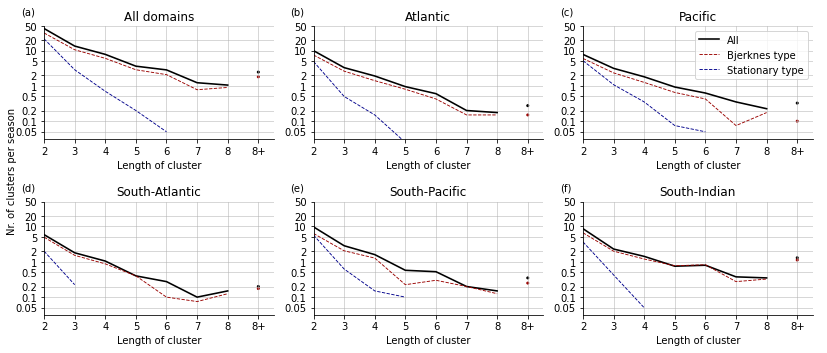

In [25]:

'''
plt.figure()
f, axs = plt.subplots(2, 3, sharey=True)
plt.subplots_adjust(hspace=0.45)
axs[0,0].bar(range(1,maxLength+1,1),lenAll[0:maxLength],log=True,color="dodgerblue")
axs[0,0].set_title("All")
strAll = "{:2.2f}".format(avAll)
axs[0,0].text(0.95, 0.95, strAll,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,0].transAxes,
        color='dodgerblue', fontsize=8)
axs[0,1].bar(range(1,maxLength+1,1),lenAtlantic[0:maxLength],log=True,color="dodgerblue")
axs[0,1].set_title("Atlantic")
strAtl = "{:2.2f}".format(avAtlantic)
axs[0,1].text(0.95, 0.95, strAtl,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,1].transAxes,
        color='dodgerblue', fontsize=8)
axs[0,2].bar(range(1,maxLength+1,1),lenPacific[0:maxLength],log=True,color="dodgerblue")
axs[0,2].set_title("Pacific")
strPac = "{:2.2f}".format(avPacific)
axs[0,2].text(0.95, 0.95, strPac,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,2].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,0].bar(range(1,maxLength+1,1),lenSAtlantic[0:maxLength],log=True,color="dodgerblue")
axs[1,0].set_title("South Atlantic")
strSAtl = "{:2.2f}".format(avSAtlantic)
axs[1,0].text(0.95, 0.95, strSAtl,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,0].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,1].bar(range(1,maxLength+1,1),lenSPacific[0:maxLength],log=True,color="dodgerblue")
axs[1,1].set_title("South Pacific")
strSPac = "{:2.2f}".format(avSPacific)
axs[1,1].text(0.95, 0.95, strSPac,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,1].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,2].bar(range(1,maxLength+1,1),lenSIndian[0:maxLength],log=True,color="dodgerblue")
axs[1,2].set_title("South Indian")
strSInd = "{:2.2f}".format(avSIndian)
axs[1,2].text(0.95, 0.95, strSInd,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,2].transAxes,
        color='dodgerblue', fontsize=8)
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Length of cluster")
plt.ylabel("Count")
plt.savefig("ClustersLength_Areas_"+ Options["whichClusters"] + ".pdf")


def discrete_matshow(data):
    # get discrete colormap
    cmap = plt.get_cmap('RdBu', np.nanmax(data) - np.nanmin(data) + 1)
    # set limits .5 outside true range
    mat = plt.matshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                      vmax=np.max(data) + 0.5)
    # tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.nanmin(data), np.nanmax(data) + 1))

# generate data
data = np.log10(arrayLengths)
data[np.isinf(data)] = np.nan
plt.figure()
a = np.random.randint(1, 9, size=(10, 10))
discrete_matshow(data)
plt.savefig("Testing.png")
'''

#OLD 
'''
lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
arrayLengths = np.zeros((6,14))
arrayLengths[0,::] = lenAll[1:(maxLength+1)]
arrayLengths[1,::] = lenAtlantic[1:(maxLength+1)]
arrayLengths[2,::] = lenPacific[1:(maxLength+1)]
arrayLengths[3,::] = lenSAtlantic[1:(maxLength+1)]
arrayLengths[4,::] = lenSPacific[1:(maxLength+1)]
arrayLengths[5,::] = lenSIndian[1:(maxLength+1)]

fig = plt.figure(figsize=(12,2.67))
ax = plt.subplot(1, 1, 1)
data = np.log10(arrayLengths)
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue','xkcd:pumpkin','xkcd:sky blue','xkcd:grass green'],
linewidth=[1.6,0.9,0.9,0.9,0.9,0.9],linestyle=['-','--','--','-','-','-'])
ax.plot(np.arange(2,maxLength+1,1),np.transpose(data))
ax.set_xticks(np.arange(2,21,1))
yvals = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,14)
ax.set_ylim(-.2,np.log10(5000))
ax.grid(linewidth = 0.5)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.legend(labels=["All","North Atlantic","North Pacific","South Atlantic","South Pacific","South Indian"])
plt.tight_layout()
plt.savefig("ClustersLength_Areas_lines_" + Options["whichClusters"] + ".pdf")
'''

########################################################################
# New (per area)
########################################################################
xticks_labels = list(np.arange(2,maxLength,1))
xticks_labels = [str(x) for x in xticks_labels]
xticks_labels.extend(['8+'])

lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenAll[1:(maxLength+1)]
arrayLengths[1,::] = lenAll_length[1:(maxLength+1)]
arrayLengths[2,::] = lenAll_nolength[1:(maxLength+1)]

fig = plt.figure(figsize=(12,5.33))

#All domains
ax = plt.subplot(2, 3, 1)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
#ax.plot(np.arange(2,maxLength+1,1),np.transpose(data))
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("All domains")
ax.text(-0.1,1.1,"(a)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#Atlantic
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenAtlantic[1:(maxLength+1)]
arrayLengths[1,::] = lenAtlantic_length[1:(maxLength+1)]
arrayLengths[2,::] = lenAtlantic_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 2)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("Atlantic")
ax.text(-0.1,1.1,"(b)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#Pacific
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenPacific[1:(maxLength+1)]
arrayLengths[1,::] = lenPacific_length[1:(maxLength+1)]
arrayLengths[2,::] = lenPacific_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 3)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)

yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("Pacific")
ax.text(-0.1,1.1,"(c)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.legend(labels=["All","Bjerknes type","Stationary type"])

#South-Atlantic
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSAtlantic[1:(maxLength+1)]
arrayLengths[1,::] = lenSAtlantic_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSAtlantic_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 4)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("South-Atlantic")
ax.text(-0.1,1.1,"(d)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#South-Pacific
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSPacific[1:(maxLength+1)]
arrayLengths[1,::] = lenSPacific_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSPacific_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 5)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("South-Pacific")
ax.text(-0.1,1.1,"(e)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#South-Indian
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSIndian[1:(maxLength+1)]
arrayLengths[1,::] = lenSIndian_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSIndian_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 6)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
#ax.set_ylim(-1.5,np.log10(100))
ax.set_ylim(-1.5,np.log10(50))
ax.grid(linewidth = 0.5)
ax.set_title("South-Indian")
ax.text(-0.1,1.1,"(f)",transform=ax.transAxes)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# BIG subplot for common label
axTot = fig.add_subplot(111,frameon=False)    # The big subplot
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

axTot.set_ylabel("Nr. of clusters per season")


plt.tight_layout()
plt.savefig("ClustersLength_Areas_lines_PerBasin_" + "lnght_" + str(Options["lngthresh"]) +
            "timlnght_" + str(Options["timlngthresh"]) + "_DJF_.pdf") # ".pdf"


In [ ]:
data[:,-1]

In [66]:
############################################################################

############################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_solo = [item for sublist in sorted_clusters_Atlantic for item in sublist if (len(sublist) <= 3)]
storms_Pacific_solo = [item for sublist in sorted_clusters_Pacific for item in sublist if (len(sublist) <= 3)]
storms_sAtlantic_solo = [item for sublist in sorted_clusters_sAtlantic for item in sublist if (len(sublist) <= 3)]
storms_sPacific_solo = [item for sublist in sorted_clusters_sPacific for item in sublist if (len(sublist) <= 3)]
storms_sIndian_solo = [item for sublist in sorted_clusters_sIndian for item in sublist if (len(sublist) <= 3)]

storms_Atlantic_clust = [item for sublist in sorted_clusters_Atlantic for item in sublist if (len(sublist) > 3)]
storms_Pacific_clust = [item for sublist in sorted_clusters_Pacific for item in sublist if (len(sublist) > 3)]
storms_sAtlantic_clust = [item for sublist in sorted_clusters_sAtlantic for item in sublist if (len(sublist) > 3)]
storms_sPacific_clust = [item for sublist in sorted_clusters_sPacific for item in sublist if (len(sublist) > 3)]
storms_sIndian_clust = [item for sublist in sorted_clusters_sIndian for item in sublist if (len(sublist) > 3)]

storms_Atlantic = [item for sublist in sorted_clusters_Atlantic for item in sublist]
length_Atlantic = [len(sublist) for sublist in sorted_clusters_Atlantic for item in sublist]
storms_Pacific = [item for sublist in sorted_clusters_Pacific for item in sublist]
length_Pacific = [len(sublist) for sublist in sorted_clusters_Pacific for item in sublist]
storms_sAtlantic = [item for sublist in sorted_clusters_sAtlantic for item in sublist]
length_sAtlantic = [len(sublist) for sublist in sorted_clusters_sAtlantic for item in sublist]
storms_sPacific = [item for sublist in sorted_clusters_sPacific for item in sublist]
length_sPacific = [len(sublist) for sublist in sorted_clusters_sPacific for item in sublist]
storms_sIndian = [item for sublist in sorted_clusters_sIndian for item in sublist]
length_sIndian = [len(sublist) for sublist in sorted_clusters_sIndian for item in sublist]

#Define results arrays
pres_Atlantic = np.zeros(len(storms_Atlantic))
lapl_Atlantic = np.zeros(len(storms_Atlantic))
pres_Pacific = np.zeros(len(storms_Pacific))
lapl_Pacific = np.zeros(len(storms_Pacific))
pres_sAtlantic = np.zeros(len(storms_sAtlantic))
lapl_sAtlantic = np.zeros(len(storms_sAtlantic))
pres_sPacific = np.zeros(len(storms_sPacific))
lapl_sPacific = np.zeros(len(storms_sPacific))
pres_sIndian = np.zeros(len(storms_sIndian))
lapl_sIndian = np.zeros(len(storms_sIndian))
month_Atlantic = np.zeros(len(storms_Atlantic))
month_Pacific = np.zeros(len(storms_Pacific))
month_sAtlantic = np.zeros(len(storms_sAtlantic))
month_sPacific = np.zeros(len(storms_sPacific))
month_sIndian = np.zeros(len(storms_sIndian))
year_Atlantic = np.zeros(len(storms_Atlantic))
year_Pacific = np.zeros(len(storms_Pacific))
year_sAtlantic = np.zeros(len(storms_sAtlantic))
year_sPacific = np.zeros(len(storms_sPacific))
year_sIndian = np.zeros(len(storms_sIndian))
radi_Atlantic = np.zeros(len(storms_Atlantic))
radi_Pacific = np.zeros(len(storms_Pacific))
radi_sAtlantic = np.zeros(len(storms_sAtlantic))
radi_sPacific = np.zeros(len(storms_sPacific))
radi_sIndian = np.zeros(len(storms_sIndian))


pres_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
lapl_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
pres_Pacific_clust = np.zeros(len(storms_Pacific_clust))
lapl_Pacific_clust = np.zeros(len(storms_Pacific_clust))
pres_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
lapl_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
pres_sPacific_clust = np.zeros(len(storms_sPacific_clust))
lapl_sPacific_clust = np.zeros(len(storms_sPacific_clust))
pres_sIndian_clust = np.zeros(len(storms_sIndian_clust))
lapl_sIndian_clust = np.zeros(len(storms_sIndian_clust))

pres_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
lapl_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
pres_Pacific_solo = np.zeros(len(storms_Pacific_solo))
lapl_Pacific_solo = np.zeros(len(storms_Pacific_solo))
pres_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
lapl_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
pres_sPacific_solo = np.zeros(len(storms_sPacific_solo))
lapl_sPacific_solo = np.zeros(len(storms_sPacific_solo))
pres_sIndian_solo = np.zeros(len(storms_sIndian_solo))
lapl_sIndian_solo = np.zeros(len(storms_sIndian_solo))

radi_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
radi_Pacific_clust = np.zeros(len(storms_Pacific_clust))
radi_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
radi_sPacific_clust = np.zeros(len(storms_sPacific_clust))
radi_sIndian_clust = np.zeros(len(storms_sIndian_clust))

radi_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
radi_Pacific_solo = np.zeros(len(storms_Pacific_solo))
radi_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
radi_sPacific_solo = np.zeros(len(storms_sPacific_solo))
radi_sIndian_solo = np.zeros(len(storms_sIndian_solo))

month_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
month_Pacific_clust = np.zeros(len(storms_Pacific_clust))
month_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
month_sPacific_clust = np.zeros(len(storms_sPacific_clust))
month_sIndian_clust = np.zeros(len(storms_sIndian_clust))

month_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
month_Pacific_solo = np.zeros(len(storms_Pacific_solo))
month_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
month_sPacific_solo = np.zeros(len(storms_sPacific_solo))
month_sIndian_solo = np.zeros(len(storms_sIndian_solo))

year_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
year_Pacific_clust = np.zeros(len(storms_Pacific_clust))
year_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
year_sPacific_clust = np.zeros(len(storms_sPacific_clust))
year_sIndian_clust = np.zeros(len(storms_sIndian_clust))

year_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
year_Pacific_solo = np.zeros(len(storms_Pacific_solo))
year_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
year_sPacific_solo = np.zeros(len(storms_sPacific_solo))
year_sIndian_solo = np.zeros(len(storms_sIndian_solo))

#Intensification
int_Atlantic_clust = []
int_Pacific_clust = []
int_sAtlantic_clust = []
int_sPacific_clust = []
int_sIndian_clust = []

int_Atlantic_solo = []
int_Pacific_solo = []
int_sAtlantic_solo = []
int_sPacific_solo = []
int_sIndian_solo = []

for strm in range(len(storms_Atlantic)):
	pres_Atlantic[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic[strm]]])
	lapl_Atlantic[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic[strm]]])
	radi_Atlantic[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic[strm]]])
	month_Atlantic[strm] = stats.mode(str_month[ids_storms[storms_Atlantic[strm]]])[0]
	year_Atlantic[strm] = stats.mode(str_year[ids_storms[storms_Atlantic[strm]]])[0]
	
	pres_temp = str_pres[ids_storms[storms_Atlantic[strm]]][1:] - str_pres[ids_storms[storms_Atlantic[strm]]][:-1]
	
	int_Atlantic_clust.append(pres_temp)

for strm in range(len(storms_Atlantic_clust)):
	pres_Atlantic_clust[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_clust[strm]]])
	lapl_Atlantic_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_clust[strm]]])
	radi_Atlantic_clust[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_clust[strm]]])
	month_Atlantic_clust[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_clust[strm]]])[0]
	year_Atlantic_clust[strm] = stats.mode(str_year[ids_storms[storms_Atlantic_clust[strm]]])[0]

for strm in range(len(storms_Atlantic_solo)):
	pres_Atlantic_solo[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_solo[strm]]])
	lapl_Atlantic_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_solo[strm]]])
	radi_Atlantic_solo[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_solo[strm]]])
	month_Atlantic_solo[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_solo[strm]]])[0]
	year_Atlantic_solo[strm] = stats.mode(str_year[ids_storms[storms_Atlantic_solo[strm]]])[0]

for strm in range(len(storms_Pacific)):
	pres_Pacific[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific[strm]]])
	lapl_Pacific[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific[strm]]])
	radi_Pacific[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific[strm]]])
	month_Pacific[strm] = stats.mode(str_month[ids_storms[storms_Pacific[strm]]])[0]
	year_Pacific[strm] = stats.mode(str_year[ids_storms[storms_Pacific[strm]]])[0]

for strm in range(len(storms_Pacific_clust)):
	pres_Pacific_clust[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_clust[strm]]])
	lapl_Pacific_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_clust[strm]]])
	radi_Pacific_clust[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_clust[strm]]])
	month_Pacific_clust[strm] = stats.mode(str_month[ids_storms[storms_Pacific_clust[strm]]])[0]
	year_Pacific_clust[strm] = stats.mode(str_year[ids_storms[storms_Pacific_clust[strm]]])[0]

for strm in range(len(storms_Pacific_solo)):
	pres_Pacific_solo[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_solo[strm]]])
	lapl_Pacific_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_solo[strm]]])
	radi_Pacific_solo[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_solo[strm]]])
	month_Pacific_solo[strm] = stats.mode(str_month[ids_storms[storms_Pacific_solo[strm]]])[0]
	year_Pacific_solo[strm] = stats.mode(str_year[ids_storms[storms_Pacific_solo[strm]]])[0]

for strm in range(len(storms_sAtlantic)):
	pres_sAtlantic[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic[strm]]])
	lapl_sAtlantic[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic[strm]]])
	radi_sAtlantic[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic[strm]]])
	month_sAtlantic[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic[strm]]])[0]
	year_sAtlantic[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic[strm]]])[0]

for strm in range(len(storms_sAtlantic_clust)):
	pres_sAtlantic_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_clust[strm]]])
	lapl_sAtlantic_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_clust[strm]]])
	radi_sAtlantic_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_clust[strm]]])
	month_sAtlantic_clust[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_clust[strm]]])[0]
	year_sAtlantic_clust[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic_clust[strm]]])[0]

for strm in range(len(storms_sAtlantic_solo)):
	pres_sAtlantic_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_solo[strm]]])
	lapl_sAtlantic_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_solo[strm]]])
	radi_sAtlantic_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_solo[strm]]])
	month_sAtlantic_solo[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_solo[strm]]])[0]
	year_sAtlantic_solo[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic_solo[strm]]])[0]

for strm in range(len(storms_sPacific)):
	pres_sPacific[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific[strm]]])
	lapl_sPacific[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific[strm]]])
	radi_sPacific[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific[strm]]])
	month_sPacific[strm] = stats.mode(str_month[ids_storms[storms_sPacific[strm]]])[0]
	year_sPacific[strm] = stats.mode(str_year[ids_storms[storms_sPacific[strm]]])[0]

for strm in range(len(storms_sPacific_clust)):
	pres_sPacific_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_clust[strm]]])
	lapl_sPacific_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_clust[strm]]])
	radi_sPacific_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_clust[strm]]])
	month_sPacific_clust[strm] = stats.mode(str_month[ids_storms[storms_sPacific_clust[strm]]])[0]
	year_sPacific_clust[strm] = stats.mode(str_year[ids_storms[storms_sPacific_clust[strm]]])[0]

for strm in range(len(storms_sPacific_solo)):
	pres_sPacific_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_solo[strm]]])
	lapl_sPacific_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_solo[strm]]])
	radi_sPacific_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_solo[strm]]])
	month_sPacific_solo[strm] = stats.mode(str_month[ids_storms[storms_sPacific_solo[strm]]])[0]
	year_sPacific_solo[strm] = stats.mode(str_year[ids_storms[storms_sPacific_solo[strm]]])[0]

for strm in range(len(storms_sIndian)):
	pres_sIndian[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian[strm]]])
	lapl_sIndian[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian[strm]]])
	radi_sIndian[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian[strm]]])
	month_sIndian[strm] = stats.mode(str_month[ids_storms[storms_sIndian[strm]]])[0]
	year_sIndian[strm] = stats.mode(str_year[ids_storms[storms_sIndian[strm]]])[0]

for strm in range(len(storms_sIndian_clust)):
	pres_sIndian_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_clust[strm]]])
	lapl_sIndian_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_clust[strm]]])
	radi_sIndian_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_clust[strm]]])
	month_sIndian_clust[strm] = stats.mode(str_month[ids_storms[storms_sIndian_clust[strm]]])[0]
	year_sIndian_clust[strm] = stats.mode(str_year[ids_storms[storms_sIndian_clust[strm]]])[0]

for strm in range(len(storms_sIndian_solo)):
	pres_sIndian_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_solo[strm]]])
	lapl_sIndian_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_solo[strm]]])
	radi_sIndian_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_solo[strm]]])
	month_sIndian_solo[strm] = stats.mode(str_month[ids_storms[storms_sIndian_solo[strm]]])[0]
	year_sIndian_solo[strm] = stats.mode(str_year[ids_storms[storms_sIndian_solo[strm]]])[0]

pres_All = np.hstack((pres_Atlantic,pres_Pacific,pres_sAtlantic,pres_sPacific,pres_sIndian))
length_All = np.hstack((length_Atlantic,length_Pacific,length_sAtlantic,length_sPacific,length_sIndian))
pres_All_clust = np.hstack((pres_Atlantic_clust,pres_Pacific_clust,pres_sAtlantic_clust,pres_sPacific_clust,pres_sIndian_clust))
pres_All_solo = np.hstack((pres_Atlantic_solo,pres_Pacific_solo,pres_sAtlantic_solo,pres_sPacific_solo,pres_sIndian_solo))

lapl_All = np.hstack((lapl_Atlantic,lapl_Pacific,lapl_sAtlantic,lapl_sPacific,lapl_sIndian))
lapl_All_clust = np.hstack((lapl_Atlantic_clust,lapl_Pacific_clust,lapl_sAtlantic_clust,lapl_sPacific_clust,lapl_sIndian_clust))
lapl_All_solo = np.hstack((lapl_Atlantic_solo,lapl_Pacific_solo,lapl_sAtlantic_solo,lapl_sPacific_solo,lapl_sIndian_solo))

radi_All_clust = np.hstack((radi_Atlantic_clust,radi_Pacific_clust,radi_sAtlantic_clust,radi_sPacific_clust,radi_sIndian_clust))
radi_All_solo = np.hstack((radi_Atlantic_solo,radi_Pacific_solo,radi_sAtlantic_solo,radi_sPacific_solo,radi_sIndian_solo))

month_All = np.hstack(((month_Atlantic+6)%12,(month_Pacific+6)%12,month_sAtlantic,month_sPacific,month_sIndian))
month_All_clust = np.hstack((month_Atlantic_clust,month_Pacific_clust,month_sAtlantic_clust,month_sPacific_clust,month_sIndian_clust))
month_All_solo = np.hstack((month_Atlantic_solo,month_Pacific_solo,month_sAtlantic_solo,month_sPacific_solo,month_sIndian_solo))

year_All_clust = np.hstack((year_Atlantic_clust,year_Pacific_clust,year_sAtlantic_clust,year_sPacific_clust,year_sIndian_clust))
year_All_solo = np.hstack((year_Atlantic_solo,year_Pacific_solo,year_sAtlantic_solo,year_sPacific_solo,year_sIndian_solo))


#################
# PDF with min. pressure, only strongest cyclone per family
#################
laplstep = .5
laplBins_mid = np.arange(2.0,9.1,laplstep)
laplBins = np.arange(1.75,9.26,laplstep)

pdfAll = np.zeros((10,len(laplBins_mid)))
pdfAtlantic = np.zeros((10,len(laplBins_mid)))
pdfPacific = np.zeros((10,len(laplBins_mid)))
pdfsAtlantic = np.zeros((10,len(laplBins_mid)))
pdfsPacific = np.zeros((10,len(laplBins_mid)))
pdfsIndian = np.zeros((10,len(laplBins_mid)))

quantsAll = np.zeros((10,3))
quantsAtlantic = np.zeros((10,3))
quantsPacific = np.zeros((10,3))
quantsSAtlantic = np.zeros((10,3))
quantsSPacific = np.zeros((10,3))
quantsSIndian = np.zeros((10,3))

quantsAll_Expect = np.zeros((10,3))
quantsAtlantic_Expect = np.zeros((10,3))
quantsPacific_Expect = np.zeros((10,3))
quantsSAtlantic_Expect = np.zeros((10,3))
quantsSPacific_Expect = np.zeros((10,3))
quantsSIndian_Expect = np.zeros((10,3))

'''
for l in range(10):
	if(l < 9):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
	pdfAll[l,::] = np.histogram(laplTempAll,bins=laplBins,normed=True)[0]*laplstep
	pdfAtlantic[l,::] = np.histogram(laplTempAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfPacific[l,::] = np.histogram(laplTempPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsAtlantic[l,::] = np.histogram(laplTempsAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfsPacific[l,::] = np.histogram(laplTempsPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsIndian[l,::] = np.histogram(laplTempsIndian,bins=laplBins,normed=True)[0]*laplstep
	quantsAll[l,::] = np.quantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic[l,::] =  np.quantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific[l,::] = np.quantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic[l,::] = np.quantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific[l,::] = np.quantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian[l,::] = np.quantile(laplTempsIndian,[0.1,0.5,0.9])


	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.quantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.quantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.quantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.quantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.quantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.quantile(TempsIndian,[0.1,0.5,0.9])





#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(quantsAll[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,0].plot(quantsAll_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,0].plot(quantsAll[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].plot(quantsAll[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].set_title("All")

axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(quantsAtlantic[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,1].plot(quantsAtlantic_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,1].plot(quantsAtlantic[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].plot(quantsAtlantic[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strAtl = "{:2.2f}".format(np.nanmean(lapl_Atlantic_solo))
strAtlclust = "{:2.2f}".format(np.nanmean(lapl_Atlantic_clust))

axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(quantsPacific[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,2].plot(quantsPacific_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,2].plot(quantsPacific[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].plot(quantsPacific[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strPac = "{:2.2f}".format(np.nanmean(lapl_Pacific_solo))
strPacclust = "{:2.2f}".format(np.nanmean(lapl_Pacific_clust))

axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(quantsSAtlantic[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].plot(quantsSAtlantic[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSAtl = "{:2.2f}".format(np.nanmean(lapl_sAtlantic_solo))
strSAtlclust = "{:2.2f}".format(np.nanmean(lapl_sAtlantic_clust))

axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(quantsSPacific[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,1].plot(quantsSPacific_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,1].plot(quantsSPacific[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].plot(quantsSPacific[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSPac = "{:2.2f}".format(np.nanmean(lapl_sPacific_solo))
strSPacclust = "{:2.2f}".format(np.nanmean(lapl_sPacific_clust))

axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(quantsSIndian[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,2].plot(quantsSIndian_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,2].plot(quantsSIndian[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].plot(quantsSIndian[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSInd = "{:2.2f}".format(np.nanmean(lapl_sIndian_solo))
strSIndclust = "{:2.2f}".format(np.nanmean(lapl_sIndian_clust))

# Add color bar
f.subplots_adjust(right=0.875)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Maximum Laplacian of storm")
plt.ylabel("Count")

plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ Options["whichClusters"] + ".pdf")

'''
### BOXPLOTS ####
# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend(bbox_to_anchor=(1.1, 0.75))
 


### BOXPLOTS ####
boxplotsAll = []
boxplotsAtlantic = []
boxplotsPacific = []
boxplotsSAtlantic = []
boxplotsSPacific = []
boxplotsSIndian = []

quantsAll_Expect = np.zeros((10,3))
quantsAtlantic_Expect = np.zeros((10,3))
quantsPacific_Expect = np.zeros((10,3))
quantsSAtlantic_Expect = np.zeros((10,3))
quantsSPacific_Expect = np.zeros((10,3))
quantsSIndian_Expect = np.zeros((10,3))

maxstorms = 10
# the list named ticks, summarizes or groups
ticks = ['Solo', '2', '3','4','5','6','7','8','9','10+']

if(Options["whichClusters"] == "nolength"):
    maxstorms = 8
    # the list named ticks, summarizes or groups
    ticks = ['Solo', '2', '3','4','5','6','7','8+','','']


for l in range(maxstorms):
	if(l < maxstorms - 1):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
	boxplotsAll.append(laplTempAll)
	boxplotsAtlantic.append(laplTempAtlantic)
	boxplotsPacific.append(laplTempPacific)
	boxplotsSAtlantic.append(laplTempsAtlantic)
	boxplotsSPacific.append(laplTempsPacific)
	boxplotsSIndian.append(laplTempsIndian)
	
	
	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.quantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.quantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.quantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.quantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.quantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.quantile(TempsIndian,[0.1,0.5,0.9])

if(Options["whichClusters"] == "nolength"):
	for l in range(8,10):
		boxplotsAll.append([])
		boxplotsAtlantic.append([])
		boxplotsPacific.append([])
		boxplotsSAtlantic.append([])
		boxplotsSPacific.append([])
		boxplotsSIndian.append([])
	
		quantsAll_Expect[l,::] = np.nan
		quantsAtlantic_Expect[l,::] =  np.nan
		quantsPacific_Expect[l,::] = np.nan
		quantsSAtlantic_Expect[l,::] = np.nan
		quantsSPacific_Expect[l,::] = np.nan
		quantsSIndian_Expect[l,::] = np.nan
	



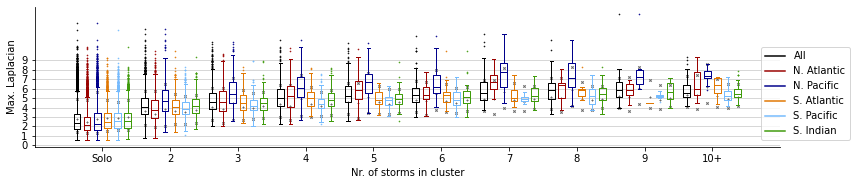

In [57]:


### BOX PLOTS
fig = plt.figure(figsize=(12,2.67))
ax = plt.subplot(1, 1, 1)
bxplotAll = plt.boxplot(boxplotsAll, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.75, widths=0.2, flierprops=dict(markeredgecolor='black',markersize=0.6))
bxplotAtl = plt.boxplot(boxplotsAtlantic, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.45, widths=0.2, flierprops=dict(markeredgecolor='#9a0200',markersize=0.6))
bxplotPac = plt.boxplot(boxplotsPacific, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.15, widths=0.2,flierprops=dict(markeredgecolor='darkblue',markersize=0.6))
bxplotSAtl = plt.boxplot(boxplotsSAtlantic, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.15, widths=0.2,flierprops=dict(markeredgecolor='#e17701',markersize=0.6))
bxplotSPac = plt.boxplot(boxplotsSPacific, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.45, widths=0.2,flierprops=dict(markeredgecolor='#75bbfd',markersize=0.6))
bxplotSIndi = plt.boxplot(boxplotsSIndian, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.75, widths=0.2,flierprops=dict(markeredgecolor='#3f9b0b',markersize=0.6))

# setting colors for each groups
# =["black",'xkcd:deep red','darkblue','xkcd:pumpkin','xkcd:sky blue','xkcd:grass green'],
define_box_properties(bxplotAll, 'black', 'All')
define_box_properties(bxplotAtl, '#9a0200', 'N. Atlantic')
define_box_properties(bxplotPac, 'darkblue', 'N. Pacific')
define_box_properties(bxplotSAtl, '#e17701', 'S. Atlantic') #e17701
define_box_properties(bxplotSPac, '#75bbfd', 'S. Pacific')
define_box_properties(bxplotSIndi, '#3f9b0b', 'S. Indian')

# Add results from random sampling
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
#NH
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
#SH
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_yticks(np.arange(0,10)) #np.arange(0, 5)

#X -Y labels
plt.ylabel("Max. Laplacian")
plt.xlabel("Nr. of storms in cluster")
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Add gridlines
ax.grid(linewidth=0.5,axis='y',zorder=0)

plt.tight_layout()
plt.savefig("Boxplots_"+ Options["whichClusters"] + "_normalised.pdf")

In [67]:
############
# PDF with min. pressure, only strongest cyclone per family
#################
maxLength = 9

laplstep = .5
laplBins_mid = np.arange(2.0,9.1,laplstep)
laplBins = np.arange(1.75,9.26,laplstep)

pdfAll = np.zeros((maxLength,len(laplBins_mid)))
pdfAtlantic = np.zeros((maxLength,len(laplBins_mid)))
pdfPacific = np.zeros((maxLength,len(laplBins_mid)))
pdfsAtlantic = np.zeros((maxLength,len(laplBins_mid)))
pdfsPacific = np.zeros((maxLength,len(laplBins_mid)))
pdfsIndian = np.zeros((maxLength,len(laplBins_mid)))

quantsAll = np.zeros((maxLength,3))
quantsAtlantic = np.zeros((maxLength,3))
quantsPacific = np.zeros((maxLength,3))
quantsSAtlantic = np.zeros((maxLength,3))
quantsSPacific = np.zeros((maxLength,3))
quantsSIndian = np.zeros((maxLength,3))

quantsAll_Expect = np.zeros((maxLength,3))
quantsAtlantic_Expect = np.zeros((maxLength,3))
quantsPacific_Expect = np.zeros((maxLength,3))
quantsSAtlantic_Expect = np.zeros((maxLength,3))
quantsSPacific_Expect = np.zeros((maxLength,3))
quantsSIndian_Expect = np.zeros((maxLength,3))


for l in range(9):
	if(l < 8):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
    
	pdfAll[l,::] = np.histogram(laplTempAll,bins=laplBins,normed=True)[0]*laplstep
	pdfAtlantic[l,::] = np.histogram(laplTempAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfPacific[l,::] = np.histogram(laplTempPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsAtlantic[l,::] = np.histogram(laplTempsAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfsPacific[l,::] = np.histogram(laplTempsPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsIndian[l,::] = np.histogram(laplTempsIndian,bins=laplBins,normed=True)[0]*laplstep
    
	quantsAll[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])


	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.nanquantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.nanquantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.nanquantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.nanquantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.nanquantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.nanquantile(TempsIndian,[0.1,0.5,0.9])

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:50

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

<Figure size 432x288 with 0 Axes>

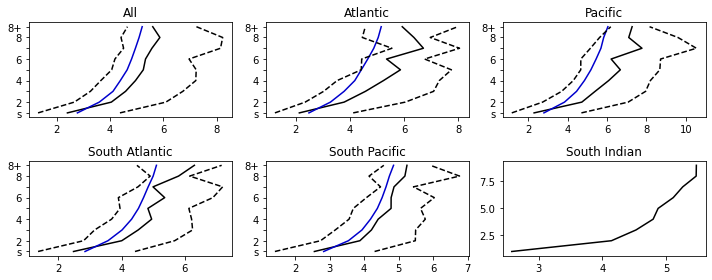

In [61]:
%matplotlib inline

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(quantsAll[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,0].plot(quantsAll_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,0].plot(quantsAll[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].plot(quantsAll[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,0].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(quantsAtlantic[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,1].plot(quantsAtlantic_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,1].plot(quantsAtlantic[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].plot(quantsAtlantic[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,1].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(quantsPacific[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,2].plot(quantsPacific_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,2].plot(quantsPacific[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].plot(quantsPacific[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,2].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(quantsSAtlantic[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].plot(quantsSAtlantic[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,0].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(quantsSPacific[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,1].plot(quantsSPacific_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[1,1].plot(quantsSPacific[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].plot(quantsSPacific[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,1].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(quantsSIndian[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,2].plot(quantsSIndian_Expect[:,1],range(1,11),color="mediumblue",linewidth=1.5)
axs[1,2].plot(quantsSIndian[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].plot(quantsSIndian[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,2].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Maximum Laplacian of strongest storm")
plt.ylabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ str(Options["whichClusters"]) +
            "_lngthresh_" + str(Options["lngthresh"]) + "_timlngthresh_" + str(Options["timlngthresh"]) +
            "_nopdf_normalised.pdf")

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

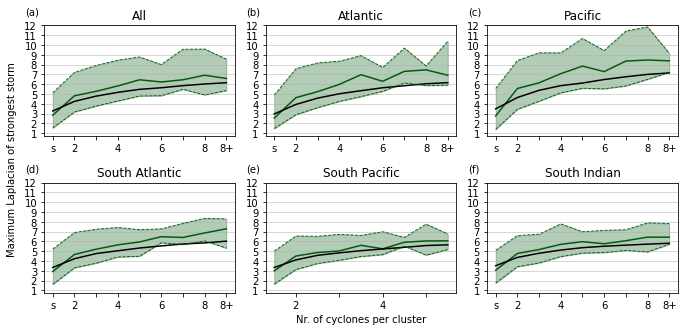

In [95]:
%matplotlib inline

ylim_max = 12.0

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(5.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll[:,0],quantsAll[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,0].plot(range(1,maxLength+1),quantsAll_Expect[:,1],color="black",linewidth=1.5)
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,0].set_xticks([1,2,3,4,5,6,7,8,9])
#axs[0,0].set_yticks([1,2,3,4,5,6,7,8])
axs[0,0].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[0,0].set_ylim(0.75,8.0)
axs[0,0].set_ylim(0.75,ylim_max)
axs[0,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")
axs[0,0].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,0].text(-.1,1.1,"(a)",transform=axs[0,0].transAxes)

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic[:,0],quantsAtlantic[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,1].set_xticks([1,2,3,4,5,6,7,8,9])
#axs[0,1].set_yticks([1,2,3,4,5,6,7,8])
axs[0,1].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[0,1].set_ylim(0.75,8.0)
axs[0,1].set_ylim(0.75,ylim_max)
axs[0,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,1].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,1].text(-.1,1.1,"(b)",transform=axs[0,1].transAxes)

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific[:,0],quantsPacific[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,2].set_xticks([1,2,3,4,5,6,7,8,9])
#axs[0,2].set_yticks([1,2,3,4,5,6,7,8])
axs[0,2].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[0,2].set_ylim(0.75,8.0)
axs[0,2].set_ylim(0.75,ylim_max)
axs[0,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,2].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,2].text(-.1,1.1,"(c)",transform=axs[0,2].transAxes)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic[:,0],quantsSAtlantic[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,0].set_xticks([1,2,3,4,5,6,7,8,9])
#axs[1,0].set_yticks([1,2,3,4,5,6,7,8])
axs[1,0].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[1,0].set_ylim(0.75,8.0)
axs[1,0].set_ylim(0.75,ylim_max)
axs[1,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,0].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,0].text(-.1,1.1,"(d)",transform=axs[1,0].transAxes)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific[:,0],quantsSPacific[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_Expect[:,1],color="black",linewidth=1.5)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
#axs[1,1].set_yticks([1,2,3,4,5,6,7,8])
axs[1,1].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[1,1].set_ylim(0.75,8.0)
axs[1,1].set_ylim(0.75,ylim_max)
axs[1,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,1].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,1].text(-.1,1.1,"(e)",transform=axs[1,1].transAxes)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian[:,0],quantsSIndian[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_Expect[:,1],color="black",linewidth=1.5)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,2].set_xticks([1,2,3,4,5,6,7,8,9])
#axs[1,2].set_yticks([1,2,3,4,5,6,7,8])
axs[1,2].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#axs[1,2].set_ylim(0.75,8.0)
axs[1,2].set_ylim(0.75,ylim_max)
axs[1,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,2].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,2].text(-.1,1.1,"(f)",transform=axs[1,2].transAxes)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian of strongest storm")
plt.xlabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ str(Options["whichClusters"]) +
            "_lngthresh_" + str(Options["lngthresh"]) + "_timlngthresh_" + str(Options["timlngthresh"]) +
            "_nopdf_normalised_DJF.pdf")

In [45]:
i=0
[clust for clust in sorted_clusters_Atlantic if len(clust)>=2]


[[5, 23],
 [7, 20],
 [53, 72],
 [67, 87],
 [79, 92],
 [86, 109],
 [101, 107],
 [205, 225],
 [209, 217, 259],
 [275, 290],
 [280, 295, 316, 323],
 [358, 382],
 [368, 386],
 [407, 408, 429, 452, 465],
 [440, 449],
 [469, 487],
 [477, 484],
 [3091, 3106, 3114, 3159],
 [3158, 3171],
 [3177, 3192, 3207, 3221, 3229, 3256, 3266],
 [3232, 3247],
 [3369, 3386, 3390, 3391, 3396],
 [3413, 3432],
 [3418, 3427, 3455],
 [3519, 3553],
 [3539, 3540],
 [3625, 3638],
 [3672, 3676, 3682, 3699, 3708, 3719, 3726, 3729, 3757, 3787],
 [6451, 6464, 6499, 6519, 6529, 6550],
 [6473, 6528],
 [6532, 6549, 6551],
 [6556, 6565],
 [6582, 6595, 6596, 6637],
 [6613, 6617],
 [6626, 6644, 6661, 6668],
 [6749, 6767, 6775, 6785, 6801, 6808],
 [6771, 6787, 6795, 6818],
 [6882, 6895, 6900],
 [6919, 6945, 6955, 6971],
 [6925, 6950, 6967],
 [7000, 7009, 7016],
 [7020, 7026],
 [7050, 7091],
 [7067, 7071],
 [7161, 7175],
 [9903, 9913, 9921],
 [9920, 9928, 9947, 9950, 9963, 9965, 9971, 9976, 9981],
 [9975, 9989, 10025, 10037, 10

In [86]:
########################################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin for subtypes
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_length = [item for sublist in sorted_clusters_length_Atlantic for item in sublist]
storms_Pacific_length = [item for sublist in sorted_clusters_length_Pacific for item in sublist]
storms_sAtlantic_length = [item for sublist in sorted_clusters_length_sAtlantic for item in sublist]
storms_sPacific_length = [item for sublist in sorted_clusters_length_sPacific for item in sublist]
storms_sIndian_length = [item for sublist in sorted_clusters_length_sIndian for item in sublist]

#Define results arrays
pres_Atlantic_length = np.zeros(len(storms_Atlantic_length))
lapl_Atlantic_length = np.zeros(len(storms_Atlantic_length))
pres_Pacific_length = np.zeros(len(storms_Pacific_length))
lapl_Pacific_length = np.zeros(len(storms_Pacific_length))
pres_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
lapl_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
pres_sPacific_length = np.zeros(len(storms_sPacific_length))
lapl_sPacific_length = np.zeros(len(storms_sPacific_length))
pres_sIndian_length = np.zeros(len(storms_sIndian_length))
lapl_sIndian_length = np.zeros(len(storms_sIndian_length))
month_Atlantic_length = np.zeros(len(storms_Atlantic_length))
month_Pacific_length = np.zeros(len(storms_Pacific_length))
month_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
month_sPacific_length = np.zeros(len(storms_sPacific_length))
month_sIndian_length = np.zeros(len(storms_sIndian_length))
radi_Atlantic_length = np.zeros(len(storms_Atlantic_length))
radi_Pacific_length = np.zeros(len(storms_Pacific_length))
radi_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
radi_sPacific_length = np.zeros(len(storms_sPacific_length))
radi_sIndian_length = np.zeros(len(storms_sIndian_length))

for strm in range(len(storms_Atlantic_length)):
	pres_Atlantic_length[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_length[strm]]])
	lapl_Atlantic_length[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_length[strm]]])
	radi_Atlantic_length[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_length[strm]]])
	month_Atlantic_length[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_length[strm]]])[0]

for strm in range(len(storms_Pacific_length)):
	pres_Pacific_length[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_length[strm]]])
	lapl_Pacific_length[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_length[strm]]])
	radi_Pacific_length[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_length[strm]]])
	month_Pacific_length[strm] = stats.mode(str_month[ids_storms[storms_Pacific_length[strm]]])[0]

for strm in range(len(storms_sAtlantic_length)):
	pres_sAtlantic_length[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_length[strm]]])
	lapl_sAtlantic_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_length[strm]]])
	radi_sAtlantic_length[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_length[strm]]])
	month_sAtlantic_length[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_length[strm]]])[0]

for strm in range(len(storms_sPacific_length)):
	pres_sPacific_length[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_length[strm]]])
	lapl_sPacific_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_length[strm]]])
	radi_sPacific_length[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_length[strm]]])
	month_sPacific_length[strm] = stats.mode(str_month[ids_storms[storms_sPacific_length[strm]]])[0]

for strm in range(len(storms_sIndian_length)):
	pres_sIndian_length[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_length[strm]]])
	lapl_sIndian_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_length[strm]]])
	radi_sIndian_length[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_length[strm]]])
	month_sIndian_length[strm] = stats.mode(str_month[ids_storms[storms_sIndian_length[strm]]])[0]

pres_All_length = np.hstack((pres_Atlantic_length,pres_Pacific_length,pres_sAtlantic_length,
                             pres_sPacific_length,pres_sIndian_length))
lapl_All_length = np.hstack((lapl_Atlantic_length,lapl_Pacific_length,lapl_sAtlantic_length,
                             lapl_sPacific_length,lapl_sIndian_length))

########################################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin for subtypes
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_nolength = [item for sublist in sorted_clusters_nolength_Atlantic for item in sublist]
storms_Pacific_nolength = [item for sublist in sorted_clusters_nolength_Pacific for item in sublist]
storms_sAtlantic_nolength = [item for sublist in sorted_clusters_nolength_sAtlantic for item in sublist]
storms_sPacific_nolength = [item for sublist in sorted_clusters_nolength_sPacific for item in sublist]
storms_sIndian_nolength = [item for sublist in sorted_clusters_nolength_sIndian for item in sublist]

#Define results arrays
pres_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
lapl_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
pres_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
lapl_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
pres_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
lapl_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
pres_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
lapl_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
pres_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
lapl_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
month_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
month_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
month_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
month_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
month_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
radi_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
radi_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
radi_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
radi_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
radi_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))

for strm in range(len(storms_Atlantic_nolength)):
	pres_Atlantic_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_nolength[strm]]])
	lapl_Atlantic_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_nolength[strm]]])
	radi_Atlantic_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_nolength[strm]]])
	month_Atlantic_nolength[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_nolength[strm]]])[0]

for strm in range(len(storms_Pacific_nolength)):
	pres_Pacific_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_nolength[strm]]])
	lapl_Pacific_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_nolength[strm]]])
	radi_Pacific_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_nolength[strm]]])
	month_Pacific_nolength[strm] = stats.mode(str_month[ids_storms[storms_Pacific_nolength[strm]]])[0]

for strm in range(len(storms_sAtlantic_nolength)):
	pres_sAtlantic_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_nolength[strm]]])
	lapl_sAtlantic_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_nolength[strm]]])
	radi_sAtlantic_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_nolength[strm]]])
	month_sAtlantic_nolength[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_nolength[strm]]])[0]

for strm in range(len(storms_sPacific_nolength)):
	pres_sPacific_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_nolength[strm]]])
	lapl_sPacific_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_nolength[strm]]])
	radi_sPacific_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_nolength[strm]]])
	month_sPacific_nolength[strm] = stats.mode(str_month[ids_storms[storms_sPacific_nolength[strm]]])[0]

for strm in range(len(storms_sIndian_nolength)):
	pres_sIndian_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_nolength[strm]]])
	lapl_sIndian_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_nolength[strm]]])
	radi_sIndian_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_nolength[strm]]])
	month_sIndian_nolength[strm] = stats.mode(str_month[ids_storms[storms_sIndian_nolength[strm]]])[0]

pres_All_nolength = np.hstack((pres_Atlantic_nolength,pres_Pacific_nolength,pres_sAtlantic_nolength,
                             pres_sPacific_nolength,pres_sIndian_nolength))
lapl_All_nolength = np.hstack((lapl_Atlantic_nolength,lapl_Pacific_nolength,lapl_sAtlantic_nolength,
                             lapl_sPacific_nolength,lapl_sIndian_nolength))

In [87]:
#Quantiles Bjerknes type
quantsAll_length = np.zeros((maxLength,3))
quantsAtlantic_length = np.zeros((maxLength,3))
quantsPacific_length = np.zeros((maxLength,3))
quantsSAtlantic_length = np.zeros((maxLength,3))
quantsSPacific_length = np.zeros((maxLength,3))
quantsSIndian_length = np.zeros((maxLength,3))

for l in range(maxLength):
	if(l < (maxLength -1)):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_length[np.array([np.where(np.array(storms_Atlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_length[np.array([np.where(np.array(storms_Pacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_length[np.array([np.where(np.array(storms_sAtlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_length[np.array([np.where(np.array(storms_sPacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_length[np.array([np.where(np.array(storms_sIndian_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_length[np.array([np.where(np.array(storms_Atlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_length[np.array([np.where(np.array(storms_Pacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_length[np.array([np.where(np.array(storms_sAtlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_length[np.array([np.where(np.array(storms_sPacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_length[np.array([np.where(np.array(storms_sIndian_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,
                                    laplTempsPacific,laplTempsIndian))

	quantsAll_length[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic_length[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific_length[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_length[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_length[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian_length[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])
    
    
# Quantiles Stationary types
quantsAll_nolength = np.zeros((maxLength,3))
quantsAtlantic_nolength = np.zeros((maxLength,3))
quantsPacific_nolength = np.zeros((maxLength,3))
quantsSAtlantic_nolength = np.zeros((maxLength,3))
quantsSPacific_nolength = np.zeros((maxLength,3))
quantsSIndian_nolength = np.zeros((maxLength,3))

for l in range(maxLength):
	if(l < (maxLength-1)):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_nolength[np.array([np.where(np.array(storms_Atlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_nolength[np.array([np.where(np.array(storms_Pacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_nolength[np.array([np.where(np.array(storms_sAtlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_nolength[np.array([np.where(np.array(storms_sPacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_nolength[np.array([np.where(np.array(storms_sIndian_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_nolength[np.array([np.where(np.array(storms_Atlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_nolength[np.array([np.where(np.array(storms_Pacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_nolength[np.array([np.where(np.array(storms_sAtlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_nolength[np.array([np.where(np.array(storms_sPacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_nolength[np.array([np.where(np.array(storms_sIndian_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,
                                    laplTempsPacific,laplTempsIndian))
    
	quantsAll_nolength[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic_nolength[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific_nolength[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_nolength[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_nolength[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian_nolength[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])
    

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<Figure size 828x252 with 0 Axes>

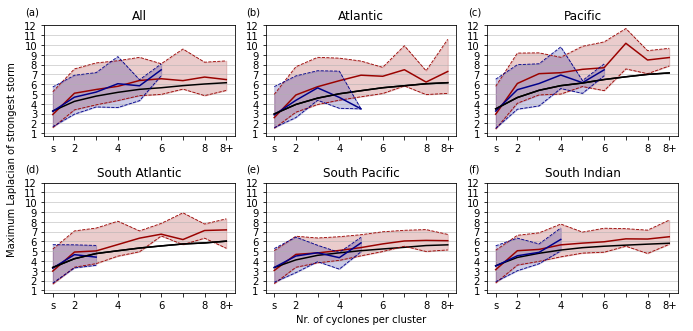

In [93]:
ylim_max = 12

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(5.0) #4.0
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll_length[:,0],quantsAll_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,0].plot(range(1,maxLength+1),quantsAll_Expect[:,1],color="black",linewidth=1.5)
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll_nolength[:,0],quantsAll_nolength[:,2],color="darkblue",alpha=0.2)
axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,0].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[0,0].set_ylim(0.75,ylim_max)
axs[0,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")
axs[0,0].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,0].text(-.1,1.1,"(a)",transform=axs[0,0].transAxes)

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic_length[:,0],quantsAtlantic_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic_nolength[:,0],quantsAtlantic_nolength[:,2],color='darkblue',alpha=0.2)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,1].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[0,1].set_ylim(0.75,ylim_max)
axs[0,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,1].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,1].text(-.1,1.1,"(b)",transform=axs[0,1].transAxes)

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific_length[:,0],quantsPacific_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific_nolength[:,0],quantsPacific_nolength[:,2],color="darkblue",alpha=0.2)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,2].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[0,2].set_ylim(0.75,ylim_max)
axs[0,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,2].grid(linewidth=0.5,axis='y',zorder=0)
axs[0,2].text(-.1,1.1,"(c)",transform=axs[0,2].transAxes)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic_length[:,0],quantsSAtlantic_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic_nolength[:,0],quantsSAtlantic_nolength[:,2],color='darkblue',alpha=0.2)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,0].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1,0].set_ylim(0.75,ylim_max)
axs[1,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,0].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,0].text(-.1,1.1,"(d)",transform=axs[1,0].transAxes)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific_length[:,0],quantsSPacific_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_Expect[:,1],color="black",linewidth=1.5)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific_nolength[:,0],quantsSPacific_nolength[:,2],color="darkblue",alpha=0.2)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,1].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,1].set_ylim(0.75,ylim_max)
axs[1,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,1].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,1].text(-.1,1.1,"(e)",transform=axs[1,1].transAxes)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian_length[:,0],quantsSIndian_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_Expect[:,1],color="black",linewidth=1.5)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian_nolength[:,0],quantsSIndian_nolength[:,2],color="darkblue",alpha=0.2)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,2].set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1,2].set_ylim(0.75,ylim_max)
axs[1,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,2].grid(linewidth=0.5,axis='y',zorder=0)
axs[1,2].text(-.1,1.1,"(f)",transform=axs[1,2].transAxes)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian of strongest storm")
plt.xlabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_Subtypes_nopdf_length" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + "_normalised_DJF.pdf")


In [ ]:
#Options["lngthresh"]

In [69]:
# strength of storms
lapl_storms = np.zeros(nrstorms)


for strm in range(nrstorms):
    if(np.nanmean(np.abs(str_lat[ids_storms[strm+1]]))>=40.0):
        lapl_storms[strm] = np.nanmax(str_lapl[ids_storms[strm+1]])
        #lapl_storms.append(np.nanmax(str_lapl[ids_storms[strm+1]]))
    else:
        lapl_storms[strm] = np.nan


In [7]:
test = list(zip(drStorms,lapl_storms))


In [10]:
testing  = zip(*(iter(range(10)),) * 3)


In [35]:
lapl_storms

array([4.97213486,        nan, 5.17608072, ...,        nan, 3.90871418,
       2.40933047])

In [10]:
1.5*1.5

2.25

In [50]:
data3

[array([4.97213486, 5.17608072, 2.47087036, ..., 3.8642131 , 3.90871418,
        2.40933047]),
 array([3.03825896, 2.3998372 , 7.18896095, ..., 2.4721453 , 1.69047734,
        7.08362391]),
 array([2.97502593, 2.86090619, 2.46618339, 2.48921087, 1.7102076 ,
        6.03998545, 4.70628126, 2.17491893, 3.01367797, 4.5524572 ,
        0.91928847, 5.8167972 , 3.10447299, 3.1562888 , 2.82904701,
        2.94748505, 3.80570251, 3.33413962, 5.32281578, 2.62959129,
        4.82985772, 3.08324242, 2.41685802, 2.19687908, 1.47005722,
        2.82163281, 3.83939675, 3.87891413, 2.91280332, 3.28798682,
        2.07428294, 1.50987753, 5.05891933, 4.53361259, 5.19399758,
        2.59451658, 1.9413903 , 5.92375104, 1.73092015, 4.76105827,
        2.45539656, 2.54003846, 3.28568741, 3.38965678, 1.91512937,
        1.52260485, 3.5839146 , 6.10180593, 1.46648541, 5.58299323,
        2.38119964, 1.85161766, 2.3021717 , 3.16503939, 1.82392364,
        3.20936982, 2.89690829, 2.67380782, 1.95657172, 2.1523

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


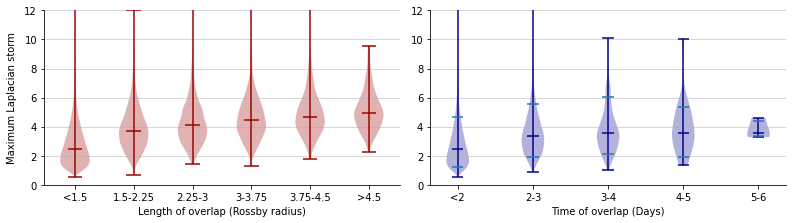

In [96]:
import pandas as pd
#import numpy as np
#from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [11.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = [lapl_storms[drStorms < 1.0],
        lapl_storms[(drStorms >= 1.0) & (drStorms < 1.5)],
        lapl_storms[(drStorms >= 1.5) & (drStorms < 2.0)],
        lapl_storms[(drStorms >= 2.0) & (drStorms < 2.5)],
        lapl_storms[(drStorms >= 2.5) & (drStorms < 3.0)],
         lapl_storms[(drStorms >= 3.0)]]
for i in range(len(data)):
    data[i] = data[i][~np.isnan(data[i])]
data2 = [lapl_storms[dtStorms < 1.0],lapl_storms[(dtStorms >= 1.0) & (dtStorms < 1.5)],
        lapl_storms[(dtStorms >= 1.5) & (dtStorms < 2.0)],
        lapl_storms[(dtStorms >= 2.0) & (dtStorms < 2.5)],
        lapl_storms[(dtStorms >= 2.5) & (dtStorms < 3.0)],
         lapl_storms[(dtStorms >= 3.0)]]

for i in range(len(data2)):
    data2[i] = data2[i][~np.isnan(data2[i])]
data3 = [lapl_storms[(dtStorms < 1.0) & (drStorms < 1.0)],
         lapl_storms[(dtStorms >= 1.0) & (dtStorms < 1.5) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 1.5) & (dtStorms < 2.0) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 2.0) & (dtStorms < 2.5) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 2.5) & (dtStorms < 3.0) & (drStorms < 1.0)],
         lapl_storms[(dtStorms >= 3.0)& (drStorms < 1.0)]]
for i in range(len(data3)):
    data3[i] = data3[i][~np.isnan(data3[i])]
    
fig, ax = plt.subplots(1,2)
vio0 = ax[0].violinplot(data,showmedians=True)
ax[0].set_xticklabels(["", "<1.5","1.5-2.25","2.25-3","3-3.75","3.75-4.5",">4.5"])
ax[0].set_xlabel("Length of overlap (Rossby radius)")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)


'''
ax[1].violinplot(data2,showmedians=True)
ax[1].set_xticklabels(["", "<2","2-3","3-4","4-5","5-6",">6"])
ax[1].set_xlabel("Time of overlap (Days)")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)

'''
vio2 = ax[1].violinplot(data3[0:5],widths=.3,showmedians=True,quantiles=[[0.1, 0.9],[0.1, 0.9],[0.1, 0.9],
                                                                         [0.1, 0.9],[0.1, 0.9]])
# Set the color of the violin patches

ax[1].set_xticklabels(["", "<2","2-3","3-4","4-5","5-6"]) #
ax[1].set_xlabel("Time of overlap (Days)")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)

#Set face colors of violin plots

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vio0[partname]
    vp.set_edgecolor("xkcd:deep red")
    vp = vio2[partname]
    vp.set_edgecolor("darkblue") 
#vio0['cmedians'].set_colors("xkcd:deep red")

for pc in vio0['bodies']:
    pc.set_facecolor("xkcd:deep red")
for pc in vio2['bodies']:
    pc.set_facecolor("darkblue")

#Add xlabel and ylabel
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian storm")

# Hide the right and top spines
for a in range(2):
    ax[a].spines[['right', 'top']].set_visible(False)
    ax[a].set_ylim(0,12)
#save Figure
plt.savefig("MaxLaplPdfSubtypes" + reschar + "_StrongestCyclones_" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + "_normalised_DJF.pdf")


In [19]:
sorted_clusters

#Define result-lists
first_time      = [None] * nrstorms
first_time_conn = [None] * nrstorms

lapl_primary    = []
lapl_secondary  = []
lapl_final = []

lapl_primary_length    = []
lapl_secondary_length  = []
lapl_final_length = []

lapl_primary_nolength    = []
lapl_secondary_nolength  = []
lapl_final_nolength = []


lapl_primary_length_Atlantic    = []
lapl_secondary_length_Atlantic  = []
lapl_final_length_Atlantic = []

lat_primary_Atlantic = []
lat_secondary_Atlantic = []
lat_final_Atlantic = []

# First time step of storms
for strm in range(nrstorms):
    tmp_time = str_dt[ids_storms[strm+1]]
    tmp_conn = str_connected[ids_storms[strm+1]]
    first_time[strm] = tmp_time[0]
    if(np.any(tmp_conn >0)):
        first_time_conn[strm] = tmp_time[tmp_conn>0][0]

first_time_conn = np.array(first_time_conn)

# All clusters
for cluster in sorted_clusters:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final.append(lapl_storms[timsort_cluster[-1]-1])

#Length clusters
for cluster in sorted_clusters_length:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary_length.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_length.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_length.append(lapl_storms[timsort_cluster[-1]-1])
        
        
#Length clusters
for cluster in sorted_clusters_nolength:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary_nolength.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_nolength.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_nolength.append(lapl_storms[timsort_cluster[-1]-1])


#Length clusters Atlantic
'''
primary_storms_Atlantic   = []
secondary_storms_Atlantic = []
for cluster in sorted_clusters_length_Atlantic:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        
        
        #Check 
        lapl_primary_length_Atlantic.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_length_Atlantic.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_length_Atlantic.append(lapl_storms[timsort_cluster[-1]-1])
        
        primary_storms_Atlantic.append(timsort_cluster[0]-1)
        secondary_storms_Atlantic.extend(timsort_cluster[1:-1]-1)
'''


[4, 26, 28, 31, 38, 48]
[26 28 31  4 38 48]
[17, 39, 70, 78, 95]
[17 39 78 70 95]
[18, 37, 52, 96, 103]
[ 18  37  52  96 103]
[19, 41, 50]
[19 50 41]
[73, 89, 112]
[ 73  89 112]
[102, 113, 126, 137]
[102 113 126 137]
[209, 217, 259]
[209 217 259]
[232, 241, 246]
[232 241 246]
[235, 251, 258]
[235 251 258]
[236, 238, 260]
[236 238 260]
[280, 295, 316, 323]
[280 295 316 323]
[308, 355, 362, 377]
[308 355 362 377]
[336, 366, 396, 397, 409]
[336 366 396 397 409]
[407, 408, 429, 452, 465]
[408 407 429 452 465]
[414, 433, 464, 482]
[414 433 464 482]
[417, 432, 438, 442, 468, 474]
[417 432 438 442 468 474]
[437, 455, 470, 476, 510, 535]
[437 455 470 476 510 535]
[479, 489, 495]
[479 495 489]
[569, 571, 615]
[571 569 615]
[581, 601, 628, 636]
[581 601 628 636]
[608, 644, 646]
[608 644 646]
[618, 651, 657, 669, 693]
[618 651 669 657 693]
[731, 765, 772, 790, 802]
[731 765 772 790 802]
[747, 767, 776]
[747 767 776]
[780, 822, 838, 842]
[780 822 838 842]
[831, 860, 881, 892, 916, 922]
[831 860 88

[24161, 24223, 24228, 24234, 24242, 24244, 24250]
[24161 24223 24228 24242 24244 24250 24234]
[24183, 24204, 24209, 24215]
[24183 24204 24209 24215]
[24200, 24207, 24214]
[24200 24207 24214]
[24203, 24208, 24227]
[24208 24203 24227]
[24230, 24251, 24287]
[24251 24230 24287]
[24238, 24256, 24261, 24269]
[24238 24256 24261 24269]
[24260, 24274, 24291]
[24260 24274 24291]
[24262, 24272, 24288, 24289, 24314]
[24272 24288 24262 24314 24289]
[24268, 24308, 24313]
[24268 24313 24308]
[24277, 24305, 24332]
[24305 24277 24332]
[24319, 24323, 24339]
[24319 24323 24339]
[24383, 24387, 24413]
[24383 24387 24413]
[24416, 24431, 24434]
[24416 24431 24434]
[24437, 24444, 24446, 24474, 24487]
[24437 24444 24446 24474 24487]
[24486, 24512, 24522]
[24512 24486 24522]
[24490, 24535, 24548, 24555, 24561, 24570, 24575, 24592]
[24490 24535 24548 24555 24561 24570 24592 24575]
[24524, 24562, 24578, 24588]
[24524 24562 24578 24588]
[24587, 24615, 24624]
[24587 24615 24624]
[24597, 24617, 24625, 24642]
[24597 

[47258 47279 47300 47305 47327 47330]
[47265, 47290, 47291, 47398]
[47265 47290 47291 47398]
[47272, 47282, 47284, 47318, 47321, 47334]
[47284 47272 47282 47318 47321 47334]
[47287, 47294, 47307]
[47287 47294 47307]
[47337, 47359, 47366, 47378]
[47337 47359 47378 47366]
[47344, 47371, 47385, 47413]
[47371 47344 47385 47413]
[47355, 47369, 47406, 47447, 47462, 47491, 47532]
[47355 47369 47406 47447 47462 47491 47532]
[47368, 47384, 47424, 47426]
[47368 47426 47424 47384]
[47372, 47373, 47387, 47433, 47436]
[47372 47387 47373 47433 47436]
[47380, 47388, 47404]
[47388 47380 47404]
[47393, 47427, 47432]
[47393 47427 47432]
[47418, 47451, 47468, 47476, 47485]
[47418 47451 47468 47476 47485]
[47430, 47431, 47450]
[47430 47431 47450]
[47455, 47471, 47482]
[47455 47471 47482]
[47459, 47466, 47467, 47481, 47486, 47496]
[47466 47459 47481 47467 47486 47496]
[47463, 47470, 47475, 47488]
[47463 47470 47475 47488]
[47480, 47494, 47495, 47504]
[47480 47494 47495 47504]
[47506, 47525, 47534, 47557, 4

[73035 73049 73092]
[73080, 73090, 73091, 73131, 73140, 73191, 73230, 73242, 73264]
[73080 73091 73090 73131 73140 73191 73230 73242 73264]
[73086, 73108, 73125]
[73108 73086 73125]
[73093, 73112, 73132, 73149]
[73093 73112 73132 73149]
[73104, 73114, 73118, 73123, 73130, 73150, 73151, 73163, 73187, 73196, 73218, 73252]
[73104 73118 73123 73130 73114 73151 73150 73163 73187 73196 73218 73252]
[73117, 73144, 73152, 73207, 73291, 73300]
[73117 73144 73152 73207 73291 73300]
[73129, 73135, 73148]
[73129 73135 73148]
[73157, 73158, 73182, 73257]
[73157 73158 73182 73257]
[73179, 73195, 73208]
[73179 73195 73208]
[73256, 73263, 73280, 73287]
[73256 73263 73280 73287]
[73283, 73286, 73288, 73304]
[73283 73288 73286 73304]
[73307, 73311, 73325]
[73307 73311 73325]
[73320, 73321, 73337, 73338]
[73321 73337 73338 73320]
[73333, 73395, 73447, 73450, 73476, 73478, 73501]
[73395 73333 73447 73450 73476 73478 73501]
[73345, 73347, 73376]
[73345 73347 73376]
[73349, 73352, 73363]
[73352 73349 73363]

[108031, 108058, 108064]
[108031 108064 108058]
[108035, 108059, 108063]
[108035 108059 108063]
[108043, 108061, 108062, 108066]
[108043 108061 108066 108062]
[108079, 108122, 108129, 108138, 108163]
[108079 108122 108129 108138 108163]
[108097, 108105, 108134]
[108097 108105 108134]
[108125, 108153, 108161, 108162]
[108153 108125 108161 108162]
[108143, 108152, 108176, 108182, 108183, 108192, 108198, 108212, 108226, 108236, 108259, 108264, 108265, 108281]
[108143 108152 108182 108183 108192 108176 108198 108212 108236 108226
 108264 108265 108259 108281]
[108154, 108170, 108180]
[108154 108170 108180]
[108249, 108267, 108313]
[108249 108267 108313]
[108288, 108297, 108333, 108339]
[108288 108297 108333 108339]
[108302, 108319, 108322]
[108302 108322 108319]
[108318, 108326, 108327, 108343]
[108318 108326 108327 108343]
[108366, 108381, 108404, 108431]
[108366 108381 108404 108431]
[108378, 108382, 108423, 108452, 108460, 108482, 108491]
[108378 108382 108423 108452 108460 108482 10849

[19604 19616 19631 19635 19658]
[19629, 19693, 19720]
[19629 19693 19720]
[19706, 19709, 19718]
[19706 19709 19718]
[19797, 19809, 19826, 19834, 19899]
[19797 19809 19834 19826 19899]
[19802, 19818, 19824, 19847, 19865]
[19802 19818 19824 19847 19865]
[19866, 19869, 19885]
[19866 19869 19885]
[19975, 19978, 19988]
[19975 19978 19988]
[19995, 20002, 20005, 20022]
[19995 20002 20005 20022]
[20059, 20076, 20100]
[20059 20076 20100]
[20064, 20130, 20188]
[20064 20130 20188]
[20132, 20151, 20178]
[20132 20151 20178]
[20187, 20199, 20207, 20223]
[20187 20199 20207 20223]
[20213, 20226, 20256]
[20213 20226 20256]
[20333, 20337, 20366, 20375, 20393]
[20337 20333 20366 20375 20393]
[20339, 20340, 20358, 20391, 20433, 20444]
[20339 20358 20340 20391 20433 20444]
[20343, 20369, 20373]
[20343 20369 20373]
[20427, 20443, 20462]
[20427 20443 20462]
[20478, 20515, 20543]
[20478 20515 20543]
[20521, 20538, 20553, 20614, 20632]
[20521 20538 20553 20614 20632]
[20556, 20565, 20641, 20671, 20679, 20719]


[67997 68059 68072 68093]
[68018, 68031, 68038]
[68018 68038 68031]
[68073, 68089, 68128]
[68073 68089 68128]
[68076, 68077, 68092]
[68076 68077 68092]
[68111, 68123, 68134]
[68111 68123 68134]
[68131, 68140, 68146, 68165]
[68131 68146 68140 68165]
[68154, 68158, 68163, 68169, 68189]
[68154 68163 68158 68169 68189]
[68164, 68185, 68201, 68208, 68222, 68233, 68241, 68270, 68291, 68322, 68335]
[68164 68185 68201 68208 68222 68233 68241 68270 68291 68322 68335]
[68177, 68182, 68210]
[68177 68182 68210]
[68190, 68209, 68243]
[68190 68209 68243]
[68215, 68218, 68224, 68226]
[68218 68215 68224 68226]
[68282, 68285, 68286, 68297]
[68282 68286 68285 68297]
[68298, 68301, 68303, 68311]
[68298 68301 68303 68311]
[68355, 68364, 68377]
[68355 68364 68377]
[68363, 68365, 68367, 68493]
[68367 68363 68365 68493]
[68484, 68505, 68512, 68526, 68530, 68549, 68566, 68574, 68582, 68605, 68629, 68634]
[68484 68505 68512 68526 68530 68566 68574 68582 68605 68549 68629 68634]
[68533, 68543, 68548, 68555, 685

[108438 108470 108456 108473 108489 108498 108504]
[108571, 108578, 108589]
[108571 108578 108589]
[108600, 108626, 108643]
[108600 108626 108643]
[108623, 108641, 108658]
[108623 108641 108658]
[108677, 108711, 108722]
[108677 108711 108722]
[108689, 108709, 108717]
[108689 108709 108717]
[108735, 108755, 108762]
[108735 108755 108762]
[108768, 108774, 108795]
[108768 108774 108795]
[108821, 108844, 108855]
[108821 108844 108855]
[108831, 108836, 108843, 108845, 108858, 108859]
[108831 108836 108843 108845 108858 108859]
[108848, 108856, 108864, 108891, 108895, 108900]
[108848 108856 108864 108891 108895 108900]
[108893, 108916, 108926]
[108893 108916 108926]
[108914, 108931, 108948]
[108914 108931 108948]
[109037, 109045, 109058, 109060, 109088, 109100]
[109037 109045 109058 109060 109088 109100]
[109062, 109063, 109076, 109093]
[109063 109076 109062 109093]
[109075, 109080, 109086]
[109075 109080 109086]
[109113, 109130, 109165, 109190]
[109113 109130 109165 109190]
[109126, 109145,

[96153, 96190, 96197]
[96153 96190 96197]
[96191, 96205, 96215]
[96191 96205 96215]
[96686, 96714, 96719]
[96686 96714 96719]
[96688, 96695, 96740]
[96688 96695 96740]
[96779, 96780, 96781]
[96779 96780 96781]
[96835, 96844, 96852, 96854]
[96835 96844 96852 96854]
[96919, 96922, 96934, 96946, 96970]
[96922 96934 96919 96946 96970]
[96953, 96965, 96975]
[96953 96965 96975]
[96991, 97018, 97022]
[96991 97018 97022]
[97060, 97063, 97091]
[97060 97063 97091]
[97286, 97293, 97301]
[97286 97293 97301]
[97379, 97384, 97395]
[97379 97384 97395]
[97516, 97525, 97526, 97533, 97555]
[97516 97526 97525 97533 97555]
[97825, 97826, 97840]
[97825 97840 97826]
[97934, 97947, 97996, 98021]
[97934 97947 97996 98021]
[98006, 98010, 98058]
[98006 98010 98058]
[98204, 98260, 98276, 98318]
[98204 98260 98276 98318]
[98334, 98340, 98351, 98353, 98359, 98382, 98411, 98422]
[98334 98340 98351 98353 98359 98382 98411 98422]
[98478, 98489, 98503]
[98478 98489 98503]
[98544, 98621, 98689]
[98544 98621 98689]
[985

'\nprimary_storms_Atlantic   = []\nsecondary_storms_Atlantic = []\nfor cluster in sorted_clusters_length_Atlantic:\n    if(len(cluster)>=3):\n        print(cluster)\n        \n        cluster = np.array(cluster)\n        \n        #Find primary cyclone            \n        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]\n        print(timsort_cluster)\n        \n        \n        #Check \n        lapl_primary_length_Atlantic.append(lapl_storms[timsort_cluster[0]-1])\n        lapl_secondary_length_Atlantic.extend(lapl_storms[timsort_cluster[1:-1]-1])\n        lapl_final_length_Atlantic.append(lapl_storms[timsort_cluster[-1]-1])\n        \n        primary_storms_Atlantic.append(timsort_cluster[0]-1)\n        secondary_storms_Atlantic.extend(timsort_cluster[1:-1]-1)\n'

In [20]:
first_time_conn[cluster-1]


TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [117]:
#cluster[timsort_cluster][0]
print(np.nanmean(lapl_primary_length))
print(np.nanmean(lapl_secondary_length))
print(np.nanmean(lapl_final_length_Atlantic))
#lapl_storms[timsort_cluster[1:]-1]

3.358857908847185
3.4155570822162646
3.4960512820512823


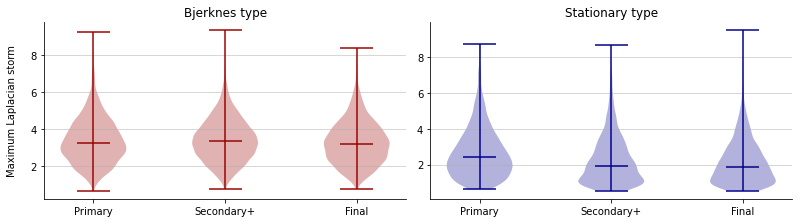

In [22]:
#Strength within a cluster
dataStrength_primary = [lapl_primary,lapl_secondary,lapl_final]
dataStrength_primary_length = [lapl_primary_length,lapl_secondary_length,lapl_final_length]
dataStrength_primary_nolength = [lapl_primary_nolength,lapl_secondary_nolength,lapl_final_nolength]

# Set the figure size
plt.rcParams["figure.figsize"] = [11.50, 3.50]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,2)
'''
vio0 = ax[0].violinplot(dataStrength_primary,showmedians=True)
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels([ "Primary","Secondary+","Final"])
ax[0].set_xlabel("")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)
ax[0].set_title("All")
'''


#vio2 = ax[2].violinplot(data3,widths=.3,showmedians=True)
vio1 = ax[0].violinplot(dataStrength_primary_length,showmedians=True)
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(["Primary","Secondary+","Final"])
ax[0].set_xlabel("")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)
ax[0].set_title("Bjerknes type")

vio2 = ax[1].violinplot(dataStrength_primary_nolength,showmedians=True)
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels([ "Primary","Secondary+","Final"])
ax[1].set_xlabel("")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)
ax[1].set_title("Stationary type")

#Set face colors of violin plots
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vio1[partname]
    vp.set_edgecolor("xkcd:deep red")
    vp = vio2[partname]
    vp.set_edgecolor("darkblue") 
#vio0['cmedians'].set_colors("xkcd:deep red")

for pc in vio1['bodies']:
    pc.set_facecolor("xkcd:deep red")
for pc in vio2['bodies']:
    pc.set_facecolor("darkblue")

#Add xlabel and ylabel
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian storm")

# Hide the right and top spines
for a in range(2):
    ax[a].spines[['right', 'top']].set_visible(False)

#save Figure
plt.savefig("MaxLaplPdfSubtypes" + reschar + "_WithinCluster_" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + ".pdf")



In [6]:
# strength of storms
lapl_storms = np.zeros(nrstorms)
for strm in range(nrstorms):
    lapl_storms[strm] = np.nanmax(str_lapl[ids_storms[strm+1]])

In [10]:
ids = [x-1 for clust in sorted_clusters for x in clust if len(clust) >= 2]
thresh = np.quantile(lapl_storms,0.95)
ids_clust = [x-1 for clust in sorted_clusters_Atlantic for x in clust if (len(clust) >= 2) & (lapl_storms[x-1]>=thresh)]
ids_nonclust = [x-1 for clust in sorted_clusters_Atlantic for x in clust if (len(clust) < 2) & (lapl_storms[x-1]>=thresh)]

print(len(ids_clust)/(len(ids_clust) + len(ids_nonclust)))
#(len(ids)/nrstorms)

0.6194225721784777


In [11]:
# strength of storms
str_lon2 = np.array([(x - 360) if x>180 else x for x in str_lon])
lat_storms = np.zeros(nrstorms)
lon_storms = np.zeros(nrstorms)
lat_storms_conn = np.zeros(nrstorms)
for strm in range(nrstorms):
    lat_storms[strm] = np.nanmean(str_lat[ids_storms[strm+1]])
    lon_storms[strm] = np.nanmean(str_lon2[ids_storms[strm+1]])


In [18]:
ids_clust

[385,
 464,
 468,
 518,
 2840,
 2843,
 2994,
 3157,
 3255,
 3426,
 3454,
 3518,
 3675,
 3698,
 3707,
 3728,
 3756,
 3901,
 3904,
 3906,
 3907,
 3929,
 3963,
 3964,
 4223,
 6335,
 6339,
 6498,
 6643,
 6924,
 6999,
 7070,
 7289,
 7441,
 9242,
 9569,
 9773,
 9839,
 9946,
 9949,
 10054,
 10204,
 10217,
 10264,
 10316,
 10338,
 10424,
 10435,
 10447,
 10507,
 10610,
 10838,
 12691,
 12740,
 12718,
 12851,
 12861,
 12971,
 13003,
 13127,
 13289,
 13360,
 13479,
 13683,
 14093,
 15946,
 15999,
 16089,
 16124,
 16145,
 16474,
 16600,
 16716,
 16787,
 16806,
 16829,
 16843,
 16881,
 16890,
 16966,
 17025,
 17028,
 17073,
 17179,
 17184,
 17325,
 19540,
 19628,
 20226,
 20358,
 20370,
 20461,
 20669,
 20698,
 20717,
 20826,
 22809,
 22900,
 23003,
 23304,
 23367,
 23406,
 23415,
 23480,
 23516,
 23547,
 23647,
 23664,
 23875,
 23975,
 24109,
 24175,
 24202,
 24261,
 26121,
 26211,
 26385,
 26437,
 26458,
 26497,
 26554,
 26614,
 26726,
 26732,
 26744,
 26826,
 26917,
 27188,
 27265,
 27396,
 294

In [144]:
ids_storms[12]

(array([141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158]),)

In [71]:
len(sorted_clusters)

111631

In [7]:
######################################################
# Check which basin storms and clusters belong to
######################################################
ext_winter = np.array([(x.month <= 3) | (x.month >= 10) for x in str_dt])
ext_swinter = np.array([(x.month >= 4) & (x.month <= 9) for x in str_dt])

checkBasin = True
if(checkBasin):
    str_basin_exit = np.full(np.nanmax(str_id),"Undefined")
    
    #Check for basin for each storm
    for strm in uniq_ids:
        print("Strm " + str(strm))
        #selidxs = (str_id == strm) #& (str_connected == True)
        lon_temp = str_lon[ids_storms[strm]] 
        lat_temp = str_lat[ids_storms[strm]] 
        dt_temp = str_dt[ids_storms[strm]] 
        wint_temp = ext_winter[ids_storms[strm]]
        swint_temp = ext_swinter[ids_storms[strm]]
        lapl_temp = str_lapl[ids_storms[strm]]
        #conn_temp = str_connected[ids_storms[strm]]
        
        #if(np.any(conn_temp !=0)):
        #    str_first[strm -1] = np.nanmin(dt_temp[conn_temp >0])
        nr_Atlantic = np.nansum(((lon_temp >= 345) | (lon_temp <= 10)) & (lat_temp >= 50) & (lat_temp <= 75) & (wint_temp == True) )
        nr_Pacific = np.nansum((lon_temp >= 210) & (lon_temp <= 240) & (lat_temp >= 40) & (lat_temp <= 65) & (wint_temp == True) )
   
        if( nr_Atlantic/len(lon_temp) >= 0.5):
            str_basin_exit[strm -1] = "Atlantic"

        if( nr_Pacific/len(lon_temp) >= 0.5):
            str_basin_exit[strm -1] = "Pacific"


Strm 1
Strm 2
Strm 3
Strm 4
Strm 5
Strm 6
Strm 7
Strm 8
Strm 9
Strm 10
Strm 11
Strm 12
Strm 13
Strm 14
Strm 15
Strm 16
Strm 17
Strm 18
Strm 19
Strm 20
Strm 21
Strm 22
Strm 23
Strm 24
Strm 25
Strm 26
Strm 27
Strm 28
Strm 29
Strm 30
Strm 31
Strm 32
Strm 33
Strm 34
Strm 35
Strm 36
Strm 37
Strm 38
Strm 39
Strm 40
Strm 41
Strm 42
Strm 43
Strm 44
Strm 45
Strm 46
Strm 47
Strm 48
Strm 49
Strm 50
Strm 51
Strm 52
Strm 53
Strm 54
Strm 55
Strm 56
Strm 57
Strm 58
Strm 59
Strm 60
Strm 61
Strm 62
Strm 63
Strm 64
Strm 65
Strm 66
Strm 67
Strm 68
Strm 69
Strm 70
Strm 71
Strm 72
Strm 73
Strm 74
Strm 75
Strm 76
Strm 77
Strm 78
Strm 79
Strm 80
Strm 81
Strm 82
Strm 83
Strm 84
Strm 85
Strm 86
Strm 87
Strm 88
Strm 89
Strm 90
Strm 91
Strm 92
Strm 93
Strm 94
Strm 95
Strm 96
Strm 97
Strm 98
Strm 99
Strm 100
Strm 101
Strm 102
Strm 103
Strm 104
Strm 105
Strm 106
Strm 107
Strm 108
Strm 109
Strm 110
Strm 111
Strm 112
Strm 113
Strm 114
Strm 115
Strm 116
Strm 117
Strm 118
Strm 119
Strm 120
Strm 121
Strm 122
Strm 123
S

Strm 1601
Strm 1602
Strm 1603
Strm 1604
Strm 1605
Strm 1606
Strm 1607
Strm 1608
Strm 1609
Strm 1610
Strm 1611
Strm 1612
Strm 1613
Strm 1614
Strm 1615
Strm 1616
Strm 1617
Strm 1618
Strm 1619
Strm 1620
Strm 1621
Strm 1622
Strm 1623
Strm 1624
Strm 1625
Strm 1626
Strm 1627
Strm 1628
Strm 1629
Strm 1630
Strm 1631
Strm 1632
Strm 1633
Strm 1634
Strm 1635
Strm 1636
Strm 1637
Strm 1638
Strm 1639
Strm 1640
Strm 1641
Strm 1642
Strm 1643
Strm 1644
Strm 1645
Strm 1646
Strm 1647
Strm 1648
Strm 1649
Strm 1650
Strm 1651
Strm 1652
Strm 1653
Strm 1654
Strm 1655
Strm 1656
Strm 1657
Strm 1658
Strm 1659
Strm 1660
Strm 1661
Strm 1662
Strm 1663
Strm 1664
Strm 1665
Strm 1666
Strm 1667
Strm 1668
Strm 1669
Strm 1670
Strm 1671
Strm 1672
Strm 1673
Strm 1674
Strm 1675
Strm 1676
Strm 1677
Strm 1678
Strm 1679
Strm 1680
Strm 1681
Strm 1682
Strm 1683
Strm 1684
Strm 1685
Strm 1686
Strm 1687
Strm 1688
Strm 1689
Strm 1690
Strm 1691
Strm 1692
Strm 1693
Strm 1694
Strm 1695
Strm 1696
Strm 1697
Strm 1698
Strm 1699
Strm 1700


Strm 3034
Strm 3035
Strm 3036
Strm 3037
Strm 3038
Strm 3039
Strm 3040
Strm 3041
Strm 3042
Strm 3043
Strm 3044
Strm 3045
Strm 3046
Strm 3047
Strm 3048
Strm 3049
Strm 3050
Strm 3051
Strm 3052
Strm 3053
Strm 3054
Strm 3055
Strm 3056
Strm 3057
Strm 3058
Strm 3059
Strm 3060
Strm 3061
Strm 3062
Strm 3063
Strm 3064
Strm 3065
Strm 3066
Strm 3067
Strm 3068
Strm 3069
Strm 3070
Strm 3071
Strm 3072
Strm 3073
Strm 3074
Strm 3075
Strm 3076
Strm 3077
Strm 3078
Strm 3079
Strm 3080
Strm 3081
Strm 3082
Strm 3083
Strm 3084
Strm 3085
Strm 3086
Strm 3087
Strm 3088
Strm 3089
Strm 3090
Strm 3091
Strm 3092
Strm 3093
Strm 3094
Strm 3095
Strm 3096
Strm 3097
Strm 3098
Strm 3099
Strm 3100
Strm 3101
Strm 3102
Strm 3103
Strm 3104
Strm 3105
Strm 3106
Strm 3107
Strm 3108
Strm 3109
Strm 3110
Strm 3111
Strm 3112
Strm 3113
Strm 3114
Strm 3115
Strm 3116
Strm 3117
Strm 3118
Strm 3119
Strm 3120
Strm 3121
Strm 3122
Strm 3123
Strm 3124
Strm 3125
Strm 3126
Strm 3127
Strm 3128
Strm 3129
Strm 3130
Strm 3131
Strm 3132
Strm 3133


Strm 4317
Strm 4318
Strm 4319
Strm 4320
Strm 4321
Strm 4322
Strm 4323
Strm 4324
Strm 4325
Strm 4326
Strm 4327
Strm 4328
Strm 4329
Strm 4330
Strm 4331
Strm 4332
Strm 4333
Strm 4334
Strm 4335
Strm 4336
Strm 4337
Strm 4338
Strm 4339
Strm 4340
Strm 4341
Strm 4342
Strm 4343
Strm 4344
Strm 4345
Strm 4346
Strm 4347
Strm 4348
Strm 4349
Strm 4350
Strm 4351
Strm 4352
Strm 4353
Strm 4354
Strm 4355
Strm 4356
Strm 4357
Strm 4358
Strm 4359
Strm 4360
Strm 4361
Strm 4362
Strm 4363
Strm 4364
Strm 4365
Strm 4366
Strm 4367
Strm 4368
Strm 4369
Strm 4370
Strm 4371
Strm 4372
Strm 4373
Strm 4374
Strm 4375
Strm 4376
Strm 4377
Strm 4378
Strm 4379
Strm 4380
Strm 4381
Strm 4382
Strm 4383
Strm 4384
Strm 4385
Strm 4386
Strm 4387
Strm 4388
Strm 4389
Strm 4390
Strm 4391
Strm 4392
Strm 4393
Strm 4394
Strm 4395
Strm 4396
Strm 4397
Strm 4398
Strm 4399
Strm 4400
Strm 4401
Strm 4402
Strm 4403
Strm 4404
Strm 4405
Strm 4406
Strm 4407
Strm 4408
Strm 4409
Strm 4410
Strm 4411
Strm 4412
Strm 4413
Strm 4414
Strm 4415
Strm 4416


Strm 5369
Strm 5370
Strm 5371
Strm 5372
Strm 5373
Strm 5374
Strm 5375
Strm 5376
Strm 5377
Strm 5378
Strm 5379
Strm 5380
Strm 5381
Strm 5382
Strm 5383
Strm 5384
Strm 5385
Strm 5386
Strm 5387
Strm 5388
Strm 5389
Strm 5390
Strm 5391
Strm 5392
Strm 5393
Strm 5394
Strm 5395
Strm 5396
Strm 5397
Strm 5398
Strm 5399
Strm 5400
Strm 5401
Strm 5402
Strm 5403
Strm 5404
Strm 5405
Strm 5406
Strm 5407
Strm 5408
Strm 5409
Strm 5410
Strm 5411
Strm 5412
Strm 5413
Strm 5414
Strm 5415
Strm 5416
Strm 5417
Strm 5418
Strm 5419
Strm 5420
Strm 5421
Strm 5422
Strm 5423
Strm 5424
Strm 5425
Strm 5426
Strm 5427
Strm 5428
Strm 5429
Strm 5430
Strm 5431
Strm 5432
Strm 5433
Strm 5434
Strm 5435
Strm 5436
Strm 5437
Strm 5438
Strm 5439
Strm 5440
Strm 5441
Strm 5442
Strm 5443
Strm 5444
Strm 5445
Strm 5446
Strm 5447
Strm 5448
Strm 5449
Strm 5450
Strm 5451
Strm 5452
Strm 5453
Strm 5454
Strm 5455
Strm 5456
Strm 5457
Strm 5458
Strm 5459
Strm 5460
Strm 5461
Strm 5462
Strm 5463
Strm 5464
Strm 5465
Strm 5466
Strm 5467
Strm 5468


Strm 6799
Strm 6800
Strm 6801
Strm 6802
Strm 6803
Strm 6804
Strm 6805
Strm 6806
Strm 6807
Strm 6808
Strm 6809
Strm 6810
Strm 6811
Strm 6812
Strm 6813
Strm 6814
Strm 6815
Strm 6816
Strm 6817
Strm 6818
Strm 6819
Strm 6820
Strm 6821
Strm 6822
Strm 6823
Strm 6824
Strm 6825
Strm 6826
Strm 6827
Strm 6828
Strm 6829
Strm 6830
Strm 6831
Strm 6832
Strm 6833
Strm 6834
Strm 6835
Strm 6836
Strm 6837
Strm 6838
Strm 6839
Strm 6840
Strm 6841
Strm 6842
Strm 6843
Strm 6844
Strm 6845
Strm 6846
Strm 6847
Strm 6848
Strm 6849
Strm 6850
Strm 6851
Strm 6852
Strm 6853
Strm 6854
Strm 6855
Strm 6856
Strm 6857
Strm 6858
Strm 6859
Strm 6860
Strm 6861
Strm 6862
Strm 6863
Strm 6864
Strm 6865
Strm 6866
Strm 6867
Strm 6868
Strm 6869
Strm 6870
Strm 6871
Strm 6872
Strm 6873
Strm 6874
Strm 6875
Strm 6876
Strm 6877
Strm 6878
Strm 6879
Strm 6880
Strm 6881
Strm 6882
Strm 6883
Strm 6884
Strm 6885
Strm 6886
Strm 6887
Strm 6888
Strm 6889
Strm 6890
Strm 6891
Strm 6892
Strm 6893
Strm 6894
Strm 6895
Strm 6896
Strm 6897
Strm 6898


Strm 8417
Strm 8418
Strm 8419
Strm 8420
Strm 8421
Strm 8422
Strm 8423
Strm 8424
Strm 8425
Strm 8426
Strm 8427
Strm 8428
Strm 8429
Strm 8430
Strm 8431
Strm 8432
Strm 8433
Strm 8434
Strm 8435
Strm 8436
Strm 8437
Strm 8438
Strm 8439
Strm 8440
Strm 8441
Strm 8442
Strm 8443
Strm 8444
Strm 8445
Strm 8446
Strm 8447
Strm 8448
Strm 8449
Strm 8450
Strm 8451
Strm 8452
Strm 8453
Strm 8454
Strm 8455
Strm 8456
Strm 8457
Strm 8458
Strm 8459
Strm 8460
Strm 8461
Strm 8462
Strm 8463
Strm 8464
Strm 8465
Strm 8466
Strm 8467
Strm 8468
Strm 8469
Strm 8470
Strm 8471
Strm 8472
Strm 8473
Strm 8474
Strm 8475
Strm 8476
Strm 8477
Strm 8478
Strm 8479
Strm 8480
Strm 8481
Strm 8482
Strm 8483
Strm 8484
Strm 8485
Strm 8486
Strm 8487
Strm 8488
Strm 8489
Strm 8490
Strm 8491
Strm 8492
Strm 8493
Strm 8494
Strm 8495
Strm 8496
Strm 8497
Strm 8498
Strm 8499
Strm 8500
Strm 8501
Strm 8502
Strm 8503
Strm 8504
Strm 8505
Strm 8506
Strm 8507
Strm 8508
Strm 8509
Strm 8510
Strm 8511
Strm 8512
Strm 8513
Strm 8514
Strm 8515
Strm 8516


Strm 10115
Strm 10116
Strm 10117
Strm 10118
Strm 10119
Strm 10120
Strm 10121
Strm 10122
Strm 10123
Strm 10124
Strm 10125
Strm 10126
Strm 10127
Strm 10128
Strm 10129
Strm 10130
Strm 10131
Strm 10132
Strm 10133
Strm 10134
Strm 10135
Strm 10136
Strm 10137
Strm 10138
Strm 10139
Strm 10140
Strm 10141
Strm 10142
Strm 10143
Strm 10144
Strm 10145
Strm 10146
Strm 10147
Strm 10148
Strm 10149
Strm 10150
Strm 10151
Strm 10152
Strm 10153
Strm 10154
Strm 10155
Strm 10156
Strm 10157
Strm 10158
Strm 10159
Strm 10160
Strm 10161
Strm 10162
Strm 10163
Strm 10164
Strm 10165
Strm 10166
Strm 10167
Strm 10168
Strm 10169
Strm 10170
Strm 10171
Strm 10172
Strm 10173
Strm 10174
Strm 10175
Strm 10176
Strm 10177
Strm 10178
Strm 10179
Strm 10180
Strm 10181
Strm 10182
Strm 10183
Strm 10184
Strm 10185
Strm 10186
Strm 10187
Strm 10188
Strm 10189
Strm 10190
Strm 10191
Strm 10192
Strm 10193
Strm 10194
Strm 10195
Strm 10196
Strm 10197
Strm 10198
Strm 10199
Strm 10200
Strm 10201
Strm 10202
Strm 10203
Strm 10204
Strm 10205

Strm 11811
Strm 11812
Strm 11813
Strm 11814
Strm 11815
Strm 11816
Strm 11817
Strm 11818
Strm 11819
Strm 11820
Strm 11821
Strm 11822
Strm 11823
Strm 11824
Strm 11825
Strm 11826
Strm 11827
Strm 11828
Strm 11829
Strm 11830
Strm 11831
Strm 11832
Strm 11833
Strm 11834
Strm 11835
Strm 11836
Strm 11837
Strm 11838
Strm 11839
Strm 11840
Strm 11841
Strm 11842
Strm 11843
Strm 11844
Strm 11845
Strm 11846
Strm 11847
Strm 11848
Strm 11849
Strm 11850
Strm 11851
Strm 11852
Strm 11853
Strm 11854
Strm 11855
Strm 11856
Strm 11857
Strm 11858
Strm 11859
Strm 11860
Strm 11861
Strm 11862
Strm 11863
Strm 11864
Strm 11865
Strm 11866
Strm 11867
Strm 11868
Strm 11869
Strm 11870
Strm 11871
Strm 11872
Strm 11873
Strm 11874
Strm 11875
Strm 11876
Strm 11877
Strm 11878
Strm 11879
Strm 11880
Strm 11881
Strm 11882
Strm 11883
Strm 11884
Strm 11885
Strm 11886
Strm 11887
Strm 11888
Strm 11889
Strm 11890
Strm 11891
Strm 11892
Strm 11893
Strm 11894
Strm 11895
Strm 11896
Strm 11897
Strm 11898
Strm 11899
Strm 11900
Strm 11901

Strm 13503
Strm 13504
Strm 13505
Strm 13506
Strm 13507
Strm 13508
Strm 13509
Strm 13510
Strm 13511
Strm 13512
Strm 13513
Strm 13514
Strm 13515
Strm 13516
Strm 13517
Strm 13518
Strm 13519
Strm 13520
Strm 13521
Strm 13522
Strm 13523
Strm 13524
Strm 13525
Strm 13526
Strm 13527
Strm 13528
Strm 13529
Strm 13530
Strm 13531
Strm 13532
Strm 13533
Strm 13534
Strm 13535
Strm 13536
Strm 13537
Strm 13538
Strm 13539
Strm 13540
Strm 13541
Strm 13542
Strm 13543
Strm 13544
Strm 13545
Strm 13546
Strm 13547
Strm 13548
Strm 13549
Strm 13550
Strm 13551
Strm 13552
Strm 13553
Strm 13554
Strm 13555
Strm 13556
Strm 13557
Strm 13558
Strm 13559
Strm 13560
Strm 13561
Strm 13562
Strm 13563
Strm 13564
Strm 13565
Strm 13566
Strm 13567
Strm 13568
Strm 13569
Strm 13570
Strm 13571
Strm 13572
Strm 13573
Strm 13574
Strm 13575
Strm 13576
Strm 13577
Strm 13578
Strm 13579
Strm 13580
Strm 13581
Strm 13582
Strm 13583
Strm 13584
Strm 13585
Strm 13586
Strm 13587
Strm 13588
Strm 13589
Strm 13590
Strm 13591
Strm 13592
Strm 13593

Strm 15203
Strm 15204
Strm 15205
Strm 15206
Strm 15207
Strm 15208
Strm 15209
Strm 15210
Strm 15211
Strm 15212
Strm 15213
Strm 15214
Strm 15215
Strm 15216
Strm 15217
Strm 15218
Strm 15219
Strm 15220
Strm 15221
Strm 15222
Strm 15223
Strm 15224
Strm 15225
Strm 15226
Strm 15227
Strm 15228
Strm 15229
Strm 15230
Strm 15231
Strm 15232
Strm 15233
Strm 15234
Strm 15235
Strm 15236
Strm 15237
Strm 15238
Strm 15239
Strm 15240
Strm 15241
Strm 15242
Strm 15243
Strm 15244
Strm 15245
Strm 15246
Strm 15247
Strm 15248
Strm 15249
Strm 15250
Strm 15251
Strm 15252
Strm 15253
Strm 15254
Strm 15255
Strm 15256
Strm 15257
Strm 15258
Strm 15259
Strm 15260
Strm 15261
Strm 15262
Strm 15263
Strm 15264
Strm 15265
Strm 15266
Strm 15267
Strm 15268
Strm 15269
Strm 15270
Strm 15271
Strm 15272
Strm 15273
Strm 15274
Strm 15275
Strm 15276
Strm 15277
Strm 15278
Strm 15279
Strm 15280
Strm 15281
Strm 15282
Strm 15283
Strm 15284
Strm 15285
Strm 15286
Strm 15287
Strm 15288
Strm 15289
Strm 15290
Strm 15291
Strm 15292
Strm 15293

Strm 16900
Strm 16901
Strm 16902
Strm 16903
Strm 16904
Strm 16905
Strm 16906
Strm 16907
Strm 16908
Strm 16909
Strm 16910
Strm 16911
Strm 16912
Strm 16913
Strm 16914
Strm 16915
Strm 16916
Strm 16917
Strm 16918
Strm 16919
Strm 16920
Strm 16921
Strm 16922
Strm 16923
Strm 16924
Strm 16925
Strm 16926
Strm 16927
Strm 16928
Strm 16929
Strm 16930
Strm 16931
Strm 16932
Strm 16933
Strm 16934
Strm 16935
Strm 16936
Strm 16937
Strm 16938
Strm 16939
Strm 16940
Strm 16941
Strm 16942
Strm 16943
Strm 16944
Strm 16945
Strm 16946
Strm 16947
Strm 16948
Strm 16949
Strm 16950
Strm 16951
Strm 16952
Strm 16953
Strm 16954
Strm 16955
Strm 16956
Strm 16957
Strm 16958
Strm 16959
Strm 16960
Strm 16961
Strm 16962
Strm 16963
Strm 16964
Strm 16965
Strm 16966
Strm 16967
Strm 16968
Strm 16969
Strm 16970
Strm 16971
Strm 16972
Strm 16973
Strm 16974
Strm 16975
Strm 16976
Strm 16977
Strm 16978
Strm 16979
Strm 16980
Strm 16981
Strm 16982
Strm 16983
Strm 16984
Strm 16985
Strm 16986
Strm 16987
Strm 16988
Strm 16989
Strm 16990

Strm 18617
Strm 18618
Strm 18619
Strm 18620
Strm 18621
Strm 18622
Strm 18623
Strm 18624
Strm 18625
Strm 18626
Strm 18627
Strm 18628
Strm 18629
Strm 18630
Strm 18631
Strm 18632
Strm 18633
Strm 18634
Strm 18635
Strm 18636
Strm 18637
Strm 18638
Strm 18639
Strm 18640
Strm 18641
Strm 18642
Strm 18643
Strm 18644
Strm 18645
Strm 18646
Strm 18647
Strm 18648
Strm 18649
Strm 18650
Strm 18651
Strm 18652
Strm 18653
Strm 18654
Strm 18655
Strm 18656
Strm 18657
Strm 18658
Strm 18659
Strm 18660
Strm 18661
Strm 18662
Strm 18663
Strm 18664
Strm 18665
Strm 18666
Strm 18667
Strm 18668
Strm 18669
Strm 18670
Strm 18671
Strm 18672
Strm 18673
Strm 18674
Strm 18675
Strm 18676
Strm 18677
Strm 18678
Strm 18679
Strm 18680
Strm 18681
Strm 18682
Strm 18683
Strm 18684
Strm 18685
Strm 18686
Strm 18687
Strm 18688
Strm 18689
Strm 18690
Strm 18691
Strm 18692
Strm 18693
Strm 18694
Strm 18695
Strm 18696
Strm 18697
Strm 18698
Strm 18699
Strm 18700
Strm 18701
Strm 18702
Strm 18703
Strm 18704
Strm 18705
Strm 18706
Strm 18707

Strm 20314
Strm 20315
Strm 20316
Strm 20317
Strm 20318
Strm 20319
Strm 20320
Strm 20321
Strm 20322
Strm 20323
Strm 20324
Strm 20325
Strm 20326
Strm 20327
Strm 20328
Strm 20329
Strm 20330
Strm 20331
Strm 20332
Strm 20333
Strm 20334
Strm 20335
Strm 20336
Strm 20337
Strm 20338
Strm 20339
Strm 20340
Strm 20341
Strm 20342
Strm 20343
Strm 20344
Strm 20345
Strm 20346
Strm 20347
Strm 20348
Strm 20349
Strm 20350
Strm 20351
Strm 20352
Strm 20353
Strm 20354
Strm 20355
Strm 20356
Strm 20357
Strm 20358
Strm 20359
Strm 20360
Strm 20361
Strm 20362
Strm 20363
Strm 20364
Strm 20365
Strm 20366
Strm 20367
Strm 20368
Strm 20369
Strm 20370
Strm 20371
Strm 20372
Strm 20373
Strm 20374
Strm 20375
Strm 20376
Strm 20377
Strm 20378
Strm 20379
Strm 20380
Strm 20381
Strm 20382
Strm 20383
Strm 20384
Strm 20385
Strm 20386
Strm 20387
Strm 20388
Strm 20389
Strm 20390
Strm 20391
Strm 20392
Strm 20393
Strm 20394
Strm 20395
Strm 20396
Strm 20397
Strm 20398
Strm 20399
Strm 20400
Strm 20401
Strm 20402
Strm 20403
Strm 20404

Strm 22018
Strm 22019
Strm 22020
Strm 22021
Strm 22022
Strm 22023
Strm 22024
Strm 22025
Strm 22026
Strm 22027
Strm 22028
Strm 22029
Strm 22030
Strm 22031
Strm 22032
Strm 22033
Strm 22034
Strm 22035
Strm 22036
Strm 22037
Strm 22038
Strm 22039
Strm 22040
Strm 22041
Strm 22042
Strm 22043
Strm 22044
Strm 22045
Strm 22046
Strm 22047
Strm 22048
Strm 22049
Strm 22050
Strm 22051
Strm 22052
Strm 22053
Strm 22054
Strm 22055
Strm 22056
Strm 22057
Strm 22058
Strm 22059
Strm 22060
Strm 22061
Strm 22062
Strm 22063
Strm 22064
Strm 22065
Strm 22066
Strm 22067
Strm 22068
Strm 22069
Strm 22070
Strm 22071
Strm 22072
Strm 22073
Strm 22074
Strm 22075
Strm 22076
Strm 22077
Strm 22078
Strm 22079
Strm 22080
Strm 22081
Strm 22082
Strm 22083
Strm 22084
Strm 22085
Strm 22086
Strm 22087
Strm 22088
Strm 22089
Strm 22090
Strm 22091
Strm 22092
Strm 22093
Strm 22094
Strm 22095
Strm 22096
Strm 22097
Strm 22098
Strm 22099
Strm 22100
Strm 22101
Strm 22102
Strm 22103
Strm 22104
Strm 22105
Strm 22106
Strm 22107
Strm 22108

Strm 23726
Strm 23727
Strm 23728
Strm 23729
Strm 23730
Strm 23731
Strm 23732
Strm 23733
Strm 23734
Strm 23735
Strm 23736
Strm 23737
Strm 23738
Strm 23739
Strm 23740
Strm 23741
Strm 23742
Strm 23743
Strm 23744
Strm 23745
Strm 23746
Strm 23747
Strm 23748
Strm 23749
Strm 23750
Strm 23751
Strm 23752
Strm 23753
Strm 23754
Strm 23755
Strm 23756
Strm 23757
Strm 23758
Strm 23759
Strm 23760
Strm 23761
Strm 23762
Strm 23763
Strm 23764
Strm 23765
Strm 23766
Strm 23767
Strm 23768
Strm 23769
Strm 23770
Strm 23771
Strm 23772
Strm 23773
Strm 23774
Strm 23775
Strm 23776
Strm 23777
Strm 23778
Strm 23779
Strm 23780
Strm 23781
Strm 23782
Strm 23783
Strm 23784
Strm 23785
Strm 23786
Strm 23787
Strm 23788
Strm 23789
Strm 23790
Strm 23791
Strm 23792
Strm 23793
Strm 23794
Strm 23795
Strm 23796
Strm 23797
Strm 23798
Strm 23799
Strm 23800
Strm 23801
Strm 23802
Strm 23803
Strm 23804
Strm 23805
Strm 23806
Strm 23807
Strm 23808
Strm 23809
Strm 23810
Strm 23811
Strm 23812
Strm 23813
Strm 23814
Strm 23815
Strm 23816

Strm 25434
Strm 25435
Strm 25436
Strm 25437
Strm 25438
Strm 25439
Strm 25440
Strm 25441
Strm 25442
Strm 25443
Strm 25444
Strm 25445
Strm 25446
Strm 25447
Strm 25448
Strm 25449
Strm 25450
Strm 25451
Strm 25452
Strm 25453
Strm 25454
Strm 25455
Strm 25456
Strm 25457
Strm 25458
Strm 25459
Strm 25460
Strm 25461
Strm 25462
Strm 25463
Strm 25464
Strm 25465
Strm 25466
Strm 25467
Strm 25468
Strm 25469
Strm 25470
Strm 25471
Strm 25472
Strm 25473
Strm 25474
Strm 25475
Strm 25476
Strm 25477
Strm 25478
Strm 25479
Strm 25480
Strm 25481
Strm 25482
Strm 25483
Strm 25484
Strm 25485
Strm 25486
Strm 25487
Strm 25488
Strm 25489
Strm 25490
Strm 25491
Strm 25492
Strm 25493
Strm 25494
Strm 25495
Strm 25496
Strm 25497
Strm 25498
Strm 25499
Strm 25500
Strm 25501
Strm 25502
Strm 25503
Strm 25504
Strm 25505
Strm 25506
Strm 25507
Strm 25508
Strm 25509
Strm 25510
Strm 25511
Strm 25512
Strm 25513
Strm 25514
Strm 25515
Strm 25516
Strm 25517
Strm 25518
Strm 25519
Strm 25520
Strm 25521
Strm 25522
Strm 25523
Strm 25524

Strm 27100
Strm 27101
Strm 27102
Strm 27103
Strm 27104
Strm 27105
Strm 27106
Strm 27107
Strm 27108
Strm 27109
Strm 27110
Strm 27111
Strm 27112
Strm 27113
Strm 27114
Strm 27115
Strm 27116
Strm 27117
Strm 27118
Strm 27119
Strm 27120
Strm 27121
Strm 27122
Strm 27123
Strm 27124
Strm 27125
Strm 27126
Strm 27127
Strm 27128
Strm 27129
Strm 27130
Strm 27131
Strm 27132
Strm 27133
Strm 27134
Strm 27135
Strm 27136
Strm 27137
Strm 27138
Strm 27139
Strm 27140
Strm 27141
Strm 27142
Strm 27143
Strm 27144
Strm 27145
Strm 27146
Strm 27147
Strm 27148
Strm 27149
Strm 27150
Strm 27151
Strm 27152
Strm 27153
Strm 27154
Strm 27155
Strm 27156
Strm 27157
Strm 27158
Strm 27159
Strm 27160
Strm 27161
Strm 27162
Strm 27163
Strm 27164
Strm 27165
Strm 27166
Strm 27167
Strm 27168
Strm 27169
Strm 27170
Strm 27171
Strm 27172
Strm 27173
Strm 27174
Strm 27175
Strm 27176
Strm 27177
Strm 27178
Strm 27179
Strm 27180
Strm 27181
Strm 27182
Strm 27183
Strm 27184
Strm 27185
Strm 27186
Strm 27187
Strm 27188
Strm 27189
Strm 27190

Strm 28805
Strm 28806
Strm 28807
Strm 28808
Strm 28809
Strm 28810
Strm 28811
Strm 28812
Strm 28813
Strm 28814
Strm 28815
Strm 28816
Strm 28817
Strm 28818
Strm 28819
Strm 28820
Strm 28821
Strm 28822
Strm 28823
Strm 28824
Strm 28825
Strm 28826
Strm 28827
Strm 28828
Strm 28829
Strm 28830
Strm 28831
Strm 28832
Strm 28833
Strm 28834
Strm 28835
Strm 28836
Strm 28837
Strm 28838
Strm 28839
Strm 28840
Strm 28841
Strm 28842
Strm 28843
Strm 28844
Strm 28845
Strm 28846
Strm 28847
Strm 28848
Strm 28849
Strm 28850
Strm 28851
Strm 28852
Strm 28853
Strm 28854
Strm 28855
Strm 28856
Strm 28857
Strm 28858
Strm 28859
Strm 28860
Strm 28861
Strm 28862
Strm 28863
Strm 28864
Strm 28865
Strm 28866
Strm 28867
Strm 28868
Strm 28869
Strm 28870
Strm 28871
Strm 28872
Strm 28873
Strm 28874
Strm 28875
Strm 28876
Strm 28877
Strm 28878
Strm 28879
Strm 28880
Strm 28881
Strm 28882
Strm 28883
Strm 28884
Strm 28885
Strm 28886
Strm 28887
Strm 28888
Strm 28889
Strm 28890
Strm 28891
Strm 28892
Strm 28893
Strm 28894
Strm 28895

Strm 30508
Strm 30509
Strm 30510
Strm 30511
Strm 30512
Strm 30513
Strm 30514
Strm 30515
Strm 30516
Strm 30517
Strm 30518
Strm 30519
Strm 30520
Strm 30521
Strm 30522
Strm 30523
Strm 30524
Strm 30525
Strm 30526
Strm 30527
Strm 30528
Strm 30529
Strm 30530
Strm 30531
Strm 30532
Strm 30533
Strm 30534
Strm 30535
Strm 30536
Strm 30537
Strm 30538
Strm 30539
Strm 30540
Strm 30541
Strm 30542
Strm 30543
Strm 30544
Strm 30545
Strm 30546
Strm 30547
Strm 30548
Strm 30549
Strm 30550
Strm 30551
Strm 30552
Strm 30553
Strm 30554
Strm 30555
Strm 30556
Strm 30557
Strm 30558
Strm 30559
Strm 30560
Strm 30561
Strm 30562
Strm 30563
Strm 30564
Strm 30565
Strm 30566
Strm 30567
Strm 30568
Strm 30569
Strm 30570
Strm 30571
Strm 30572
Strm 30573
Strm 30574
Strm 30575
Strm 30576
Strm 30577
Strm 30578
Strm 30579
Strm 30580
Strm 30581
Strm 30582
Strm 30583
Strm 30584
Strm 30585
Strm 30586
Strm 30587
Strm 30588
Strm 30589
Strm 30590
Strm 30591
Strm 30592
Strm 30593
Strm 30594
Strm 30595
Strm 30596
Strm 30597
Strm 30598

Strm 32178
Strm 32179
Strm 32180
Strm 32181
Strm 32182
Strm 32183
Strm 32184
Strm 32185
Strm 32186
Strm 32187
Strm 32188
Strm 32189
Strm 32190
Strm 32191
Strm 32192
Strm 32193
Strm 32194
Strm 32195
Strm 32196
Strm 32197
Strm 32198
Strm 32199
Strm 32200
Strm 32201
Strm 32202
Strm 32203
Strm 32204
Strm 32205
Strm 32206
Strm 32207
Strm 32208
Strm 32209
Strm 32210
Strm 32211
Strm 32212
Strm 32213
Strm 32214
Strm 32215
Strm 32216
Strm 32217
Strm 32218
Strm 32219
Strm 32220
Strm 32221
Strm 32222
Strm 32223
Strm 32224
Strm 32225
Strm 32226
Strm 32227
Strm 32228
Strm 32229
Strm 32230
Strm 32231
Strm 32232
Strm 32233
Strm 32234
Strm 32235
Strm 32236
Strm 32237
Strm 32238
Strm 32239
Strm 32240
Strm 32241
Strm 32242
Strm 32243
Strm 32244
Strm 32245
Strm 32246
Strm 32247
Strm 32248
Strm 32249
Strm 32250
Strm 32251
Strm 32252
Strm 32253
Strm 32254
Strm 32255
Strm 32256
Strm 32257
Strm 32258
Strm 32259
Strm 32260
Strm 32261
Strm 32262
Strm 32263
Strm 32264
Strm 32265
Strm 32266
Strm 32267
Strm 32268

Strm 33752
Strm 33753
Strm 33754
Strm 33755
Strm 33756
Strm 33757
Strm 33758
Strm 33759
Strm 33760
Strm 33761
Strm 33762
Strm 33763
Strm 33764
Strm 33765
Strm 33766
Strm 33767
Strm 33768
Strm 33769
Strm 33770
Strm 33771
Strm 33772
Strm 33773
Strm 33774
Strm 33775
Strm 33776
Strm 33777
Strm 33778
Strm 33779
Strm 33780
Strm 33781
Strm 33782
Strm 33783
Strm 33784
Strm 33785
Strm 33786
Strm 33787
Strm 33788
Strm 33789
Strm 33790
Strm 33791
Strm 33792
Strm 33793
Strm 33794
Strm 33795
Strm 33796
Strm 33797
Strm 33798
Strm 33799
Strm 33800
Strm 33801
Strm 33802
Strm 33803
Strm 33804
Strm 33805
Strm 33806
Strm 33807
Strm 33808
Strm 33809
Strm 33810
Strm 33811
Strm 33812
Strm 33813
Strm 33814
Strm 33815
Strm 33816
Strm 33817
Strm 33818
Strm 33819
Strm 33820
Strm 33821
Strm 33822
Strm 33823
Strm 33824
Strm 33825
Strm 33826
Strm 33827
Strm 33828
Strm 33829
Strm 33830
Strm 33831
Strm 33832
Strm 33833
Strm 33834
Strm 33835
Strm 33836
Strm 33837
Strm 33838
Strm 33839
Strm 33840
Strm 33841
Strm 33842

Strm 35386
Strm 35387
Strm 35388
Strm 35389
Strm 35390
Strm 35391
Strm 35392
Strm 35393
Strm 35394
Strm 35395
Strm 35396
Strm 35397
Strm 35398
Strm 35399
Strm 35400
Strm 35401
Strm 35402
Strm 35403
Strm 35404
Strm 35405
Strm 35406
Strm 35407
Strm 35408
Strm 35409
Strm 35410
Strm 35411
Strm 35412
Strm 35413
Strm 35414
Strm 35415
Strm 35416
Strm 35417
Strm 35418
Strm 35419
Strm 35420
Strm 35421
Strm 35422
Strm 35423
Strm 35424
Strm 35425
Strm 35426
Strm 35427
Strm 35428
Strm 35429
Strm 35430
Strm 35431
Strm 35432
Strm 35433
Strm 35434
Strm 35435
Strm 35436
Strm 35437
Strm 35438
Strm 35439
Strm 35440
Strm 35441
Strm 35442
Strm 35443
Strm 35444
Strm 35445
Strm 35446
Strm 35447
Strm 35448
Strm 35449
Strm 35450
Strm 35451
Strm 35452
Strm 35453
Strm 35454
Strm 35455
Strm 35456
Strm 35457
Strm 35458
Strm 35459
Strm 35460
Strm 35461
Strm 35462
Strm 35463
Strm 35464
Strm 35465
Strm 35466
Strm 35467
Strm 35468
Strm 35469
Strm 35470
Strm 35471
Strm 35472
Strm 35473
Strm 35474
Strm 35475
Strm 35476

Strm 36923
Strm 36924
Strm 36925
Strm 36926
Strm 36927
Strm 36928
Strm 36929
Strm 36930
Strm 36931
Strm 36932
Strm 36933
Strm 36934
Strm 36935
Strm 36936
Strm 36937
Strm 36938
Strm 36939
Strm 36940
Strm 36941
Strm 36942
Strm 36943
Strm 36944
Strm 36945
Strm 36946
Strm 36947
Strm 36948
Strm 36949
Strm 36950
Strm 36951
Strm 36952
Strm 36953
Strm 36954
Strm 36955
Strm 36956
Strm 36957
Strm 36958
Strm 36959
Strm 36960
Strm 36961
Strm 36962
Strm 36963
Strm 36964
Strm 36965
Strm 36966
Strm 36967
Strm 36968
Strm 36969
Strm 36970
Strm 36971
Strm 36972
Strm 36973
Strm 36974
Strm 36975
Strm 36976
Strm 36977
Strm 36978
Strm 36979
Strm 36980
Strm 36981
Strm 36982
Strm 36983
Strm 36984
Strm 36985
Strm 36986
Strm 36987
Strm 36988
Strm 36989
Strm 36990
Strm 36991
Strm 36992
Strm 36993
Strm 36994
Strm 36995
Strm 36996
Strm 36997
Strm 36998
Strm 36999
Strm 37000
Strm 37001
Strm 37002
Strm 37003
Strm 37004
Strm 37005
Strm 37006
Strm 37007
Strm 37008
Strm 37009
Strm 37010
Strm 37011
Strm 37012
Strm 37013

Strm 38119
Strm 38120
Strm 38121
Strm 38122
Strm 38123
Strm 38124
Strm 38125
Strm 38126
Strm 38127
Strm 38128
Strm 38129
Strm 38130
Strm 38131
Strm 38132
Strm 38133
Strm 38134
Strm 38135
Strm 38136
Strm 38137
Strm 38138
Strm 38139
Strm 38140
Strm 38141
Strm 38142
Strm 38143
Strm 38144
Strm 38145
Strm 38146
Strm 38147
Strm 38148
Strm 38149
Strm 38150
Strm 38151
Strm 38152
Strm 38153
Strm 38154
Strm 38155
Strm 38156
Strm 38157
Strm 38158
Strm 38159
Strm 38160
Strm 38161
Strm 38162
Strm 38163
Strm 38164
Strm 38165
Strm 38166
Strm 38167
Strm 38168
Strm 38169
Strm 38170
Strm 38171
Strm 38172
Strm 38173
Strm 38174
Strm 38175
Strm 38176
Strm 38177
Strm 38178
Strm 38179
Strm 38180
Strm 38181
Strm 38182
Strm 38183
Strm 38184
Strm 38185
Strm 38186
Strm 38187
Strm 38188
Strm 38189
Strm 38190
Strm 38191
Strm 38192
Strm 38193
Strm 38194
Strm 38195
Strm 38196
Strm 38197
Strm 38198
Strm 38199
Strm 38200
Strm 38201
Strm 38202
Strm 38203
Strm 38204
Strm 38205
Strm 38206
Strm 38207
Strm 38208
Strm 38209

Strm 39539
Strm 39540
Strm 39541
Strm 39542
Strm 39543
Strm 39544
Strm 39545
Strm 39546
Strm 39547
Strm 39548
Strm 39549
Strm 39550
Strm 39551
Strm 39552
Strm 39553
Strm 39554
Strm 39555
Strm 39556
Strm 39557
Strm 39558
Strm 39559
Strm 39560
Strm 39561
Strm 39562
Strm 39563
Strm 39564
Strm 39565
Strm 39566
Strm 39567
Strm 39568
Strm 39569
Strm 39570
Strm 39571
Strm 39572
Strm 39573
Strm 39574
Strm 39575
Strm 39576
Strm 39577
Strm 39578
Strm 39579
Strm 39580
Strm 39581
Strm 39582
Strm 39583
Strm 39584
Strm 39585
Strm 39586
Strm 39587
Strm 39588
Strm 39589
Strm 39590
Strm 39591
Strm 39592
Strm 39593
Strm 39594
Strm 39595
Strm 39596
Strm 39597
Strm 39598
Strm 39599
Strm 39600
Strm 39601
Strm 39602
Strm 39603
Strm 39604
Strm 39605
Strm 39606
Strm 39607
Strm 39608
Strm 39609
Strm 39610
Strm 39611
Strm 39612
Strm 39613
Strm 39614
Strm 39615
Strm 39616
Strm 39617
Strm 39618
Strm 39619
Strm 39620
Strm 39621
Strm 39622
Strm 39623
Strm 39624
Strm 39625
Strm 39626
Strm 39627
Strm 39628
Strm 39629

Strm 41249
Strm 41250
Strm 41251
Strm 41252
Strm 41253
Strm 41254
Strm 41255
Strm 41256
Strm 41257
Strm 41258
Strm 41259
Strm 41260
Strm 41261
Strm 41262
Strm 41263
Strm 41264
Strm 41265
Strm 41266
Strm 41267
Strm 41268
Strm 41269
Strm 41270
Strm 41271
Strm 41272
Strm 41273
Strm 41274
Strm 41275
Strm 41276
Strm 41277
Strm 41278
Strm 41279
Strm 41280
Strm 41281
Strm 41282
Strm 41283
Strm 41284
Strm 41285
Strm 41286
Strm 41287
Strm 41288
Strm 41289
Strm 41290
Strm 41291
Strm 41292
Strm 41293
Strm 41294
Strm 41295
Strm 41296
Strm 41297
Strm 41298
Strm 41299
Strm 41300
Strm 41301
Strm 41302
Strm 41303
Strm 41304
Strm 41305
Strm 41306
Strm 41307
Strm 41308
Strm 41309
Strm 41310
Strm 41311
Strm 41312
Strm 41313
Strm 41314
Strm 41315
Strm 41316
Strm 41317
Strm 41318
Strm 41319
Strm 41320
Strm 41321
Strm 41322
Strm 41323
Strm 41324
Strm 41325
Strm 41326
Strm 41327
Strm 41328
Strm 41329
Strm 41330
Strm 41331
Strm 41332
Strm 41333
Strm 41334
Strm 41335
Strm 41336
Strm 41337
Strm 41338
Strm 41339

Strm 42971
Strm 42972
Strm 42973
Strm 42974
Strm 42975
Strm 42976
Strm 42977
Strm 42978
Strm 42979
Strm 42980
Strm 42981
Strm 42982
Strm 42983
Strm 42984
Strm 42985
Strm 42986
Strm 42987
Strm 42988
Strm 42989
Strm 42990
Strm 42991
Strm 42992
Strm 42993
Strm 42994
Strm 42995
Strm 42996
Strm 42997
Strm 42998
Strm 42999
Strm 43000
Strm 43001
Strm 43002
Strm 43003
Strm 43004
Strm 43005
Strm 43006
Strm 43007
Strm 43008
Strm 43009
Strm 43010
Strm 43011
Strm 43012
Strm 43013
Strm 43014
Strm 43015
Strm 43016
Strm 43017
Strm 43018
Strm 43019
Strm 43020
Strm 43021
Strm 43022
Strm 43023
Strm 43024
Strm 43025
Strm 43026
Strm 43027
Strm 43028
Strm 43029
Strm 43030
Strm 43031
Strm 43032
Strm 43033
Strm 43034
Strm 43035
Strm 43036
Strm 43037
Strm 43038
Strm 43039
Strm 43040
Strm 43041
Strm 43042
Strm 43043
Strm 43044
Strm 43045
Strm 43046
Strm 43047
Strm 43048
Strm 43049
Strm 43050
Strm 43051
Strm 43052
Strm 43053
Strm 43054
Strm 43055
Strm 43056
Strm 43057
Strm 43058
Strm 43059
Strm 43060
Strm 43061

Strm 44683
Strm 44684
Strm 44685
Strm 44686
Strm 44687
Strm 44688
Strm 44689
Strm 44690
Strm 44691
Strm 44692
Strm 44693
Strm 44694
Strm 44695
Strm 44696
Strm 44697
Strm 44698
Strm 44699
Strm 44700
Strm 44701
Strm 44702
Strm 44703
Strm 44704
Strm 44705
Strm 44706
Strm 44707
Strm 44708
Strm 44709
Strm 44710
Strm 44711
Strm 44712
Strm 44713
Strm 44714
Strm 44715
Strm 44716
Strm 44717
Strm 44718
Strm 44719
Strm 44720
Strm 44721
Strm 44722
Strm 44723
Strm 44724
Strm 44725
Strm 44726
Strm 44727
Strm 44728
Strm 44729
Strm 44730
Strm 44731
Strm 44732
Strm 44733
Strm 44734
Strm 44735
Strm 44736
Strm 44737
Strm 44738
Strm 44739
Strm 44740
Strm 44741
Strm 44742
Strm 44743
Strm 44744
Strm 44745
Strm 44746
Strm 44747
Strm 44748
Strm 44749
Strm 44750
Strm 44751
Strm 44752
Strm 44753
Strm 44754
Strm 44755
Strm 44756
Strm 44757
Strm 44758
Strm 44759
Strm 44760
Strm 44761
Strm 44762
Strm 44763
Strm 44764
Strm 44765
Strm 44766
Strm 44767
Strm 44768
Strm 44769
Strm 44770
Strm 44771
Strm 44772
Strm 44773

Strm 46389
Strm 46390
Strm 46391
Strm 46392
Strm 46393
Strm 46394
Strm 46395
Strm 46396
Strm 46397
Strm 46398
Strm 46399
Strm 46400
Strm 46401
Strm 46402
Strm 46403
Strm 46404
Strm 46405
Strm 46406
Strm 46407
Strm 46408
Strm 46409
Strm 46410
Strm 46411
Strm 46412
Strm 46413
Strm 46414
Strm 46415
Strm 46416
Strm 46417
Strm 46418
Strm 46419
Strm 46420
Strm 46421
Strm 46422
Strm 46423
Strm 46424
Strm 46425
Strm 46426
Strm 46427
Strm 46428
Strm 46429
Strm 46430
Strm 46431
Strm 46432
Strm 46433
Strm 46434
Strm 46435
Strm 46436
Strm 46437
Strm 46438
Strm 46439
Strm 46440
Strm 46441
Strm 46442
Strm 46443
Strm 46444
Strm 46445
Strm 46446
Strm 46447
Strm 46448
Strm 46449
Strm 46450
Strm 46451
Strm 46452
Strm 46453
Strm 46454
Strm 46455
Strm 46456
Strm 46457
Strm 46458
Strm 46459
Strm 46460
Strm 46461
Strm 46462
Strm 46463
Strm 46464
Strm 46465
Strm 46466
Strm 46467
Strm 46468
Strm 46469
Strm 46470
Strm 46471
Strm 46472
Strm 46473
Strm 46474
Strm 46475
Strm 46476
Strm 46477
Strm 46478
Strm 46479

Strm 48095
Strm 48096
Strm 48097
Strm 48098
Strm 48099
Strm 48100
Strm 48101
Strm 48102
Strm 48103
Strm 48104
Strm 48105
Strm 48106
Strm 48107
Strm 48108
Strm 48109
Strm 48110
Strm 48111
Strm 48112
Strm 48113
Strm 48114
Strm 48115
Strm 48116
Strm 48117
Strm 48118
Strm 48119
Strm 48120
Strm 48121
Strm 48122
Strm 48123
Strm 48124
Strm 48125
Strm 48126
Strm 48127
Strm 48128
Strm 48129
Strm 48130
Strm 48131
Strm 48132
Strm 48133
Strm 48134
Strm 48135
Strm 48136
Strm 48137
Strm 48138
Strm 48139
Strm 48140
Strm 48141
Strm 48142
Strm 48143
Strm 48144
Strm 48145
Strm 48146
Strm 48147
Strm 48148
Strm 48149
Strm 48150
Strm 48151
Strm 48152
Strm 48153
Strm 48154
Strm 48155
Strm 48156
Strm 48157
Strm 48158
Strm 48159
Strm 48160
Strm 48161
Strm 48162
Strm 48163
Strm 48164
Strm 48165
Strm 48166
Strm 48167
Strm 48168
Strm 48169
Strm 48170
Strm 48171
Strm 48172
Strm 48173
Strm 48174
Strm 48175
Strm 48176
Strm 48177
Strm 48178
Strm 48179
Strm 48180
Strm 48181
Strm 48182
Strm 48183
Strm 48184
Strm 48185

Strm 49793
Strm 49794
Strm 49795
Strm 49796
Strm 49797
Strm 49798
Strm 49799
Strm 49800
Strm 49801
Strm 49802
Strm 49803
Strm 49804
Strm 49805
Strm 49806
Strm 49807
Strm 49808
Strm 49809
Strm 49810
Strm 49811
Strm 49812
Strm 49813
Strm 49814
Strm 49815
Strm 49816
Strm 49817
Strm 49818
Strm 49819
Strm 49820
Strm 49821
Strm 49822
Strm 49823
Strm 49824
Strm 49825
Strm 49826
Strm 49827
Strm 49828
Strm 49829
Strm 49830
Strm 49831
Strm 49832
Strm 49833
Strm 49834
Strm 49835
Strm 49836
Strm 49837
Strm 49838
Strm 49839
Strm 49840
Strm 49841
Strm 49842
Strm 49843
Strm 49844
Strm 49845
Strm 49846
Strm 49847
Strm 49848
Strm 49849
Strm 49850
Strm 49851
Strm 49852
Strm 49853
Strm 49854
Strm 49855
Strm 49856
Strm 49857
Strm 49858
Strm 49859
Strm 49860
Strm 49861
Strm 49862
Strm 49863
Strm 49864
Strm 49865
Strm 49866
Strm 49867
Strm 49868
Strm 49869
Strm 49870
Strm 49871
Strm 49872
Strm 49873
Strm 49874
Strm 49875
Strm 49876
Strm 49877
Strm 49878
Strm 49879
Strm 49880
Strm 49881
Strm 49882
Strm 49883

Strm 51492
Strm 51493
Strm 51494
Strm 51495
Strm 51496
Strm 51497
Strm 51498
Strm 51499
Strm 51500
Strm 51501
Strm 51502
Strm 51503
Strm 51504
Strm 51505
Strm 51506
Strm 51507
Strm 51508
Strm 51509
Strm 51510
Strm 51511
Strm 51512
Strm 51513
Strm 51514
Strm 51515
Strm 51516
Strm 51517
Strm 51518
Strm 51519
Strm 51520
Strm 51521
Strm 51522
Strm 51523
Strm 51524
Strm 51525
Strm 51526
Strm 51527
Strm 51528
Strm 51529
Strm 51530
Strm 51531
Strm 51532
Strm 51533
Strm 51534
Strm 51535
Strm 51536
Strm 51537
Strm 51538
Strm 51539
Strm 51540
Strm 51541
Strm 51542
Strm 51543
Strm 51544
Strm 51545
Strm 51546
Strm 51547
Strm 51548
Strm 51549
Strm 51550
Strm 51551
Strm 51552
Strm 51553
Strm 51554
Strm 51555
Strm 51556
Strm 51557
Strm 51558
Strm 51559
Strm 51560
Strm 51561
Strm 51562
Strm 51563
Strm 51564
Strm 51565
Strm 51566
Strm 51567
Strm 51568
Strm 51569
Strm 51570
Strm 51571
Strm 51572
Strm 51573
Strm 51574
Strm 51575
Strm 51576
Strm 51577
Strm 51578
Strm 51579
Strm 51580
Strm 51581
Strm 51582

Strm 53190
Strm 53191
Strm 53192
Strm 53193
Strm 53194
Strm 53195
Strm 53196
Strm 53197
Strm 53198
Strm 53199
Strm 53200
Strm 53201
Strm 53202
Strm 53203
Strm 53204
Strm 53205
Strm 53206
Strm 53207
Strm 53208
Strm 53209
Strm 53210
Strm 53211
Strm 53212
Strm 53213
Strm 53214
Strm 53215
Strm 53216
Strm 53217
Strm 53218
Strm 53219
Strm 53220
Strm 53221
Strm 53222
Strm 53223
Strm 53224
Strm 53225
Strm 53226
Strm 53227
Strm 53228
Strm 53229
Strm 53230
Strm 53231
Strm 53232
Strm 53233
Strm 53234
Strm 53235
Strm 53236
Strm 53237
Strm 53238
Strm 53239
Strm 53240
Strm 53241
Strm 53242
Strm 53243
Strm 53244
Strm 53245
Strm 53246
Strm 53247
Strm 53248
Strm 53249
Strm 53250
Strm 53251
Strm 53252
Strm 53253
Strm 53254
Strm 53255
Strm 53256
Strm 53257
Strm 53258
Strm 53259
Strm 53260
Strm 53261
Strm 53262
Strm 53263
Strm 53264
Strm 53265
Strm 53266
Strm 53267
Strm 53268
Strm 53269
Strm 53270
Strm 53271
Strm 53272
Strm 53273
Strm 53274
Strm 53275
Strm 53276
Strm 53277
Strm 53278
Strm 53279
Strm 53280

Strm 54890
Strm 54891
Strm 54892
Strm 54893
Strm 54894
Strm 54895
Strm 54896
Strm 54897
Strm 54898
Strm 54899
Strm 54900
Strm 54901
Strm 54902
Strm 54903
Strm 54904
Strm 54905
Strm 54906
Strm 54907
Strm 54908
Strm 54909
Strm 54910
Strm 54911
Strm 54912
Strm 54913
Strm 54914
Strm 54915
Strm 54916
Strm 54917
Strm 54918
Strm 54919
Strm 54920
Strm 54921
Strm 54922
Strm 54923
Strm 54924
Strm 54925
Strm 54926
Strm 54927
Strm 54928
Strm 54929
Strm 54930
Strm 54931
Strm 54932
Strm 54933
Strm 54934
Strm 54935
Strm 54936
Strm 54937
Strm 54938
Strm 54939
Strm 54940
Strm 54941
Strm 54942
Strm 54943
Strm 54944
Strm 54945
Strm 54946
Strm 54947
Strm 54948
Strm 54949
Strm 54950
Strm 54951
Strm 54952
Strm 54953
Strm 54954
Strm 54955
Strm 54956
Strm 54957
Strm 54958
Strm 54959
Strm 54960
Strm 54961
Strm 54962
Strm 54963
Strm 54964
Strm 54965
Strm 54966
Strm 54967
Strm 54968
Strm 54969
Strm 54970
Strm 54971
Strm 54972
Strm 54973
Strm 54974
Strm 54975
Strm 54976
Strm 54977
Strm 54978
Strm 54979
Strm 54980

Strm 56602
Strm 56603
Strm 56604
Strm 56605
Strm 56606
Strm 56607
Strm 56608
Strm 56609
Strm 56610
Strm 56611
Strm 56612
Strm 56613
Strm 56614
Strm 56615
Strm 56616
Strm 56617
Strm 56618
Strm 56619
Strm 56620
Strm 56621
Strm 56622
Strm 56623
Strm 56624
Strm 56625
Strm 56626
Strm 56627
Strm 56628
Strm 56629
Strm 56630
Strm 56631
Strm 56632
Strm 56633
Strm 56634
Strm 56635
Strm 56636
Strm 56637
Strm 56638
Strm 56639
Strm 56640
Strm 56641
Strm 56642
Strm 56643
Strm 56644
Strm 56645
Strm 56646
Strm 56647
Strm 56648
Strm 56649
Strm 56650
Strm 56651
Strm 56652
Strm 56653
Strm 56654
Strm 56655
Strm 56656
Strm 56657
Strm 56658
Strm 56659
Strm 56660
Strm 56661
Strm 56662
Strm 56663
Strm 56664
Strm 56665
Strm 56666
Strm 56667
Strm 56668
Strm 56669
Strm 56670
Strm 56671
Strm 56672
Strm 56673
Strm 56674
Strm 56675
Strm 56676
Strm 56677
Strm 56678
Strm 56679
Strm 56680
Strm 56681
Strm 56682
Strm 56683
Strm 56684
Strm 56685
Strm 56686
Strm 56687
Strm 56688
Strm 56689
Strm 56690
Strm 56691
Strm 56692

Strm 58296
Strm 58297
Strm 58298
Strm 58299
Strm 58300
Strm 58301
Strm 58302
Strm 58303
Strm 58304
Strm 58305
Strm 58306
Strm 58307
Strm 58308
Strm 58309
Strm 58310
Strm 58311
Strm 58312
Strm 58313
Strm 58314
Strm 58315
Strm 58316
Strm 58317
Strm 58318
Strm 58319
Strm 58320
Strm 58321
Strm 58322
Strm 58323
Strm 58324
Strm 58325
Strm 58326
Strm 58327
Strm 58328
Strm 58329
Strm 58330
Strm 58331
Strm 58332
Strm 58333
Strm 58334
Strm 58335
Strm 58336
Strm 58337
Strm 58338
Strm 58339
Strm 58340
Strm 58341
Strm 58342
Strm 58343
Strm 58344
Strm 58345
Strm 58346
Strm 58347
Strm 58348
Strm 58349
Strm 58350
Strm 58351
Strm 58352
Strm 58353
Strm 58354
Strm 58355
Strm 58356
Strm 58357
Strm 58358
Strm 58359
Strm 58360
Strm 58361
Strm 58362
Strm 58363
Strm 58364
Strm 58365
Strm 58366
Strm 58367
Strm 58368
Strm 58369
Strm 58370
Strm 58371
Strm 58372
Strm 58373
Strm 58374
Strm 58375
Strm 58376
Strm 58377
Strm 58378
Strm 58379
Strm 58380
Strm 58381
Strm 58382
Strm 58383
Strm 58384
Strm 58385
Strm 58386

Strm 59966
Strm 59967
Strm 59968
Strm 59969
Strm 59970
Strm 59971
Strm 59972
Strm 59973
Strm 59974
Strm 59975
Strm 59976
Strm 59977
Strm 59978
Strm 59979
Strm 59980
Strm 59981
Strm 59982
Strm 59983
Strm 59984
Strm 59985
Strm 59986
Strm 59987
Strm 59988
Strm 59989
Strm 59990
Strm 59991
Strm 59992
Strm 59993
Strm 59994
Strm 59995
Strm 59996
Strm 59997
Strm 59998
Strm 59999
Strm 60000
Strm 60001
Strm 60002
Strm 60003
Strm 60004
Strm 60005
Strm 60006
Strm 60007
Strm 60008
Strm 60009
Strm 60010
Strm 60011
Strm 60012
Strm 60013
Strm 60014
Strm 60015
Strm 60016
Strm 60017
Strm 60018
Strm 60019
Strm 60020
Strm 60021
Strm 60022
Strm 60023
Strm 60024
Strm 60025
Strm 60026
Strm 60027
Strm 60028
Strm 60029
Strm 60030
Strm 60031
Strm 60032
Strm 60033
Strm 60034
Strm 60035
Strm 60036
Strm 60037
Strm 60038
Strm 60039
Strm 60040
Strm 60041
Strm 60042
Strm 60043
Strm 60044
Strm 60045
Strm 60046
Strm 60047
Strm 60048
Strm 60049
Strm 60050
Strm 60051
Strm 60052
Strm 60053
Strm 60054
Strm 60055
Strm 60056

Strm 61653
Strm 61654
Strm 61655
Strm 61656
Strm 61657
Strm 61658
Strm 61659
Strm 61660
Strm 61661
Strm 61662
Strm 61663
Strm 61664
Strm 61665
Strm 61666
Strm 61667
Strm 61668
Strm 61669
Strm 61670
Strm 61671
Strm 61672
Strm 61673
Strm 61674
Strm 61675
Strm 61676
Strm 61677
Strm 61678
Strm 61679
Strm 61680
Strm 61681
Strm 61682
Strm 61683
Strm 61684
Strm 61685
Strm 61686
Strm 61687
Strm 61688
Strm 61689
Strm 61690
Strm 61691
Strm 61692
Strm 61693
Strm 61694
Strm 61695
Strm 61696
Strm 61697
Strm 61698
Strm 61699
Strm 61700
Strm 61701
Strm 61702
Strm 61703
Strm 61704
Strm 61705
Strm 61706
Strm 61707
Strm 61708
Strm 61709
Strm 61710
Strm 61711
Strm 61712
Strm 61713
Strm 61714
Strm 61715
Strm 61716
Strm 61717
Strm 61718
Strm 61719
Strm 61720
Strm 61721
Strm 61722
Strm 61723
Strm 61724
Strm 61725
Strm 61726
Strm 61727
Strm 61728
Strm 61729
Strm 61730
Strm 61731
Strm 61732
Strm 61733
Strm 61734
Strm 61735
Strm 61736
Strm 61737
Strm 61738
Strm 61739
Strm 61740
Strm 61741
Strm 61742
Strm 61743

Strm 63346
Strm 63347
Strm 63348
Strm 63349
Strm 63350
Strm 63351
Strm 63352
Strm 63353
Strm 63354
Strm 63355
Strm 63356
Strm 63357
Strm 63358
Strm 63359
Strm 63360
Strm 63361
Strm 63362
Strm 63363
Strm 63364
Strm 63365
Strm 63366
Strm 63367
Strm 63368
Strm 63369
Strm 63370
Strm 63371
Strm 63372
Strm 63373
Strm 63374
Strm 63375
Strm 63376
Strm 63377
Strm 63378
Strm 63379
Strm 63380
Strm 63381
Strm 63382
Strm 63383
Strm 63384
Strm 63385
Strm 63386
Strm 63387
Strm 63388
Strm 63389
Strm 63390
Strm 63391
Strm 63392
Strm 63393
Strm 63394
Strm 63395
Strm 63396
Strm 63397
Strm 63398
Strm 63399
Strm 63400
Strm 63401
Strm 63402
Strm 63403
Strm 63404
Strm 63405
Strm 63406
Strm 63407
Strm 63408
Strm 63409
Strm 63410
Strm 63411
Strm 63412
Strm 63413
Strm 63414
Strm 63415
Strm 63416
Strm 63417
Strm 63418
Strm 63419
Strm 63420
Strm 63421
Strm 63422
Strm 63423
Strm 63424
Strm 63425
Strm 63426
Strm 63427
Strm 63428
Strm 63429
Strm 63430
Strm 63431
Strm 63432
Strm 63433
Strm 63434
Strm 63435
Strm 63436

Strm 65038
Strm 65039
Strm 65040
Strm 65041
Strm 65042
Strm 65043
Strm 65044
Strm 65045
Strm 65046
Strm 65047
Strm 65048
Strm 65049
Strm 65050
Strm 65051
Strm 65052
Strm 65053
Strm 65054
Strm 65055
Strm 65056
Strm 65057
Strm 65058
Strm 65059
Strm 65060
Strm 65061
Strm 65062
Strm 65063
Strm 65064
Strm 65065
Strm 65066
Strm 65067
Strm 65068
Strm 65069
Strm 65070
Strm 65071
Strm 65072
Strm 65073
Strm 65074
Strm 65075
Strm 65076
Strm 65077
Strm 65078
Strm 65079
Strm 65080
Strm 65081
Strm 65082
Strm 65083
Strm 65084
Strm 65085
Strm 65086
Strm 65087
Strm 65088
Strm 65089
Strm 65090
Strm 65091
Strm 65092
Strm 65093
Strm 65094
Strm 65095
Strm 65096
Strm 65097
Strm 65098
Strm 65099
Strm 65100
Strm 65101
Strm 65102
Strm 65103
Strm 65104
Strm 65105
Strm 65106
Strm 65107
Strm 65108
Strm 65109
Strm 65110
Strm 65111
Strm 65112
Strm 65113
Strm 65114
Strm 65115
Strm 65116
Strm 65117
Strm 65118
Strm 65119
Strm 65120
Strm 65121
Strm 65122
Strm 65123
Strm 65124
Strm 65125
Strm 65126
Strm 65127
Strm 65128

Strm 66736
Strm 66737
Strm 66738
Strm 66739
Strm 66740
Strm 66741
Strm 66742
Strm 66743
Strm 66744
Strm 66745
Strm 66746
Strm 66747
Strm 66748
Strm 66749
Strm 66750
Strm 66751
Strm 66752
Strm 66753
Strm 66754
Strm 66755
Strm 66756
Strm 66757
Strm 66758
Strm 66759
Strm 66760
Strm 66761
Strm 66762
Strm 66763
Strm 66764
Strm 66765
Strm 66766
Strm 66767
Strm 66768
Strm 66769
Strm 66770
Strm 66771
Strm 66772
Strm 66773
Strm 66774
Strm 66775
Strm 66776
Strm 66777
Strm 66778
Strm 66779
Strm 66780
Strm 66781
Strm 66782
Strm 66783
Strm 66784
Strm 66785
Strm 66786
Strm 66787
Strm 66788
Strm 66789
Strm 66790
Strm 66791
Strm 66792
Strm 66793
Strm 66794
Strm 66795
Strm 66796
Strm 66797
Strm 66798
Strm 66799
Strm 66800
Strm 66801
Strm 66802
Strm 66803
Strm 66804
Strm 66805
Strm 66806
Strm 66807
Strm 66808
Strm 66809
Strm 66810
Strm 66811
Strm 66812
Strm 66813
Strm 66814
Strm 66815
Strm 66816
Strm 66817
Strm 66818
Strm 66819
Strm 66820
Strm 66821
Strm 66822
Strm 66823
Strm 66824
Strm 66825
Strm 66826

Strm 68435
Strm 68436
Strm 68437
Strm 68438
Strm 68439
Strm 68440
Strm 68441
Strm 68442
Strm 68443
Strm 68444
Strm 68445
Strm 68446
Strm 68447
Strm 68448
Strm 68449
Strm 68450
Strm 68451
Strm 68452
Strm 68453
Strm 68454
Strm 68455
Strm 68456
Strm 68457
Strm 68458
Strm 68459
Strm 68460
Strm 68461
Strm 68462
Strm 68463
Strm 68464
Strm 68465
Strm 68466
Strm 68467
Strm 68468
Strm 68469
Strm 68470
Strm 68471
Strm 68472
Strm 68473
Strm 68474
Strm 68475
Strm 68476
Strm 68477
Strm 68478
Strm 68479
Strm 68480
Strm 68481
Strm 68482
Strm 68483
Strm 68484
Strm 68485
Strm 68486
Strm 68487
Strm 68488
Strm 68489
Strm 68490
Strm 68491
Strm 68492
Strm 68493
Strm 68494
Strm 68495
Strm 68496
Strm 68497
Strm 68498
Strm 68499
Strm 68500
Strm 68501
Strm 68502
Strm 68503
Strm 68504
Strm 68505
Strm 68506
Strm 68507
Strm 68508
Strm 68509
Strm 68510
Strm 68511
Strm 68512
Strm 68513
Strm 68514
Strm 68515
Strm 68516
Strm 68517
Strm 68518
Strm 68519
Strm 68520
Strm 68521
Strm 68522
Strm 68523
Strm 68524
Strm 68525

Strm 70136
Strm 70137
Strm 70138
Strm 70139
Strm 70140
Strm 70141
Strm 70142
Strm 70143
Strm 70144
Strm 70145
Strm 70146
Strm 70147
Strm 70148
Strm 70149
Strm 70150
Strm 70151
Strm 70152
Strm 70153
Strm 70154
Strm 70155
Strm 70156
Strm 70157
Strm 70158
Strm 70159
Strm 70160
Strm 70161
Strm 70162
Strm 70163
Strm 70164
Strm 70165
Strm 70166
Strm 70167
Strm 70168
Strm 70169
Strm 70170
Strm 70171
Strm 70172
Strm 70173
Strm 70174
Strm 70175
Strm 70176
Strm 70177
Strm 70178
Strm 70179
Strm 70180
Strm 70181
Strm 70182
Strm 70183
Strm 70184
Strm 70185
Strm 70186
Strm 70187
Strm 70188
Strm 70189
Strm 70190
Strm 70191
Strm 70192
Strm 70193
Strm 70194
Strm 70195
Strm 70196
Strm 70197
Strm 70198
Strm 70199
Strm 70200
Strm 70201
Strm 70202
Strm 70203
Strm 70204
Strm 70205
Strm 70206
Strm 70207
Strm 70208
Strm 70209
Strm 70210
Strm 70211
Strm 70212
Strm 70213
Strm 70214
Strm 70215
Strm 70216
Strm 70217
Strm 70218
Strm 70219
Strm 70220
Strm 70221
Strm 70222
Strm 70223
Strm 70224
Strm 70225
Strm 70226

Strm 71827
Strm 71828
Strm 71829
Strm 71830
Strm 71831
Strm 71832
Strm 71833
Strm 71834
Strm 71835
Strm 71836
Strm 71837
Strm 71838
Strm 71839
Strm 71840
Strm 71841
Strm 71842
Strm 71843
Strm 71844
Strm 71845
Strm 71846
Strm 71847
Strm 71848
Strm 71849
Strm 71850
Strm 71851
Strm 71852
Strm 71853
Strm 71854
Strm 71855
Strm 71856
Strm 71857
Strm 71858
Strm 71859
Strm 71860
Strm 71861
Strm 71862
Strm 71863
Strm 71864
Strm 71865
Strm 71866
Strm 71867
Strm 71868
Strm 71869
Strm 71870
Strm 71871
Strm 71872
Strm 71873
Strm 71874
Strm 71875
Strm 71876
Strm 71877
Strm 71878
Strm 71879
Strm 71880
Strm 71881
Strm 71882
Strm 71883
Strm 71884
Strm 71885
Strm 71886
Strm 71887
Strm 71888
Strm 71889
Strm 71890
Strm 71891
Strm 71892
Strm 71893
Strm 71894
Strm 71895
Strm 71896
Strm 71897
Strm 71898
Strm 71899
Strm 71900
Strm 71901
Strm 71902
Strm 71903
Strm 71904
Strm 71905
Strm 71906
Strm 71907
Strm 71908
Strm 71909
Strm 71910
Strm 71911
Strm 71912
Strm 71913
Strm 71914
Strm 71915
Strm 71916
Strm 71917

Strm 73533
Strm 73534
Strm 73535
Strm 73536
Strm 73537
Strm 73538
Strm 73539
Strm 73540
Strm 73541
Strm 73542
Strm 73543
Strm 73544
Strm 73545
Strm 73546
Strm 73547
Strm 73548
Strm 73549
Strm 73550
Strm 73551
Strm 73552
Strm 73553
Strm 73554
Strm 73555
Strm 73556
Strm 73557
Strm 73558
Strm 73559
Strm 73560
Strm 73561
Strm 73562
Strm 73563
Strm 73564
Strm 73565
Strm 73566
Strm 73567
Strm 73568
Strm 73569
Strm 73570
Strm 73571
Strm 73572
Strm 73573
Strm 73574
Strm 73575
Strm 73576
Strm 73577
Strm 73578
Strm 73579
Strm 73580
Strm 73581
Strm 73582
Strm 73583
Strm 73584
Strm 73585
Strm 73586
Strm 73587
Strm 73588
Strm 73589
Strm 73590
Strm 73591
Strm 73592
Strm 73593
Strm 73594
Strm 73595
Strm 73596
Strm 73597
Strm 73598
Strm 73599
Strm 73600
Strm 73601
Strm 73602
Strm 73603
Strm 73604
Strm 73605
Strm 73606
Strm 73607
Strm 73608
Strm 73609
Strm 73610
Strm 73611
Strm 73612
Strm 73613
Strm 73614
Strm 73615
Strm 73616
Strm 73617
Strm 73618
Strm 73619
Strm 73620
Strm 73621
Strm 73622
Strm 73623

Strm 75226
Strm 75227
Strm 75228
Strm 75229
Strm 75230
Strm 75231
Strm 75232
Strm 75233
Strm 75234
Strm 75235
Strm 75236
Strm 75237
Strm 75238
Strm 75239
Strm 75240
Strm 75241
Strm 75242
Strm 75243
Strm 75244
Strm 75245
Strm 75246
Strm 75247
Strm 75248
Strm 75249
Strm 75250
Strm 75251
Strm 75252
Strm 75253
Strm 75254
Strm 75255
Strm 75256
Strm 75257
Strm 75258
Strm 75259
Strm 75260
Strm 75261
Strm 75262
Strm 75263
Strm 75264
Strm 75265
Strm 75266
Strm 75267
Strm 75268
Strm 75269
Strm 75270
Strm 75271
Strm 75272
Strm 75273
Strm 75274
Strm 75275
Strm 75276
Strm 75277
Strm 75278
Strm 75279
Strm 75280
Strm 75281
Strm 75282
Strm 75283
Strm 75284
Strm 75285
Strm 75286
Strm 75287
Strm 75288
Strm 75289
Strm 75290
Strm 75291
Strm 75292
Strm 75293
Strm 75294
Strm 75295
Strm 75296
Strm 75297
Strm 75298
Strm 75299
Strm 75300
Strm 75301
Strm 75302
Strm 75303
Strm 75304
Strm 75305
Strm 75306
Strm 75307
Strm 75308
Strm 75309
Strm 75310
Strm 75311
Strm 75312
Strm 75313
Strm 75314
Strm 75315
Strm 75316

Strm 76925
Strm 76926
Strm 76927
Strm 76928
Strm 76929
Strm 76930
Strm 76931
Strm 76932
Strm 76933
Strm 76934
Strm 76935
Strm 76936
Strm 76937
Strm 76938
Strm 76939
Strm 76940
Strm 76941
Strm 76942
Strm 76943
Strm 76944
Strm 76945
Strm 76946
Strm 76947
Strm 76948
Strm 76949
Strm 76950
Strm 76951
Strm 76952
Strm 76953
Strm 76954
Strm 76955
Strm 76956
Strm 76957
Strm 76958
Strm 76959
Strm 76960
Strm 76961
Strm 76962
Strm 76963
Strm 76964
Strm 76965
Strm 76966
Strm 76967
Strm 76968
Strm 76969
Strm 76970
Strm 76971
Strm 76972
Strm 76973
Strm 76974
Strm 76975
Strm 76976
Strm 76977
Strm 76978
Strm 76979
Strm 76980
Strm 76981
Strm 76982
Strm 76983
Strm 76984
Strm 76985
Strm 76986
Strm 76987
Strm 76988
Strm 76989
Strm 76990
Strm 76991
Strm 76992
Strm 76993
Strm 76994
Strm 76995
Strm 76996
Strm 76997
Strm 76998
Strm 76999
Strm 77000
Strm 77001
Strm 77002
Strm 77003
Strm 77004
Strm 77005
Strm 77006
Strm 77007
Strm 77008
Strm 77009
Strm 77010
Strm 77011
Strm 77012
Strm 77013
Strm 77014
Strm 77015

Strm 78638
Strm 78639
Strm 78640
Strm 78641
Strm 78642
Strm 78643
Strm 78644
Strm 78645
Strm 78646
Strm 78647
Strm 78648
Strm 78649
Strm 78650
Strm 78651
Strm 78652
Strm 78653
Strm 78654
Strm 78655
Strm 78656
Strm 78657
Strm 78658
Strm 78659
Strm 78660
Strm 78661
Strm 78662
Strm 78663
Strm 78664
Strm 78665
Strm 78666
Strm 78667
Strm 78668
Strm 78669
Strm 78670
Strm 78671
Strm 78672
Strm 78673
Strm 78674
Strm 78675
Strm 78676
Strm 78677
Strm 78678
Strm 78679
Strm 78680
Strm 78681
Strm 78682
Strm 78683
Strm 78684
Strm 78685
Strm 78686
Strm 78687
Strm 78688
Strm 78689
Strm 78690
Strm 78691
Strm 78692
Strm 78693
Strm 78694
Strm 78695
Strm 78696
Strm 78697
Strm 78698
Strm 78699
Strm 78700
Strm 78701
Strm 78702
Strm 78703
Strm 78704
Strm 78705
Strm 78706
Strm 78707
Strm 78708
Strm 78709
Strm 78710
Strm 78711
Strm 78712
Strm 78713
Strm 78714
Strm 78715
Strm 78716
Strm 78717
Strm 78718
Strm 78719
Strm 78720
Strm 78721
Strm 78722
Strm 78723
Strm 78724
Strm 78725
Strm 78726
Strm 78727
Strm 78728

Strm 80338
Strm 80339
Strm 80340
Strm 80341
Strm 80342
Strm 80343
Strm 80344
Strm 80345
Strm 80346
Strm 80347
Strm 80348
Strm 80349
Strm 80350
Strm 80351
Strm 80352
Strm 80353
Strm 80354
Strm 80355
Strm 80356
Strm 80357
Strm 80358
Strm 80359
Strm 80360
Strm 80361
Strm 80362
Strm 80363
Strm 80364
Strm 80365
Strm 80366
Strm 80367
Strm 80368
Strm 80369
Strm 80370
Strm 80371
Strm 80372
Strm 80373
Strm 80374
Strm 80375
Strm 80376
Strm 80377
Strm 80378
Strm 80379
Strm 80380
Strm 80381
Strm 80382
Strm 80383
Strm 80384
Strm 80385
Strm 80386
Strm 80387
Strm 80388
Strm 80389
Strm 80390
Strm 80391
Strm 80392
Strm 80393
Strm 80394
Strm 80395
Strm 80396
Strm 80397
Strm 80398
Strm 80399
Strm 80400
Strm 80401
Strm 80402
Strm 80403
Strm 80404
Strm 80405
Strm 80406
Strm 80407
Strm 80408
Strm 80409
Strm 80410
Strm 80411
Strm 80412
Strm 80413
Strm 80414
Strm 80415
Strm 80416
Strm 80417
Strm 80418
Strm 80419
Strm 80420
Strm 80421
Strm 80422
Strm 80423
Strm 80424
Strm 80425
Strm 80426
Strm 80427
Strm 80428

Strm 82024
Strm 82025
Strm 82026
Strm 82027
Strm 82028
Strm 82029
Strm 82030
Strm 82031
Strm 82032
Strm 82033
Strm 82034
Strm 82035
Strm 82036
Strm 82037
Strm 82038
Strm 82039
Strm 82040
Strm 82041
Strm 82042
Strm 82043
Strm 82044
Strm 82045
Strm 82046
Strm 82047
Strm 82048
Strm 82049
Strm 82050
Strm 82051
Strm 82052
Strm 82053
Strm 82054
Strm 82055
Strm 82056
Strm 82057
Strm 82058
Strm 82059
Strm 82060
Strm 82061
Strm 82062
Strm 82063
Strm 82064
Strm 82065
Strm 82066
Strm 82067
Strm 82068
Strm 82069
Strm 82070
Strm 82071
Strm 82072
Strm 82073
Strm 82074
Strm 82075
Strm 82076
Strm 82077
Strm 82078
Strm 82079
Strm 82080
Strm 82081
Strm 82082
Strm 82083
Strm 82084
Strm 82085
Strm 82086
Strm 82087
Strm 82088
Strm 82089
Strm 82090
Strm 82091
Strm 82092
Strm 82093
Strm 82094
Strm 82095
Strm 82096
Strm 82097
Strm 82098
Strm 82099
Strm 82100
Strm 82101
Strm 82102
Strm 82103
Strm 82104
Strm 82105
Strm 82106
Strm 82107
Strm 82108
Strm 82109
Strm 82110
Strm 82111
Strm 82112
Strm 82113
Strm 82114

Strm 83722
Strm 83723
Strm 83724
Strm 83725
Strm 83726
Strm 83727
Strm 83728
Strm 83729
Strm 83730
Strm 83731
Strm 83732
Strm 83733
Strm 83734
Strm 83735
Strm 83736
Strm 83737
Strm 83738
Strm 83739
Strm 83740
Strm 83741
Strm 83742
Strm 83743
Strm 83744
Strm 83745
Strm 83746
Strm 83747
Strm 83748
Strm 83749
Strm 83750
Strm 83751
Strm 83752
Strm 83753
Strm 83754
Strm 83755
Strm 83756
Strm 83757
Strm 83758
Strm 83759
Strm 83760
Strm 83761
Strm 83762
Strm 83763
Strm 83764
Strm 83765
Strm 83766
Strm 83767
Strm 83768
Strm 83769
Strm 83770
Strm 83771
Strm 83772
Strm 83773
Strm 83774
Strm 83775
Strm 83776
Strm 83777
Strm 83778
Strm 83779
Strm 83780
Strm 83781
Strm 83782
Strm 83783
Strm 83784
Strm 83785
Strm 83786
Strm 83787
Strm 83788
Strm 83789
Strm 83790
Strm 83791
Strm 83792
Strm 83793
Strm 83794
Strm 83795
Strm 83796
Strm 83797
Strm 83798
Strm 83799
Strm 83800
Strm 83801
Strm 83802
Strm 83803
Strm 83804
Strm 83805
Strm 83806
Strm 83807
Strm 83808
Strm 83809
Strm 83810
Strm 83811
Strm 83812

Strm 85432
Strm 85433
Strm 85434
Strm 85435
Strm 85436
Strm 85437
Strm 85438
Strm 85439
Strm 85440
Strm 85441
Strm 85442
Strm 85443
Strm 85444
Strm 85445
Strm 85446
Strm 85447
Strm 85448
Strm 85449
Strm 85450
Strm 85451
Strm 85452
Strm 85453
Strm 85454
Strm 85455
Strm 85456
Strm 85457
Strm 85458
Strm 85459
Strm 85460
Strm 85461
Strm 85462
Strm 85463
Strm 85464
Strm 85465
Strm 85466
Strm 85467
Strm 85468
Strm 85469
Strm 85470
Strm 85471
Strm 85472
Strm 85473
Strm 85474
Strm 85475
Strm 85476
Strm 85477
Strm 85478
Strm 85479
Strm 85480
Strm 85481
Strm 85482
Strm 85483
Strm 85484
Strm 85485
Strm 85486
Strm 85487
Strm 85488
Strm 85489
Strm 85490
Strm 85491
Strm 85492
Strm 85493
Strm 85494
Strm 85495
Strm 85496
Strm 85497
Strm 85498
Strm 85499
Strm 85500
Strm 85501
Strm 85502
Strm 85503
Strm 85504
Strm 85505
Strm 85506
Strm 85507
Strm 85508
Strm 85509
Strm 85510
Strm 85511
Strm 85512
Strm 85513
Strm 85514
Strm 85515
Strm 85516
Strm 85517
Strm 85518
Strm 85519
Strm 85520
Strm 85521
Strm 85522

Strm 87129
Strm 87130
Strm 87131
Strm 87132
Strm 87133
Strm 87134
Strm 87135
Strm 87136
Strm 87137
Strm 87138
Strm 87139
Strm 87140
Strm 87141
Strm 87142
Strm 87143
Strm 87144
Strm 87145
Strm 87146
Strm 87147
Strm 87148
Strm 87149
Strm 87150
Strm 87151
Strm 87152
Strm 87153
Strm 87154
Strm 87155
Strm 87156
Strm 87157
Strm 87158
Strm 87159
Strm 87160
Strm 87161
Strm 87162
Strm 87163
Strm 87164
Strm 87165
Strm 87166
Strm 87167
Strm 87168
Strm 87169
Strm 87170
Strm 87171
Strm 87172
Strm 87173
Strm 87174
Strm 87175
Strm 87176
Strm 87177
Strm 87178
Strm 87179
Strm 87180
Strm 87181
Strm 87182
Strm 87183
Strm 87184
Strm 87185
Strm 87186
Strm 87187
Strm 87188
Strm 87189
Strm 87190
Strm 87191
Strm 87192
Strm 87193
Strm 87194
Strm 87195
Strm 87196
Strm 87197
Strm 87198
Strm 87199
Strm 87200
Strm 87201
Strm 87202
Strm 87203
Strm 87204
Strm 87205
Strm 87206
Strm 87207
Strm 87208
Strm 87209
Strm 87210
Strm 87211
Strm 87212
Strm 87213
Strm 87214
Strm 87215
Strm 87216
Strm 87217
Strm 87218
Strm 87219

Strm 88821
Strm 88822
Strm 88823
Strm 88824
Strm 88825
Strm 88826
Strm 88827
Strm 88828
Strm 88829
Strm 88830
Strm 88831
Strm 88832
Strm 88833
Strm 88834
Strm 88835
Strm 88836
Strm 88837
Strm 88838
Strm 88839
Strm 88840
Strm 88841
Strm 88842
Strm 88843
Strm 88844
Strm 88845
Strm 88846
Strm 88847
Strm 88848
Strm 88849
Strm 88850
Strm 88851
Strm 88852
Strm 88853
Strm 88854
Strm 88855
Strm 88856
Strm 88857
Strm 88858
Strm 88859
Strm 88860
Strm 88861
Strm 88862
Strm 88863
Strm 88864
Strm 88865
Strm 88866
Strm 88867
Strm 88868
Strm 88869
Strm 88870
Strm 88871
Strm 88872
Strm 88873
Strm 88874
Strm 88875
Strm 88876
Strm 88877
Strm 88878
Strm 88879
Strm 88880
Strm 88881
Strm 88882
Strm 88883
Strm 88884
Strm 88885
Strm 88886
Strm 88887
Strm 88888
Strm 88889
Strm 88890
Strm 88891
Strm 88892
Strm 88893
Strm 88894
Strm 88895
Strm 88896
Strm 88897
Strm 88898
Strm 88899
Strm 88900
Strm 88901
Strm 88902
Strm 88903
Strm 88904
Strm 88905
Strm 88906
Strm 88907
Strm 88908
Strm 88909
Strm 88910
Strm 88911

Strm 90520
Strm 90521
Strm 90522
Strm 90523
Strm 90524
Strm 90525
Strm 90526
Strm 90527
Strm 90528
Strm 90529
Strm 90530
Strm 90531
Strm 90532
Strm 90533
Strm 90534
Strm 90535
Strm 90536
Strm 90537
Strm 90538
Strm 90539
Strm 90540
Strm 90541
Strm 90542
Strm 90543
Strm 90544
Strm 90545
Strm 90546
Strm 90547
Strm 90548
Strm 90549
Strm 90550
Strm 90551
Strm 90552
Strm 90553
Strm 90554
Strm 90555
Strm 90556
Strm 90557
Strm 90558
Strm 90559
Strm 90560
Strm 90561
Strm 90562
Strm 90563
Strm 90564
Strm 90565
Strm 90566
Strm 90567
Strm 90568
Strm 90569
Strm 90570
Strm 90571
Strm 90572
Strm 90573
Strm 90574
Strm 90575
Strm 90576
Strm 90577
Strm 90578
Strm 90579
Strm 90580
Strm 90581
Strm 90582
Strm 90583
Strm 90584
Strm 90585
Strm 90586
Strm 90587
Strm 90588
Strm 90589
Strm 90590
Strm 90591
Strm 90592
Strm 90593
Strm 90594
Strm 90595
Strm 90596
Strm 90597
Strm 90598
Strm 90599
Strm 90600
Strm 90601
Strm 90602
Strm 90603
Strm 90604
Strm 90605
Strm 90606
Strm 90607
Strm 90608
Strm 90609
Strm 90610

Strm 92215
Strm 92216
Strm 92217
Strm 92218
Strm 92219
Strm 92220
Strm 92221
Strm 92222
Strm 92223
Strm 92224
Strm 92225
Strm 92226
Strm 92227
Strm 92228
Strm 92229
Strm 92230
Strm 92231
Strm 92232
Strm 92233
Strm 92234
Strm 92235
Strm 92236
Strm 92237
Strm 92238
Strm 92239
Strm 92240
Strm 92241
Strm 92242
Strm 92243
Strm 92244
Strm 92245
Strm 92246
Strm 92247
Strm 92248
Strm 92249
Strm 92250
Strm 92251
Strm 92252
Strm 92253
Strm 92254
Strm 92255
Strm 92256
Strm 92257
Strm 92258
Strm 92259
Strm 92260
Strm 92261
Strm 92262
Strm 92263
Strm 92264
Strm 92265
Strm 92266
Strm 92267
Strm 92268
Strm 92269
Strm 92270
Strm 92271
Strm 92272
Strm 92273
Strm 92274
Strm 92275
Strm 92276
Strm 92277
Strm 92278
Strm 92279
Strm 92280
Strm 92281
Strm 92282
Strm 92283
Strm 92284
Strm 92285
Strm 92286
Strm 92287
Strm 92288
Strm 92289
Strm 92290
Strm 92291
Strm 92292
Strm 92293
Strm 92294
Strm 92295
Strm 92296
Strm 92297
Strm 92298
Strm 92299
Strm 92300
Strm 92301
Strm 92302
Strm 92303
Strm 92304
Strm 92305

Strm 93909
Strm 93910
Strm 93911
Strm 93912
Strm 93913
Strm 93914
Strm 93915
Strm 93916
Strm 93917
Strm 93918
Strm 93919
Strm 93920
Strm 93921
Strm 93922
Strm 93923
Strm 93924
Strm 93925
Strm 93926
Strm 93927
Strm 93928
Strm 93929
Strm 93930
Strm 93931
Strm 93932
Strm 93933
Strm 93934
Strm 93935
Strm 93936
Strm 93937
Strm 93938
Strm 93939
Strm 93940
Strm 93941
Strm 93942
Strm 93943
Strm 93944
Strm 93945
Strm 93946
Strm 93947
Strm 93948
Strm 93949
Strm 93950
Strm 93951
Strm 93952
Strm 93953
Strm 93954
Strm 93955
Strm 93956
Strm 93957
Strm 93958
Strm 93959
Strm 93960
Strm 93961
Strm 93962
Strm 93963
Strm 93964
Strm 93965
Strm 93966
Strm 93967
Strm 93968
Strm 93969
Strm 93970
Strm 93971
Strm 93972
Strm 93973
Strm 93974
Strm 93975
Strm 93976
Strm 93977
Strm 93978
Strm 93979
Strm 93980
Strm 93981
Strm 93982
Strm 93983
Strm 93984
Strm 93985
Strm 93986
Strm 93987
Strm 93988
Strm 93989
Strm 93990
Strm 93991
Strm 93992
Strm 93993
Strm 93994
Strm 93995
Strm 93996
Strm 93997
Strm 93998
Strm 93999

Strm 95596
Strm 95597
Strm 95598
Strm 95599
Strm 95600
Strm 95601
Strm 95602
Strm 95603
Strm 95604
Strm 95605
Strm 95606
Strm 95607
Strm 95608
Strm 95609
Strm 95610
Strm 95611
Strm 95612
Strm 95613
Strm 95614
Strm 95615
Strm 95616
Strm 95617
Strm 95618
Strm 95619
Strm 95620
Strm 95621
Strm 95622
Strm 95623
Strm 95624
Strm 95625
Strm 95626
Strm 95627
Strm 95628
Strm 95629
Strm 95630
Strm 95631
Strm 95632
Strm 95633
Strm 95634
Strm 95635
Strm 95636
Strm 95637
Strm 95638
Strm 95639
Strm 95640
Strm 95641
Strm 95642
Strm 95643
Strm 95644
Strm 95645
Strm 95646
Strm 95647
Strm 95648
Strm 95649
Strm 95650
Strm 95651
Strm 95652
Strm 95653
Strm 95654
Strm 95655
Strm 95656
Strm 95657
Strm 95658
Strm 95659
Strm 95660
Strm 95661
Strm 95662
Strm 95663
Strm 95664
Strm 95665
Strm 95666
Strm 95667
Strm 95668
Strm 95669
Strm 95670
Strm 95671
Strm 95672
Strm 95673
Strm 95674
Strm 95675
Strm 95676
Strm 95677
Strm 95678
Strm 95679
Strm 95680
Strm 95681
Strm 95682
Strm 95683
Strm 95684
Strm 95685
Strm 95686

Strm 97286
Strm 97287
Strm 97288
Strm 97289
Strm 97290
Strm 97291
Strm 97292
Strm 97293
Strm 97294
Strm 97295
Strm 97296
Strm 97297
Strm 97298
Strm 97299
Strm 97300
Strm 97301
Strm 97302
Strm 97303
Strm 97304
Strm 97305
Strm 97306
Strm 97307
Strm 97308
Strm 97309
Strm 97310
Strm 97311
Strm 97312
Strm 97313
Strm 97314
Strm 97315
Strm 97316
Strm 97317
Strm 97318
Strm 97319
Strm 97320
Strm 97321
Strm 97322
Strm 97323
Strm 97324
Strm 97325
Strm 97326
Strm 97327
Strm 97328
Strm 97329
Strm 97330
Strm 97331
Strm 97332
Strm 97333
Strm 97334
Strm 97335
Strm 97336
Strm 97337
Strm 97338
Strm 97339
Strm 97340
Strm 97341
Strm 97342
Strm 97343
Strm 97344
Strm 97345
Strm 97346
Strm 97347
Strm 97348
Strm 97349
Strm 97350
Strm 97351
Strm 97352
Strm 97353
Strm 97354
Strm 97355
Strm 97356
Strm 97357
Strm 97358
Strm 97359
Strm 97360
Strm 97361
Strm 97362
Strm 97363
Strm 97364
Strm 97365
Strm 97366
Strm 97367
Strm 97368
Strm 97369
Strm 97370
Strm 97371
Strm 97372
Strm 97373
Strm 97374
Strm 97375
Strm 97376

Strm 98976
Strm 98977
Strm 98978
Strm 98979
Strm 98980
Strm 98981
Strm 98982
Strm 98983
Strm 98984
Strm 98985
Strm 98986
Strm 98987
Strm 98988
Strm 98989
Strm 98990
Strm 98991
Strm 98992
Strm 98993
Strm 98994
Strm 98995
Strm 98996
Strm 98997
Strm 98998
Strm 98999
Strm 99000
Strm 99001
Strm 99002
Strm 99003
Strm 99004
Strm 99005
Strm 99006
Strm 99007
Strm 99008
Strm 99009
Strm 99010
Strm 99011
Strm 99012
Strm 99013
Strm 99014
Strm 99015
Strm 99016
Strm 99017
Strm 99018
Strm 99019
Strm 99020
Strm 99021
Strm 99022
Strm 99023
Strm 99024
Strm 99025
Strm 99026
Strm 99027
Strm 99028
Strm 99029
Strm 99030
Strm 99031
Strm 99032
Strm 99033
Strm 99034
Strm 99035
Strm 99036
Strm 99037
Strm 99038
Strm 99039
Strm 99040
Strm 99041
Strm 99042
Strm 99043
Strm 99044
Strm 99045
Strm 99046
Strm 99047
Strm 99048
Strm 99049
Strm 99050
Strm 99051
Strm 99052
Strm 99053
Strm 99054
Strm 99055
Strm 99056
Strm 99057
Strm 99058
Strm 99059
Strm 99060
Strm 99061
Strm 99062
Strm 99063
Strm 99064
Strm 99065
Strm 99066

Strm 100654
Strm 100655
Strm 100656
Strm 100657
Strm 100658
Strm 100659
Strm 100660
Strm 100661
Strm 100662
Strm 100663
Strm 100664
Strm 100665
Strm 100666
Strm 100667
Strm 100668
Strm 100669
Strm 100670
Strm 100671
Strm 100672
Strm 100673
Strm 100674
Strm 100675
Strm 100676
Strm 100677
Strm 100678
Strm 100679
Strm 100680
Strm 100681
Strm 100682
Strm 100683
Strm 100684
Strm 100685
Strm 100686
Strm 100687
Strm 100688
Strm 100689
Strm 100690
Strm 100691
Strm 100692
Strm 100693
Strm 100694
Strm 100695
Strm 100696
Strm 100697
Strm 100698
Strm 100699
Strm 100700
Strm 100701
Strm 100702
Strm 100703
Strm 100704
Strm 100705
Strm 100706
Strm 100707
Strm 100708
Strm 100709
Strm 100710
Strm 100711
Strm 100712
Strm 100713
Strm 100714
Strm 100715
Strm 100716
Strm 100717
Strm 100718
Strm 100719
Strm 100720
Strm 100721
Strm 100722
Strm 100723
Strm 100724
Strm 100725
Strm 100726
Strm 100727
Strm 100728
Strm 100729
Strm 100730
Strm 100731
Strm 100732
Strm 100733
Strm 100734
Strm 100735
Strm 100736
Strm

Strm 102339
Strm 102340
Strm 102341
Strm 102342
Strm 102343
Strm 102344
Strm 102345
Strm 102346
Strm 102347
Strm 102348
Strm 102349
Strm 102350
Strm 102351
Strm 102352
Strm 102353
Strm 102354
Strm 102355
Strm 102356
Strm 102357
Strm 102358
Strm 102359
Strm 102360
Strm 102361
Strm 102362
Strm 102363
Strm 102364
Strm 102365
Strm 102366
Strm 102367
Strm 102368
Strm 102369
Strm 102370
Strm 102371
Strm 102372
Strm 102373
Strm 102374
Strm 102375
Strm 102376
Strm 102377
Strm 102378
Strm 102379
Strm 102380
Strm 102381
Strm 102382
Strm 102383
Strm 102384
Strm 102385
Strm 102386
Strm 102387
Strm 102388
Strm 102389
Strm 102390
Strm 102391
Strm 102392
Strm 102393
Strm 102394
Strm 102395
Strm 102396
Strm 102397
Strm 102398
Strm 102399
Strm 102400
Strm 102401
Strm 102402
Strm 102403
Strm 102404
Strm 102405
Strm 102406
Strm 102407
Strm 102408
Strm 102409
Strm 102410
Strm 102411
Strm 102412
Strm 102413
Strm 102414
Strm 102415
Strm 102416
Strm 102417
Strm 102418
Strm 102419
Strm 102420
Strm 102421
Strm

Strm 104041
Strm 104042
Strm 104043
Strm 104044
Strm 104045
Strm 104046
Strm 104047
Strm 104048
Strm 104049
Strm 104050
Strm 104051
Strm 104052
Strm 104053
Strm 104054
Strm 104055
Strm 104056
Strm 104057
Strm 104058
Strm 104059
Strm 104060
Strm 104061
Strm 104062
Strm 104063
Strm 104064
Strm 104065
Strm 104066
Strm 104067
Strm 104068
Strm 104069
Strm 104070
Strm 104071
Strm 104072
Strm 104073
Strm 104074
Strm 104075
Strm 104076
Strm 104077
Strm 104078
Strm 104079
Strm 104080
Strm 104081
Strm 104082
Strm 104083
Strm 104084
Strm 104085
Strm 104086
Strm 104087
Strm 104088
Strm 104089
Strm 104090
Strm 104091
Strm 104092
Strm 104093
Strm 104094
Strm 104095
Strm 104096
Strm 104097
Strm 104098
Strm 104099
Strm 104100
Strm 104101
Strm 104102
Strm 104103
Strm 104104
Strm 104105
Strm 104106
Strm 104107
Strm 104108
Strm 104109
Strm 104110
Strm 104111
Strm 104112
Strm 104113
Strm 104114
Strm 104115
Strm 104116
Strm 104117
Strm 104118
Strm 104119
Strm 104120
Strm 104121
Strm 104122
Strm 104123
Strm

Strm 105735
Strm 105736
Strm 105737
Strm 105738
Strm 105739
Strm 105740
Strm 105741
Strm 105742
Strm 105743
Strm 105744
Strm 105745
Strm 105746
Strm 105747
Strm 105748
Strm 105749
Strm 105750
Strm 105751
Strm 105752
Strm 105753
Strm 105754
Strm 105755
Strm 105756
Strm 105757
Strm 105758
Strm 105759
Strm 105760
Strm 105761
Strm 105762
Strm 105763
Strm 105764
Strm 105765
Strm 105766
Strm 105767
Strm 105768
Strm 105769
Strm 105770
Strm 105771
Strm 105772
Strm 105773
Strm 105774
Strm 105775
Strm 105776
Strm 105777
Strm 105778
Strm 105779
Strm 105780
Strm 105781
Strm 105782
Strm 105783
Strm 105784
Strm 105785
Strm 105786
Strm 105787
Strm 105788
Strm 105789
Strm 105790
Strm 105791
Strm 105792
Strm 105793
Strm 105794
Strm 105795
Strm 105796
Strm 105797
Strm 105798
Strm 105799
Strm 105800
Strm 105801
Strm 105802
Strm 105803
Strm 105804
Strm 105805
Strm 105806
Strm 105807
Strm 105808
Strm 105809
Strm 105810
Strm 105811
Strm 105812
Strm 105813
Strm 105814
Strm 105815
Strm 105816
Strm 105817
Strm

Strm 107427
Strm 107428
Strm 107429
Strm 107430
Strm 107431
Strm 107432
Strm 107433
Strm 107434
Strm 107435
Strm 107436
Strm 107437
Strm 107438
Strm 107439
Strm 107440
Strm 107441
Strm 107442
Strm 107443
Strm 107444
Strm 107445
Strm 107446
Strm 107447
Strm 107448
Strm 107449
Strm 107450
Strm 107451
Strm 107452
Strm 107453
Strm 107454
Strm 107455
Strm 107456
Strm 107457
Strm 107458
Strm 107459
Strm 107460
Strm 107461
Strm 107462
Strm 107463
Strm 107464
Strm 107465
Strm 107466
Strm 107467
Strm 107468
Strm 107469
Strm 107470
Strm 107471
Strm 107472
Strm 107473
Strm 107474
Strm 107475
Strm 107476
Strm 107477
Strm 107478
Strm 107479
Strm 107480
Strm 107481
Strm 107482
Strm 107483
Strm 107484
Strm 107485
Strm 107486
Strm 107487
Strm 107488
Strm 107489
Strm 107490
Strm 107491
Strm 107492
Strm 107493
Strm 107494
Strm 107495
Strm 107496
Strm 107497
Strm 107498
Strm 107499
Strm 107500
Strm 107501
Strm 107502
Strm 107503
Strm 107504
Strm 107505
Strm 107506
Strm 107507
Strm 107508
Strm 107509
Strm

Strm 109117
Strm 109118
Strm 109119
Strm 109120
Strm 109121
Strm 109122
Strm 109123
Strm 109124
Strm 109125
Strm 109126
Strm 109127
Strm 109128
Strm 109129
Strm 109130
Strm 109131
Strm 109132
Strm 109133
Strm 109134
Strm 109135
Strm 109136
Strm 109137
Strm 109138
Strm 109139
Strm 109140
Strm 109141
Strm 109142
Strm 109143
Strm 109144
Strm 109145
Strm 109146
Strm 109147
Strm 109148
Strm 109149
Strm 109150
Strm 109151
Strm 109152
Strm 109153
Strm 109154
Strm 109155
Strm 109156
Strm 109157
Strm 109158
Strm 109159
Strm 109160
Strm 109161
Strm 109162
Strm 109163
Strm 109164
Strm 109165
Strm 109166
Strm 109167
Strm 109168
Strm 109169
Strm 109170
Strm 109171
Strm 109172
Strm 109173
Strm 109174
Strm 109175
Strm 109176
Strm 109177
Strm 109178
Strm 109179
Strm 109180
Strm 109181
Strm 109182
Strm 109183
Strm 109184
Strm 109185
Strm 109186
Strm 109187
Strm 109188
Strm 109189
Strm 109190
Strm 109191
Strm 109192
Strm 109193
Strm 109194
Strm 109195
Strm 109196
Strm 109197
Strm 109198
Strm 109199
Strm

Strm 110815
Strm 110816
Strm 110817
Strm 110818
Strm 110819
Strm 110820
Strm 110821
Strm 110822
Strm 110823
Strm 110824
Strm 110825
Strm 110826
Strm 110827
Strm 110828
Strm 110829
Strm 110830
Strm 110831
Strm 110832
Strm 110833
Strm 110834
Strm 110835
Strm 110836
Strm 110837
Strm 110838
Strm 110839
Strm 110840
Strm 110841
Strm 110842
Strm 110843
Strm 110844
Strm 110845
Strm 110846
Strm 110847
Strm 110848
Strm 110849
Strm 110850
Strm 110851
Strm 110852
Strm 110853
Strm 110854
Strm 110855
Strm 110856
Strm 110857
Strm 110858
Strm 110859
Strm 110860
Strm 110861
Strm 110862
Strm 110863
Strm 110864
Strm 110865
Strm 110866
Strm 110867
Strm 110868
Strm 110869
Strm 110870
Strm 110871
Strm 110872
Strm 110873
Strm 110874
Strm 110875
Strm 110876
Strm 110877
Strm 110878
Strm 110879
Strm 110880
Strm 110881
Strm 110882
Strm 110883
Strm 110884
Strm 110885
Strm 110886
Strm 110887
Strm 110888
Strm 110889
Strm 110890
Strm 110891
Strm 110892
Strm 110893
Strm 110894
Strm 110895
Strm 110896
Strm 110897
Strm

Strm 112503
Strm 112504
Strm 112505
Strm 112506
Strm 112507
Strm 112508
Strm 112509
Strm 112510
Strm 112511
Strm 112512
Strm 112513
Strm 112514
Strm 112515
Strm 112516
Strm 112517
Strm 112518
Strm 112519
Strm 112520
Strm 112521
Strm 112522
Strm 112523
Strm 112524
Strm 112525
Strm 112526
Strm 112527
Strm 112528
Strm 112529
Strm 112530
Strm 112531
Strm 112532
Strm 112533
Strm 112534
Strm 112535
Strm 112536
Strm 112537
Strm 112538
Strm 112539
Strm 112540
Strm 112541
Strm 112542
Strm 112543
Strm 112544
Strm 112545
Strm 112546
Strm 112547
Strm 112548
Strm 112549
Strm 112550
Strm 112551
Strm 112552
Strm 112553
Strm 112554
Strm 112555
Strm 112556
Strm 112557
Strm 112558
Strm 112559
Strm 112560
Strm 112561
Strm 112562
Strm 112563
Strm 112564
Strm 112565
Strm 112566
Strm 112567
Strm 112568
Strm 112569
Strm 112570
Strm 112571
Strm 112572
Strm 112573
Strm 112574
Strm 112575
Strm 112576
Strm 112577
Strm 112578
Strm 112579
Strm 112580
Strm 112581
Strm 112582
Strm 112583
Strm 112584
Strm 112585
Strm

Strm 114195
Strm 114196
Strm 114197
Strm 114198
Strm 114199
Strm 114200
Strm 114201
Strm 114202
Strm 114203
Strm 114204
Strm 114205
Strm 114206
Strm 114207
Strm 114208
Strm 114209
Strm 114210
Strm 114211
Strm 114212
Strm 114213
Strm 114214
Strm 114215
Strm 114216
Strm 114217
Strm 114218
Strm 114219
Strm 114220
Strm 114221
Strm 114222
Strm 114223
Strm 114224
Strm 114225
Strm 114226
Strm 114227
Strm 114228
Strm 114229
Strm 114230
Strm 114231
Strm 114232
Strm 114233
Strm 114234
Strm 114235
Strm 114236
Strm 114237
Strm 114238
Strm 114239
Strm 114240
Strm 114241
Strm 114242
Strm 114243
Strm 114244
Strm 114245
Strm 114246
Strm 114247
Strm 114248
Strm 114249
Strm 114250
Strm 114251
Strm 114252
Strm 114253
Strm 114254
Strm 114255
Strm 114256
Strm 114257
Strm 114258
Strm 114259
Strm 114260
Strm 114261
Strm 114262
Strm 114263
Strm 114264
Strm 114265
Strm 114266
Strm 114267
Strm 114268
Strm 114269
Strm 114270
Strm 114271
Strm 114272
Strm 114273
Strm 114274
Strm 114275
Strm 114276
Strm 114277
Strm

Strm 115888
Strm 115889
Strm 115890
Strm 115891
Strm 115892
Strm 115893
Strm 115894
Strm 115895
Strm 115896
Strm 115897
Strm 115898
Strm 115899
Strm 115900
Strm 115901
Strm 115902
Strm 115903
Strm 115904
Strm 115905
Strm 115906
Strm 115907
Strm 115908
Strm 115909
Strm 115910
Strm 115911
Strm 115912
Strm 115913
Strm 115914
Strm 115915
Strm 115916
Strm 115917
Strm 115918
Strm 115919
Strm 115920
Strm 115921
Strm 115922
Strm 115923
Strm 115924
Strm 115925
Strm 115926
Strm 115927
Strm 115928
Strm 115929
Strm 115930
Strm 115931
Strm 115932
Strm 115933
Strm 115934
Strm 115935
Strm 115936
Strm 115937
Strm 115938
Strm 115939
Strm 115940
Strm 115941
Strm 115942
Strm 115943
Strm 115944
Strm 115945
Strm 115946
Strm 115947
Strm 115948
Strm 115949
Strm 115950
Strm 115951
Strm 115952
Strm 115953
Strm 115954
Strm 115955
Strm 115956
Strm 115957
Strm 115958
Strm 115959
Strm 115960
Strm 115961
Strm 115962
Strm 115963
Strm 115964
Strm 115965
Strm 115966
Strm 115967
Strm 115968
Strm 115969
Strm 115970
Strm

Strm 117579
Strm 117580
Strm 117581
Strm 117582
Strm 117583
Strm 117584
Strm 117585
Strm 117586
Strm 117587
Strm 117588
Strm 117589
Strm 117590
Strm 117591
Strm 117592
Strm 117593
Strm 117594
Strm 117595
Strm 117596
Strm 117597
Strm 117598
Strm 117599
Strm 117600
Strm 117601
Strm 117602
Strm 117603
Strm 117604
Strm 117605
Strm 117606
Strm 117607
Strm 117608
Strm 117609
Strm 117610
Strm 117611
Strm 117612
Strm 117613
Strm 117614
Strm 117615
Strm 117616
Strm 117617
Strm 117618
Strm 117619
Strm 117620
Strm 117621
Strm 117622
Strm 117623
Strm 117624
Strm 117625
Strm 117626
Strm 117627
Strm 117628
Strm 117629
Strm 117630
Strm 117631
Strm 117632
Strm 117633
Strm 117634
Strm 117635
Strm 117636
Strm 117637
Strm 117638
Strm 117639
Strm 117640
Strm 117641
Strm 117642
Strm 117643
Strm 117644
Strm 117645
Strm 117646
Strm 117647
Strm 117648
Strm 117649
Strm 117650
Strm 117651
Strm 117652
Strm 117653
Strm 117654
Strm 117655
Strm 117656
Strm 117657
Strm 117658
Strm 117659
Strm 117660
Strm 117661
Strm

Strm 119270
Strm 119271
Strm 119272
Strm 119273
Strm 119274
Strm 119275
Strm 119276
Strm 119277
Strm 119278
Strm 119279
Strm 119280
Strm 119281
Strm 119282
Strm 119283
Strm 119284
Strm 119285
Strm 119286
Strm 119287
Strm 119288
Strm 119289
Strm 119290
Strm 119291
Strm 119292
Strm 119293
Strm 119294
Strm 119295
Strm 119296
Strm 119297
Strm 119298
Strm 119299
Strm 119300
Strm 119301
Strm 119302
Strm 119303
Strm 119304
Strm 119305
Strm 119306
Strm 119307
Strm 119308
Strm 119309
Strm 119310
Strm 119311
Strm 119312
Strm 119313
Strm 119314
Strm 119315
Strm 119316
Strm 119317
Strm 119318
Strm 119319
Strm 119320
Strm 119321
Strm 119322
Strm 119323
Strm 119324
Strm 119325
Strm 119326
Strm 119327
Strm 119328
Strm 119329
Strm 119330
Strm 119331
Strm 119332
Strm 119333
Strm 119334
Strm 119335
Strm 119336
Strm 119337
Strm 119338
Strm 119339
Strm 119340
Strm 119341
Strm 119342
Strm 119343
Strm 119344
Strm 119345
Strm 119346
Strm 119347
Strm 119348
Strm 119349
Strm 119350
Strm 119351
Strm 119352
Strm

Strm 120955
Strm 120956
Strm 120957
Strm 120958
Strm 120959
Strm 120960
Strm 120961
Strm 120962
Strm 120963
Strm 120964
Strm 120965
Strm 120966
Strm 120967
Strm 120968
Strm 120969
Strm 120970
Strm 120971
Strm 120972
Strm 120973
Strm 120974
Strm 120975
Strm 120976
Strm 120977
Strm 120978
Strm 120979
Strm 120980
Strm 120981
Strm 120982
Strm 120983
Strm 120984
Strm 120985
Strm 120986
Strm 120987
Strm 120988
Strm 120989
Strm 120990
Strm 120991
Strm 120992
Strm 120993
Strm 120994
Strm 120995
Strm 120996
Strm 120997
Strm 120998
Strm 120999
Strm 121000
Strm 121001
Strm 121002
Strm 121003
Strm 121004
Strm 121005
Strm 121006
Strm 121007
Strm 121008
Strm 121009
Strm 121010
Strm 121011
Strm 121012
Strm 121013
Strm 121014
Strm 121015
Strm 121016
Strm 121017
Strm 121018
Strm 121019
Strm 121020
Strm 121021
Strm 121022
Strm 121023
Strm 121024
Strm 121025
Strm 121026
Strm 121027
Strm 121028
Strm 121029
Strm 121030
Strm 121031
Strm 121032
Strm 121033
Strm 121034
Strm 121035
Strm 121036
Strm 121037
Strm

Strm 122643
Strm 122644
Strm 122645
Strm 122646
Strm 122647
Strm 122648
Strm 122649
Strm 122650
Strm 122651
Strm 122652
Strm 122653
Strm 122654
Strm 122655
Strm 122656
Strm 122657
Strm 122658
Strm 122659
Strm 122660
Strm 122661
Strm 122662
Strm 122663
Strm 122664
Strm 122665
Strm 122666
Strm 122667
Strm 122668
Strm 122669
Strm 122670
Strm 122671
Strm 122672
Strm 122673
Strm 122674
Strm 122675
Strm 122676
Strm 122677
Strm 122678
Strm 122679
Strm 122680
Strm 122681
Strm 122682
Strm 122683
Strm 122684
Strm 122685
Strm 122686
Strm 122687
Strm 122688
Strm 122689
Strm 122690
Strm 122691
Strm 122692
Strm 122693
Strm 122694
Strm 122695
Strm 122696
Strm 122697
Strm 122698
Strm 122699
Strm 122700
Strm 122701
Strm 122702
Strm 122703
Strm 122704
Strm 122705
Strm 122706
Strm 122707
Strm 122708
Strm 122709
Strm 122710
Strm 122711
Strm 122712
Strm 122713
Strm 122714
Strm 122715
Strm 122716
Strm 122717
Strm 122718
Strm 122719
Strm 122720
Strm 122721
Strm 122722
Strm 122723
Strm 122724
Strm 122725
Strm

Strm 124333
Strm 124334
Strm 124335
Strm 124336
Strm 124337
Strm 124338
Strm 124339
Strm 124340
Strm 124341
Strm 124342
Strm 124343
Strm 124344
Strm 124345
Strm 124346
Strm 124347
Strm 124348
Strm 124349
Strm 124350
Strm 124351
Strm 124352
Strm 124353
Strm 124354
Strm 124355
Strm 124356
Strm 124357
Strm 124358
Strm 124359
Strm 124360
Strm 124361
Strm 124362
Strm 124363
Strm 124364
Strm 124365
Strm 124366
Strm 124367
Strm 124368
Strm 124369
Strm 124370
Strm 124371
Strm 124372
Strm 124373
Strm 124374
Strm 124375
Strm 124376
Strm 124377
Strm 124378
Strm 124379
Strm 124380
Strm 124381
Strm 124382
Strm 124383
Strm 124384
Strm 124385
Strm 124386
Strm 124387
Strm 124388
Strm 124389
Strm 124390
Strm 124391
Strm 124392
Strm 124393
Strm 124394
Strm 124395
Strm 124396
Strm 124397
Strm 124398
Strm 124399
Strm 124400
Strm 124401
Strm 124402
Strm 124403
Strm 124404
Strm 124405
Strm 124406
Strm 124407
Strm 124408
Strm 124409
Strm 124410
Strm 124411
Strm 124412
Strm 124413
Strm 124414
Strm 124415
Strm

Strm 126034
Strm 126035
Strm 126036
Strm 126037
Strm 126038
Strm 126039
Strm 126040
Strm 126041
Strm 126042
Strm 126043
Strm 126044
Strm 126045
Strm 126046
Strm 126047
Strm 126048
Strm 126049
Strm 126050
Strm 126051
Strm 126052
Strm 126053
Strm 126054
Strm 126055
Strm 126056
Strm 126057
Strm 126058
Strm 126059
Strm 126060
Strm 126061
Strm 126062
Strm 126063
Strm 126064
Strm 126065
Strm 126066
Strm 126067
Strm 126068
Strm 126069
Strm 126070
Strm 126071
Strm 126072
Strm 126073
Strm 126074
Strm 126075
Strm 126076
Strm 126077
Strm 126078
Strm 126079
Strm 126080
Strm 126081
Strm 126082
Strm 126083
Strm 126084
Strm 126085
Strm 126086
Strm 126087
Strm 126088
Strm 126089
Strm 126090
Strm 126091
Strm 126092
Strm 126093
Strm 126094
Strm 126095
Strm 126096
Strm 126097
Strm 126098
Strm 126099
Strm 126100
Strm 126101
Strm 126102
Strm 126103
Strm 126104
Strm 126105
Strm 126106
Strm 126107
Strm 126108
Strm 126109
Strm 126110
Strm 126111
Strm 126112
Strm 126113
Strm 126114
Strm 126115
Strm 126116
Strm

Strm 127717
Strm 127718
Strm 127719
Strm 127720
Strm 127721
Strm 127722
Strm 127723
Strm 127724
Strm 127725
Strm 127726
Strm 127727
Strm 127728
Strm 127729
Strm 127730
Strm 127731
Strm 127732
Strm 127733
Strm 127734
Strm 127735
Strm 127736
Strm 127737
Strm 127738
Strm 127739
Strm 127740
Strm 127741
Strm 127742
Strm 127743
Strm 127744
Strm 127745
Strm 127746
Strm 127747
Strm 127748
Strm 127749
Strm 127750
Strm 127751
Strm 127752
Strm 127753
Strm 127754
Strm 127755
Strm 127756
Strm 127757
Strm 127758
Strm 127759
Strm 127760
Strm 127761
Strm 127762
Strm 127763
Strm 127764
Strm 127765
Strm 127766
Strm 127767
Strm 127768
Strm 127769
Strm 127770
Strm 127771
Strm 127772
Strm 127773
Strm 127774
Strm 127775
Strm 127776
Strm 127777
Strm 127778
Strm 127779
Strm 127780
Strm 127781
Strm 127782
Strm 127783
Strm 127784
Strm 127785
Strm 127786
Strm 127787
Strm 127788
Strm 127789
Strm 127790
Strm 127791
Strm 127792
Strm 127793
Strm 127794
Strm 127795
Strm 127796
Strm 127797
Strm 127798
Strm 127799
Strm

Strm 129410
Strm 129411
Strm 129412
Strm 129413
Strm 129414
Strm 129415
Strm 129416
Strm 129417
Strm 129418
Strm 129419
Strm 129420
Strm 129421
Strm 129422
Strm 129423
Strm 129424
Strm 129425
Strm 129426
Strm 129427
Strm 129428
Strm 129429
Strm 129430
Strm 129431
Strm 129432
Strm 129433
Strm 129434
Strm 129435
Strm 129436
Strm 129437
Strm 129438
Strm 129439
Strm 129440
Strm 129441
Strm 129442
Strm 129443
Strm 129444
Strm 129445
Strm 129446
Strm 129447
Strm 129448
Strm 129449
Strm 129450
Strm 129451
Strm 129452
Strm 129453
Strm 129454
Strm 129455
Strm 129456
Strm 129457
Strm 129458
Strm 129459
Strm 129460
Strm 129461
Strm 129462
Strm 129463
Strm 129464
Strm 129465
Strm 129466
Strm 129467
Strm 129468
Strm 129469
Strm 129470
Strm 129471
Strm 129472
Strm 129473
Strm 129474
Strm 129475
Strm 129476
Strm 129477
Strm 129478
Strm 129479
Strm 129480
Strm 129481
Strm 129482
Strm 129483
Strm 129484
Strm 129485
Strm 129486
Strm 129487
Strm 129488
Strm 129489
Strm 129490
Strm 129491
Strm 129492
Strm

Strm 131103
Strm 131104
Strm 131105
Strm 131106
Strm 131107
Strm 131108
Strm 131109
Strm 131110
Strm 131111
Strm 131112
Strm 131113
Strm 131114
Strm 131115
Strm 131116
Strm 131117
Strm 131118
Strm 131119
Strm 131120
Strm 131121
Strm 131122
Strm 131123
Strm 131124
Strm 131125
Strm 131126
Strm 131127
Strm 131128
Strm 131129
Strm 131130
Strm 131131
Strm 131132
Strm 131133
Strm 131134
Strm 131135
Strm 131136
Strm 131137
Strm 131138
Strm 131139
Strm 131140
Strm 131141
Strm 131142
Strm 131143
Strm 131144
Strm 131145
Strm 131146
Strm 131147
Strm 131148
Strm 131149
Strm 131150
Strm 131151
Strm 131152
Strm 131153
Strm 131154
Strm 131155
Strm 131156
Strm 131157
Strm 131158
Strm 131159
Strm 131160
Strm 131161
Strm 131162
Strm 131163
Strm 131164
Strm 131165
Strm 131166
Strm 131167
Strm 131168
Strm 131169
Strm 131170
Strm 131171
Strm 131172
Strm 131173
Strm 131174
Strm 131175
Strm 131176
Strm 131177
Strm 131178
Strm 131179
Strm 131180
Strm 131181
Strm 131182
Strm 131183
Strm 131184
Strm 131185
Strm

Strm 132796
Strm 132797
Strm 132798
Strm 132799
Strm 132800
Strm 132801
Strm 132802
Strm 132803
Strm 132804
Strm 132805
Strm 132806
Strm 132807
Strm 132808
Strm 132809
Strm 132810
Strm 132811
Strm 132812
Strm 132813
Strm 132814
Strm 132815
Strm 132816
Strm 132817
Strm 132818
Strm 132819
Strm 132820
Strm 132821
Strm 132822
Strm 132823
Strm 132824
Strm 132825
Strm 132826
Strm 132827
Strm 132828
Strm 132829
Strm 132830
Strm 132831
Strm 132832
Strm 132833
Strm 132834
Strm 132835
Strm 132836
Strm 132837
Strm 132838
Strm 132839
Strm 132840
Strm 132841
Strm 132842
Strm 132843
Strm 132844
Strm 132845
Strm 132846
Strm 132847
Strm 132848
Strm 132849
Strm 132850
Strm 132851
Strm 132852
Strm 132853
Strm 132854
Strm 132855
Strm 132856
Strm 132857
Strm 132858
Strm 132859
Strm 132860
Strm 132861
Strm 132862
Strm 132863
Strm 132864
Strm 132865
Strm 132866
Strm 132867
Strm 132868
Strm 132869
Strm 132870
Strm 132871
Strm 132872
Strm 132873
Strm 132874
Strm 132875
Strm 132876
Strm 132877
Strm 132878
Strm

Strm 134483
Strm 134484
Strm 134485
Strm 134486
Strm 134487
Strm 134488
Strm 134489
Strm 134490
Strm 134491
Strm 134492
Strm 134493
Strm 134494
Strm 134495
Strm 134496
Strm 134497
Strm 134498
Strm 134499
Strm 134500
Strm 134501
Strm 134502
Strm 134503
Strm 134504
Strm 134505
Strm 134506
Strm 134507
Strm 134508
Strm 134509
Strm 134510
Strm 134511
Strm 134512
Strm 134513
Strm 134514
Strm 134515
Strm 134516
Strm 134517
Strm 134518
Strm 134519
Strm 134520
Strm 134521
Strm 134522
Strm 134523
Strm 134524
Strm 134525
Strm 134526
Strm 134527
Strm 134528
Strm 134529
Strm 134530
Strm 134531
Strm 134532
Strm 134533
Strm 134534
Strm 134535
Strm 134536
Strm 134537
Strm 134538
Strm 134539
Strm 134540
Strm 134541
Strm 134542
Strm 134543
Strm 134544
Strm 134545
Strm 134546
Strm 134547
Strm 134548
Strm 134549
Strm 134550
Strm 134551
Strm 134552
Strm 134553
Strm 134554
Strm 134555
Strm 134556
Strm 134557
Strm 134558
Strm 134559
Strm 134560
Strm 134561
Strm 134562
Strm 134563
Strm 134564
Strm 134565
Strm

Strm 136165
Strm 136166
Strm 136167
Strm 136168
Strm 136169
Strm 136170
Strm 136171
Strm 136172
Strm 136173
Strm 136174
Strm 136175
Strm 136176
Strm 136177
Strm 136178
Strm 136179
Strm 136180
Strm 136181
Strm 136182
Strm 136183
Strm 136184
Strm 136185
Strm 136186
Strm 136187
Strm 136188
Strm 136189
Strm 136190
Strm 136191
Strm 136192
Strm 136193
Strm 136194
Strm 136195
Strm 136196
Strm 136197
Strm 136198
Strm 136199
Strm 136200
Strm 136201
Strm 136202
Strm 136203
Strm 136204
Strm 136205
Strm 136206
Strm 136207
Strm 136208
Strm 136209
Strm 136210
Strm 136211
Strm 136212
Strm 136213
Strm 136214
Strm 136215
Strm 136216
Strm 136217
Strm 136218
Strm 136219
Strm 136220
Strm 136221
Strm 136222
Strm 136223
Strm 136224
Strm 136225
Strm 136226
Strm 136227
Strm 136228
Strm 136229
Strm 136230
Strm 136231
Strm 136232
Strm 136233
Strm 136234
Strm 136235
Strm 136236
Strm 136237
Strm 136238
Strm 136239
Strm 136240
Strm 136241
Strm 136242
Strm 136243
Strm 136244
Strm 136245
Strm 136246
Strm 136247
Strm

In [8]:
str_basin_exit = np.array(str_basin_exit)

threshold = 0.0 #np.quantile(lapl_storms,0.95) #4.5

clust_cyclones_Atlantic = [x for clust in sorted_clusters_length for x in clust if (len(clust) > 1) & (lapl_storms[x-1] > threshold) & (str_basin_exit[x-1] == "Atlantic")]
nonclust_cyclones_Atlantic = [x for clust in sorted_clusters_length for x in clust if (len(clust) == 1) & (lapl_storms[x-1] > threshold) & (str_basin_exit[x-1]  == "Atlantic")]

clust_cyclones_Pacific = [x for clust in sorted_clusters_length for x in clust if (len(clust) > 1) & (lapl_storms[x-1] > threshold) & (str_basin_exit[x-1] == "Pacific")]
nonclust_cyclones_Pacific = [x for clust in sorted_clusters_length for x in clust if (len(clust) == 1) & (lapl_storms[x-1] > threshold) & (str_basin_exit[x-1]  == "Pacific")]

In [17]:
len(clust_cyclones_Pacific)

497

In [15]:
len(str_basin_exit)

137070

In [16]:
len(nonclust_cyclones)

NameError: name 'nonclust_cyclones' is not defined

In [84]:
np.nanmedian()

2.2815000000000003

In [78]:
np.nanmax

<function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>)>

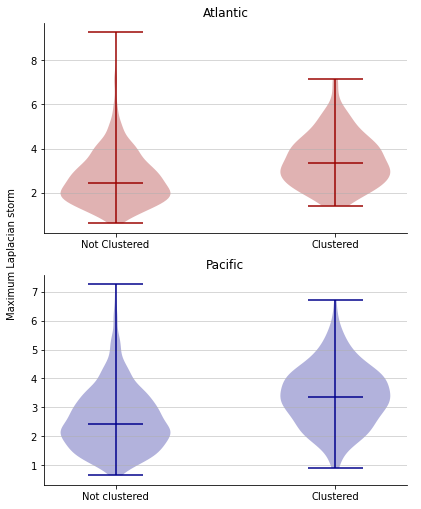

In [16]:
#Strength within a cluster
dataStrength_Atlantic = [lapl_storms[np.array(nonclust_cyclones_Atlantic)-1],lapl_storms[np.array(clust_cyclones_Atlantic)-1]]
dataStrength_Pacific = [lapl_storms[np.array(nonclust_cyclones_Pacific)-1],lapl_storms[np.array(clust_cyclones_Pacific)-1]]
#dataStrength_primary_nolength = [lapl_primary_nolength,lapl_secondary_nolength,lapl_final_nolength]

# Set the figure size
plt.rcParams["figure.figsize"] = [6.50, 8.50]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(2,1)

#vio2 = ax[2].violinplot(data3,widths=.3,showmedians=True)
vio1 = ax[0].violinplot(dataStrength_Atlantic,showmedians=True)
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(["Not Clustered","Clustered"])
ax[0].set_xlabel("")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)
ax[0].set_title("Atlantic")

vio2 = ax[1].violinplot(dataStrength_Pacific,showmedians=True)
ax[1].set_xticks([1,2])
ax[1].set_xticklabels([ "Not clustered","Clustered"])
ax[1].set_xlabel("")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)
ax[1].set_title("Pacific")

#Set face colors of violin plots
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vio1[partname]
    vp.set_edgecolor("xkcd:deep red")
    vp = vio2[partname]
    vp.set_edgecolor("darkblue") 
#vio0['cmedians'].set_colors("xkcd:deep red")

for pc in vio1['bodies']:
    pc.set_facecolor("xkcd:deep red")
for pc in vio2['bodies']:
    pc.set_facecolor("darkblue")

#Add xlabel and ylabel
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian storm")

# Hide the right and top spines
for a in range(2):
    ax[a].spines[['right', 'top']].set_visible(False)

#save Figure
plt.savefig("MaxLaplPdfExit" + reschar + "_WithinCluster_" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + ".pdf")


In [24]:
np.quantile(lapl_storms,0.95)

4.576